In [1]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

scene_id=494 scene_name=scene-0640 map_name=boston-seaport


/home/kfir/workspace/RadarLocalization/dataset.py:365: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


odom_speed [[1.53729634e+15 0.00000000e+00]
 [1.53729634e+15 1.00000000e+00]
 [1.53729634e+15 1.00000000e+00]
 ...
 [1.53729650e+15 2.20000000e+01]
 [1.53729650e+15 2.20000000e+01]
 [1.53729650e+15 2.20000000e+01]]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


self.dir_name images/494/database


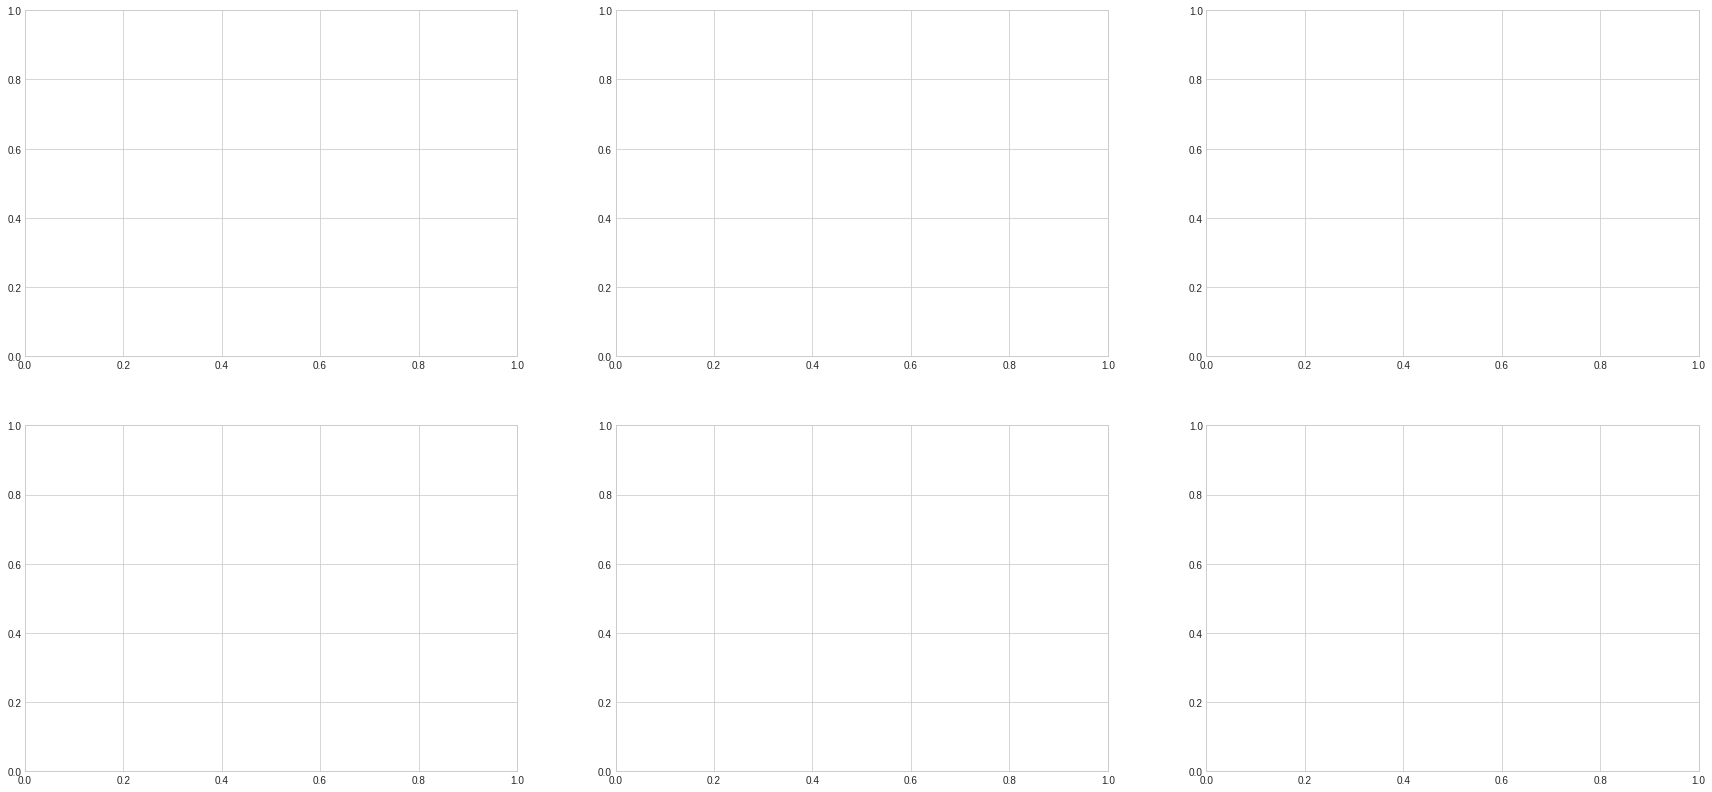

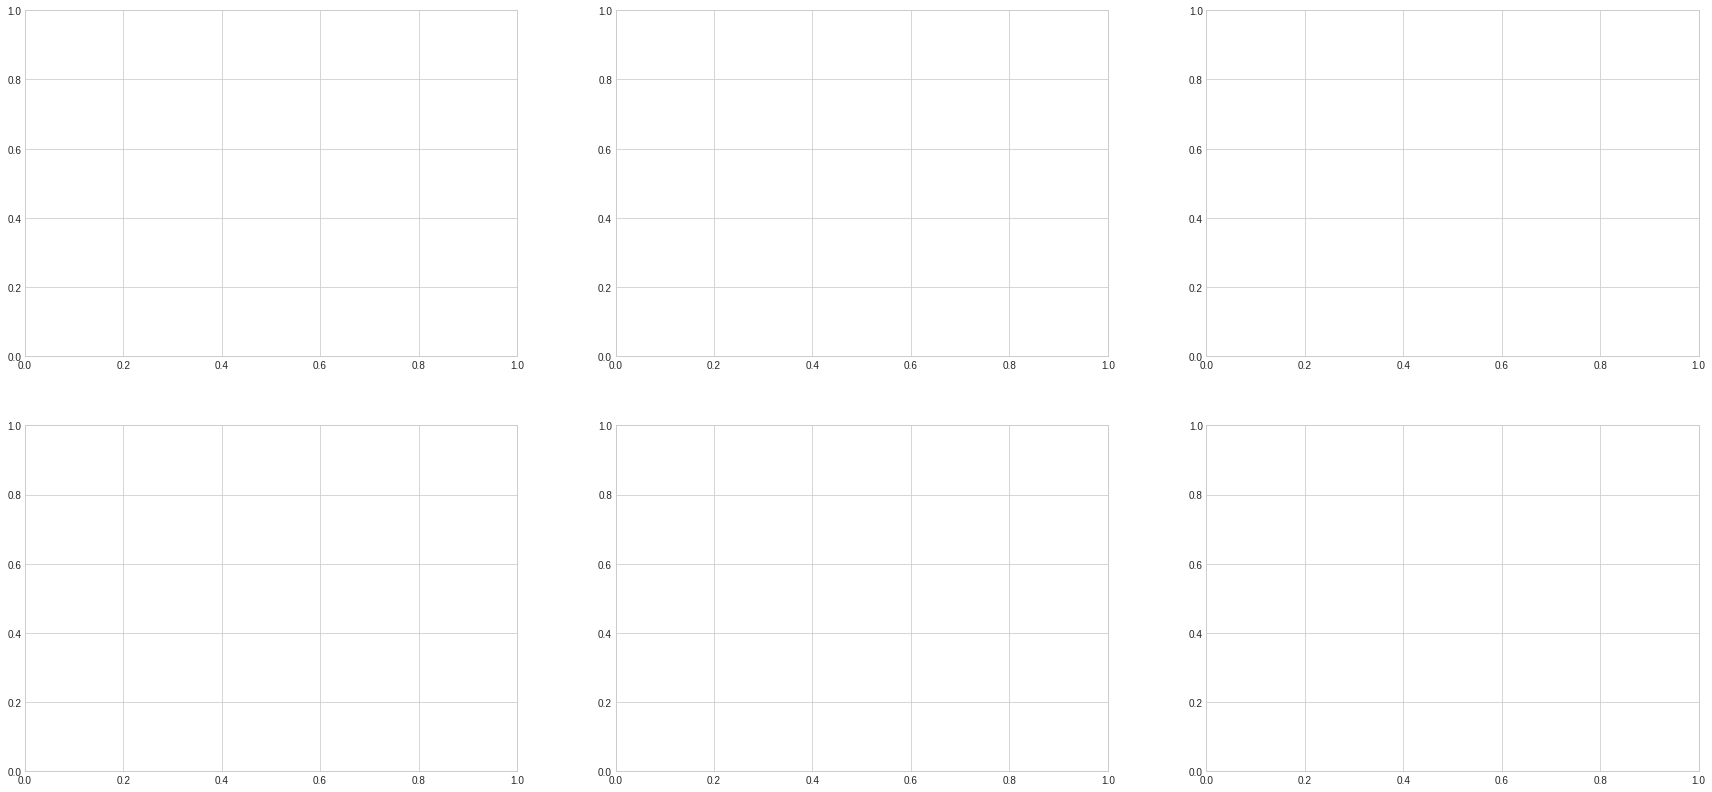

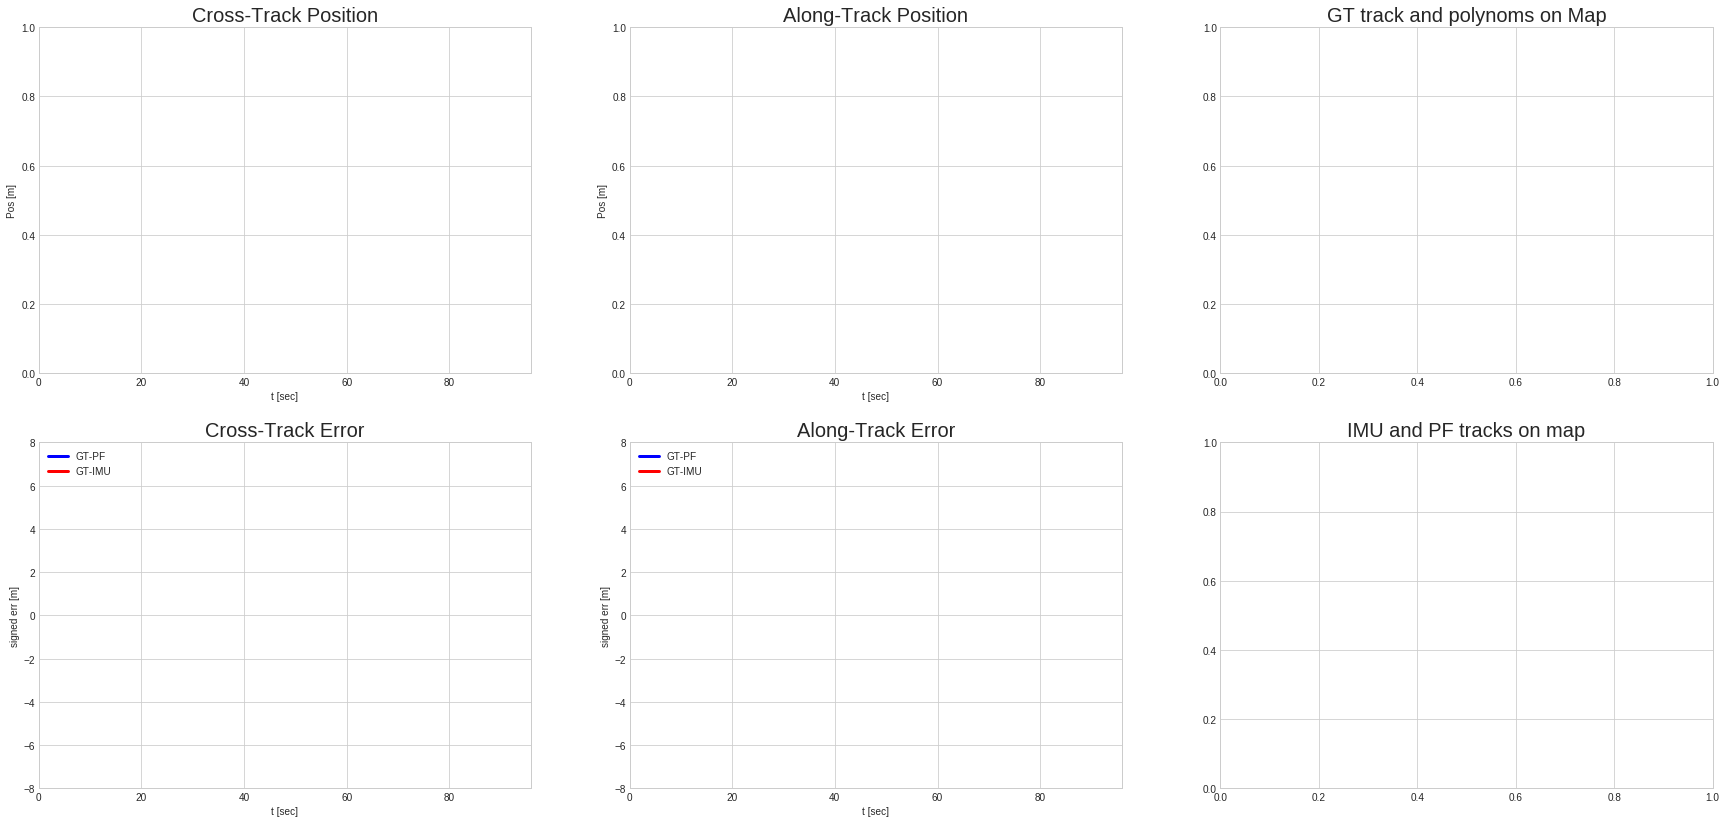

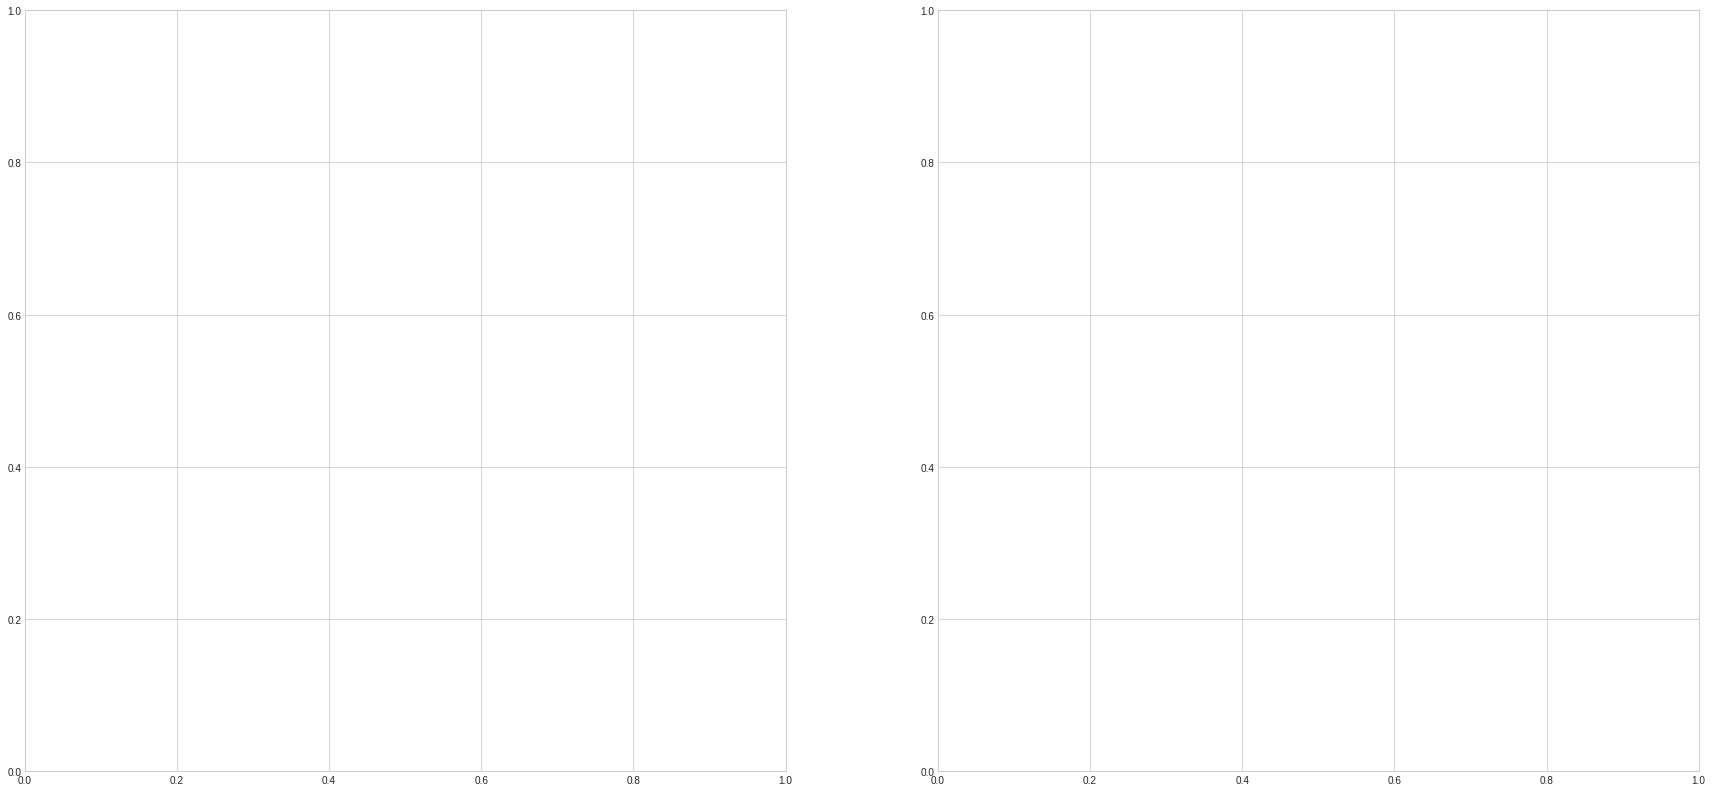

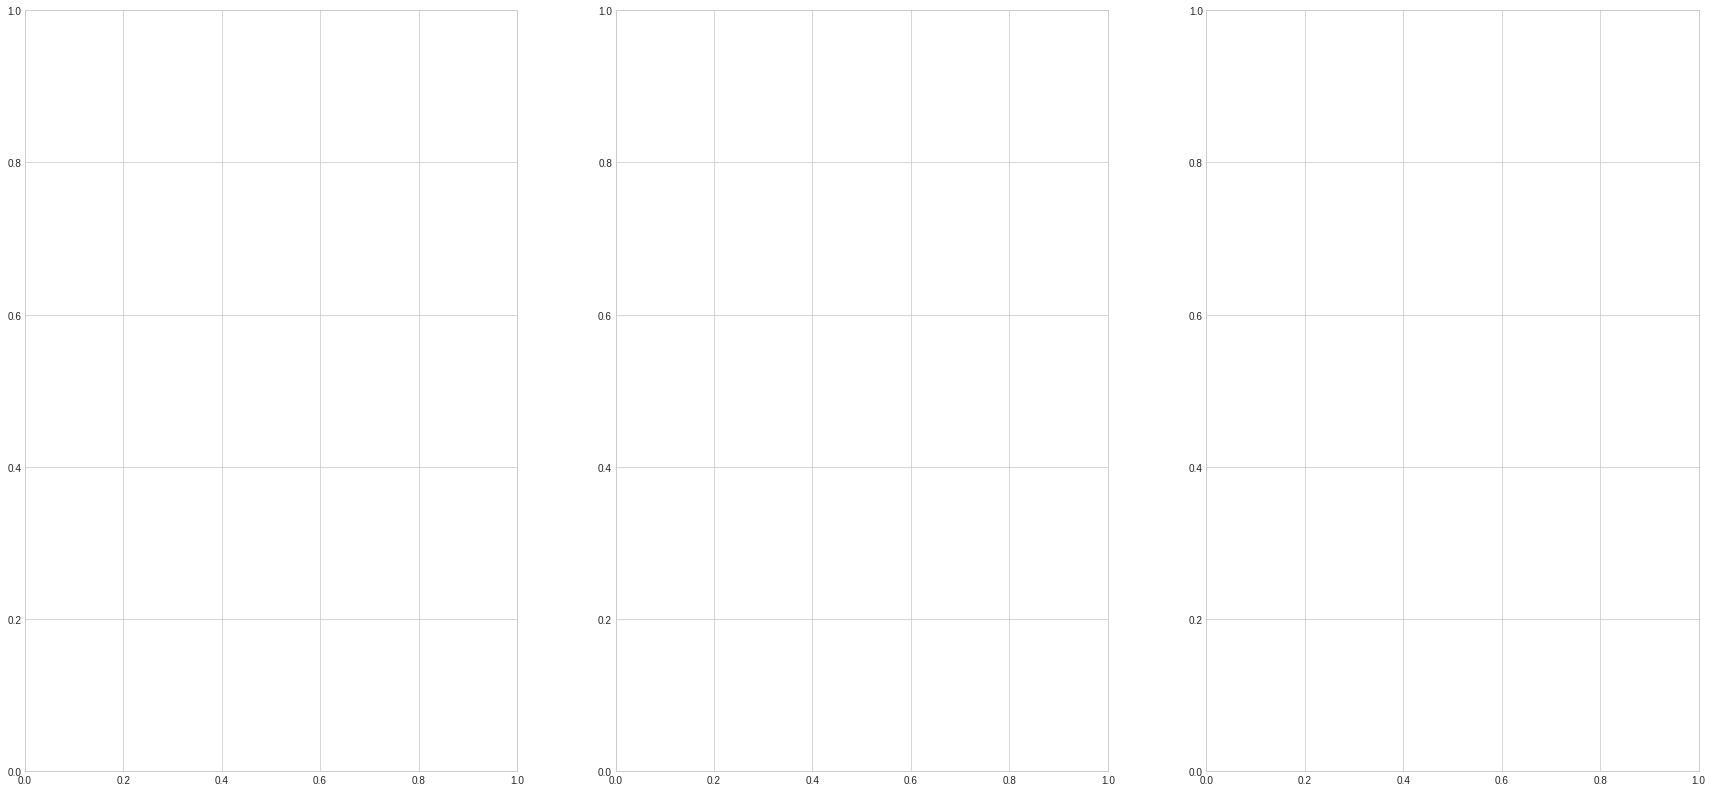

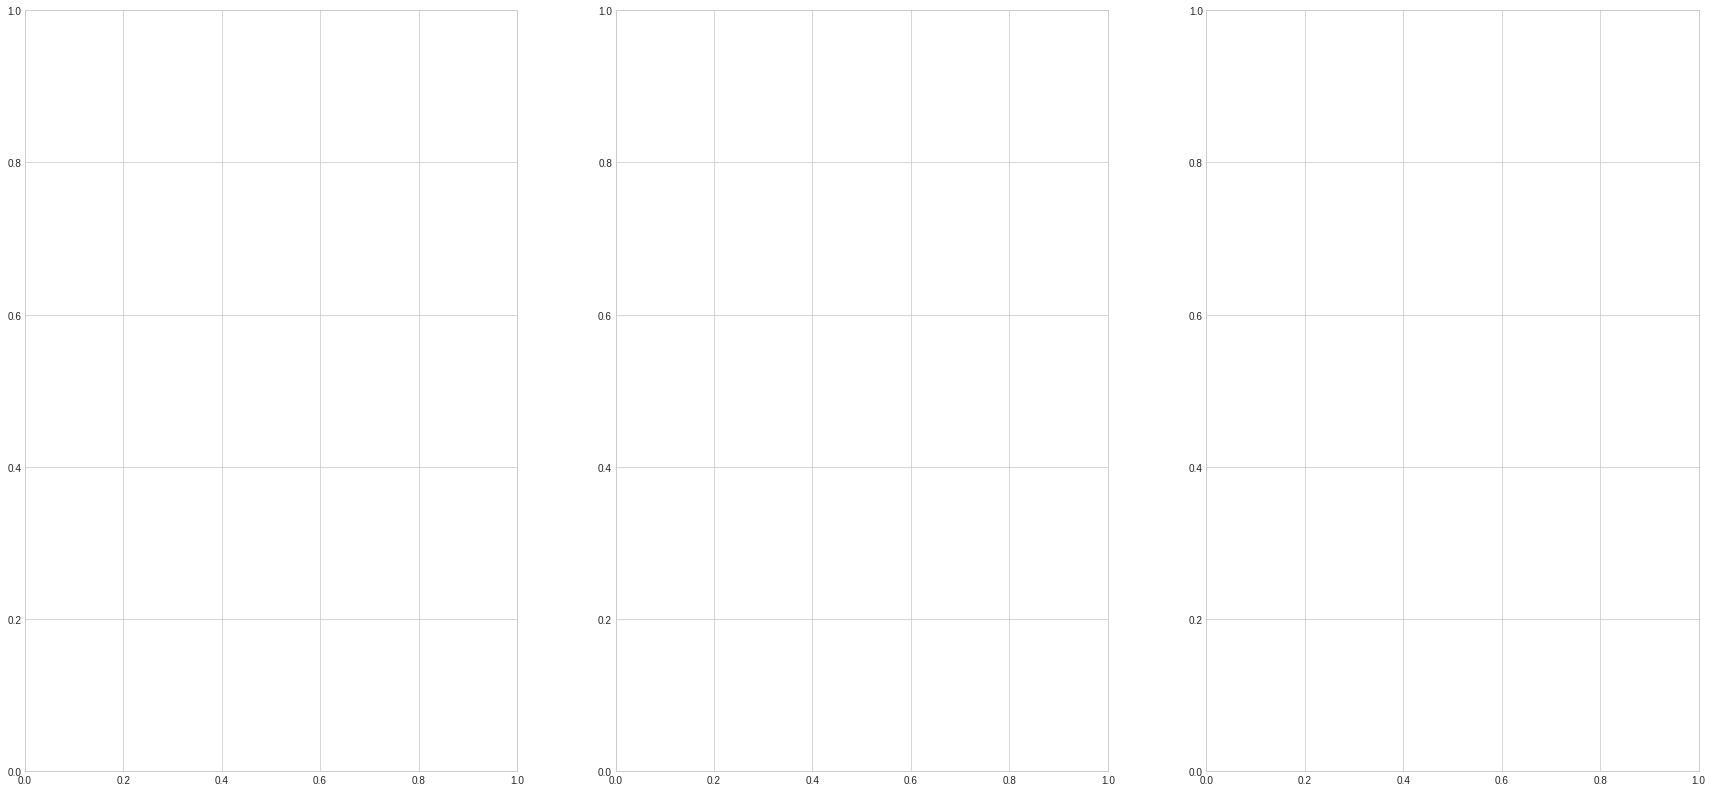

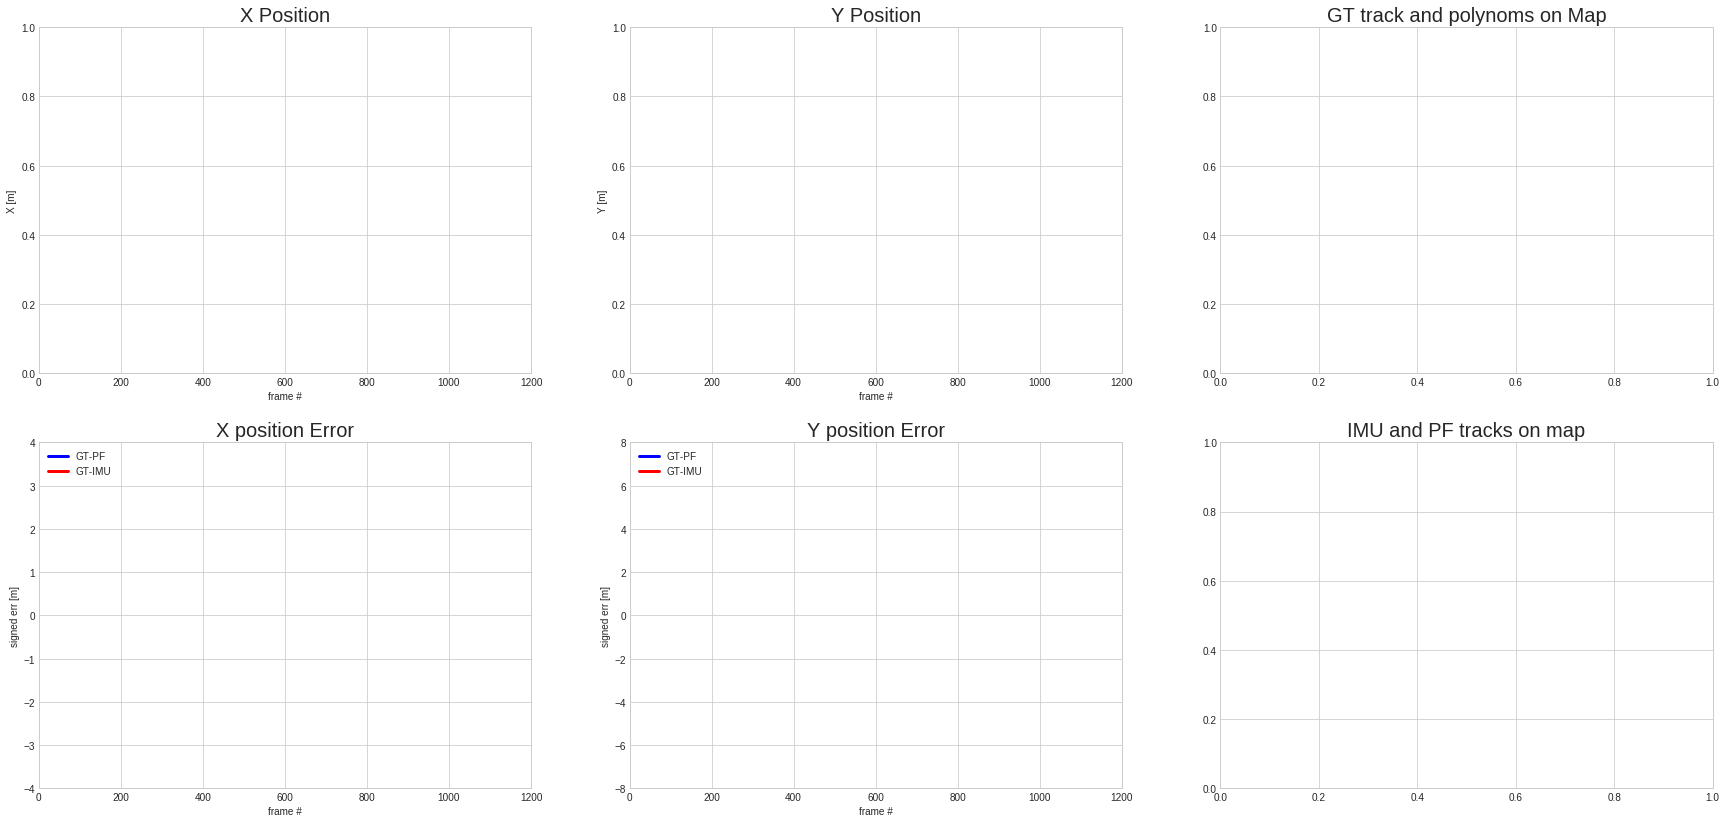

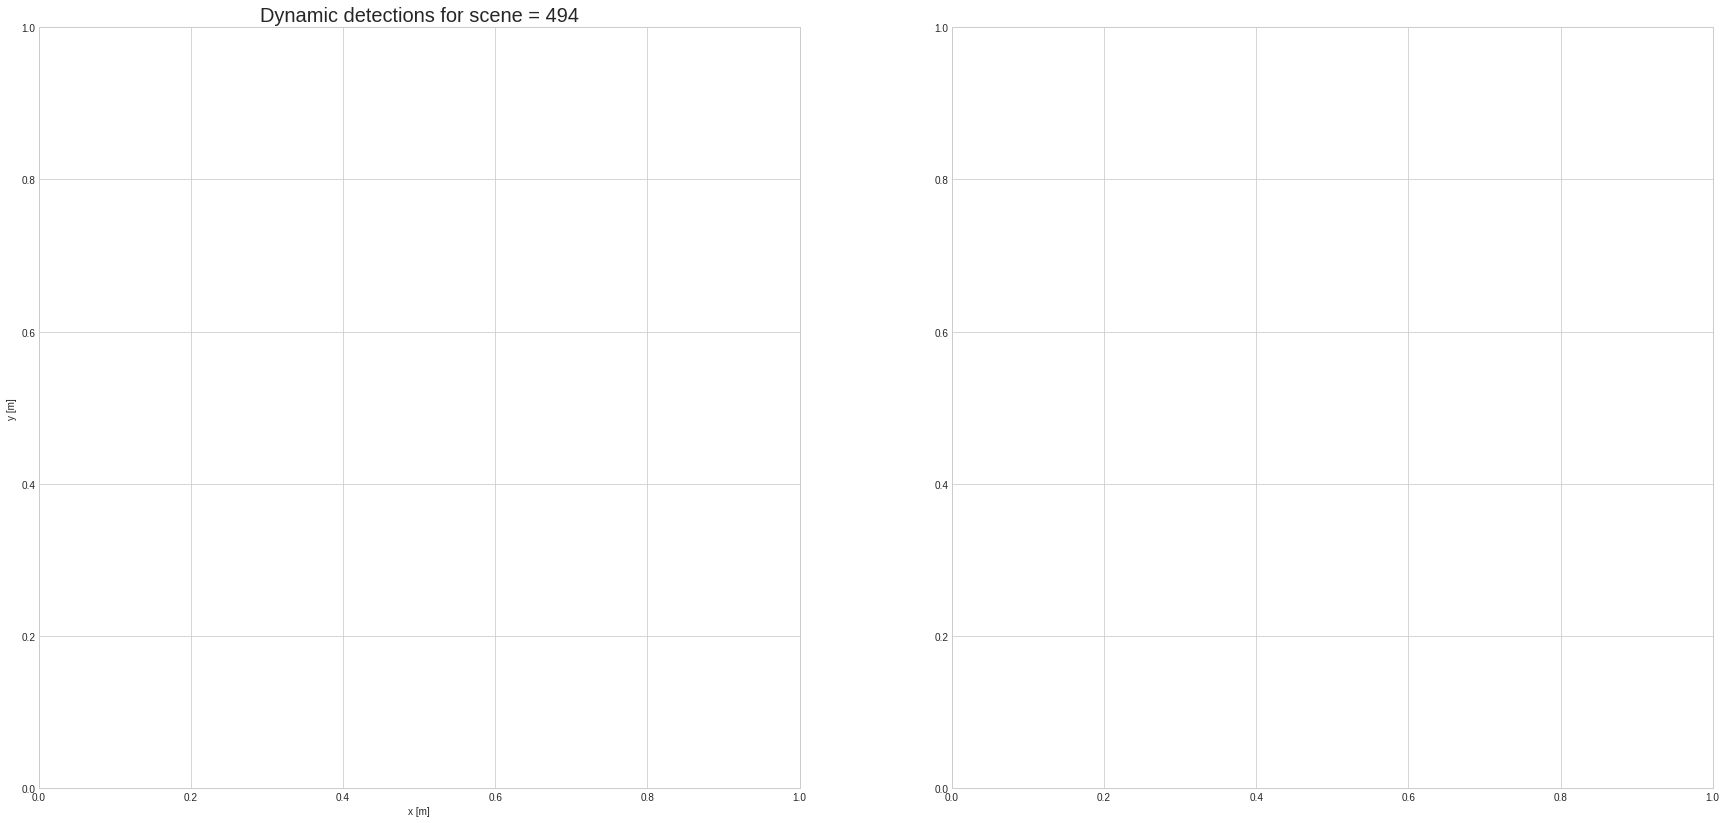

In [2]:
%load_ext autoreload
%autoreload 2
from simulation import NuscenesSimulation

class DummyModel():
    def __init__(self):
        self.mm = True
        
scene = 494
dummy_model = DummyModel()
video_list={'video' : False, 'video_debug': False, 'video_pf': False, 'video_pf_xy': False, 'dynamic_tracker': False}
sim = NuscenesSimulation(nusc=nusc, model=dummy_model, scene_id=scene, Nmax=1200, video_list=video_list, save_processed=True)

In [3]:
from tqdm import tqdm
import math

def calcTrackPosition(ego_path, ego_trns, gt_pos, pf_pos, imu_pos):
    #GT position
    gt_cross_track = 0
    it = np.argmin(np.linalg.norm(ego_path - np.array(gt_pos),axis=1),axis=0)
    it = max(1, min(it, ego_trns.shape[0]-2))
    gt_along_track = np.copy(ego_trns[it])
    #PF position
    it = np.argmin(np.linalg.norm(ego_path - np.array(pf_pos),axis=1),axis=0)
    it = max(1, min(it, ego_path.shape[0]-2))
    x,y,x1,y1,x2,y2 = pf_pos[0],pf_pos[1],ego_path[it-1][0], ego_path[it-1][1], ego_path[it+1][0], ego_path[it+1][1]
    d=(x-x1)*(y2-y1)-(y-y1)*(x2-x1)
    pf_cross_track = np.sign(d) * np.linalg.norm(ego_path[it]-pf_pos) #np.linalg.norm(np.cross(p2-p1, p1-pf_pos))/np.linalg.norm(p2-p1)
    pf_along_track = np.copy(ego_trns[it])
    #IMU position
    it = np.argmin(np.linalg.norm(ego_path - np.array(imu_pos),axis=1),axis=0)
    it = max(1, min(it, ego_path.shape[0]-2))
    x,y,x1,y1,x2,y2 = imu_pos[0],imu_pos[1],ego_path[it-1][0], ego_path[it-1][1], ego_path[it+1][0], ego_path[it+1][1]
    d=(x-x1)*(y2-y1)-(y-y1)*(x2-x1)
    imu_cross_track = np.sign(d) * np.linalg.norm(ego_path[it]-imu_pos)
    imu_along_track = np.copy(ego_trns[it])

    return np.array([gt_cross_track, gt_along_track]), np.array([pf_cross_track, pf_along_track]), np.array([imu_cross_track, imu_along_track])
    

def calc_rmse(ego_path, ego_trns, gt_pos, pf_mean_pos, imu_pos):
    gt_track_pos, pf_track_pos, imu_track_pos = calcTrackPosition(ego_path, ego_trns, gt_pos[0:2], pf_mean_pos, imu_pos)
    pf_track_errors = pf_track_pos - gt_track_pos
    imu_track_errors = imu_track_pos - gt_track_pos

    return pf_track_errors, imu_track_errors
    
def calc_acc_rmse(ego_path, ego_trns, pf_mean_pos, imu_pos, N):
    pf_rmse_lateral = np.zeros(N)
    pf_rmse_longitudal = np.zeros(N)
    imu_rmse_lateral = np.zeros(N)
    imu_rmse_longitudal = np.zeros(N)
    for i in tqdm(range(0,N)):
        pf_track_errors, imu_track_errors = calc_rmse(ego_path, ego_trns, ego_path[i,:], pf_mean_pos[i,:], imu_pos[i,:])
        print("pf_track_errors",pf_track_errors,"imu_track_errors",imu_track_errors)
        pf_rmse_lateral[i] = pf_track_errors[0]
        pf_rmse_longitudal[i] = pf_track_errors[1]
        imu_rmse_lateral[i] = imu_track_errors[0]
        imu_rmse_longitudal[i] = imu_track_errors[1]

    print(f"PF RMSE lateral: {math.sqrt((1. / N) * np.sum(pf_rmse_lateral**2))}")
    print(f"PF RMSE longitudal: {math.sqrt((1. / N) * np.sum(pf_rmse_longitudal**2))}")
    print(f"IMU RMSE lateral: {math.sqrt((1. / N) * np.sum(imu_rmse_lateral**2))}")
    print(f"IMU RMSE longitudal: {math.sqrt((1. / N) * np.sum(imu_rmse_longitudal**2))}")

In [12]:
from database import NuscenesProcessedDatabase
from tqdm import tqdm
data = NuscenesProcessedDatabase(scene_id=scene)


nusc_map = sim.dataset.nusc_map
video_with_priors = True

for t in tqdm(range(0,800)):
    img = sim.dataset.getSyncedImage(t)
    video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(t)
    video_data["img"] = img

    sim.video_list["video"] = False
    sim.video_list["video_debug"] = False
    sim.video_list["video_pf"] = True
    sim.video_list["video_pf_xy"] = False
    sim.video_list["dynamic_tracker"] = False

    sim.drawPlots(t, video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, nusc_map, video_with_priors, translation, debug_info)

  0%|          | 0/800 [00:00<?, ?it/s]

self.dir_name images/426/database
PF RMSE lateral: 0.016042433992380624
PF RMSE longitudal: 7.052748759224578e-06
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
No handles with labels found to put in legend.
  0%|          | 1/800 [00:00<09:52,  1.35it/s]

PF RMSE lateral: 0.018122493878530595
PF RMSE longitudal: 0.00030230840998237324
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 2.582697086698539e-06


  0%|          | 2/800 [00:01<09:25,  1.41it/s]

PF RMSE lateral: 0.01887417713530477
PF RMSE longitudal: 0.0003476666482827236
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 4.585553893988746e-06


  0%|          | 3/800 [00:01<09:01,  1.47it/s]

PF RMSE lateral: 0.019329433139518036
PF RMSE longitudal: 0.00036767222654666135
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 6.034026385701461e-06


  0%|          | 4/800 [00:02<08:44,  1.52it/s]

PF RMSE lateral: 0.0205505751275359
PF RMSE longitudal: 0.00037849396104317753
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 7.651430409079173e-06


  1%|          | 5/800 [00:03<08:33,  1.55it/s]

PF RMSE lateral: 0.021118297315707597
PF RMSE longitudal: 0.0003847129834933074
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 9.764112811051167e-06


  1%|          | 6/800 [00:03<08:25,  1.57it/s]

PF RMSE lateral: 0.021562072620486795
PF RMSE longitudal: 0.00035622565073832244
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 1.2526770469064777e-05


  1%|          | 7/800 [00:04<08:22,  1.58it/s]

PF RMSE lateral: 0.02152319333626835
PF RMSE longitudal: 0.0003624254309660926
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 1.5330482747345215e-05


  1%|          | 8/800 [00:05<08:18,  1.59it/s]

PF RMSE lateral: 0.02140180677610935
PF RMSE longitudal: 0.00036645581512335056
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 1.8345328659822733e-05


  1%|          | 9/800 [00:05<08:17,  1.59it/s]

PF RMSE lateral: 0.021320975961136822
PF RMSE longitudal: 0.0003477944421554567
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 2.127423341300669e-05


  1%|▏         | 10/800 [00:06<08:16,  1.59it/s]

PF RMSE lateral: 0.020875916420193305
PF RMSE longitudal: 0.0003317631428489776
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 2.3690484946557342e-05


  1%|▏         | 11/800 [00:06<08:15,  1.59it/s]

PF RMSE lateral: 0.020594572268641288
PF RMSE longitudal: 0.0003367441909827891
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 2.596693194803455e-05


  2%|▏         | 12/800 [00:07<08:14,  1.59it/s]

PF RMSE lateral: 0.020097969535778117
PF RMSE longitudal: 0.0003404883980238558
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 2.835034986295551e-05


  2%|▏         | 13/800 [00:08<08:13,  1.59it/s]

PF RMSE lateral: 0.019721907993577124
PF RMSE longitudal: 0.00034342809127735997
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 3.0595913981199055e-05
n_tracks 1 cost_dyn_true [1797.7226038861636] cost_dyn_mean [1780.2886437332927]
abs_vel =[11.79804753]
xlim [237.29255678864132, 247.14600503980108] ylim [690.1001788729516, 693.4852883633379]
abs_vel =[11.79804753]


  2%|▏         | 14/800 [00:09<09:37,  1.36it/s]

PF RMSE lateral: 0.019425098210281315
PF RMSE longitudal: 0.00034564714452865053
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 3.288100089657925e-05
n_tracks 1 cost_dyn_true [1905.4096914760235] cost_dyn_mean [1887.9576901008913]
abs_vel =[11.82233492]
xlim [236.42906781679113, 246.414132746884] ylim [690.366830804866, 693.764104607918]
abs_vel =[11.82233492]


  2%|▏         | 15/800 [00:10<10:30,  1.24it/s]

PF RMSE lateral: 0.01908395075478983
PF RMSE longitudal: 0.00034724520704519955
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 3.527209865853249e-05
n_tracks 1 cost_dyn_true [2016.142734808459] cost_dyn_mean [1998.5679262576991]
abs_vel =[11.84899402]
xlim [235.64173729358552, 244.78419694736684] ylim [690.9340501881128, 694.0343802133261]
abs_vel =[11.84899402]


  2%|▏         | 16/800 [00:11<11:03,  1.18it/s]

PF RMSE lateral: 0.018754830025136154
PF RMSE longitudal: 0.00033717968160266516
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 3.7769064165204376e-05
n_tracks 1 cost_dyn_true [2130.319738793323] cost_dyn_mean [2113.0872548685456]
abs_vel =[11.87538071]
xlim [234.78522460889533, 243.96801170590038] ylim [691.2268823330662, 694.329064206866]
abs_vel =[11.87538071]


  2%|▏         | 17/800 [00:12<11:30,  1.13it/s]

PF RMSE lateral: 0.018556266154220506
PF RMSE longitudal: 0.0003386368162741496
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 4.0109469802671136e-05
n_tracks 1 cost_dyn_true [2246.6262443919954] cost_dyn_mean [2228.60048571469]
abs_vel =[11.90205878]
xlim [233.9757714438112, 243.18138518916254] ylim [691.5027005794302, 694.6174001206615]
abs_vel =[11.90205878]


  2%|▏         | 18/800 [00:13<11:49,  1.10it/s]

PF RMSE lateral: 0.018346265186790955
PF RMSE longitudal: 0.00033973095474540237
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 4.241427649083094e-05
n_tracks 1 cost_dyn_true [2431.044899842496] cost_dyn_mean [2412.391127447804]
abs_vel =[11.92915586]
xlim [232.20608932383294, 242.37582431284187] ylim [691.7680050795324, 695.2273622179727]
abs_vel =[11.92915586]


  2%|▏         | 19/800 [00:13<12:01,  1.08it/s]

PF RMSE lateral: 0.01816883369997123
PF RMSE longitudal: 0.0003406143685996121
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 4.454044016942324e-05
n_tracks 1 cost_dyn_true [2622.872803090753] cost_dyn_mean [2604.1917190413133]
abs_vel =[11.95354322]
xlim [231.3575330319413, 241.5278946558183] ylim [692.0593777900044, 695.5182498517028]
abs_vel =[11.95354322]


  2%|▎         | 20/800 [00:14<12:15,  1.06it/s]

PF RMSE lateral: 0.01800285047243863
PF RMSE longitudal: 0.0003413238736601142
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 4.6516155750705186e-05
n_tracks 1 cost_dyn_true [2756.8063084363903] cost_dyn_mean [2738.0227903592313]
abs_vel =[11.97560798]
xlim [230.47123085152975, 240.73957262709462] ylim [692.3302708641638, 695.822079932089]
abs_vel =[11.97560798]


  3%|▎         | 21/800 [00:15<12:20,  1.05it/s]

PF RMSE lateral: 0.0179327794364515
PF RMSE longitudal: 0.00034177754911589905
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 4.853835619586542e-05
n_tracks 1 cost_dyn_true [2895.5317666004585] cost_dyn_mean [2875.788726031993]
abs_vel =[11.99782981]
xlim [229.6437334847963, 239.00272282675056] ylim [692.9273079460801, 696.1006454835098]
abs_vel =[11.99782981]


  3%|▎         | 22/800 [00:16<12:24,  1.05it/s]

PF RMSE lateral: 0.017839545908609936
PF RMSE longitudal: 0.0003419378971368629
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 5.07216625939322e-05
n_tracks 1 cost_dyn_true [3038.6174970876828] cost_dyn_mean [3018.8999441973465]
abs_vel =[12.01872496]
xlim [228.7537215937177, 238.1683787193535] ylim [693.1842333483427, 696.4227081139351]
abs_vel =[12.01872496]


  3%|▎         | 23/800 [00:17<12:27,  1.04it/s]

PF RMSE lateral: 0.01776944989670599
PF RMSE longitudal: 0.0003352199440428995
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 5.330943627257163e-05
n_tracks 1 cost_dyn_true [3256.5917171340825] cost_dyn_mean [3237.060779411916]
abs_vel =[12.03809508]
xlim [227.01299569972764, 237.35294279893137] ylim [693.4475216696246, 697.0153319404667]
abs_vel =[12.03809508]


  3%|▎         | 24/800 [00:18<12:40,  1.02it/s]

PF RMSE lateral: 0.01757822583256618
PF RMSE longitudal: 0.0003350290588065729
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 5.598130098195646e-05
n_tracks 1 cost_dyn_true [3471.5645227385066] cost_dyn_mean [3451.108817611286]
abs_vel =[12.05586715]
xlim [226.24195109133575, 236.52472209848224] ylim [693.7283758746175, 697.3602914261288]
abs_vel =[12.05586715]


  3%|▎         | 25/800 [00:19<12:44,  1.01it/s]

PF RMSE lateral: 0.01752633402019276
PF RMSE longitudal: 0.00033475842463546123
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 5.850657600246081e-05
n_tracks 1 cost_dyn_true [3621.609907124458] cost_dyn_mean [3599.775402559989]
abs_vel =[12.07227215]
xlim [225.35528455952044, 235.67157210903312] ylim [694.0223949710622, 697.6670081433113]
abs_vel =[12.07227215]


  3%|▎         | 26/800 [00:20<12:46,  1.01it/s]

PF RMSE lateral: 0.017436293264235736
PF RMSE longitudal: 0.0003344490590635232
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 6.085374375175614e-05
n_tracks 1 cost_dyn_true [3782.497385712899] cost_dyn_mean [3761.1798402602826]
abs_vel =[12.08746195]
xlim [224.4670719308758, 234.86695937009162] ylim [694.3092540401123, 697.9738012881807]
abs_vel =[12.08746195]


  3%|▎         | 27/800 [00:21<12:50,  1.00it/s]

PF RMSE lateral: 0.017340083517447924
PF RMSE longitudal: 0.0003341217017478307
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 6.302331670604142e-05
n_tracks 1 cost_dyn_true [3950.6298871627005] cost_dyn_mean [3928.358350700346]
abs_vel =[12.10643182]
xlim [223.59751850941592, 233.1003259052476] ylim [694.9155144948496, 698.3167797003189]
abs_vel =[12.10643182]


  4%|▎         | 28/800 [00:22<12:50,  1.00it/s]

PF RMSE lateral: 0.017256459098422775
PF RMSE longitudal: 0.00033377230129493966
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 6.505296350326274e-05
n_tracks 1 cost_dyn_true [4129.338969450643] cost_dyn_mean [4105.358195684825]
abs_vel =[12.12316695]
xlim [222.752883391056, 232.2516132063413] ylim [695.190658247802, 698.9387630954591]
abs_vel =[12.12316695]


  4%|▎         | 29/800 [00:23<12:51,  1.00s/it]

PF RMSE lateral: 0.01717927106487404
PF RMSE longitudal: 0.00033333677299378784
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 6.707544641964138e-05
n_tracks 1 cost_dyn_true [4390.668199345236] cost_dyn_mean [4365.104075498203]
abs_vel =[12.14094911]
xlim [220.9944753768629, 231.4115025275271] ylim [695.479054391444, 699.5338212318599]
abs_vel =[12.14094911]


  4%|▍         | 30/800 [00:24<12:57,  1.01s/it]

PF RMSE lateral: 0.017082999310572104
PF RMSE longitudal: 0.00033286121441705117
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 6.90279430868321e-05
n_tracks 1 cost_dyn_true [4641.440566492506] cost_dyn_mean [4615.842368287091]
abs_vel =[12.15833513]
xlim [220.19521079512134, 230.5393527367982] ylim [695.7734645294569, 699.7981747807879]
abs_vel =[12.15833513]


  4%|▍         | 31/800 [00:25<13:00,  1.02s/it]

PF RMSE lateral: 0.01785268180148812
PF RMSE longitudal: 0.00033238239371517634
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 7.086373810287749e-05
n_tracks 1 cost_dyn_true [4816.8488214940535] cost_dyn_mean [4787.094397613988]
abs_vel =[12.1753456]
xlim [219.28804316851728, 229.65280323187466] ylim [696.0926625079869, 700.1153095097055]
abs_vel =[12.1753456]


  4%|▍         | 32/800 [00:27<13:04,  1.02s/it]

PF RMSE lateral: 0.018534354046389485
PF RMSE longitudal: 0.00033184404236924573
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 7.269295436013996e-05
n_tracks 1 cost_dyn_true [4997.303371132787] cost_dyn_mean [4967.403065721665]
abs_vel =[12.191606]
xlim [218.5126798758874, 227.91015728692918] ylim [696.6853580403281, 700.3771822753815]
abs_vel =[12.191606]


  4%|▍         | 33/800 [00:28<13:00,  1.02s/it]

PF RMSE lateral: 0.01918965317585516
PF RMSE longitudal: 0.0003312160409323524
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 7.457826936135605e-05
n_tracks 1 cost_dyn_true [5178.1798560325915] cost_dyn_mean [5148.092523512123]
abs_vel =[12.20704355]
xlim [217.61439583421836, 227.14243986865117] ylim [697.0309310409424, 700.6452481876736]
abs_vel =[12.20704355]


  4%|▍         | 34/800 [00:29<12:57,  1.01s/it]

PF RMSE lateral: 0.02007509129328725
PF RMSE longitudal: 0.0003305456490311315
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 7.644624457195464e-05
n_tracks 1 cost_dyn_true [5360.745767862443] cost_dyn_mean [5329.748709704752]
abs_vel =[12.22161313]
xlim [216.81802233917105, 226.25306498206558] ylim [697.3380368044392, 700.9311408549236]
abs_vel =[12.22161313]


  4%|▍         | 35/800 [00:30<13:01,  1.02s/it]

PF RMSE lateral: 0.020825986078069215
PF RMSE longitudal: 0.0003298552279915067
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 7.82663028142398e-05
n_tracks 1 cost_dyn_true [5541.234228649174] cost_dyn_mean [5509.96843790315]
abs_vel =[12.23524255]
xlim [215.97735886674624, 225.36656611440267] ylim [697.6462812587654, 701.1875483122003]
abs_vel =[12.23524255]


  4%|▍         | 36/800 [00:31<13:04,  1.03s/it]

PF RMSE lateral: 0.02138346018540183
PF RMSE longitudal: 0.00032884988043657383
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 8.059569697323364e-05
n_tracks 1 cost_dyn_true [5939.075458675528] cost_dyn_mean [5906.85741459483]
abs_vel =[12.24738391]
xlim [213.3120000398258, 224.53979656570672] ylim [697.9643966409106, 702.3161099008983]
abs_vel =[12.24738391]


  5%|▍         | 37/800 [00:32<12:59,  1.02s/it]

PF RMSE lateral: 0.0218830291972391
PF RMSE longitudal: 0.0003277978231427169
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 8.293185780334231e-05
n_tracks 1 cost_dyn_true [6350.182740536866] cost_dyn_mean [6316.764584978717]
abs_vel =[12.25947046]
xlim [212.4062408761559, 223.69787457714904] ylim [698.5874063697981, 702.5697302423362]
abs_vel =[12.25947046]


  5%|▍         | 38/800 [00:33<12:58,  1.02s/it]

PF RMSE lateral: 0.022138752349155248
PF RMSE longitudal: 0.00032676767573766076
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 8.514554776108296e-05
n_tracks 1 cost_dyn_true [6559.055827759601] cost_dyn_mean [6526.221119073223]
abs_vel =[12.27083863]
xlim [211.6370531951413, 221.9360901354984] ylim [699.1782012104056, 702.94761314018]
abs_vel =[12.27083863]


  5%|▍         | 39/800 [00:34<12:55,  1.02s/it]

PF RMSE lateral: 0.022358164880702996
PF RMSE longitudal: 0.0003257672776051035
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 8.723261201133244e-05
n_tracks 1 cost_dyn_true [6767.293407282044] cost_dyn_mean [6734.189782995676]
abs_vel =[12.28169031]
xlim [210.7551678246652, 221.13729092933974] ylim [699.4452828799805, 703.1847096927543]
abs_vel =[12.28169031]


  5%|▌         | 40/800 [00:35<12:53,  1.02s/it]

PF RMSE lateral: 0.02264051467229981
PF RMSE longitudal: 0.00032479468817414586
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 8.920689987920135e-05
n_tracks 1 cost_dyn_true [6973.278951205442] cost_dyn_mean [6939.9313237216775]
abs_vel =[12.2921148]
xlim [209.93568994438638, 220.22692967452647] ylim [699.7664311714937, 703.4196127464206]
abs_vel =[12.2921148]


  5%|▌         | 41/800 [00:36<12:52,  1.02s/it]

PF RMSE lateral: 0.022874079847536054
PF RMSE longitudal: 0.00032377870335819085
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 9.121242825010565e-05
n_tracks 1 cost_dyn_true [7296.1443988091] cost_dyn_mean [7262.706652856497]
abs_vel =[12.30243328]
xlim [208.13280331767447, 219.45444159397505] ylim [700.0292750544261, 703.9918571611099]
abs_vel =[12.30243328]


  5%|▌         | 42/800 [00:37<12:50,  1.02s/it]

PF RMSE lateral: 0.023092583919167093
PF RMSE longitudal: 0.0003227825985849146
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 9.31308676511452e-05
n_tracks 1 cost_dyn_true [7636.123288609901] cost_dyn_mean [7602.265399763102]
abs_vel =[12.31227184]
xlim [207.23242482997887, 218.56247941722881] ylim [700.298502450306, 704.3129824159058]
abs_vel =[12.31227184]


  5%|▌         | 43/800 [00:38<12:48,  1.02s/it]

PF RMSE lateral: 0.023290161023620012
PF RMSE longitudal: 0.000321795551560497
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 9.498889109504448e-05
n_tracks 1 cost_dyn_true [7872.861429792876] cost_dyn_mean [7839.127134941887]
abs_vel =[12.32183656]
xlim [206.30462542339285, 217.76793671244633] ylim [700.5875503188357, 704.5538133311393]
abs_vel =[12.32183656]


  6%|▌         | 44/800 [00:39<12:47,  1.02s/it]

PF RMSE lateral: 0.023437268457024086
PF RMSE longitudal: 0.0003208159558862436
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 9.679411021594e-05
n_tracks 1 cost_dyn_true [8105.492233518073] cost_dyn_mean [8071.4645428889135]
abs_vel =[12.33050083]
xlim [205.5096318739435, 216.92291603288382] ylim [700.8384799384146, 704.9770839378397]
abs_vel =[12.33050083]


  6%|▌         | 45/800 [00:40<12:49,  1.02s/it]

PF RMSE lateral: 0.023587237543790218
PF RMSE longitudal: 0.00031981002854420516
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 9.861480517783521e-05
n_tracks 1 cost_dyn_true [8348.663181853179] cost_dyn_mean [8314.442403694877]
abs_vel =[12.3393744]
xlim [204.59591856035783, 214.26170627286592] ylim [701.974303192524, 705.1425577022491]
abs_vel =[12.3393744]


  6%|▌         | 46/800 [00:41<12:53,  1.03s/it]

PF RMSE lateral: 0.023713840841309588
PF RMSE longitudal: 0.0003187955985414087
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00010041926824263199
n_tracks 1 cost_dyn_true [8595.719026676768] cost_dyn_mean [8562.271711527996]
abs_vel =[12.34948383]
xlim [203.72134597570525, 213.35750317449754] ylim [702.2470590819545, 705.3637016622567]
abs_vel =[12.34948383]


  6%|▌         | 47/800 [00:42<12:52,  1.03s/it]

PF RMSE lateral: 0.023891798330786217
PF RMSE longitudal: 0.0003177551086048342
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00010224450160895754
n_tracks 1 cost_dyn_true [8960.66940261747] cost_dyn_mean [8926.764764262818]
abs_vel =[12.35962673]
xlim [201.90997410582955, 212.59067472303224] ylim [702.6259748659553, 705.9328412899459]
abs_vel =[12.35962673]


  6%|▌         | 48/800 [00:43<12:56,  1.03s/it]

PF RMSE lateral: 0.024104081001955192
PF RMSE longitudal: 0.00031673852470265584
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00010399478700261208
n_tracks 1 cost_dyn_true [9339.390027924917] cost_dyn_mean [9304.55320713072]
abs_vel =[12.36935563]
xlim [200.9993957318799, 211.7141114873345] ylim [702.8605826404759, 706.2521903542265]
abs_vel =[12.36935563]


  6%|▌         | 49/800 [00:44<12:56,  1.03s/it]

PF RMSE lateral: 0.024303756674759282
PF RMSE longitudal: 0.00031571586611099547
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.0001057319321551844
n_tracks 1 cost_dyn_true [9600.32933496255] cost_dyn_mean [9565.517532899154]
abs_vel =[12.37786127]
xlim [200.08146313671776, 210.89499140336605] ylim [703.0999277951231, 706.4800810288945]
abs_vel =[12.37786127]


  6%|▋         | 50/800 [00:45<12:55,  1.03s/it]

PF RMSE lateral: 0.024457599630104226
PF RMSE longitudal: 0.00031469249441423144
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.0001074474628267722
n_tracks 1 cost_dyn_true [9855.900039193213] cost_dyn_mean [9821.755128218841]
abs_vel =[12.38732979]
xlim [199.23611724627406, 209.09556800760382] ylim [703.6765388009325, 706.651270498886]
abs_vel =[12.38732979]


  6%|▋         | 51/800 [00:46<13:10,  1.05s/it]

PF RMSE lateral: 0.024583329025879064
PF RMSE longitudal: 0.00031366942216037955
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00010914134249416502
n_tracks 1 cost_dyn_true [10119.07313655521] cost_dyn_mean [10085.364671405696]
abs_vel =[12.39643413]
xlim [198.32271612115653, 208.19620744960042] ylim [703.9956811236575, 706.9621674644318]
abs_vel =[12.39643413]


  6%|▋         | 52/800 [00:47<13:05,  1.05s/it]

PF RMSE lateral: 0.024837448508772984
PF RMSE longitudal: 0.00031266708639989747
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00011077534585512531
n_tracks 1 cost_dyn_true [10385.882667288004] cost_dyn_mean [10350.89487355689]
abs_vel =[12.40519491]
xlim [197.47392524323493, 207.2709919167243] ylim [704.2363222886596, 707.255188745382]
abs_vel =[12.40519491]


  7%|▋         | 53/800 [00:48<13:05,  1.05s/it]

PF RMSE lateral: 0.024958572365009448
PF RMSE longitudal: 0.000311624117929082
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00011247264874047061
n_tracks 1 cost_dyn_true [10789.392365118547] cost_dyn_mean [10755.021909794916]
abs_vel =[12.41363122]
xlim [195.66018840699437, 206.52212492876046] ylim [704.6424322045674, 707.8665343626009]
abs_vel =[12.41363122]


  7%|▋         | 54/800 [00:49<13:04,  1.05s/it]

PF RMSE lateral: 0.025056873275092935
PF RMSE longitudal: 0.00031057418251087993
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00011416728864896221
n_tracks 1 cost_dyn_true [11200.095641235617] cost_dyn_mean [11166.155150644212]
abs_vel =[12.42251213]
xlim [194.7329239590449, 205.52584336058547] ylim [704.8562487041995, 707.9871499709132]
abs_vel =[12.42251213]


  7%|▋         | 55/800 [00:50<13:04,  1.05s/it]

PF RMSE lateral: 0.025076327475384394
PF RMSE longitudal: 0.00030951824285143346
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00011585867861386405
n_tracks 1 cost_dyn_true [11473.807919101971] cost_dyn_mean [11441.314276238072]
abs_vel =[12.43107587]
xlim [193.8770938328616, 204.64897223754335] ylim [705.0765333891995, 708.2778932126445]
abs_vel =[12.43107587]


  7%|▋         | 56/800 [00:51<13:03,  1.05s/it]

PF RMSE lateral: 0.025014723244143285
PF RMSE longitudal: 0.00030844084495053537
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.0001175800705365358
n_tracks 1 cost_dyn_true [11758.979154154553] cost_dyn_mean [11727.610045086756]
abs_vel =[12.43933912]
xlim [193.00174272118667, 202.84277466617596] ylim [705.6496482826506, 708.5732378456862]
abs_vel =[12.43933912]


  7%|▋         | 57/800 [00:52<13:01,  1.05s/it]

PF RMSE lateral: 0.024974351865544323
PF RMSE longitudal: 0.00030738404282550536
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00011924514549000695
n_tracks 1 cost_dyn_true [12047.433474565962] cost_dyn_mean [12015.641079046803]
abs_vel =[12.44731744]
xlim [192.14819589554494, 201.9311015033705] ylim [705.9665524674488, 708.8591703688762]
abs_vel =[12.44731744]


  7%|▋         | 58/800 [00:53<13:01,  1.05s/it]

PF RMSE lateral: 0.02494948949524791
PF RMSE longitudal: 0.0003063525328297802
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.0001208463556627813
n_tracks 1 cost_dyn_true [12339.441352373851] cost_dyn_mean [12307.115173640203]
abs_vel =[12.45502531]
xlim [191.230768129786, 201.0178524431421] ylim [706.19099163243, 709.1709700111629]
abs_vel =[12.45502531]


  7%|▋         | 59/800 [00:54<13:01,  1.05s/it]

PF RMSE lateral: 0.024981916418125926
PF RMSE longitudal: 0.00030533385036243896
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00012241109857604043
n_tracks 1 cost_dyn_true [12790.470974010881] cost_dyn_mean [12756.846396841232]
abs_vel =[12.46247624]
xlim [189.41237370403886, 200.1734131332652] ylim [706.3603189010482, 709.7866621973142]
abs_vel =[12.46247624]


  8%|▊         | 60/800 [00:56<13:00,  1.06s/it]

PF RMSE lateral: 0.024951775641544997
PF RMSE longitudal: 0.00030429234158069283
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00012401374957026102
n_tracks 1 cost_dyn_true [13392.044918543472] cost_dyn_mean [13359.259608728284]
abs_vel =[12.46921761]
xlim [187.58422489608273, 199.30424599473662] ylim [706.6619795072041, 710.2997110614876]
abs_vel =[12.46921761]


  8%|▊         | 61/800 [00:57<13:16,  1.08s/it]

PF RMSE lateral: 0.02492831267739776
PF RMSE longitudal: 0.0003032637854144934
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00012558071123406554
n_tracks 1 cost_dyn_true [13853.30612903729] cost_dyn_mean [13820.970132919287]
abs_vel =[12.47651977]
xlim [186.62785890368787, 198.4569403407222] ylim [706.9582610967251, 710.4718626758964]
abs_vel =[12.47651977]


  8%|▊         | 62/800 [00:58<13:17,  1.08s/it]

PF RMSE lateral: 0.024911146983210394
PF RMSE longitudal: 0.0003022592089824001
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00012709043127245832
n_tracks 1 cost_dyn_true [14163.951788577047] cost_dyn_mean [14132.71209483572]
abs_vel =[12.48400314]
xlim [185.74330488470574, 196.6496688435624] ylim [707.5856919263344, 710.5401209906171]
abs_vel =[12.48400314]


  8%|▊         | 63/800 [00:59<13:13,  1.08s/it]

PF RMSE lateral: 0.025048679243339592
PF RMSE longitudal: 0.0003012446874700796
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00012861420408910162
n_tracks 2 cost_dyn_true [14478.28781304329, 4.595396249703525] cost_dyn_mean [14445.312265775654, 3.0107169822926663]
abs_vel =[12.49144373]
abs_vel =[3.80258405]
xlim [180.60329244685346, 284.4046911410685] ylim [661.4072608224355, 713.0234079099982]
abs_vel =[12.49144373]
abs_vel =[3.80258405]


  8%|▊         | 64/800 [01:00<13:13,  1.08s/it]

PF RMSE lateral: 0.0255926950330898
PF RMSE longitudal: 0.0003000945266566558
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.0001304318114404394
n_tracks 2 cost_dyn_true [14958.587023824039, 5.384765187580171] cost_dyn_mean [14921.302394368044, 2.4504870972394497]
abs_vel =[12.49797436]
abs_vel =[3.73269851]
xlim [178.74700413677243, 284.2950017413509] ylim [661.2658359001136, 713.5436039518607]
abs_vel =[12.49797436]
abs_vel =[3.73269851]


  8%|▊         | 65/800 [01:01<13:13,  1.08s/it]

PF RMSE lateral: 0.026016429379566886
PF RMSE longitudal: 0.0002989235959864542
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00013229102886677213
n_tracks 2 cost_dyn_true [15446.66021876896, 6.066226014146162] cost_dyn_mean [15410.266685592986, 1.8866199913202322]
abs_vel =[12.50430709]
abs_vel =[3.65989901]
xlim [177.79393557362528, 284.00513905982365] ylim [661.183473015777, 713.8582137260607]
abs_vel =[12.50430709]
abs_vel =[3.65989901]


  8%|▊         | 66/800 [01:02<13:12,  1.08s/it]

PF RMSE lateral: 0.026363399062836437
PF RMSE longitudal: 0.0002977564281663368
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00013413397354990387
n_tracks 2 cost_dyn_true [15777.406905038068, 6.118030112430191] cost_dyn_mean [15741.293459137254, 1.5461867225679038]
abs_vel =[12.51045078]
abs_vel =[3.59045185]
xlim [176.90003210810332, 283.84298433781925] ylim [661.0818094840097, 714.1527770895003]
abs_vel =[12.51045078]
abs_vel =[3.59045185]


  8%|▊         | 67/800 [01:03<13:15,  1.08s/it]

PF RMSE lateral: 0.026681409624047626
PF RMSE longitudal: 0.0002965887868488066
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.0001359719153404938
n_tracks 2 cost_dyn_true [16111.763561845506, 6.292299136246208] cost_dyn_mean [16075.702326924311, 1.3147060082462556]
abs_vel =[12.51641378]
abs_vel =[3.5262698]
xlim [175.94102581518402, 283.6802126315624] ylim [660.9557650901326, 714.469430469127]
abs_vel =[12.51641378]
abs_vel =[3.5262698]


  8%|▊         | 68/800 [01:04<13:16,  1.09s/it]

PF RMSE lateral: 0.02700289494757992
PF RMSE longitudal: 0.00029537264491384365
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00013792674837270283
n_tracks 2 cost_dyn_true [16461.285684549224, 6.848682914606336] cost_dyn_mean [16424.7662106825, 1.3179959598400512]
abs_vel =[12.52220394]
abs_vel =[3.4701105]
xlim [174.99488314202668, 283.26120019107594] ylim [660.8913224970503, 714.7829370385863]
abs_vel =[12.52220394]
abs_vel =[3.4701105]


  9%|▊         | 69/800 [01:05<13:29,  1.11s/it]

PF RMSE lateral: 0.02723400457383804
PF RMSE longitudal: 0.0002941550663673148
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00013988020280094083
n_tracks 2 cost_dyn_true [16802.646217378635, 7.071223619182065] cost_dyn_mean [16767.20356447334, 1.2109604683816353]
abs_vel =[12.52782866]
abs_vel =[3.41960359]
xlim [174.11816283791939, 282.7260399342052] ylim [660.6249690911435, 715.0855286376982]
abs_vel =[12.52782866]
abs_vel =[3.41960359]


  9%|▉         | 70/800 [01:07<13:26,  1.11s/it]

PF RMSE lateral: 0.027922628149000626
PF RMSE longitudal: 0.0002929068153627732
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00014191184924899032
n_tracks 1 cost_dyn_true [7.691807926171286] cost_dyn_mean [1.395734839653132]
abs_vel =[3.36755414]
xlim [275.7029106467285, 277.6278991109511] ylim [662.8851277537763, 664.0310114921416]
abs_vel =[3.36755414]


  9%|▉         | 71/800 [01:08<13:25,  1.10s/it]

PF RMSE lateral: 0.02945998822189246
PF RMSE longitudal: 0.0002916446962767145
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.0001439785847505441
n_tracks 1 cost_dyn_true [8.529884757992198] cost_dyn_mean [1.6218247398748282]
abs_vel =[3.32098359]
xlim [275.5364612790996, 277.4792550176694] ylim [662.832259834904, 663.9761552609541]
abs_vel =[3.32098359]


  9%|▉         | 72/800 [01:09<13:29,  1.11s/it]

PF RMSE lateral: 0.03191540620844516
PF RMSE longitudal: 0.0002903471365134419
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00014614568704281557
n_tracks 1 cost_dyn_true [9.006672858301224] cost_dyn_mean [1.7667008064419545]
abs_vel =[3.27724683]
xlim [275.4186893583322, 277.266434259217] ylim [662.7068394115157, 663.8032838539623]
abs_vel =[3.27724683]


  9%|▉         | 73/800 [01:10<13:32,  1.12s/it]

PF RMSE lateral: 0.03508655332885726
PF RMSE longitudal: 0.000289025307157511
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.0001483853299583769
n_tracks 1 cost_dyn_true [9.31430937911578] cost_dyn_mean [1.767440566791545]
abs_vel =[3.23767547]
xlim [275.26788653522584, 276.8731689170844] ylim [662.6536775645005, 663.6891713954303]
abs_vel =[3.23767547]


  9%|▉         | 74/800 [01:11<13:33,  1.12s/it]

PF RMSE lateral: 0.0386198389696047
PF RMSE longitudal: 0.00028771022170845714
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00015060331203938735
n_tracks 1 cost_dyn_true [10.217265050462093] cost_dyn_mean [2.0826662238590217]
abs_vel =[3.20170151]
xlim [275.0906143262388, 276.77963178578324] ylim [662.5939357231946, 663.6246384234787]
abs_vel =[3.20170151]


  9%|▉         | 75/800 [01:12<13:33,  1.12s/it]

PF RMSE lateral: 0.04271513001657247
PF RMSE longitudal: 0.0002864046339831775
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00015279214522478577
n_tracks 1 cost_dyn_true [11.284320836916816] cost_dyn_mean [2.527911337134362]
abs_vel =[3.16885573]
xlim [274.9130924230606, 276.6900230571894] ylim [662.5351386617598, 663.5398039937495]
abs_vel =[3.16885573]


 10%|▉         | 76/800 [01:13<13:30,  1.12s/it]

PF RMSE lateral: 0.046906841721600825
PF RMSE longitudal: 0.00028508002154304014
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.0001550454173793479
n_tracks 1 cost_dyn_true [12.862660900920119] cost_dyn_mean [3.2320975690532796]
abs_vel =[3.13874709]
xlim [274.5675362036371, 276.5707447093172] ylim [662.418742049357, 663.4343795621197]
abs_vel =[3.13874709]


 10%|▉         | 77/800 [01:14<13:28,  1.12s/it]

PF RMSE lateral: 0.05137764914685895
PF RMSE longitudal: 0.0002837429353995182
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00015734522683035623
n_tracks 1 cost_dyn_true [14.244404287225684] cost_dyn_mean [3.7422773658728374]
abs_vel =[3.11104714]
xlim [274.4070770959549, 276.3779658686825] ylim [662.3623281092821, 663.3875530497046]
abs_vel =[3.11104714]


 10%|▉         | 78/800 [01:15<13:29,  1.12s/it]

PF RMSE lateral: 0.056169187722625726
PF RMSE longitudal: 0.00028240160849055714
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00015966584118416597
n_tracks 1 cost_dyn_true [14.07844327833143] cost_dyn_mean [3.433467157059247]
abs_vel =[3.09083271]
xlim [274.1561576965283, 276.16188820838016] ylim [661.9079754790042, 663.1572438139823]
abs_vel =[3.09083271]


 10%|▉         | 79/800 [01:17<13:28,  1.12s/it]

PF RMSE lateral: 0.06154391225615783
PF RMSE longitudal: 0.0002810636264838279
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00016198192162904468
n_tracks 1 cost_dyn_true [14.51867875821315] cost_dyn_mean [3.6162591458893463]
abs_vel =[3.07211565]
xlim [273.99570480537164, 275.8758702551956] ylim [661.8408593520386, 662.9894255280835]
abs_vel =[3.07211565]


 10%|█         | 80/800 [01:18<13:29,  1.12s/it]

PF RMSE lateral: 0.06725790717300002
PF RMSE longitudal: 0.0002797300794571109
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00016429089156951135
n_tracks 1 cost_dyn_true [15.007916755430577] cost_dyn_mean [3.720340930901873]
abs_vel =[3.05473553]
xlim [273.8168877108493, 275.71086572797174] ylim [661.7627800384222, 662.9376592743113]
abs_vel =[3.05473553]


 10%|█         | 81/800 [01:19<13:30,  1.13s/it]

PF RMSE lateral: 0.07328335348616126
PF RMSE longitudal: 0.0002783887302256474
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00016664100962571145
n_tracks 1 cost_dyn_true [16.69449276780161] cost_dyn_mean [4.4909944842791445]
abs_vel =[3.03855403]
xlim [273.4614255410574, 275.59989899453774] ylim [661.6131554621966, 662.8111254740712]
abs_vel =[3.03855403]


 10%|█         | 82/800 [01:20<13:33,  1.13s/it]

PF RMSE lateral: 0.07979983344961146
PF RMSE longitudal: 0.00027706927462869713
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.0001689188990116771
n_tracks 1 cost_dyn_true [18.204716189814846] cost_dyn_mean [5.083358627767595]
abs_vel =[3.0234513]
xlim [273.2950550448606, 275.4382985672529] ylim [661.5406798731402, 662.7559772609832]
abs_vel =[3.0234513]


 10%|█         | 83/800 [01:21<13:37,  1.14s/it]

PF RMSE lateral: 0.08718140137498477
PF RMSE longitudal: 0.00027577069625897414
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00017113015278781863
n_tracks 1 cost_dyn_true [19.303551754578944] cost_dyn_mean [5.4284015687688]
abs_vel =[3.00932294]
xlim [273.1167787790157, 275.2650649659531] ylim [661.4630175052412, 662.6968587745221]
abs_vel =[3.00932294]


 10%|█         | 84/800 [01:22<13:35,  1.14s/it]

PF RMSE lateral: 0.09358272984932171
PF RMSE longitudal: 0.0002744872525761381
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00017329797682343203


 11%|█         | 85/800 [01:23<12:18,  1.03s/it]

PF RMSE lateral: 0.09918563552869873
PF RMSE longitudal: 0.00027322072839051605
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00017541636118337551


 11%|█         | 86/800 [01:24<11:28,  1.04it/s]

PF RMSE lateral: 0.10463987705096547
PF RMSE longitudal: 0.00027196016032677005
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.0001775282234521844


 11%|█         | 87/800 [01:25<10:50,  1.10it/s]

PF RMSE lateral: 0.10979867430727815
PF RMSE longitudal: 0.0002706741518547356
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00017976402105226376


 11%|█         | 88/800 [01:25<10:25,  1.14it/s]

PF RMSE lateral: 0.11473632868043653
PF RMSE longitudal: 0.00026938226835845875
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00018204940017160074


 11%|█         | 89/800 [01:26<10:05,  1.18it/s]

PF RMSE lateral: 0.11923252725934151
PF RMSE longitudal: 0.0002681042991395859
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00018429640383023797


 11%|█▏        | 90/800 [01:27<09:58,  1.19it/s]

PF RMSE lateral: 0.12342188385551775
PF RMSE longitudal: 0.0002668021933705403
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00018669314619019207


 11%|█▏        | 91/800 [01:28<09:46,  1.21it/s]

PF RMSE lateral: 0.12742311440228563
PF RMSE longitudal: 0.000265438814703253
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00018952700142219736


 12%|█▏        | 92/800 [01:29<09:38,  1.22it/s]

PF RMSE lateral: 0.1312686380452522
PF RMSE longitudal: 0.00026404883448990216
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00019271373718429273


 12%|█▏        | 93/800 [01:29<09:32,  1.24it/s]

PF RMSE lateral: 0.13483002588489618
PF RMSE longitudal: 0.0002626405639980732
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.00019677601930065628


 12%|█▏        | 94/800 [01:30<09:28,  1.24it/s]

PF RMSE lateral: 0.13794649963911906
PF RMSE longitudal: 0.0002655909615992638
IMU RMSE lateral: 0.00029478675846587545
IMU RMSE longitudal: 0.0007598129883438599


 12%|█▏        | 95/800 [01:31<09:26,  1.25it/s]

PF RMSE lateral: 0.14055999342162473
PF RMSE longitudal: 0.0008215255436429459
IMU RMSE lateral: 0.0010788068696406835
IMU RMSE longitudal: 0.004155421536027934


 12%|█▏        | 96/800 [01:32<09:23,  1.25it/s]

PF RMSE lateral: 0.1425692797593643
PF RMSE longitudal: 0.0023699199690142762
IMU RMSE lateral: 0.00172234113236028
IMU RMSE longitudal: 0.007633794553127976


 12%|█▏        | 97/800 [01:33<09:24,  1.25it/s]

PF RMSE lateral: 0.14353899852552196
PF RMSE longitudal: 0.0053604778173183465
IMU RMSE lateral: 0.0034568468795279595
IMU RMSE longitudal: 0.00848513076602598
n_tracks 1 cost_dyn_true [18.955671883323163] cost_dyn_mean [6.06849277535267]
abs_vel =[6.65785373]
xlim [278.08687816098205, 283.31124441824505] ylim [679.2175582547274, 681.0959126205054]
abs_vel =[6.65785373]


 12%|█▏        | 98/800 [01:34<10:39,  1.10it/s]

PF RMSE lateral: 0.14397931198489697
PF RMSE longitudal: 0.010080766249679834
IMU RMSE lateral: 0.003604770548523548
IMU RMSE longitudal: 0.013270132952812683
n_tracks 1 cost_dyn_true [19.066736785741725] cost_dyn_mean [5.964847039868827]
abs_vel =[6.69946892]
xlim [277.57808672085156, 282.97338579778705] ylim [679.3312280847446, 681.264370094128]
abs_vel =[6.69946892]


 12%|█▏        | 99/800 [01:35<11:34,  1.01it/s]

PF RMSE lateral: 0.1441920935214561
PF RMSE longitudal: 0.014296279192997021
IMU RMSE lateral: 0.004277371912497727
IMU RMSE longitudal: 0.020078575724162852
n_polynoms 1 cost_true [0.5767640469940495] cost_mean [0.6351984749923255]
n_tracks 1 cost_dyn_true [19.489305513570987] cost_dyn_mean [5.832316559851778]
abs_vel =[6.7519082]
xlim [276.5335041175044, 282.5174412396979] ylim [679.5218464004812, 681.6232374591036]
abs_vel =[6.7519082]


 12%|█▎        | 100/800 [01:36<12:24,  1.06s/it]

PF RMSE lateral: 0.14403736225346983
PF RMSE longitudal: 0.014225329478657288
IMU RMSE lateral: 0.005268913008041476
IMU RMSE longitudal: 0.026594926831866122
n_polynoms 1 cost_true [0.5804506918437637] cost_mean [0.751313922199502]
n_tracks 1 cost_dyn_true [19.905830255527203] cost_dyn_mean [5.646496797885506]
abs_vel =[6.80654801]
xlim [276.0294987253138, 281.9925407675009] ylim [679.7248062063309, 681.764844166223]
abs_vel =[6.80654801]


 13%|█▎        | 101/800 [01:37<12:59,  1.11s/it]

PF RMSE lateral: 0.14371402875128367
PF RMSE longitudal: 0.014155425716654553
IMU RMSE lateral: 0.005607142996911369
IMU RMSE longitudal: 0.03223199005452079
n_polynoms 1 cost_true [0.5982405045798386] cost_mean [0.8889041794462489]
n_tracks 1 cost_dyn_true [19.938967073090765] cost_dyn_mean [5.5023494916149644]
abs_vel =[6.86235483]
xlim [275.48017247080173, 281.54888125634585] ylim [679.8990701868635, 681.9346910602596]
abs_vel =[6.86235483]


 13%|█▎        | 102/800 [01:39<13:22,  1.15s/it]

PF RMSE lateral: 0.14327466645496748
PF RMSE longitudal: 0.01687923067140113
IMU RMSE lateral: 0.006237417019255153
IMU RMSE longitudal: 0.03775478637097581
n_polynoms 2 cost_true [0.7008756820236756, 6.243696056530297] cost_mean [0.9240009033684231, 2.3037283057410343]
n_tracks 1 cost_dyn_true [20.005021278854933] cost_dyn_mean [5.35168542555655]
abs_vel =[6.91903657]
xlim [274.9414649888939, 280.5965292329064] ylim [680.2565576194919, 682.0951902729562]
abs_vel =[6.91903657]


 13%|█▎        | 103/800 [01:40<13:44,  1.18s/it]

PF RMSE lateral: 0.14267814523029623
PF RMSE longitudal: 0.01984385444717461
IMU RMSE lateral: 0.01013454045656047
IMU RMSE longitudal: 0.03902982872517209
n_polynoms 2 cost_true [0.6452577972565189, 6.190751954306699] cost_mean [0.9905817898022404, 2.2289864423510974]
n_tracks 1 cost_dyn_true [19.96054114501885] cost_dyn_mean [5.1797716736880215]
abs_vel =[6.97556022]
xlim [274.3941169998241, 280.1870158221074] ylim [680.4028038757247, 682.2467957160951]
abs_vel =[6.97556022]


 13%|█▎        | 104/800 [01:41<13:53,  1.20s/it]

PF RMSE lateral: 0.1424587728206756
PF RMSE longitudal: 0.019749133837389465
IMU RMSE lateral: 0.010319909348698355
IMU RMSE longitudal: 0.04507032108893547
n_polynoms 2 cost_true [0.6075169530486478, 5.832680363499221] cost_mean [1.006094601513732, 1.959546290467901]
n_tracks 1 cost_dyn_true [20.176671784918966] cost_dyn_mean [5.058989701146277]
abs_vel =[7.02578974]
xlim [273.84157628547086, 279.72548034351325] ylim [680.5566413872979, 682.4533097416893]
abs_vel =[7.02578974]


 13%|█▎        | 105/800 [01:42<14:03,  1.21s/it]

PF RMSE lateral: 0.14180423590893043
PF RMSE longitudal: 0.024006923103586816
IMU RMSE lateral: 0.011721762684934852
IMU RMSE longitudal: 0.052981109283044364
n_polynoms 2 cost_true [0.5686425597166077, 5.252141648048156] cost_mean [1.0623502453315048, 1.7429806271351012]
n_tracks 1 cost_dyn_true [20.720991953919526] cost_dyn_mean [4.833298375424373]
abs_vel =[7.08832697]
xlim [272.68705659501103, 279.3296729879983] ylim [680.6950212602185, 682.8465185292105]
abs_vel =[7.08832697]


 13%|█▎        | 106/800 [01:44<14:05,  1.22s/it]

PF RMSE lateral: 0.14128299787486062
PF RMSE longitudal: 0.02786811214544839
IMU RMSE lateral: 0.01354130237492122
IMU RMSE longitudal: 0.061025018289631305
n_polynoms 2 cost_true [0.5427724034907949, 5.178386180927437] cost_mean [1.0431493571643957, 1.6459756639489016]
n_tracks 1 cost_dyn_true [21.031652969089066] cost_dyn_mean [4.550717192115058]
abs_vel =[7.15592485]
xlim [272.05908676023205, 278.79021947102376] ylim [680.8281774381039, 683.0325562761439]
abs_vel =[7.15592485]


 13%|█▎        | 107/800 [01:45<14:08,  1.22s/it]

PF RMSE lateral: 0.14082213548452246
PF RMSE longitudal: 0.03217106042263787
IMU RMSE lateral: 0.015148691951452891
IMU RMSE longitudal: 0.06288964441415394
n_polynoms 2 cost_true [0.4839422041920195, 5.060296078285156] cost_mean [1.0511836972504085, 1.6051003367122527]
n_tracks 1 cost_dyn_true [21.077153735237715] cost_dyn_mean [4.428191646064606]
abs_vel =[7.22463764]
xlim [271.4525309404437, 278.2667688119701] ylim [681.0080724660887, 683.2266521827337]
abs_vel =[7.22463764]


 14%|█▎        | 108/800 [01:46<14:12,  1.23s/it]

PF RMSE lateral: 0.14043337710886267
PF RMSE longitudal: 0.03571952396928903
IMU RMSE lateral: 0.016219132424215646
IMU RMSE longitudal: 0.06456953192236133
n_polynoms 3 cost_true [0.5187357748389, 7.124489021756281, 2.0725623810481744] cost_mean [0.9687965202107894, 2.7837090577175023, 9.53801663096028]
n_tracks 1 cost_dyn_true [21.49414978469776] cost_dyn_mean [4.31149692838286]
abs_vel =[7.28709397]
xlim [270.8539407525663, 277.18289360165676] ylim [681.3916978277099, 683.4506608255929]
abs_vel =[7.28709397]


 14%|█▎        | 109/800 [01:47<14:19,  1.24s/it]

PF RMSE lateral: 0.14013341706620103
PF RMSE longitudal: 0.040334301216073905
IMU RMSE lateral: 0.0165415971602016
IMU RMSE longitudal: 0.06703650366191491
n_polynoms 3 cost_true [0.5099373339006517, 7.021591617525959, 2.7689757321983954] cost_mean [1.0365554634239103, 2.7449548608014944, 8.263640519607558]
n_tracks 2 cost_dyn_true [21.758618874372793, 0] cost_dyn_mean [4.171549124691939, 0]
abs_vel =[7.35195906]
abs_vel =[0.49255804]
xlim [270.21582420418935, 276.67743241058935] ylim [681.538687643132, 683.644441474048]
abs_vel =[7.35195906]
abs_vel =[0.49255804]


 14%|█▍        | 110/800 [01:49<14:19,  1.24s/it]

PF RMSE lateral: 0.14042243874007937
PF RMSE longitudal: 0.04015220411806343
IMU RMSE lateral: 0.025036310522254555
IMU RMSE longitudal: 0.06673385424418461
n_polynoms 2 cost_true [6.837940952541602, 3.765533733707481] cost_mean [2.452199009981866, 10.349216671005204]
n_tracks 2 cost_dyn_true [22.13611918451302, 0] cost_dyn_mean [4.110322615213342, 0]
abs_vel =[7.41713737]
abs_vel =[0.49043832]
xlim [269.55017174439456, 276.085217916545] ylim [681.7342018672896, 683.9033716794578]
abs_vel =[7.41713737]
abs_vel =[0.49043832]


 14%|█▍        | 111/800 [01:50<14:20,  1.25s/it]

PF RMSE lateral: 0.14043762895630207
PF RMSE longitudal: 0.039972551296928824
IMU RMSE lateral: 0.025594714120083472
IMU RMSE longitudal: 0.06955311994053313
n_polynoms 4 cost_true [6.171866553705026, 9.934620723458808, 2.274235771985196, 0.9104800069087393] cost_mean [2.173173305226506, 7.513988696201419, 0.7669064956647679, 0.9534772076050896]
n_tracks 2 cost_dyn_true [22.744530091734845, 0] cost_dyn_mean [4.011136897685724, 0]
abs_vel =[7.48544369]
abs_vel =[0.48863738]
xlim [268.1776162002185, 275.5210865662791] ylim [681.9144243849951, 684.3630537495674]
abs_vel =[7.48544369]
abs_vel =[0.48863738]


 14%|█▍        | 112/800 [01:51<14:29,  1.26s/it]

PF RMSE lateral: 0.14035525933479182
PF RMSE longitudal: 0.03979528855521484
IMU RMSE lateral: 0.026971229640096763
IMU RMSE longitudal: 0.07207601548400454
n_polynoms 5 cost_true [6.083543688672686, 6.024834684702569, 2.121120942520072, 1.8773448931878551, 0.8002522125879861] cost_mean [2.110477435999858, 11.325075285862068, 0.9060025372342186, 1.0988804073471397, 1.319590533246026]
n_tracks 2 cost_dyn_true [23.39498748943667, 0] cost_dyn_mean [3.9289627390764115, 0]
abs_vel =[7.55324375]
abs_vel =[0.48708539]
xlim [267.47863911506516, 274.9384623275369] ylim [682.0877471167358, 684.6181449956114]
abs_vel =[7.55324375]
abs_vel =[0.48708539]


 14%|█▍        | 113/800 [01:53<14:39,  1.28s/it]

PF RMSE lateral: 0.14022673650355172
PF RMSE longitudal: 0.039620363363104774
IMU RMSE lateral: 0.028279864001444378
IMU RMSE longitudal: 0.07455277026056027
n_polynoms 4 cost_true [4.429474613653868, 1.5846722627815144, 1.671602957514515, 0.6028637332156076] cost_mean [9.549314342936006, 0.6458503461871896, 0.8682039266747301, 1.280811675274888]
n_tracks 2 cost_dyn_true [23.884229914868126, 0] cost_dyn_mean [4.011046475573632, 0]
abs_vel =[7.61970456]
abs_vel =[0.48573608]
xlim [266.754236225996, 274.38016374581787] ylim [682.2998357167731, 684.8700168114293]
abs_vel =[7.61970456]
abs_vel =[0.48573608]


 14%|█▍        | 114/800 [01:54<14:40,  1.28s/it]

PF RMSE lateral: 0.14010646176699934
PF RMSE longitudal: 0.039447724793021735
IMU RMSE lateral: 0.02971359328022539
IMU RMSE longitudal: 0.07422792004312138
n_polynoms 4 cost_true [2.9400509677000204, 1.8137262327190506, 1.5475126642349544, 0.6572998340048907] cost_mean [6.315954444125914, 0.842344481522464, 0.9778926603950697, 1.5161906750996998]
n_tracks 2 cost_dyn_true [24.110981009509857, 0] cost_dyn_mean [4.080038979672199, 0]
abs_vel =[7.68435417]
abs_vel =[0.48455836]
xlim [266.10328760765253, 273.1998848382825] ylim [682.7122181283308, 685.0426205649031]
abs_vel =[7.68435417]
abs_vel =[0.48455836]


 14%|█▍        | 115/800 [01:55<14:45,  1.29s/it]

PF RMSE lateral: 0.140027518730406
PF RMSE longitudal: 0.039277323457337435
IMU RMSE lateral: 0.030404541483846213
IMU RMSE longitudal: 0.0739072795806668
n_polynoms 4 cost_true [2.218934372660545, 2.1814097129909564, 1.4843157256295934, 0.9030022609302023] cost_mean [9.933200412407228, 0.6515467941960751, 0.784297278269392, 1.7537657211570654]
n_tracks 1 cost_dyn_true [25.20743496939616] cost_dyn_mean [5.244847727132208]
abs_vel =[7.74696514]
xlim [265.35408614843783, 272.54433655627065] ylim [682.9156283111183, 685.2710000411446]
abs_vel =[7.74696514]


 14%|█▍        | 116/800 [01:56<14:50,  1.30s/it]

PF RMSE lateral: 0.13998258224279508
PF RMSE longitudal: 0.03910911144901557
IMU RMSE lateral: 0.030853694899780088
IMU RMSE longitudal: 0.07359075872757524
n_polynoms 4 cost_true [3.4164986665046655, 2.1415809876832324, 1.4404312487033872, 0.8895427731371365] cost_mean [8.963645496263203, 0.6140874856810763, 0.8188566639645776, 1.9383804844365804]
n_tracks 1 cost_dyn_true [28.383383591083515] cost_dyn_mean [8.456006278069161]
abs_vel =[7.80807757]
xlim [264.6886330598088, 271.93989008557566] ylim [683.1125470482646, 685.4820878378048]
abs_vel =[7.80807757]


 15%|█▍        | 117/800 [01:58<14:54,  1.31s/it]

PF RMSE lateral: 0.13994941486113266
PF RMSE longitudal: 0.038943042285027714
IMU RMSE lateral: 0.03106410023496446
IMU RMSE longitudal: 0.07327827001774985
n_polynoms 4 cost_true [2.4792773115211477, 1.9867566361205462, 1.2221353522733198, 0.9339562026910407] cost_mean [9.647449983468297, 0.5848549588819106, 0.870115960586719, 1.854888466038551]
n_tracks 1 cost_dyn_true [38.486217204614505] cost_dyn_mean [18.493407897962754]
abs_vel =[7.86896713]
xlim [263.20413598149077, 271.35896899061004] ylim [683.3336385294574, 685.9800367630115]
abs_vel =[7.86896713]


 15%|█▍        | 118/800 [01:59<14:53,  1.31s/it]

PF RMSE lateral: 0.13992019779116424
PF RMSE longitudal: 0.03877907085239006
IMU RMSE lateral: 0.03132269479786386
IMU RMSE longitudal: 0.07296972856307674
n_polynoms 4 cost_true [1.6864699712927786, 2.3938273535239705, 0.9645980110240129, 1.0650456386950102] cost_mean [6.824968156722059, 0.783982380695736, 0.9677543699862393, 1.6733220285744042]
n_tracks 1 cost_dyn_true [51.85106103824583] cost_dyn_mean [31.53349751611635]
abs_vel =[7.9300862]
xlim [262.5259027917524, 270.72394118665136] ylim [683.5265339959802, 686.197173673615]
abs_vel =[7.9300862]


 15%|█▍        | 119/800 [02:01<15:03,  1.33s/it]

PF RMSE lateral: 0.13982549454649917
PF RMSE longitudal: 0.03861715335667859
IMU RMSE lateral: 0.03193025604933923
IMU RMSE longitudal: 0.07266505195654709
n_polynoms 3 cost_true [2.0844657008453518, 0.9588482188518594, 1.004587809459682] cost_mean [0.8014714291615269, 1.0017915966307613, 1.167446093888625]
n_tracks 1 cost_dyn_true [63.692272129016665] cost_dyn_mean [43.6522735041399]
abs_vel =[7.98735414]
xlim [261.8235765321374, 270.1180204795091] ylim [683.7507259762318, 686.4480451769768]
abs_vel =[7.98735414]


 15%|█▌        | 120/800 [02:02<15:05,  1.33s/it]

PF RMSE lateral: 0.13973635468189646
PF RMSE longitudal: 0.03845724727288947
IMU RMSE lateral: 0.03263635583725017
IMU RMSE longitudal: 0.07236416017979226
n_polynoms 3 cost_true [1.890964624695951, 1.7511982390943113, 0.5904354926403956] cost_mean [0.8169753511111955, 0.9683391783164582, 1.2260598035461223]
n_tracks 1 cost_dyn_true [77.92591594347807] cost_dyn_mean [57.68972606430682]
abs_vel =[8.04112216]
xlim [261.20490251440276, 268.79163419642424] ylim [684.184282022786, 686.6734377355637]
abs_vel =[8.04112216]


 15%|█▌        | 121/800 [02:03<15:01,  1.33s/it]

PF RMSE lateral: 0.13964560904896353
PF RMSE longitudal: 0.038299311298519254
IMU RMSE lateral: 0.033171435338120524
IMU RMSE longitudal: 0.07206697551479585
n_polynoms 4 cost_true [1.7057608135339188, 1.657638186750291, 0.5744632090097364, 6.546934262709244] cost_mean [0.7601001680971625, 1.7880268794346685, 1.5489217629667118, 11.186751530514442]
n_tracks 1 cost_dyn_true [94.36485369652674] cost_dyn_mean [73.89758120145333]
abs_vel =[8.09162987]
xlim [260.50206862189594, 268.1257725936812] ylim [684.4201933096342, 686.9304013522387]
abs_vel =[8.09162987]


 15%|█▌        | 122/800 [02:04<14:59,  1.33s/it]

PF RMSE lateral: 0.13956178092574245
PF RMSE longitudal: 0.038143305308747495
IMU RMSE lateral: 0.03373925199374878
IMU RMSE longitudal: 0.07177342245956173
n_polynoms 2 cost_true [0.7572278029613072, 9.443357581123243] cost_mean [1.770848863140997, 7.068614951883564]
n_tracks 1 cost_dyn_true [113.58845876852982] cost_dyn_mean [93.42367382708402]
abs_vel =[8.14582628]
xlim [259.68500054654714, 267.4134779379922] ylim [684.6738393895222, 687.0900088865044]
abs_vel =[8.14582628]


 15%|█▌        | 123/800 [02:06<14:58,  1.33s/it]

PF RMSE lateral: 0.13929829264655672
PF RMSE longitudal: 0.03798919031361123
IMU RMSE lateral: 0.034673601657020735
IMU RMSE longitudal: 0.07148342764753028
n_polynoms 2 cost_true [10.024067704595879, 3.9084819758886966] cost_mean [5.934945001218925, 5.405535546457194]
n_tracks 1 cost_dyn_true [147.67217854264462] cost_dyn_mean [128.10700549387474]
abs_vel =[8.19646064]
xlim [258.2251439664065, 266.81072844401024] ylim [684.8130085779596, 687.6295552022171]
abs_vel =[8.19646064]


 16%|█▌        | 124/800 [02:07<15:05,  1.34s/it]

PF RMSE lateral: 0.13890648975647474
PF RMSE longitudal: 0.03783692841706767
IMU RMSE lateral: 0.035528448851227024
IMU RMSE longitudal: 0.07119691977054751
n_polynoms 3 cost_true [8.65082591044031, 9.616646030199322, 0.9570850032607701] cost_mean [6.427838400476511, 11.347145678742972, 0.8803357314291875]
n_tracks 1 cost_dyn_true [185.34649067357543] cost_dyn_mean [164.49618038901255]
abs_vel =[8.24415552]
xlim [257.55831303412606, 266.08369467392293] ylim [685.0236754608402, 687.8839308774519]
abs_vel =[8.24415552]


 16%|█▌        | 125/800 [02:09<15:12,  1.35s/it]

PF RMSE lateral: 0.13839928840011348
PF RMSE longitudal: 0.03768648277784733
IMU RMSE lateral: 0.03721905510322249
IMU RMSE longitudal: 0.07091382950520325
n_polynoms 3 cost_true [7.39714789615891, 7.3834680375230475, 0.730510984707856] cost_mean [7.522123018337361, 9.092142042020969, 0.9242810920525285]
n_tracks 1 cost_dyn_true [212.49201613916637] cost_dyn_mean [192.50949535584]
abs_vel =[8.28902849]
xlim [256.8489436783863, 265.4642807318654] ylim [685.1998124492515, 688.1558654910721]
abs_vel =[8.28902849]


 16%|█▌        | 126/800 [02:10<15:26,  1.37s/it]

PF RMSE lateral: 0.1378993936302192
PF RMSE longitudal: 0.037537817572005916
IMU RMSE lateral: 0.03928135090567169
IMU RMSE longitudal: 0.07063408944236589
n_polynoms 3 cost_true [9.85336632069479, 6.790622776030124, 0.6784943114645434] cost_mean [6.3563439239545, 7.502260213302239, 0.9713615137038776]
n_tracks 1 cost_dyn_true [242.62365007538483] cost_dyn_mean [222.05444991476824]
abs_vel =[8.33119504]
xlim [256.23039907077515, 264.0082781616485] ylim [685.6729261825116, 688.3983773949054]
abs_vel =[8.33119504]


 16%|█▌        | 127/800 [02:11<15:20,  1.37s/it]

PF RMSE lateral: 0.1374617532022444
PF RMSE longitudal: 0.037390897957088505
IMU RMSE lateral: 0.04080462987331625
IMU RMSE longitudal: 0.07035763401975088
n_polynoms 4 cost_true [9.146468033147476, 4.584711501778992, 0.656412583379601, 4.428075725759889] cost_mean [6.186966801788247, 5.959109853341177, 1.0164445230537058, 1.523476683208848]
n_tracks 1 cost_dyn_true [275.5480663995079] cost_dyn_mean [252.98301358186103]
abs_vel =[8.37081562]
xlim [255.52324031419872, 263.3155041753598] ylim [685.8947420706191, 688.6827126360266]
abs_vel =[8.37081562]


 16%|█▌        | 128/800 [02:13<15:18,  1.37s/it]

PF RMSE lateral: 0.13727102296660143
PF RMSE longitudal: 0.037245690037824575
IMU RMSE lateral: 0.04251419188966139
IMU RMSE longitudal: 0.07008439945736977
n_polynoms 4 cost_true [2.137777995777019, 6.0909880227123026, 0.7508904448515479, 3.9026751574727676] cost_mean [8.226879296684118, 6.610171122757502, 1.0539792132698806, 1.3143728981393574]


 16%|█▌        | 129/800 [02:14<13:49,  1.24s/it]

PF RMSE lateral: 0.1371160210677582
PF RMSE longitudal: 0.0371021608332772
IMU RMSE lateral: 0.04420351350416871
IMU RMSE longitudal: 0.0749690568843343
n_polynoms 4 cost_true [10.772518141837619, 6.266269914160846, 0.6585418787019476, 3.360302552797562] cost_mean [9.32852395663252, 6.8317076839245185, 0.9427075117791617, 1.237200040683291]


 16%|█▋        | 130/800 [02:15<12:56,  1.16s/it]

PF RMSE lateral: 0.13699110746260307
PF RMSE longitudal: 0.03696027824537418
IMU RMSE lateral: 0.04617538927633263
IMU RMSE longitudal: 0.07996137814437927
n_polynoms 4 cost_true [6.627484522856699, 6.684565702334356, 0.5771275528921578, 5.127113121355248] cost_mean [4.7950963306128855, 7.6405195234139125, 1.0642842844042173, 2.0857026637808906]


 16%|█▋        | 131/800 [02:16<12:17,  1.10s/it]

PF RMSE lateral: 0.1366450323072729
PF RMSE longitudal: 0.03682001102875289
IMU RMSE lateral: 0.04715874775510283
IMU RMSE longitudal: 0.08397112058563296
n_polynoms 4 cost_true [7.648376521743026, 4.638482497653132, 0.5325653062681479, 4.391386682552094] cost_mean [5.366276666589256, 5.602854367488684, 1.0854931073989316, 1.614726451842641]


 16%|█▋        | 132/800 [02:17<11:48,  1.06s/it]

PF RMSE lateral: 0.13662649313630124
PF RMSE longitudal: 0.036681328761854405
IMU RMSE lateral: 0.048867027750162835
IMU RMSE longitudal: 0.08365484405470722
n_polynoms 3 cost_true [6.054477714251564, 0.6114755218174145, 3.9068127589494184] cost_mean [6.748272927583839, 1.0613130043708274, 3.2477302787468734]


 17%|█▋        | 133/800 [02:18<11:26,  1.03s/it]

PF RMSE lateral: 0.13661822324927622
PF RMSE longitudal: 0.036544201819206486
IMU RMSE lateral: 0.04966299322321238
IMU RMSE longitudal: 0.08702286566119168
n_polynoms 3 cost_true [6.917148215642115, 0.6867215041372464, 3.550938237665788] cost_mean [6.271281763547978, 0.8831953419863524, 3.10191006804742]


 17%|█▋        | 134/800 [02:18<11:14,  1.01s/it]

PF RMSE lateral: 0.13645713606861878
PF RMSE longitudal: 0.036408601344837706
IMU RMSE lateral: 0.052670409101419506
IMU RMSE longitudal: 0.08669995966579006
n_polynoms 2 cost_true [0.6882594438956061, 14.85844996251272] cost_mean [1.167394310721738, 5.899293167208449]


 17%|█▋        | 135/800 [02:19<11:03,  1.00it/s]

PF RMSE lateral: 0.13636737103742758
PF RMSE longitudal: 0.03627449922676883
IMU RMSE lateral: 0.05302150258043257
IMU RMSE longitudal: 0.09085713607704927
n_polynoms 2 cost_true [12.762594114490396, 3.9533594073365936] cost_mean [4.505375736684547, 5.215783515972934]


 17%|█▋        | 136/800 [02:20<11:02,  1.00it/s]

PF RMSE lateral: 0.13668523963024956
PF RMSE longitudal: 0.03614186807253015
IMU RMSE lateral: 0.053300133992988045
IMU RMSE longitudal: 0.09405698934452328
n_polynoms 3 cost_true [9.585637859072149, 8.014930168813365, 3.5676186746581187] cost_mean [3.3053459512461183, 8.73121910327262, 1.8459187025885584]


 17%|█▋        | 137/800 [02:21<11:03,  1.00s/it]

PF RMSE lateral: 0.13696982435364738
PF RMSE longitudal: 0.04409079881632763
IMU RMSE lateral: 0.05363539895294962
IMU RMSE longitudal: 0.0975558961553777
n_polynoms 4 cost_true [14.923042130728613, 8.261119202053267, 2.0939738512065524, 8.833439670386786] cost_mean [5.954968676892818, 8.814180663871092, 2.603680453141485, 7.879828691366174]


 17%|█▋        | 138/800 [02:22<10:58,  1.01it/s]

PF RMSE lateral: 0.13757023270916002
PF RMSE longitudal: 0.051568117468682846
IMU RMSE lateral: 0.05389925122244061
IMU RMSE longitudal: 0.10049213867854176
n_polynoms 3 cost_true [6.484802658189341, 1.8830434589394407, 5.09414123543368] cost_mean [6.800705549328428, 2.1031795398446915, 4.476551146093652]


 17%|█▋        | 139/800 [02:23<10:53,  1.01it/s]

PF RMSE lateral: 0.13823646792676475
PF RMSE longitudal: 0.05732031908382606
IMU RMSE lateral: 0.054327718945453254
IMU RMSE longitudal: 0.1035921851757905
n_polynoms 4 cost_true [7.761309992243904, 2.034157783178078, 5.033890887152233, 9.03982853015483] cost_mean [8.744869423144925, 1.4745441217202822, 4.753077227535938, 3.1854599779198636]


 18%|█▊        | 140/800 [02:24<10:53,  1.01it/s]

PF RMSE lateral: 0.13913893361616794
PF RMSE longitudal: 0.06294539185592542
IMU RMSE lateral: 0.059075659341448726
IMU RMSE longitudal: 0.11444442290090906
n_polynoms 4 cost_true [5.375341361677727, 1.7967193582938497, 4.849905671684431, 7.624890903459342] cost_mean [6.263600186506304, 2.005386372976809, 3.770576924242458, 3.1363794792486788]


 18%|█▊        | 141/800 [02:25<11:05,  1.01s/it]

PF RMSE lateral: 0.13997252575674576
PF RMSE longitudal: 0.06272336156316925
IMU RMSE lateral: 0.06069846581725544
IMU RMSE longitudal: 0.11640978888972418
n_polynoms 4 cost_true [6.892580582460628, 1.7071346931089664, 6.483750370012103, 9.774269289130121] cost_mean [5.342959035688274, 0.8254627387838477, 6.530042875118771, 3.6423397532369926]


 18%|█▊        | 142/800 [02:26<11:03,  1.01s/it]

PF RMSE lateral: 0.14113820389590787
PF RMSE longitudal: 0.06250366435027743
IMU RMSE lateral: 0.06208889897906185
IMU RMSE longitudal: 0.11869426133194415
n_polynoms 4 cost_true [4.212777320549612, 2.933676164169654, 4.499819083870628, 7.495304230030219] cost_mean [4.576884991036675, 1.549843401189115, 4.108937799235015, 3.017451731392087]


 18%|█▊        | 143/800 [02:28<11:12,  1.02s/it]

PF RMSE lateral: 0.1416604761710613
PF RMSE longitudal: 0.06228625964165908
IMU RMSE lateral: 0.0645887551239214
IMU RMSE longitudal: 0.12058716933341183
n_polynoms 4 cost_true [6.079614789999294, 2.459661910112637, 4.70101802288819, 11.342031261149042] cost_mean [1.1259051785933538, 1.11920068696394, 6.1996623395574915, 4.7032685897062745]


 18%|█▊        | 144/800 [02:29<11:14,  1.03s/it]

PF RMSE lateral: 0.1418478047485287
PF RMSE longitudal: 0.06207110784283459
IMU RMSE lateral: 0.0673103398417057
IMU RMSE longitudal: 0.12916371821085143
n_polynoms 4 cost_true [0.8283491457738051, 2.821269648959846, 5.126187417842456, 10.050565201917465] cost_mean [0.6105081833826268, 1.8881586891828106, 4.454888395749486, 4.110977735486276]


 18%|█▊        | 145/800 [02:30<11:17,  1.03s/it]

PF RMSE lateral: 0.14206338273078634
PF RMSE longitudal: 0.061858170310143686
IMU RMSE lateral: 0.0715132000654755
IMU RMSE longitudal: 0.1307137809310105
n_polynoms 5 cost_true [1.3463931323344123, 1.324035168610751, 5.012891798451225, 7.875136731068604, 0.5699071791182383] cost_mean [0.95858512728368, 1.4526769634024763, 4.688735723407387, 3.4062980181127966, 3.0712901168271154]


 18%|█▊        | 146/800 [02:31<11:13,  1.03s/it]

PF RMSE lateral: 0.14230296818472402
PF RMSE longitudal: 0.061647409321588784
IMU RMSE lateral: 0.07423530959434756
IMU RMSE longitudal: 0.13847266728205654
n_polynoms 6 cost_true [0.43255002848845586, 0.7270097467983132, 4.993960642756362, 6.47853540231014, 1.220007220435043, 24.47044237167731] cost_mean [0.7681941736232814, 2.1683571981543803, 5.433439902396337, 3.7318818416944852, 5.565690986964935, 19.56800847343139]


 18%|█▊        | 147/800 [02:32<11:14,  1.03s/it]

PF RMSE lateral: 0.14300264338742866
PF RMSE longitudal: 0.06143878804876379
IMU RMSE lateral: 0.0774503412460463
IMU RMSE longitudal: 0.14603046832760647
n_polynoms 5 cost_true [1.4698463009257434, 5.059715665725421, 8.574632475723549, 0.634388725705272, 26.359934479006398] cost_mean [1.0159961624136995, 4.943130083433956, 4.350431673922261, 3.7332311954978494, 18.570323756195386]


 18%|█▊        | 148/800 [02:33<11:20,  1.04s/it]

PF RMSE lateral: 0.14376408477586222
PF RMSE longitudal: 0.0657255465188163
IMU RMSE lateral: 0.08097308456968298
IMU RMSE longitudal: 0.1527354759657963
n_polynoms 4 cost_true [0.6562574126197281, 5.848640362533805, 1.3918410782671937, 14.350546632281224] cost_mean [0.6223154594745183, 2.531679048716627, 5.3321714794990385, 9.002294034976929]


 19%|█▊        | 149/800 [02:34<11:19,  1.04s/it]

PF RMSE lateral: 0.14412555664439147
PF RMSE longitudal: 0.06922025790469478
IMU RMSE lateral: 0.08491743103804027
IMU RMSE longitudal: 0.15860935310819055
n_polynoms 4 cost_true [1.2180819961820712, 8.896979817695481, 0.7761074959548646, 17.771789873878696] cost_mean [0.726643633217761, 4.818799247583776, 4.033677769063364, 11.551115398547353]


 19%|█▉        | 150/800 [02:35<11:15,  1.04s/it]

PF RMSE lateral: 0.14409434950173008
PF RMSE longitudal: 0.07244473726821289
IMU RMSE lateral: 0.08914248861526224
IMU RMSE longitudal: 0.1647644463038342
n_polynoms 3 cost_true [0.5165227340926815, 1.9825242270250747, 25.913776696533194] cost_mean [0.870569455464652, 6.428625014781983, 15.58177451019051]


 19%|█▉        | 151/800 [02:36<11:16,  1.04s/it]

PF RMSE lateral: 0.1440515641081977
PF RMSE longitudal: 0.07617276862016203
IMU RMSE lateral: 0.09622636256302464
IMU RMSE longitudal: 0.17847171198407444
n_polynoms 3 cost_true [0.7840700226211818, 1.2582126537181884, 30.977137011157183] cost_mean [0.6405675366901261, 5.02019374884442, 5.8916423844705825]


 19%|█▉        | 152/800 [02:37<11:06,  1.03s/it]

PF RMSE lateral: 0.14541392846560022
PF RMSE longitudal: 0.08849876270105893
IMU RMSE lateral: 0.10112504930655725
IMU RMSE longitudal: 0.18360727591115847
n_polynoms 3 cost_true [1.4057852924883993, 0.7286120736439394, 25.22535107444434] cost_mean [0.8005508364778807, 3.5610153512782023, 5.076526795466069]


 19%|█▉        | 153/800 [02:38<11:03,  1.03s/it]

PF RMSE lateral: 0.1453283387436686
PF RMSE longitudal: 0.09100622526165274
IMU RMSE lateral: 0.10679110900505875
IMU RMSE longitudal: 0.18881706114417135
n_polynoms 3 cost_true [1.2802229683985156, 0.6037060813894201, 10.650956393625995] cost_mean [0.6508614993786944, 2.4602402481968797, 6.89668577156694]


 19%|█▉        | 154/800 [02:39<11:00,  1.02s/it]

PF RMSE lateral: 0.14515922739271492
PF RMSE longitudal: 0.09383510087215949
IMU RMSE lateral: 0.11267859021011685
IMU RMSE longitudal: 0.19422709528695747
n_polynoms 3 cost_true [1.3335838465540715, 0.8142124603816555, 7.429328434445102] cost_mean [0.7672091977392864, 3.581987638140992, 4.596177955821367]


 19%|█▉        | 155/800 [02:40<10:55,  1.02s/it]

PF RMSE lateral: 0.14490741924843362
PF RMSE longitudal: 0.09653869814532855
IMU RMSE lateral: 0.11891008589452358
IMU RMSE longitudal: 0.19894125468298218
n_polynoms 3 cost_true [1.82941018819916, 0.713458595067145, 8.4700956488006] cost_mean [1.0747233295915175, 2.735826655162316, 5.32626235880961]


 20%|█▉        | 156/800 [02:41<10:58,  1.02s/it]

PF RMSE lateral: 0.1449788980932906
PF RMSE longitudal: 0.09867046112997362
IMU RMSE lateral: 0.12638728783732145
IMU RMSE longitudal: 0.20945043412071557
n_polynoms 3 cost_true [0.9116465158762886, 1.1709331692425857, 9.72016643992899] cost_mean [0.6699013723290558, 4.279706242867397, 6.104633253397216]


 20%|█▉        | 157/800 [02:42<10:54,  1.02s/it]

PF RMSE lateral: 0.14490640633579346
PF RMSE longitudal: 0.10835449493398096
IMU RMSE lateral: 0.13308756233685307
IMU RMSE longitudal: 0.213677994721834
n_polynoms 3 cost_true [1.259811856421937, 0.8987287360470135, 6.5807581970205264] cost_mean [0.7404523115660271, 3.4877966700502046, 4.055964614667794]


 20%|█▉        | 158/800 [02:43<10:58,  1.03s/it]

PF RMSE lateral: 0.1445223168539217
PF RMSE longitudal: 0.11765731848420061
IMU RMSE lateral: 0.14054278444309842
IMU RMSE longitudal: 0.21805392745817098
n_polynoms 3 cost_true [2.178224818105062, 0.8160386447091803, 8.341346622454967] cost_mean [1.2254769017640164, 2.12846461920587, 5.359977146217868]


 20%|█▉        | 159/800 [02:44<10:59,  1.03s/it]

PF RMSE lateral: 0.14416467884546455
PF RMSE longitudal: 0.12605265891929565
IMU RMSE lateral: 0.1480047690423296
IMU RMSE longitudal: 0.2222226176964689
n_polynoms 3 cost_true [0.9876633190905414, 1.0258356399232054, 5.638127411168142] cost_mean [0.7997888222872034, 3.476624256243392, 3.271278242042211]


 20%|██        | 160/800 [02:45<10:58,  1.03s/it]

PF RMSE lateral: 0.14384003367560572
PF RMSE longitudal: 0.13443685440313252
IMU RMSE lateral: 0.1554929800676906
IMU RMSE longitudal: 0.22662491459780879
n_polynoms 3 cost_true [1.2634007588718201, 0.8100433664373046, 6.180704828521998] cost_mean [0.8205879290987178, 2.915906451984536, 3.704717061036858]


 20%|██        | 161/800 [02:46<11:02,  1.04s/it]

PF RMSE lateral: 0.14341898558781047
PF RMSE longitudal: 0.14197659737845256
IMU RMSE lateral: 0.16327355441392608
IMU RMSE longitudal: 0.2307324678698964
n_polynoms 3 cost_true [0.6914167268957961, 1.634598162011738, 6.6297211871374575] cost_mean [1.2607547622641928, 4.236710677366302, 4.215690843155787]


 20%|██        | 162/800 [02:50<19:38,  1.85s/it]

PF RMSE lateral: 0.14442503363033293
PF RMSE longitudal: 0.14334680903444275
IMU RMSE lateral: 0.17193144260502216
IMU RMSE longitudal: 0.2404815479674758
n_polynoms 3 cost_true [0.7696904981491526, 1.4306795129746472, 4.325736178325532] cost_mean [1.0163230161975132, 3.682453156662438, 2.6531923386372034]


 20%|██        | 163/800 [02:51<17:11,  1.62s/it]

PF RMSE lateral: 0.14404779268729534
PF RMSE longitudal: 0.1505385032390484
IMU RMSE lateral: 0.17967624576237906
IMU RMSE longitudal: 0.24437179140399912
n_polynoms 3 cost_true [0.9488757912152074, 1.102488304324884, 4.768757063604845] cost_mean [1.0666141138679532, 3.068010396428864, 3.1436319759475144]


 20%|██        | 164/800 [02:52<15:34,  1.47s/it]

PF RMSE lateral: 0.14365497307410077
PF RMSE longitudal: 0.15718554126017692
IMU RMSE lateral: 0.18793774230695431
IMU RMSE longitudal: 0.24806943718853094
n_polynoms 3 cost_true [0.6405540389634278, 1.0375669277453776, 5.011580475439985] cost_mean [0.8438331428822956, 1.6255310958071247, 3.3807607002174844]


 21%|██        | 165/800 [02:53<14:21,  1.36s/it]

PF RMSE lateral: 0.14331576183457603
PF RMSE longitudal: 0.16329190448222008
IMU RMSE lateral: 0.196239820731013
IMU RMSE longitudal: 0.2515422885915491
n_polynoms 3 cost_true [0.8588704374597108, 1.0112413703188348, 4.3146642122888] cost_mean [1.009509703892904, 1.0884385458615382, 2.9771941288519304]


 21%|██        | 166/800 [02:54<13:58,  1.32s/it]

PF RMSE lateral: 0.14306590373258155
PF RMSE longitudal: 0.16913130934323228
IMU RMSE lateral: 0.20453306407182154
IMU RMSE longitudal: 0.2549420707803457
n_polynoms 3 cost_true [1.147454101612992, 1.0861277640387288, 4.884113984220306] cost_mean [1.1581903112515601, 0.9211445635450883, 3.2887314043877267]


 21%|██        | 167/800 [02:56<13:48,  1.31s/it]

PF RMSE lateral: 0.144485762033292
PF RMSE longitudal: 0.18229257088357298
IMU RMSE lateral: 0.21378454631956456
IMU RMSE longitudal: 0.2634464529178918
n_polynoms 3 cost_true [0.8748892676547342, 1.1645076605663804, 5.052305175006382] cost_mean [1.168050224161375, 1.8871309113477044, 3.5224660077247387]


 21%|██        | 168/800 [02:57<13:10,  1.25s/it]

PF RMSE lateral: 0.1445075687236238
PF RMSE longitudal: 0.18771191875204793
IMU RMSE lateral: 0.222180873659524
IMU RMSE longitudal: 0.2668242352217209
n_polynoms 4 cost_true [0.900179761060157, 1.0606908081392386, 3.4505628240585677, 1.2757910530337513] cost_mean [1.0134329734004464, 1.7736822969536785, 2.1867545196024945, 0.5642882816877312]


 21%|██        | 169/800 [02:58<12:40,  1.21s/it]

PF RMSE lateral: 0.144535467364851
PF RMSE longitudal: 0.19308079277696596
IMU RMSE lateral: 0.2307242164209384
IMU RMSE longitudal: 0.2702370712350496
n_polynoms 4 cost_true [1.2322413545343713, 0.9174756589432655, 4.037761464057764, 1.016496369886576] cost_mean [0.9526315386060688, 1.564326804566036, 3.063339233017418, 0.5715492885429103]


 21%|██▏       | 170/800 [02:59<12:29,  1.19s/it]

PF RMSE lateral: 0.14461757258328767
PF RMSE longitudal: 0.1983884182683208
IMU RMSE lateral: 0.2392282819221987
IMU RMSE longitudal: 0.2736727876334058
n_polynoms 4 cost_true [0.7968268101799995, 1.1500681282317842, 4.223335337678138, 0.9608365151701835] cost_mean [1.130919600964427, 1.9062828015856614, 3.0518493531652755, 0.6464440387192425]


 21%|██▏       | 171/800 [03:00<12:10,  1.16s/it]

PF RMSE lateral: 0.14468989079035957
PF RMSE longitudal: 0.20334141260537034
IMU RMSE lateral: 0.2476404747648877
IMU RMSE longitudal: 0.27691142837130456
n_polynoms 4 cost_true [0.7150820183500034, 1.2830597274533815, 3.7057154784299877, 0.6411455322886798] cost_mean [0.9465349778721018, 1.8259056296353808, 2.7742789193371693, 0.8160505402512473]


 22%|██▏       | 172/800 [03:01<11:53,  1.14s/it]

PF RMSE lateral: 0.1448847650283581
PF RMSE longitudal: 0.20776881003781397
IMU RMSE lateral: 0.2559924696771274
IMU RMSE longitudal: 0.27981396513465323
n_polynoms 4 cost_true [0.9694998236899676, 1.0999709830814761, 3.7343902066521233, 0.6227527142525358] cost_mean [0.9413201184304001, 1.6774172194679926, 2.040895108804075, 0.6917682321442509]


 22%|██▏       | 173/800 [03:02<11:43,  1.12s/it]

PF RMSE lateral: 0.14591239037913897
PF RMSE longitudal: 0.21728008638925048
IMU RMSE lateral: 0.26505412050560934
IMU RMSE longitudal: 0.2799603696225866
n_polynoms 4 cost_true [0.8899730239179514, 1.1523928749559031, 2.496706754464797, 0.7018431829032226] cost_mean [1.1617080891373825, 1.8437640571418892, 2.068189436282489, 0.6641179309592922]


 22%|██▏       | 174/800 [03:03<11:45,  1.13s/it]

PF RMSE lateral: 0.14642644201562138
PF RMSE longitudal: 0.22075281215263395
IMU RMSE lateral: 0.27332668333556104
IMU RMSE longitudal: 0.28234885967884854
n_polynoms 4 cost_true [0.8192575649911331, 1.1361172487993616, 1.7824597847750603, 1.130487197728843] cost_mean [0.9447133784072022, 1.8412937899669335, 1.3263654919258545, 0.5452840975623299]


 22%|██▏       | 175/800 [03:05<11:45,  1.13s/it]

PF RMSE lateral: 0.14685574571230475
PF RMSE longitudal: 0.22489281752516263
IMU RMSE lateral: 0.28165397371584106
IMU RMSE longitudal: 0.2852889405080204
n_polynoms 5 cost_true [1.0523582539555567, 1.1352014180659487, 2.3226401111302284, 0.7711599748524041, 8.156214507860517] cost_mean [1.0770795230406314, 1.4853459067055133, 1.9695373630181128, 0.6010635751024929, 8.569953261007129]


 22%|██▏       | 176/800 [03:06<11:42,  1.13s/it]

PF RMSE lateral: 0.14747684938427918
PF RMSE longitudal: 0.22895376219753155
IMU RMSE lateral: 0.289901938559653
IMU RMSE longitudal: 0.28819913372403433
n_polynoms 5 cost_true [0.8035131411104255, 1.2579501125944592, 2.330949129126031, 0.6706232891403202, 8.8290006768703] cost_mean [1.0232760563600307, 1.7597097698436104, 1.8337646031384325, 0.613884571545016, 8.323526249333648]


 22%|██▏       | 177/800 [03:07<11:37,  1.12s/it]

PF RMSE lateral: 0.14787921985646676
PF RMSE longitudal: 0.23868281805506592
IMU RMSE lateral: 0.2980231082098985
IMU RMSE longitudal: 0.2913363102610329
n_polynoms 5 cost_true [0.6925637244555433, 1.2691571749537756, 2.0595515591877884, 0.634635340402314, 7.532551804957614] cost_mean [0.863680815112008, 1.092238406032165, 1.6177223165879575, 0.6470473435957568, 8.160392814399138]


 22%|██▏       | 178/800 [03:08<11:40,  1.13s/it]

PF RMSE lateral: 0.1483535073874447
PF RMSE longitudal: 0.24253904859846975
IMU RMSE lateral: 0.3060052388947793
IMU RMSE longitudal: 0.29423908834260876
n_polynoms 4 cost_true [1.3132943542409858, 2.093007584024934, 0.875125225058861, 6.904682202694528] cost_mean [1.0619057839780564, 1.7462462864305122, 0.6001599248477676, 7.40973102183696]


 22%|██▏       | 179/800 [03:09<11:37,  1.12s/it]

PF RMSE lateral: 0.14864495499595057
PF RMSE longitudal: 0.2513515054586279
IMU RMSE lateral: 0.3146619394131753
IMU RMSE longitudal: 0.29422044274776415
n_polynoms 3 cost_true [1.0979819703059732, 2.6548381239263126, 7.572528415275021] cost_mean [1.4173237023002363, 2.2796206685098213, 7.715358792071459]


 22%|██▎       | 180/800 [03:10<11:36,  1.12s/it]

PF RMSE lateral: 0.14893482961825896
PF RMSE longitudal: 0.2600227168413845
IMU RMSE lateral: 0.32241012151042286
IMU RMSE longitudal: 0.29708343069863863
n_polynoms 3 cost_true [1.1016613824912391, 2.627883210593887, 6.695193632477359] cost_mean [1.4937804582934107, 2.1658864023229922, 6.382826761698787]


 23%|██▎       | 181/800 [03:11<11:37,  1.13s/it]

PF RMSE lateral: 0.14915956212240816
PF RMSE longitudal: 0.26810764985509655
IMU RMSE lateral: 0.33015597361982785
IMU RMSE longitudal: 0.29949963833175414
n_polynoms 3 cost_true [1.4032075965317183, 1.8259632894669766, 7.14045665743411] cost_mean [1.4901009367156668, 1.528058494792937, 7.134062028767123]


 23%|██▎       | 182/800 [03:12<11:38,  1.13s/it]

PF RMSE lateral: 0.1493639177106507
PF RMSE longitudal: 0.2757658574223781
IMU RMSE lateral: 0.33774888274338305
IMU RMSE longitudal: 0.30212591515588333
n_polynoms 5 cost_true [1.2769090059208104, 2.3651566444401753, 6.292837645291805, 2.7210136124328788, 0.9528345781199123] cost_mean [1.5526776164567346, 1.968200651267858, 6.308474463086916, 2.235802415723607, 0.5320046714772214]


 23%|██▎       | 183/800 [03:14<11:40,  1.14s/it]

PF RMSE lateral: 0.14961615603899367
PF RMSE longitudal: 0.283532711768244
IMU RMSE lateral: 0.34519529446648983
IMU RMSE longitudal: 0.3048036905667249
n_polynoms 5 cost_true [0.9840699096375383, 3.0367991623007993, 6.612815612178872, 3.439178200422248, 1.5461692116063528] cost_mean [1.2327842277842138, 2.5610639467389573, 6.443154715154134, 2.7552481546064524, 0.5080823845283173]


 23%|██▎       | 184/800 [03:15<11:44,  1.14s/it]

PF RMSE lateral: 0.15076159560774285
PF RMSE longitudal: 0.28628400640798096
IMU RMSE lateral: 0.35250793681391546
IMU RMSE longitudal: 0.30725458103564557
n_polynoms 5 cost_true [1.3339005261471921, 2.063461180593634, 6.102689516383637, 2.334586076895599, 1.473507711725047] cost_mean [1.337196038107071, 1.7346492311389978, 6.205054322495214, 1.9801234657313616, 0.5160149461178158]


 23%|██▎       | 185/800 [03:16<11:40,  1.14s/it]

PF RMSE lateral: 0.15090739253039365
PF RMSE longitudal: 0.2937325831230496
IMU RMSE lateral: 0.36026681408944433
IMU RMSE longitudal: 0.3072739697273263
n_polynoms 5 cost_true [1.3922561683910555, 2.0102614673116093, 6.6620286304070655, 2.4268303261557245, 0.9575478559965149] cost_mean [1.4520389491910601, 1.7081123693720255, 7.4730007197125, 1.9398514733978336, 0.4723959995852946]


 23%|██▎       | 186/800 [03:17<11:40,  1.14s/it]

PF RMSE lateral: 0.15106219126470644
PF RMSE longitudal: 0.3005501165812877
IMU RMSE lateral: 0.36731251711398444
IMU RMSE longitudal: 0.30989694172590676
n_polynoms 5 cost_true [1.1687857543580047, 2.606219458421535, 7.259264362781089, 2.660741536785805, 0.9617702872597618] cost_mean [1.462882651860093, 2.216841045893703, 7.1857693235550775, 2.104376042049801, 0.46355749871264745]


 23%|██▎       | 187/800 [03:18<11:41,  1.14s/it]

PF RMSE lateral: 0.1513526067928338
PF RMSE longitudal: 0.3083210118003335
IMU RMSE lateral: 0.3743108346653197
IMU RMSE longitudal: 0.3124787505557628
n_polynoms 5 cost_true [1.208474427873372, 2.6659982794143433, 4.8284481747237535, 2.6036986325629665, 0.9770936144403072] cost_mean [1.381066239262998, 2.229446846103689, 5.5205780271334515, 2.1546805992626616, 0.5957726782907707]


 24%|██▎       | 188/800 [03:19<11:41,  1.15s/it]

PF RMSE lateral: 0.15171332553185682
PF RMSE longitudal: 0.316718617241641
IMU RMSE lateral: 0.38123551943867506
IMU RMSE longitudal: 0.3157996102773939
n_polynoms 5 cost_true [1.366878593521434, 2.2230645874589583, 5.927557004684337, 2.687701124351212, 1.0950732052192065] cost_mean [1.3695389887071585, 1.8737848994647013, 6.479399470748219, 2.0817238671529883, 0.5357384973422123]


 24%|██▎       | 189/800 [03:20<11:38,  1.14s/it]

PF RMSE lateral: 0.1522533943795059
PF RMSE longitudal: 0.3253215224232873
IMU RMSE lateral: 0.3880622493077765
IMU RMSE longitudal: 0.3190366548645278
n_polynoms 5 cost_true [1.163737725857157, 2.254889637528224, 6.148946102433862, 2.7441670005305077, 1.0214182688251723] cost_mean [1.4374258245886624, 1.8929644506000318, 6.247982635170397, 2.156615884276125, 0.49010454370402395]


 24%|██▍       | 190/800 [03:22<11:36,  1.14s/it]

PF RMSE lateral: 0.15334869887576816
PF RMSE longitudal: 0.3285488483859643
IMU RMSE lateral: 0.3947816160675221
IMU RMSE longitudal: 0.32235980304510314
n_polynoms 5 cost_true [1.2491291508007434, 2.9309517272045933, 6.107284857772719, 2.819040721648127, 0.8958701795038881] cost_mean [1.4117218308429593, 2.502605324932161, 6.875788783480475, 2.3517459155394103, 0.5883712745049563]


 24%|██▍       | 191/800 [03:23<11:41,  1.15s/it]

PF RMSE lateral: 0.15407918300987705
PF RMSE longitudal: 0.3370006453280236
IMU RMSE lateral: 0.40181735402979485
IMU RMSE longitudal: 0.3226389776748747
n_polynoms 5 cost_true [1.3227142002340007, 2.028238074873742, 4.663411240092401, 2.0676430863522564, 1.3347604232503074] cost_mean [1.6199974813877094, 1.7207483337624523, 6.026355355128049, 1.5963890399235265, 0.5911779869660704]


 24%|██▍       | 192/800 [03:24<11:42,  1.16s/it]

PF RMSE lateral: 0.15488260121891206
PF RMSE longitudal: 0.3400743756648171
IMU RMSE lateral: 0.4084218087898791
IMU RMSE longitudal: 0.3259235210434334
n_polynoms 4 cost_true [2.578148194062821, 5.143581477951143, 2.928237797946674, 1.49721833797068] cost_mean [2.2828539316291048, 6.418284728886063, 2.3487264761649795, 0.5516353822034316]


 24%|██▍       | 193/800 [03:25<11:43,  1.16s/it]

PF RMSE lateral: 0.15559052352872152
PF RMSE longitudal: 0.34384019314459896
IMU RMSE lateral: 0.41512899078739135
IMU RMSE longitudal: 0.3299245650021532
n_polynoms 4 cost_true [2.5580492323782287, 5.646662900890918, 3.0632339379379188, 0.5788947138802061] cost_mean [2.1852397888084196, 5.6724599866830845, 2.432339739019639, 0.8223717642703323]


 24%|██▍       | 194/800 [03:26<11:39,  1.15s/it]

PF RMSE lateral: 0.156158587943511
PF RMSE longitudal: 0.3472097034432284
IMU RMSE lateral: 0.42179858104786144
IMU RMSE longitudal: 0.3301482001165635
n_polynoms 4 cost_true [2.251323923946875, 4.749685872411262, 2.2042108768356767, 0.7970873981215422] cost_mean [1.9106715969340817, 6.05168341993456, 1.7717811668999688, 1.2712024953220125]


 24%|██▍       | 195/800 [03:27<11:41,  1.16s/it]

PF RMSE lateral: 0.1566324208875697
PF RMSE longitudal: 0.35039796649221944
IMU RMSE lateral: 0.4283144414351651
IMU RMSE longitudal: 0.330454151300909
n_polynoms 5 cost_true [2.2537340159693557, 4.738216164226579, 2.1937202126207658, 0.8088462474052868, 1.9613061387988047] cost_mean [1.9225425897925899, 5.996897046614783, 1.8359616153127345, 1.2695541120857425, 0.7116004585530896]


 24%|██▍       | 196/800 [03:29<11:39,  1.16s/it]

PF RMSE lateral: 0.1572590545920335
PF RMSE longitudal: 0.3534547921500621
IMU RMSE lateral: 0.43479779199208696
IMU RMSE longitudal: 0.3337969879222163
n_polynoms 5 cost_true [2.7825229205524, 4.259565048053794, 3.2549514569437705, 0.5238829627637112, 1.8222400908238965] cost_mean [2.4016608094509455, 5.281506270407517, 2.631478405918897, 0.719435182448284, 0.6513423495922087]


 25%|██▍       | 197/800 [03:30<11:40,  1.16s/it]

PF RMSE lateral: 0.15859861505374118
PF RMSE longitudal: 0.36153844487117603
IMU RMSE lateral: 0.44123890347287364
IMU RMSE longitudal: 0.33403989695231157
n_polynoms 5 cost_true [1.9616834795818205, 5.148479592119613, 2.214630443730911, 1.0492435149425332, 1.4453521681653887] cost_mean [1.81924775944831, 6.068888595951334, 1.9348638139748444, 1.2169683806151577, 0.5041786019827934]


 25%|██▍       | 198/800 [03:31<11:36,  1.16s/it]

PF RMSE lateral: 0.159240532112803
PF RMSE longitudal: 0.3645039017454788
IMU RMSE lateral: 0.4475598427368144
IMU RMSE longitudal: 0.33738971173309074
n_polynoms 5 cost_true [2.46671079392218, 4.633735908604521, 2.3503735060485864, 0.7362206430334054, 1.2959387766807604] cost_mean [2.114169276807112, 5.675610703266489, 1.9681394439223332, 1.120304568063443, 0.4629146996820793]


 25%|██▍       | 199/800 [03:32<11:40,  1.17s/it]

PF RMSE lateral: 0.16008467518720912
PF RMSE longitudal: 0.36792424008223173
IMU RMSE lateral: 0.4538707384660069
IMU RMSE longitudal: 0.341221520452286
n_polynoms 5 cost_true [2.456379267423684, 4.468495196442217, 2.3833355643395366, 1.0212963723405735, 1.8244853804825836] cost_mean [2.10893768193379, 5.6395454804423455, 1.9149357091783212, 1.179039339882543, 0.7463506340261684]


 25%|██▌       | 200/800 [03:33<11:44,  1.17s/it]

PF RMSE lateral: 0.1607282280307676
PF RMSE longitudal: 0.3715610863868506
IMU RMSE lateral: 0.46016947725068164
IMU RMSE longitudal: 0.3415121785461571
n_polynoms 5 cost_true [2.0372592929533035, 5.150291439648517, 2.46808982411802, 0.9841351576350206, 1.3452040548940607] cost_mean [1.8315600176928688, 6.359498247987383, 1.9934057781191439, 1.0961907950463368, 0.4633864784215556]


 25%|██▌       | 201/800 [03:34<11:44,  1.18s/it]

PF RMSE lateral: 0.16126057263512816
PF RMSE longitudal: 0.37560387703347303
IMU RMSE lateral: 0.4663164854905335
IMU RMSE longitudal: 0.3419866736176195
n_polynoms 4 cost_true [4.325417855307109, 2.491200392061712, 0.7513668175380868, 1.3421255881541263] cost_mean [5.3299035026483494, 2.134028441126953, 1.088956404057145, 0.5299898445106124]


 25%|██▌       | 202/800 [03:36<11:39,  1.17s/it]

PF RMSE lateral: 0.16188950977414882
PF RMSE longitudal: 0.3794039512189405
IMU RMSE lateral: 0.4723887581608986
IMU RMSE longitudal: 0.342526991438322
n_polynoms 3 cost_true [2.492202477015518, 0.9335335920061363, 2.0267970558581854] cost_mean [2.097586365008033, 1.2309343857825847, 0.8794400216863645]


 25%|██▌       | 203/800 [03:37<11:34,  1.16s/it]

PF RMSE lateral: 0.1648246130753259
PF RMSE longitudal: 0.3884468982078918
IMU RMSE lateral: 0.4783506874946158
IMU RMSE longitudal: 0.34290406349785424
n_polynoms 4 cost_true [2.6478166436018418, 0.933143144311523, 1.601471893896073, 4.53654542429111] cost_mean [2.1599907130189395, 1.121472687004902, 0.5516142814402188, 5.674849761049506]


 26%|██▌       | 204/800 [03:38<11:32,  1.16s/it]

PF RMSE lateral: 0.1653562526377072
PF RMSE longitudal: 0.3918810817079416
IMU RMSE lateral: 0.4845885186824204
IMU RMSE longitudal: 0.34702372150917504
n_polynoms 4 cost_true [2.6751282944880677, 0.871307282873928, 1.5543171827813103, 4.568983925914343] cost_mean [2.1642009660758763, 1.1078884106232267, 0.5854425359553262, 5.6524779342989735]


 26%|██▌       | 205/800 [03:39<11:31,  1.16s/it]

PF RMSE lateral: 0.1659725000788888
PF RMSE longitudal: 0.3959519412973427
IMU RMSE lateral: 0.4904697127944012
IMU RMSE longitudal: 0.34755166105371876
n_polynoms 4 cost_true [2.71824178351457, 0.9106234096163316, 1.1552198500083086, 4.446253018597331] cost_mean [2.2513427634912353, 1.2255098313574897, 0.6340755026538728, 5.534434552655774]


 26%|██▌       | 206/800 [03:40<11:30,  1.16s/it]

PF RMSE lateral: 0.16660406977351652
PF RMSE longitudal: 0.3996567526569126
IMU RMSE lateral: 0.4962413602853068
IMU RMSE longitudal: 0.3481801345905868
n_polynoms 3 cost_true [2.8895219602688313, 0.8351184584670802, 4.338860091200745] cost_mean [2.329782737412117, 1.0371649736887325, 5.441513958627889]


 26%|██▌       | 207/800 [03:41<11:38,  1.18s/it]

PF RMSE lateral: 0.16726986226835783
PF RMSE longitudal: 0.40310164975910967
IMU RMSE lateral: 0.5020174006944617
IMU RMSE longitudal: 0.3485381475532145
n_polynoms 4 cost_true [2.8271804074318703, 0.44000511584627694, 4.36039784267441, 1.179854864843451] cost_mean [2.480228026944679, 0.7913213245203449, 5.4644005012806875, 0.6439473885804784]


 26%|██▌       | 208/800 [03:43<11:36,  1.18s/it]

PF RMSE lateral: 0.1699794038853286
PF RMSE longitudal: 0.4032925878335023
IMU RMSE lateral: 0.5077048398761245
IMU RMSE longitudal: 0.349040172193752
n_polynoms 4 cost_true [1.9714773316689223, 0.915325078930722, 4.772298065663349, 0.7976013361903037] cost_mean [1.8564186846799489, 1.3286432404856146, 5.884969908223779, 0.525096138950754]


 26%|██▌       | 209/800 [03:44<11:39,  1.18s/it]

PF RMSE lateral: 0.1706074579364468
PF RMSE longitudal: 0.40674318192764725
IMU RMSE lateral: 0.5138860657066758
IMU RMSE longitudal: 0.3532966285319184
n_polynoms 4 cost_true [3.0117293509515783, 1.033746230321477, 4.1365207695905415, 1.0571782370660936] cost_mean [2.530454742687134, 1.0594380037311977, 5.166706192088314, 0.41679227735005836]


 26%|██▋       | 210/800 [03:45<11:41,  1.19s/it]

PF RMSE lateral: 0.1711311441046344
PF RMSE longitudal: 0.41018927966150837
IMU RMSE lateral: 0.5195043930886613
IMU RMSE longitudal: 0.35382018244988833
n_polynoms 4 cost_true [3.0514501814084993, 0.5057376948632595, 4.127256277098237, 0.835039729776334] cost_mean [2.603526451473349, 0.7061618717526641, 5.079881835849278, 0.47302789856720867]


 26%|██▋       | 211/800 [03:46<11:38,  1.19s/it]

PF RMSE lateral: 0.1715887875386957
PF RMSE longitudal: 0.4135943080070286
IMU RMSE lateral: 0.5251499402325576
IMU RMSE longitudal: 0.3541668960505101
n_polynoms 4 cost_true [2.0957937224257615, 0.8077040602257511, 4.57263294817148, 1.1041931859251182] cost_mean [1.8273205760682174, 1.1750578699936078, 5.540888741888003, 0.45824610488150114]


 26%|██▋       | 212/800 [03:47<11:35,  1.18s/it]

PF RMSE lateral: 0.1721583897766566
PF RMSE longitudal: 0.41728006460924755
IMU RMSE lateral: 0.5307398608339806
IMU RMSE longitudal: 0.3546920511382875
n_polynoms 4 cost_true [3.1883705308569095, 0.4523883415501451, 3.94905858934038, 0.9824706004550684] cost_mean [2.7809248153014905, 0.5958454034281354, 4.89505567797164, 0.4838456926726077]


 27%|██▋       | 213/800 [03:49<11:34,  1.18s/it]

PF RMSE lateral: 0.17270899025703693
PF RMSE longitudal: 0.42056539178217095
IMU RMSE lateral: 0.5363215334627138
IMU RMSE longitudal: 0.35522618270498196
n_polynoms 4 cost_true [2.2140409603131816, 1.3463755340561523, 4.841086368151036, 1.1221991849554835] cost_mean [2.012839809998354, 1.5937276105745732, 5.6609979155746855, 0.7076068121552146]


 27%|██▋       | 214/800 [03:50<11:33,  1.18s/it]

PF RMSE lateral: 0.1756743062322152
PF RMSE longitudal: 0.4205566412923358
IMU RMSE lateral: 0.5418940774336976
IMU RMSE longitudal: 0.355547530250775
n_polynoms 3 cost_true [2.2176565118402345, 4.367641025545605, 1.0739740138489] cost_mean [1.9238062536001175, 5.345913837660767, 0.5379918700667677]


 27%|██▋       | 215/800 [03:51<11:31,  1.18s/it]

PF RMSE lateral: 0.1762668108690544
PF RMSE longitudal: 0.4239840497909781
IMU RMSE lateral: 0.5478836116584991
IMU RMSE longitudal: 0.35991973384712467
n_polynoms 3 cost_true [3.3575509271548136, 3.77115335950074, 0.99311168742367] cost_mean [2.9411568150705647, 4.684705855761264, 0.5009538281407515]


 27%|██▋       | 216/800 [03:52<11:34,  1.19s/it]

PF RMSE lateral: 0.17678182932613848
PF RMSE longitudal: 0.42790059536716185
IMU RMSE lateral: 0.5534422269381616
IMU RMSE longitudal: 0.36054881298212094
n_polynoms 3 cost_true [2.260858626945981, 4.624759581886305, 0.6301488128362267] cost_mean [2.215229399272979, 5.381019458645587, 0.515049232389239]


 27%|██▋       | 217/800 [03:53<11:36,  1.19s/it]

PF RMSE lateral: 0.17727415598049492
PF RMSE longitudal: 0.43137168051183855
IMU RMSE lateral: 0.5589566922979082
IMU RMSE longitudal: 0.3611463165602748
n_polynoms 3 cost_true [3.5670394479521095, 4.188296652257802, 1.0439553598251057] cost_mean [3.2108601770547662, 5.053433599796584, 0.5779809394891464]


 27%|██▋       | 218/800 [03:55<11:37,  1.20s/it]

PF RMSE lateral: 0.17773795833332134
PF RMSE longitudal: 0.43487601540341186
IMU RMSE lateral: 0.5645127097847442
IMU RMSE longitudal: 0.3615430777908098
n_polynoms 1 cost_true [4.428549665901687] cost_mean [5.116723948523756]


 27%|██▋       | 219/800 [03:56<11:32,  1.19s/it]

PF RMSE lateral: 0.17818714522544712
PF RMSE longitudal: 0.4384507063592374
IMU RMSE lateral: 0.5699980608260453
IMU RMSE longitudal: 0.3621864841157979
n_polynoms 2 cost_true [3.984375005709662, 0.6508239352165323] cost_mean [4.8089245482880925, 0.41303406469894755]


 28%|██▊       | 220/800 [03:57<11:33,  1.20s/it]

PF RMSE lateral: 0.17856360647950548
PF RMSE longitudal: 0.44190805958256696
IMU RMSE lateral: 0.575426002757447
IMU RMSE longitudal: 0.36264889633994396
n_polynoms 2 cost_true [3.9794063326181117, 0.9800329857725864] cost_mean [4.7697244641707135, 0.5021317699952531]


 28%|██▊       | 221/800 [03:58<11:35,  1.20s/it]

PF RMSE lateral: 0.18062726799397955
PF RMSE longitudal: 0.4420721431294082
IMU RMSE lateral: 0.580799570517969
IMU RMSE longitudal: 0.36324442758163117
n_polynoms 2 cost_true [4.243152500146908, 0.6097675811182305] cost_mean [4.825031602695815, 0.3836980792667107]


 28%|██▊       | 222/800 [03:59<11:36,  1.20s/it]

PF RMSE lateral: 0.1809010442641734
PF RMSE longitudal: 0.445365827639203
IMU RMSE lateral: 0.5866168903016542
IMU RMSE longitudal: 0.36763313808622694
n_polynoms 2 cost_true [3.8068446341851683, 0.757030096409295] cost_mean [4.538266966418951, 0.43699017917685623]


 28%|██▊       | 223/800 [04:01<11:31,  1.20s/it]

PF RMSE lateral: 0.181267122043162
PF RMSE longitudal: 0.44913179475904846
IMU RMSE lateral: 0.5920318744870768
IMU RMSE longitudal: 0.36823701998222935
n_polynoms 2 cost_true [4.586252687774193, 1.0428320648518854] cost_mean [5.301464766107982, 0.4596003671713441]


 28%|██▊       | 224/800 [04:02<11:29,  1.20s/it]

PF RMSE lateral: 0.18148347698611006
PF RMSE longitudal: 0.4525984740480403
IMU RMSE lateral: 0.5974465139568407
IMU RMSE longitudal: 0.3688773368086139
n_polynoms 2 cost_true [4.4120947379204445, 0.7811647436075132] cost_mean [5.05042523709789, 0.47849470691641055]


 28%|██▊       | 225/800 [04:03<11:31,  1.20s/it]

PF RMSE lateral: 0.1817745017034097
PF RMSE longitudal: 0.45610701392273634
IMU RMSE lateral: 0.6028406044183343
IMU RMSE longitudal: 0.36932799339150874
n_polynoms 2 cost_true [4.394017697921273, 1.1491392468934802] cost_mean [5.038887752454908, 0.5954299950235801]


 28%|██▊       | 226/800 [04:04<11:29,  1.20s/it]

PF RMSE lateral: 0.18203093515688754
PF RMSE longitudal: 0.4596436467933314
IMU RMSE lateral: 0.6081687606930877
IMU RMSE longitudal: 0.3700188423574176
n_polynoms 2 cost_true [4.245323425667529, 0.7171045528490455] cost_mean [4.864284301962638, 0.3570075588128009]


 28%|██▊       | 227/800 [04:05<11:28,  1.20s/it]

PF RMSE lateral: 0.18394250937077575
PF RMSE longitudal: 0.459684415893084
IMU RMSE lateral: 0.6134894289817542
IMU RMSE longitudal: 0.37050986078632536
n_polynoms 2 cost_true [4.223346637818927, 0.8550481026599972] cost_mean [4.857024359501253, 0.4991640409692643]


 28%|██▊       | 228/800 [04:07<11:31,  1.21s/it]

PF RMSE lateral: 0.19238300366502709
PF RMSE longitudal: 0.4586796400120953
IMU RMSE lateral: 0.6198511945139984
IMU RMSE longitudal: 0.3697000021987479
n_polynoms 2 cost_true [4.191771482167944, 1.2860695645226818] cost_mean [4.716520357123364, 0.7456524381775159]


 29%|██▊       | 229/800 [04:08<11:37,  1.22s/it]

PF RMSE lateral: 0.19259770780933833
PF RMSE longitudal: 0.46221512898015854
IMU RMSE lateral: 0.625421779092564
IMU RMSE longitudal: 0.37028944406241887
n_polynoms 2 cost_true [3.937350322394787, 0.46376985517110564] cost_mean [4.434302878689809, 0.4628352194866741]


 29%|██▉       | 230/800 [04:09<11:38,  1.23s/it]

PF RMSE lateral: 0.19268268724490467
PF RMSE longitudal: 0.4654426704236925
IMU RMSE lateral: 0.6309127879203719
IMU RMSE longitudal: 0.37090570985942495
n_polynoms 1 cost_true [4.181328531905698] cost_mean [4.675305607645084]


 29%|██▉       | 231/800 [04:10<11:38,  1.23s/it]

PF RMSE lateral: 0.19268026717216866
PF RMSE longitudal: 0.4685886599867651
IMU RMSE lateral: 0.6364471931187764
IMU RMSE longitudal: 0.3713296520916042
n_polynoms 2 cost_true [3.6230116916942836, 1.7754382527545285] cost_mean [4.042593252459977, 1.0279294263826801]


 29%|██▉       | 232/800 [04:12<11:35,  1.22s/it]

PF RMSE lateral: 0.19261770714095255
PF RMSE longitudal: 0.47151485969845774
IMU RMSE lateral: 0.6419333585766019
IMU RMSE longitudal: 0.3719138650704086
n_polynoms 2 cost_true [3.983468197343896, 1.761854965067009] cost_mean [4.389602975322521, 1.0650410464404563]


 29%|██▉       | 233/800 [04:13<11:35,  1.23s/it]

PF RMSE lateral: 0.19414524564507454
PF RMSE longitudal: 0.47137956250947705
IMU RMSE lateral: 0.6474175852391135
IMU RMSE longitudal: 0.37222486956042994
n_polynoms 2 cost_true [3.957606621891221, 2.2380839722602692] cost_mean [4.335762417725076, 1.1914285286521493]


 29%|██▉       | 234/800 [04:14<11:32,  1.22s/it]

PF RMSE lateral: 0.19409296577612858
PF RMSE longitudal: 0.47453934480414467
IMU RMSE lateral: 0.6533135175829418
IMU RMSE longitudal: 0.3766911167731312
n_polynoms 2 cost_true [4.131171435081686, 1.990686304866839] cost_mean [4.303381981532, 1.220691708661936]


 29%|██▉       | 235/800 [04:15<11:42,  1.24s/it]

PF RMSE lateral: 0.1938748295980493
PF RMSE longitudal: 0.47748422710105004
IMU RMSE lateral: 0.6588581717697567
IMU RMSE longitudal: 0.3770593789462063
n_polynoms 2 cost_true [3.722184069990307, 1.4337424528228069] cost_mean [4.01473376376285, 0.8704702703583078]


 30%|██▉       | 236/800 [04:17<11:43,  1.25s/it]

PF RMSE lateral: 0.1936586338950777
PF RMSE longitudal: 0.4805993234870953
IMU RMSE lateral: 0.6643808265912656
IMU RMSE longitudal: 0.3775867277599503
n_polynoms 2 cost_true [3.8868663103346694, 1.963408571943114] cost_mean [3.9822775485113193, 1.2256177597741178]


 30%|██▉       | 237/800 [04:18<11:43,  1.25s/it]

PF RMSE lateral: 0.19340532670992014
PF RMSE longitudal: 0.4835479809067419
IMU RMSE lateral: 0.6699181016621085
IMU RMSE longitudal: 0.3780794430176434
n_polynoms 2 cost_true [3.533710397808572, 1.7083670842830794] cost_mean [3.7506583410635206, 0.9842421705505348]


 30%|██▉       | 238/800 [04:19<11:42,  1.25s/it]

PF RMSE lateral: 0.19316967402985136
PF RMSE longitudal: 0.48644605034516825
IMU RMSE lateral: 0.6754166536470534
IMU RMSE longitudal: 0.3785202388000379
n_polynoms 2 cost_true [3.507208700322491, 2.360055709574546] cost_mean [3.70797839444694, 1.5411608428329722]


 30%|██▉       | 239/800 [04:20<11:42,  1.25s/it]

PF RMSE lateral: 0.19463669745724466
PF RMSE longitudal: 0.48641858344301586
IMU RMSE lateral: 0.6808558848321767
IMU RMSE longitudal: 0.37899843938532757
n_polynoms 1 cost_true [2.150091302929792] cost_mean [1.2382356349347126]


 30%|███       | 240/800 [04:22<11:39,  1.25s/it]

PF RMSE lateral: 0.19480149676805356
PF RMSE longitudal: 0.4895530992048194
IMU RMSE lateral: 0.6865097708774048
IMU RMSE longitudal: 0.383516303677118
n_polynoms 1 cost_true [1.7543913247457599] cost_mean [1.0160817063445846]


 30%|███       | 241/800 [04:23<11:37,  1.25s/it]

PF RMSE lateral: 0.19546286127724324
PF RMSE longitudal: 0.49230144749579385
IMU RMSE lateral: 0.6919171661910908
IMU RMSE longitudal: 0.3839975179188361
n_polynoms 1 cost_true [1.505223178454488] cost_mean [0.7984291724530631]


 30%|███       | 242/800 [04:24<11:37,  1.25s/it]

PF RMSE lateral: 0.19606246490928783
PF RMSE longitudal: 0.4949983865747312
IMU RMSE lateral: 0.6973622554986353
IMU RMSE longitudal: 0.3843339458293316


 30%|███       | 243/800 [04:25<11:23,  1.23s/it]

PF RMSE lateral: 0.19693807160425597
PF RMSE longitudal: 0.49783783841989293
IMU RMSE lateral: 0.7027515500891227
IMU RMSE longitudal: 0.384797823517442
n_polynoms 1 cost_true [1.1433475940588607] cost_mean [0.6324568939904603]


 30%|███       | 244/800 [04:26<11:25,  1.23s/it]

PF RMSE lateral: 0.19809007831866632
PF RMSE longitudal: 0.5003262221323007
IMU RMSE lateral: 0.7080971089227247
IMU RMSE longitudal: 0.3852410097169403
n_polynoms 1 cost_true [1.1992270668033937] cost_mean [0.5174272163357873]


 31%|███       | 245/800 [04:28<11:29,  1.24s/it]

PF RMSE lateral: 0.2006406506692632
PF RMSE longitudal: 0.5001103639475807
IMU RMSE lateral: 0.7134794901446418
IMU RMSE longitudal: 0.3854983457516119
n_polynoms 1 cost_true [1.3744665795644446] cost_mean [0.5601867851879071]


 31%|███       | 246/800 [04:29<11:31,  1.25s/it]

PF RMSE lateral: 0.2027603842591316
PF RMSE longitudal: 0.5027690854645909
IMU RMSE lateral: 0.719074879806879
IMU RMSE longitudal: 0.3894692396027337
n_polynoms 1 cost_true [1.2908224756285378] cost_mean [0.6087356022898752]


 31%|███       | 247/800 [04:30<11:35,  1.26s/it]

PF RMSE lateral: 0.20504277347389901
PF RMSE longitudal: 0.5052683494447688
IMU RMSE lateral: 0.7245110882887215
IMU RMSE longitudal: 0.38974316655908475
n_polynoms 1 cost_true [0.8550473593667131] cost_mean [0.4103658933710044]


 31%|███       | 248/800 [04:32<11:37,  1.26s/it]

PF RMSE lateral: 0.20739666168602783
PF RMSE longitudal: 0.5077828904103496
IMU RMSE lateral: 0.7298691792988324
IMU RMSE longitudal: 0.390169441657668
n_polynoms 1 cost_true [0.9214661791669985] cost_mean [0.40184700144228913]


 31%|███       | 249/800 [04:33<11:37,  1.27s/it]

PF RMSE lateral: 0.20989462052358365
PF RMSE longitudal: 0.5098186332379362
IMU RMSE lateral: 0.7351808871776775
IMU RMSE longitudal: 0.39046771413546405
n_polynoms 1 cost_true [1.109611724453585] cost_mean [0.5356653713246302]


 31%|███▏      | 250/800 [04:34<11:36,  1.27s/it]

PF RMSE lateral: 0.21246661734559574
PF RMSE longitudal: 0.5118602178029956
IMU RMSE lateral: 0.7405317942082998
IMU RMSE longitudal: 0.390598473028928
n_polynoms 1 cost_true [0.9698268308930251] cost_mean [0.509694496132337]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.18871961]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.18871961]


 31%|███▏      | 251/800 [04:36<12:55,  1.41s/it]

PF RMSE lateral: 0.21606141682815994
PF RMSE longitudal: 0.5116759610917319
IMU RMSE lateral: 0.7458249183689284
IMU RMSE longitudal: 0.39091282212008654
n_polynoms 1 cost_true [1.0307913995276823] cost_mean [0.39441287432579825]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.18561926]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.18561926]


 32%|███▏      | 252/800 [04:38<13:40,  1.50s/it]

PF RMSE lateral: 0.2190130338521844
PF RMSE longitudal: 0.5137785899858077
IMU RMSE lateral: 0.7511447362302324
IMU RMSE longitudal: 0.3942078293877283
n_polynoms 1 cost_true [0.9279965367568668] cost_mean [0.34484503837600095]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.18280717]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.18280717]


 32%|███▏      | 253/800 [04:39<14:13,  1.56s/it]

PF RMSE lateral: 0.22187332724176345
PF RMSE longitudal: 0.5162127271340013
IMU RMSE lateral: 0.7563876037041233
IMU RMSE longitudal: 0.3945835754197202
n_polynoms 1 cost_true [0.9258200963543278] cost_mean [0.5716758670045072]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.18228311]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.18228311]


 32%|███▏      | 254/800 [04:41<14:36,  1.61s/it]

PF RMSE lateral: 0.2249115837205983
PF RMSE longitudal: 0.5182469726115266
IMU RMSE lateral: 0.7615521059785192
IMU RMSE longitudal: 0.3949018724784691
n_polynoms 1 cost_true [1.0934610088114103] cost_mean [0.40641978561098896]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.1817882]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.1817882]


 32%|███▏      | 255/800 [04:43<14:53,  1.64s/it]

PF RMSE lateral: 0.22785085604129784
PF RMSE longitudal: 0.5201480218008959
IMU RMSE lateral: 0.7667145654616986
IMU RMSE longitudal: 0.3979466035807567
n_polynoms 1 cost_true [1.08875111726908] cost_mean [0.609370335073991]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.18131936]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.18131936]


 32%|███▏      | 256/800 [04:44<15:04,  1.66s/it]

PF RMSE lateral: 0.23083479902361248
PF RMSE longitudal: 0.5220056840050039
IMU RMSE lateral: 0.7718279111536278
IMU RMSE longitudal: 0.40091646936628067
n_polynoms 1 cost_true [0.875353586508062] cost_mean [0.43751096792358674]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.18087749]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.18087749]


 32%|███▏      | 257/800 [04:46<15:12,  1.68s/it]

PF RMSE lateral: 0.23452044868085167
PF RMSE longitudal: 0.5216614388503776
IMU RMSE lateral: 0.776918671962609
IMU RMSE longitudal: 0.401008604065691
n_polynoms 1 cost_true [1.2051732992109019] cost_mean [0.4669182222496487]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.18045779]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.18045779]


 32%|███▏      | 258/800 [04:48<15:17,  1.69s/it]

PF RMSE lateral: 0.23790422783858345
PF RMSE longitudal: 0.5235303631400933
IMU RMSE lateral: 0.7820152133516058
IMU RMSE longitudal: 0.40396918505321633
n_polynoms 1 cost_true [1.122855220237534] cost_mean [0.4485450520848614]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.18005465]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.18005465]


 32%|███▏      | 259/800 [04:50<15:19,  1.70s/it]

PF RMSE lateral: 0.2412321118449082
PF RMSE longitudal: 0.5251771806700459
IMU RMSE lateral: 0.7870767807382478
IMU RMSE longitudal: 0.40662592605738623
n_polynoms 1 cost_true [0.7684991852054224] cost_mean [0.4337340385502961]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.18200722]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.18200722]


 32%|███▎      | 260/800 [04:51<15:20,  1.70s/it]

PF RMSE lateral: 0.2445051507163558
PF RMSE longitudal: 0.5267484818632217
IMU RMSE lateral: 0.7920804949368396
IMU RMSE longitudal: 0.40917084305627344
n_polynoms 1 cost_true [0.9413565629801528] cost_mean [0.4249765227689604]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.18381722]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.18381722]


 33%|███▎      | 261/800 [04:53<15:17,  1.70s/it]

PF RMSE lateral: 0.24784721545108357
PF RMSE longitudal: 0.528357563874813
IMU RMSE lateral: 0.7970667681026865
IMU RMSE longitudal: 0.4117505836302616
n_polynoms 1 cost_true [0.8733130170132565] cost_mean [0.5327534455639154]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.18495133]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.18495133]


 33%|███▎      | 262/800 [04:55<15:18,  1.71s/it]

PF RMSE lateral: 0.25218656827377833
PF RMSE longitudal: 0.5279960616943873
IMU RMSE lateral: 0.8022270538148654
IMU RMSE longitudal: 0.4117930149068862
n_polynoms 1 cost_true [0.9229077348576155] cost_mean [0.485511950661112]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.18563825]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.18563825]


 33%|███▎      | 263/800 [04:56<15:19,  1.71s/it]

PF RMSE lateral: 0.25550269647874885
PF RMSE longitudal: 0.5296346654236184
IMU RMSE lateral: 0.8071404028574873
IMU RMSE longitudal: 0.4143913430703791
n_polynoms 1 cost_true [1.0400820194677165] cost_mean [0.4642346621330766]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.18599545]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.18599545]


 33%|███▎      | 264/800 [04:58<15:22,  1.72s/it]

PF RMSE lateral: 0.2588069863033523
PF RMSE longitudal: 0.5312027494622438
IMU RMSE lateral: 0.8120408516577554
IMU RMSE longitudal: 0.4168863225100727
n_polynoms 1 cost_true [0.8092624008191611] cost_mean [0.43069570403556057]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.18632485]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.18632485]


 33%|███▎      | 265/800 [05:00<15:23,  1.73s/it]

PF RMSE lateral: 0.2620130804682244
PF RMSE longitudal: 0.5328730143688168
IMU RMSE lateral: 0.8169161965196908
IMU RMSE longitudal: 0.41949844578173084
n_polynoms 1 cost_true [0.8176679383725576] cost_mean [0.5212478465295087]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.18664004]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.18664004]


 33%|███▎      | 266/800 [05:02<15:21,  1.73s/it]

PF RMSE lateral: 0.2652518258980547
PF RMSE longitudal: 0.5344903073873442
IMU RMSE lateral: 0.8217881082416492
IMU RMSE longitudal: 0.4220303127739854
n_polynoms 1 cost_true [1.0553930889245964] cost_mean [0.4744668829874897]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.18511806]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.18511806]


 33%|███▎      | 267/800 [05:03<15:17,  1.72s/it]

PF RMSE lateral: 0.2685492180143358
PF RMSE longitudal: 0.5359642787967649
IMU RMSE lateral: 0.8266962206257285
IMU RMSE longitudal: 0.42436869121766013
n_polynoms 1 cost_true [1.0834861759965564] cost_mean [0.45973940286663756]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.18369191]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.18369191]


 34%|███▎      | 268/800 [05:05<15:15,  1.72s/it]

PF RMSE lateral: 0.27251153380885246
PF RMSE longitudal: 0.5356281210822239
IMU RMSE lateral: 0.8317628593924011
IMU RMSE longitudal: 0.424413665559328
n_polynoms 1 cost_true [0.8589485008395253] cost_mean [0.5124671794991008]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.18235785]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.18235785]


 34%|███▎      | 269/800 [05:07<15:15,  1.72s/it]

PF RMSE lateral: 0.2759746756224157
PF RMSE longitudal: 0.5372095119507901
IMU RMSE lateral: 0.8366646290897385
IMU RMSE longitudal: 0.4268711533204992
n_polynoms 1 cost_true [1.1365657056669294] cost_mean [0.45672016903407825]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.18110121]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.18110121]


 34%|███▍      | 270/800 [05:08<15:13,  1.72s/it]

PF RMSE lateral: 0.279585185174769
PF RMSE longitudal: 0.5385476237521455
IMU RMSE lateral: 0.8416410854213533
IMU RMSE longitudal: 0.42901164648487355
n_polynoms 1 cost_true [1.1987824485977012] cost_mean [0.4682503077259548]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.17993366]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.17993366]


 34%|███▍      | 271/800 [05:10<15:15,  1.73s/it]

PF RMSE lateral: 0.28316837690981483
PF RMSE longitudal: 0.539655763161518
IMU RMSE lateral: 0.846610129610032
IMU RMSE longitudal: 0.430854307408902
n_polynoms 1 cost_true [0.8086692107815019] cost_mean [0.47184087907892674]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.17884336]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.17884336]


 34%|███▍      | 272/800 [05:12<15:14,  1.73s/it]

PF RMSE lateral: 0.28681760538191314
PF RMSE longitudal: 0.5407391808959753
IMU RMSE lateral: 0.8515790088432672
IMU RMSE longitudal: 0.4326577636724431
n_polynoms 1 cost_true [1.3031847068515081] cost_mean [0.5707097009684068]


 34%|███▍      | 273/800 [05:13<14:06,  1.61s/it]

PF RMSE lateral: 0.29035132253399354
PF RMSE longitudal: 0.5418772825871375
IMU RMSE lateral: 0.856524999881885
IMU RMSE longitudal: 0.4345213827193362
n_polynoms 1 cost_true [0.8396075563975296] cost_mean [0.39246121082530716]


 34%|███▍      | 274/800 [05:15<13:19,  1.52s/it]

PF RMSE lateral: 0.294768625113132
PF RMSE longitudal: 0.5414028549620943
IMU RMSE lateral: 0.8617851761085681
IMU RMSE longitudal: 0.4343685825409793
n_polynoms 1 cost_true [0.8071641561242928] cost_mean [0.4493973959209067]


 34%|███▍      | 275/800 [05:16<12:47,  1.46s/it]

PF RMSE lateral: 0.2981063544036154
PF RMSE longitudal: 0.5427978573421678
IMU RMSE lateral: 0.866694133433654
IMU RMSE longitudal: 0.43653973180212174
n_polynoms 1 cost_true [0.9054140708150045] cost_mean [0.5953737470958069]


 34%|███▍      | 276/800 [05:17<12:29,  1.43s/it]

PF RMSE lateral: 0.3015750303759691
PF RMSE longitudal: 0.5438501560054884
IMU RMSE lateral: 0.8716429717163228
IMU RMSE longitudal: 0.43827627458632784
n_polynoms 1 cost_true [1.3001392087611974] cost_mean [0.5197788642200181]


 35%|███▍      | 277/800 [05:19<12:21,  1.42s/it]

PF RMSE lateral: 0.3049735959081907
PF RMSE longitudal: 0.544921085561913
IMU RMSE lateral: 0.8765604124721247
IMU RMSE longitudal: 0.4400284816077732
n_polynoms 1 cost_true [0.9678062503538386] cost_mean [0.47204372100237185]


 35%|███▍      | 278/800 [05:20<12:04,  1.39s/it]

PF RMSE lateral: 0.30841782521781597
PF RMSE longitudal: 0.5458136006723942
IMU RMSE lateral: 0.8814602843202439
IMU RMSE longitudal: 0.44155278576971563
n_polynoms 1 cost_true [1.1144568795424372] cost_mean [0.6410025419922628]


 35%|███▍      | 279/800 [05:21<11:55,  1.37s/it]

PF RMSE lateral: 0.3118523695967571
PF RMSE longitudal: 0.546691140927896
IMU RMSE lateral: 0.8863541912456872
IMU RMSE longitudal: 0.44305218125101725
n_polynoms 1 cost_true [1.059265291019971] cost_mean [0.5334671623175335]


 35%|███▌      | 280/800 [05:23<11:49,  1.36s/it]

PF RMSE lateral: 0.3159617325300107
PF RMSE longitudal: 0.549894949245927
IMU RMSE lateral: 0.8913946390632848
IMU RMSE longitudal: 0.4474075613815283
n_polynoms 1 cost_true [1.2371079520509025] cost_mean [0.40177943161104]


 35%|███▌      | 281/800 [05:24<11:41,  1.35s/it]

PF RMSE lateral: 0.3194408741235347
PF RMSE longitudal: 0.5507604785059576
IMU RMSE lateral: 0.8962492859639117
IMU RMSE longitudal: 0.4488748439854151
n_polynoms 1 cost_true [1.1227513710934163] cost_mean [0.5984753542576827]


 35%|███▌      | 282/800 [05:25<11:38,  1.35s/it]

PF RMSE lateral: 0.32291660851361575
PF RMSE longitudal: 0.5515145574437589
IMU RMSE lateral: 0.9011109264891279
IMU RMSE longitudal: 0.4501996407928459
n_polynoms 1 cost_true [0.7774344258178538] cost_mean [0.48717979946558787]


 35%|███▌      | 283/800 [05:27<11:36,  1.35s/it]

PF RMSE lateral: 0.3264687935010009
PF RMSE longitudal: 0.5523131858597429
IMU RMSE lateral: 0.9059729765940536
IMU RMSE longitudal: 0.4515734923177742
n_polynoms 1 cost_true [1.243600048760178] cost_mean [0.48907677693275253]


 36%|███▌      | 284/800 [05:28<11:34,  1.35s/it]

PF RMSE lateral: 0.3298744363603697
PF RMSE longitudal: 0.5531959566951442
IMU RMSE lateral: 0.9108139771203146
IMU RMSE longitudal: 0.4530445636320808
n_polynoms 1 cost_true [0.7322712890618077] cost_mean [0.4839362785171057]


 36%|███▌      | 285/800 [05:29<11:30,  1.34s/it]

PF RMSE lateral: 0.33324159954864235
PF RMSE longitudal: 0.5540521504235739
IMU RMSE lateral: 0.9156125919803256
IMU RMSE longitudal: 0.4544774587603319
n_polynoms 1 cost_true [0.9350723761099957] cost_mean [0.5211548486167815]


 36%|███▌      | 286/800 [05:31<11:28,  1.34s/it]

PF RMSE lateral: 0.3370949048718812
PF RMSE longitudal: 0.5570838062727018
IMU RMSE lateral: 0.9204384113403551
IMU RMSE longitudal: 0.4585501628370189
n_polynoms 1 cost_true [0.9146389251483826] cost_mean [0.5326491290657617]


 36%|███▌      | 287/800 [05:32<11:35,  1.36s/it]

PF RMSE lateral: 0.3405367513797234
PF RMSE longitudal: 0.5578320613995306
IMU RMSE lateral: 0.9252053861871169
IMU RMSE longitudal: 0.45983689817052936
n_polynoms 1 cost_true [1.3018955964351517] cost_mean [0.5506349589556382]


 36%|███▌      | 288/800 [05:33<11:33,  1.36s/it]

PF RMSE lateral: 0.34395229941591793
PF RMSE longitudal: 0.5585087400013476
IMU RMSE lateral: 0.9299853835446957
IMU RMSE longitudal: 0.46103194218635024
n_polynoms 1 cost_true [0.793525390489999] cost_mean [0.41203516046197264]


 36%|███▌      | 289/800 [05:35<11:32,  1.35s/it]

PF RMSE lateral: 0.3473294415555097
PF RMSE longitudal: 0.5591653148840543
IMU RMSE lateral: 0.9347108763135806
IMU RMSE longitudal: 0.4645410823487674
n_polynoms 1 cost_true [1.033395860934933] cost_mean [0.6130918605095549]


 36%|███▋      | 290/800 [05:36<11:31,  1.35s/it]

PF RMSE lateral: 0.3508014231057584
PF RMSE longitudal: 0.5598785026100799
IMU RMSE lateral: 0.9394421560043231
IMU RMSE longitudal: 0.46843801050364764
n_polynoms 1 cost_true [1.077783758897037] cost_mean [0.5106247341816882]


 36%|███▋      | 291/800 [05:37<11:28,  1.35s/it]

PF RMSE lateral: 0.3542187872146703
PF RMSE longitudal: 0.5605964510135267
IMU RMSE lateral: 0.9441397688560544
IMU RMSE longitudal: 0.4696388321275162
n_polynoms 1 cost_true [0.9871098054265076] cost_mean [0.4512187135526127]


 36%|███▋      | 292/800 [05:39<11:27,  1.35s/it]

PF RMSE lateral: 0.35793387773514557
PF RMSE longitudal: 0.5633272901099426
IMU RMSE lateral: 0.9488716405347243
IMU RMSE longitudal: 0.47323325031333013
n_polynoms 1 cost_true [1.024554236613784] cost_mean [0.45987486897804836]


 37%|███▋      | 293/800 [05:40<11:28,  1.36s/it]

PF RMSE lateral: 0.36128934947001334
PF RMSE longitudal: 0.563895850042499
IMU RMSE lateral: 0.9535921196231738
IMU RMSE longitudal: 0.4742449252479537
n_polynoms 1 cost_true [0.904777455117429] cost_mean [0.5529336794375436]


 37%|███▋      | 294/800 [05:42<11:27,  1.36s/it]

PF RMSE lateral: 0.36490674153162944
PF RMSE longitudal: 0.5643454150318987
IMU RMSE lateral: 0.9584157901379189
IMU RMSE longitudal: 0.47725925740903324
n_polynoms 1 cost_true [1.1514209041849373] cost_mean [0.5623000611602073]


 37%|███▋      | 295/800 [05:43<11:25,  1.36s/it]

PF RMSE lateral: 0.36863268284787076
PF RMSE longitudal: 0.564809564865181
IMU RMSE lateral: 0.9632415930762676
IMU RMSE longitudal: 0.48023729156493167
n_polynoms 1 cost_true [1.1376877138353378] cost_mean [0.5272432371022918]


 37%|███▋      | 296/800 [05:44<11:25,  1.36s/it]

PF RMSE lateral: 0.3723812303852174
PF RMSE longitudal: 0.5653113397405728
IMU RMSE lateral: 0.9681333476302734
IMU RMSE longitudal: 0.4811366801004434
n_polynoms 1 cost_true [0.9383959457655004] cost_mean [0.4910514970173739]


 37%|███▋      | 297/800 [05:46<11:25,  1.36s/it]

PF RMSE lateral: 0.3761355864569442
PF RMSE longitudal: 0.5673256347926674
IMU RMSE lateral: 0.972923909475093
IMU RMSE longitudal: 0.4838073534439096
n_polynoms 1 cost_true [0.8859178657296807] cost_mean [0.4205052268997668]


 37%|███▋      | 298/800 [05:47<11:23,  1.36s/it]

PF RMSE lateral: 0.3799527113437275
PF RMSE longitudal: 0.5690909655430466
IMU RMSE lateral: 0.9777141368491437
IMU RMSE longitudal: 0.4861782744138428
n_polynoms 1 cost_true [1.3221772386609463] cost_mean [0.5758338820023259]


 37%|███▋      | 299/800 [05:48<11:24,  1.37s/it]

PF RMSE lateral: 0.38368492091249373
PF RMSE longitudal: 0.5708810023934854
IMU RMSE lateral: 0.9825707477555866
IMU RMSE longitudal: 0.488570933490315
n_polynoms 1 cost_true [0.7919844030765206] cost_mean [0.42201830392092327]


 38%|███▊      | 300/800 [05:50<11:22,  1.37s/it]

PF RMSE lateral: 0.38737825824309574
PF RMSE longitudal: 0.572615324215027
IMU RMSE lateral: 0.987459787845474
IMU RMSE longitudal: 0.4908914956624612
n_polynoms 1 cost_true [0.9272700796037642] cost_mean [0.4913444555330649]


 38%|███▊      | 301/800 [05:51<11:24,  1.37s/it]

PF RMSE lateral: 0.3911300046074645
PF RMSE longitudal: 0.574418986864214
IMU RMSE lateral: 0.9923916329840576
IMU RMSE longitudal: 0.4932860404065624
n_polynoms 1 cost_true [0.8339599656267209] cost_mean [0.4848685367064559]


 38%|███▊      | 302/800 [05:53<11:24,  1.37s/it]

PF RMSE lateral: 0.39517686212167413
PF RMSE longitudal: 0.5746782693332336
IMU RMSE lateral: 0.9975307628370038
IMU RMSE longitudal: 0.4981552315839513
n_polynoms 1 cost_true [0.9627581607987089] cost_mean [0.3902352141697695]


 38%|███▊      | 303/800 [05:54<11:24,  1.38s/it]

PF RMSE lateral: 0.3988916665849036
PF RMSE longitudal: 0.5766239600500138
IMU RMSE lateral: 1.0025289395424324
IMU RMSE longitudal: 0.5006683203678226
n_polynoms 1 cost_true [0.8645037289717467] cost_mean [0.3831162610734295]


 38%|███▊      | 304/800 [05:55<11:25,  1.38s/it]

PF RMSE lateral: 0.4026413415882404
PF RMSE longitudal: 0.5784151268307118
IMU RMSE lateral: 1.0075851365450432
IMU RMSE longitudal: 0.5029969363933271
n_polynoms 1 cost_true [0.7649669976543992] cost_mean [0.44596832710659073]


 38%|███▊      | 305/800 [05:57<11:26,  1.39s/it]

PF RMSE lateral: 0.4064243551485864
PF RMSE longitudal: 0.5800494954437007
IMU RMSE lateral: 1.0127597244508666
IMU RMSE longitudal: 0.5051393927534079
n_polynoms 1 cost_true [0.8685468262573038] cost_mean [0.6198926386061799]


 38%|███▊      | 306/800 [05:58<11:27,  1.39s/it]

PF RMSE lateral: 0.4102744111477328
PF RMSE longitudal: 0.5817159698603939
IMU RMSE lateral: 1.0179648494952855
IMU RMSE longitudal: 0.5073131696090243
n_polynoms 1 cost_true [0.9110179040297065] cost_mean [0.364528360399443]


 38%|███▊      | 307/800 [05:59<11:28,  1.40s/it]

PF RMSE lateral: 0.4141899350925741
PF RMSE longitudal: 0.5833852775915475
IMU RMSE lateral: 1.0231857059926894
IMU RMSE longitudal: 0.5094846795160757
n_polynoms 1 cost_true [0.7789857787854869] cost_mean [0.43008827854030784]


 38%|███▊      | 308/800 [06:01<11:29,  1.40s/it]

PF RMSE lateral: 0.418339857561771
PF RMSE longitudal: 0.586864759000716
IMU RMSE lateral: 1.0284647427133595
IMU RMSE longitudal: 0.5137196445981238
n_polynoms 1 cost_true [1.0627584421097005] cost_mean [0.7040089281048095]


 39%|███▊      | 309/800 [06:02<11:29,  1.40s/it]

PF RMSE lateral: 0.42241202067593125
PF RMSE longitudal: 0.5883030559551548
IMU RMSE lateral: 1.0337260361598886
IMU RMSE longitudal: 0.5177523437273609
n_polynoms 1 cost_true [0.8230671616115225] cost_mean [0.5025175949673147]


 39%|███▉      | 310/800 [06:04<11:33,  1.42s/it]

PF RMSE lateral: 0.42655601402097804
PF RMSE longitudal: 0.5897271651920322
IMU RMSE lateral: 1.0389673867828337
IMU RMSE longitudal: 0.521507853300309
n_polynoms 1 cost_true [1.0064345950421723] cost_mean [0.40833914467644333]


 39%|███▉      | 311/800 [06:05<11:33,  1.42s/it]

PF RMSE lateral: 0.4306920645875522
PF RMSE longitudal: 0.5910634114697025
IMU RMSE lateral: 1.044227756720214
IMU RMSE longitudal: 0.5253046600721537
n_polynoms 1 cost_true [0.7819524041108817] cost_mean [0.4442888139087189]


 39%|███▉      | 312/800 [06:07<11:32,  1.42s/it]

PF RMSE lateral: 0.43487040506399305
PF RMSE longitudal: 0.594145877712165
IMU RMSE lateral: 1.0494576748801308
IMU RMSE longitudal: 0.5289923377133936
n_polynoms 2 cost_true [0.609807382991584, 0.7489457081902349] cost_mean [0.3855317413147416, 0.7991348072640327]


 39%|███▉      | 313/800 [06:08<11:33,  1.42s/it]

PF RMSE lateral: 0.43913681732959564
PF RMSE longitudal: 0.5955465545153742
IMU RMSE lateral: 1.0547272996427834
IMU RMSE longitudal: 0.5307846210184665
n_polynoms 2 cost_true [1.0054527487490303, 0.8595984692919117] cost_mean [0.5300868399401519, 0.6396433243682368]


 39%|███▉      | 314/800 [06:10<11:37,  1.43s/it]

PF RMSE lateral: 0.44320702930053646
PF RMSE longitudal: 0.5985617208994665
IMU RMSE lateral: 1.059877601311117
IMU RMSE longitudal: 0.534382180972853
n_polynoms 2 cost_true [0.9772973262797952, 0.8889281043746945] cost_mean [0.4257504608442936, 0.77122493057118]


 39%|███▉      | 315/800 [06:11<11:41,  1.45s/it]

PF RMSE lateral: 0.4473496541104716
PF RMSE longitudal: 0.6015968994193764
IMU RMSE lateral: 1.064981509059894
IMU RMSE longitudal: 0.5379935981935758
n_polynoms 2 cost_true [0.897147393807027, 0.8317210594586566] cost_mean [0.550179280772675, 0.8894107598406061]


 40%|███▉      | 316/800 [06:12<11:47,  1.46s/it]

PF RMSE lateral: 0.45120917598559873
PF RMSE longitudal: 0.6044169691093418
IMU RMSE lateral: 1.07002334403054
IMU RMSE longitudal: 0.5413564480130459
n_polynoms 2 cost_true [0.6719153773301211, 0.7981200681721631] cost_mean [0.4149009317150251, 0.6999293656104442]


 40%|███▉      | 317/800 [06:14<11:45,  1.46s/it]

PF RMSE lateral: 0.45508707131259346
PF RMSE longitudal: 0.6071187113670632
IMU RMSE lateral: 1.0749870725328412
IMU RMSE longitudal: 0.5445799040159082
n_polynoms 2 cost_true [0.7975170825486083, 0.8314785418006555] cost_mean [0.4436026199732803, 0.8508829238137803]


 40%|███▉      | 318/800 [06:15<11:49,  1.47s/it]

PF RMSE lateral: 0.4588105400674166
PF RMSE longitudal: 0.6093633826556298
IMU RMSE lateral: 1.0798904192208383
IMU RMSE longitudal: 0.5472875484383675
n_polynoms 2 cost_true [1.048829449400494, 0.9651161463433344] cost_mean [0.4617652699674555, 0.7650352677654607]


 40%|███▉      | 319/800 [06:17<11:46,  1.47s/it]

PF RMSE lateral: 0.46250613028002335
PF RMSE longitudal: 0.6128189034928158
IMU RMSE lateral: 1.0846640800621383
IMU RMSE longitudal: 0.551335934123264
n_polynoms 2 cost_true [0.9594168442798373, 0.7787241625292798] cost_mean [0.5243146398290888, 0.8705806048006651]


 40%|████      | 320/800 [06:18<11:47,  1.47s/it]

PF RMSE lateral: 0.4660150121717381
PF RMSE longitudal: 0.6158827354170254
IMU RMSE lateral: 1.0893284543753183
IMU RMSE longitudal: 0.5549403795084586
n_polynoms 2 cost_true [0.9330179110993224, 0.8614351077823542] cost_mean [0.5235201883432582, 0.6956170116628903]


 40%|████      | 321/800 [06:20<11:50,  1.48s/it]

PF RMSE lateral: 0.4694812794614954
PF RMSE longitudal: 0.6187479379191965
IMU RMSE lateral: 1.093894984354945
IMU RMSE longitudal: 0.5583170103072697
n_polynoms 2 cost_true [0.8680462178719285, 0.7328351411740965] cost_mean [0.5012932154922581, 0.9364414817536194]


 40%|████      | 322/800 [06:21<11:45,  1.48s/it]

PF RMSE lateral: 0.4728488578181847
PF RMSE longitudal: 0.621576252109729
IMU RMSE lateral: 1.0983625619176334
IMU RMSE longitudal: 0.5635046349566784
n_polynoms 2 cost_true [1.2140929498969868, 1.0685772071200268] cost_mean [0.5249429263204833, 0.681709138370601]


 40%|████      | 323/800 [06:23<11:43,  1.48s/it]

PF RMSE lateral: 0.47622710470922075
PF RMSE longitudal: 0.6245473878067763
IMU RMSE lateral: 1.102702670058006
IMU RMSE longitudal: 0.5669676199815544
n_polynoms 1 cost_true [1.123016826287055] cost_mean [0.47807148184961845]


 40%|████      | 324/800 [06:24<11:41,  1.47s/it]

PF RMSE lateral: 0.4795351728445116
PF RMSE longitudal: 0.6290822959709781
IMU RMSE lateral: 1.1068685081475038
IMU RMSE longitudal: 0.5721437551363978
n_polynoms 1 cost_true [0.6529510496850045] cost_mean [0.42837126158874517]


 41%|████      | 325/800 [06:26<11:46,  1.49s/it]

PF RMSE lateral: 0.48256984804448533
PF RMSE longitudal: 0.6318454609368132
IMU RMSE lateral: 1.1109255092392127
IMU RMSE longitudal: 0.577172649710531
n_polynoms 2 cost_true [0.8302383807001411, 0.9636943571777826] cost_mean [0.499665159544778, 0.7332225771212911]


 41%|████      | 326/800 [06:27<11:44,  1.49s/it]

PF RMSE lateral: 0.4854633313665297
PF RMSE longitudal: 0.6345887559079052
IMU RMSE lateral: 1.1148734908120297
IMU RMSE longitudal: 0.5839316983605665
n_polynoms 2 cost_true [0.8897654397473398, 0.9437670218379709] cost_mean [0.5705612978235929, 0.7044129654373273]


 41%|████      | 327/800 [06:29<11:44,  1.49s/it]

PF RMSE lateral: 0.4882793543002435
PF RMSE longitudal: 0.6386841911834394
IMU RMSE lateral: 1.118683589815474
IMU RMSE longitudal: 0.5903859841945602
n_polynoms 2 cost_true [1.3847778695264792, 1.0369701920510497] cost_mean [0.6174802401776953, 0.5377891068432059]


 41%|████      | 328/800 [06:30<11:45,  1.50s/it]

PF RMSE lateral: 0.49096298533259597
PF RMSE longitudal: 0.6425346746402124
IMU RMSE lateral: 1.1224082928930343
IMU RMSE longitudal: 0.598233793719291
n_polynoms 2 cost_true [0.8436839858244138, 0.990329933725544] cost_mean [0.4577274856522147, 0.5731727848635906]


 41%|████      | 329/800 [06:32<11:42,  1.49s/it]

PF RMSE lateral: 0.49348372548987285
PF RMSE longitudal: 0.6459425507640539
IMU RMSE lateral: 1.12591495826278
IMU RMSE longitudal: 0.6036026289128759
n_polynoms 2 cost_true [0.7660770389934431, 1.102949385769667] cost_mean [0.4549260283006187, 0.6338695360004089]


 41%|████▏     | 330/800 [06:33<11:40,  1.49s/it]

PF RMSE lateral: 0.4958754220899244
PF RMSE longitudal: 0.6490804623312187
IMU RMSE lateral: 1.1293120519427897
IMU RMSE longitudal: 0.6104678334455063
n_polynoms 2 cost_true [0.8539312489992855, 1.0839974634779639] cost_mean [0.4725404585981, 0.8021645671184853]


 41%|████▏     | 331/800 [06:35<11:40,  1.49s/it]

PF RMSE lateral: 0.4981904434251786
PF RMSE longitudal: 0.6520392047079836
IMU RMSE lateral: 1.1326060787283698
IMU RMSE longitudal: 0.616859966469259
n_polynoms 2 cost_true [1.0217508665498727, 0.9260871951276449] cost_mean [0.6170789581005756, 0.69399625192842]


 42%|████▏     | 332/800 [06:36<11:38,  1.49s/it]

PF RMSE lateral: 0.5004243624144218
PF RMSE longitudal: 0.6549665889813925
IMU RMSE lateral: 1.135798856949563
IMU RMSE longitudal: 0.6230922116542934
n_polynoms 2 cost_true [0.9371190960896829, 0.9178726702418413] cost_mean [0.510649479558422, 0.5931244121235872]


 42%|████▏     | 333/800 [06:38<11:38,  1.50s/it]

PF RMSE lateral: 0.5025921870750987
PF RMSE longitudal: 0.6590541178672152
IMU RMSE lateral: 1.1388936772858034
IMU RMSE longitudal: 0.6304705405631239
n_polynoms 2 cost_true [1.0097771637529251, 0.8918033005907461] cost_mean [0.5286727539881092, 0.5783967235834035]


 42%|████▏     | 334/800 [06:39<11:41,  1.50s/it]

PF RMSE lateral: 0.5046272025472271
PF RMSE longitudal: 0.6627643607890876
IMU RMSE lateral: 1.141814317681383
IMU RMSE longitudal: 0.6381087107910471
n_polynoms 2 cost_true [0.948565536402299, 0.7864122875203499] cost_mean [0.45953715113655796, 0.5628228947385273]


 42%|████▏     | 335/800 [06:41<11:38,  1.50s/it]

PF RMSE lateral: 0.5065764367771374
PF RMSE longitudal: 0.6661901731998342
IMU RMSE lateral: 1.1446245933697128
IMU RMSE longitudal: 0.6452173148688789
n_polynoms 2 cost_true [1.0709968520979247, 0.9068400392693684] cost_mean [0.48127693863691845, 0.8024792187871391]


 42%|████▏     | 336/800 [06:42<11:35,  1.50s/it]

PF RMSE lateral: 0.5084448826514499
PF RMSE longitudal: 0.6700287865600413
IMU RMSE lateral: 1.1473241138592138
IMU RMSE longitudal: 0.6529041349878603
n_polynoms 1 cost_true [1.1398263255450212] cost_mean [0.54584011466749]


 42%|████▏     | 337/800 [06:44<11:32,  1.49s/it]

PF RMSE lateral: 0.5102459518088562
PF RMSE longitudal: 0.6735037100142417
IMU RMSE lateral: 1.1499204869775141
IMU RMSE longitudal: 0.6599402251940811
n_polynoms 2 cost_true [0.7294838528590779, 0.7124428194738316] cost_mean [0.4676699673127358, 0.742902350864911]


 42%|████▏     | 338/800 [06:45<11:44,  1.53s/it]

PF RMSE lateral: 0.5120223673940094
PF RMSE longitudal: 0.6775716674564809
IMU RMSE lateral: 1.1524304164539487
IMU RMSE longitudal: 0.666461467783566
n_polynoms 3 cost_true [1.0180221850000357, 0.7364922340025785, 0.5626787711551428] cost_mean [0.4575281179730451, 0.7193096913019553, 0.8080400769720049]


 42%|████▏     | 339/800 [06:47<11:42,  1.52s/it]

PF RMSE lateral: 0.5136818270053021
PF RMSE longitudal: 0.6812464661102771
IMU RMSE lateral: 1.1548598893193767
IMU RMSE longitudal: 0.672623225750818
n_polynoms 3 cost_true [0.8710366194824201, 0.9312926192667983, 0.8437438680421552] cost_mean [0.4295900677995958, 0.5479504024322851, 0.38360362362728145]


 42%|████▎     | 340/800 [06:48<11:39,  1.52s/it]

PF RMSE lateral: 0.5152662109881344
PF RMSE longitudal: 0.6846330963006154
IMU RMSE lateral: 1.1571791432362317
IMU RMSE longitudal: 0.6795512788696809
n_polynoms 3 cost_true [0.8626639090738378, 1.1279982024266197, 1.0062423233325455] cost_mean [0.4668773482645564, 0.4904494349907496, 0.4928862457629431]


 43%|████▎     | 341/800 [06:50<11:40,  1.53s/it]

PF RMSE lateral: 0.5167782529084529
PF RMSE longitudal: 0.6879495323657501
IMU RMSE lateral: 1.1594384063142031
IMU RMSE longitudal: 0.6864574161680443
n_polynoms 3 cost_true [1.441169702734532, 1.1055541223482965, 0.768163672997428] cost_mean [0.6218509182176672, 0.5026892486784109, 0.8055234287625618]


 43%|████▎     | 342/800 [06:51<11:42,  1.53s/it]

PF RMSE lateral: 0.5182803137743839
PF RMSE longitudal: 0.6913453460148595
IMU RMSE lateral: 1.1616185426946164
IMU RMSE longitudal: 0.6935864570206383
n_polynoms 3 cost_true [1.029368283278713, 1.0887695075230912, 0.875029504128775] cost_mean [0.45609667431879475, 0.5205480914116465, 0.872845265900323]


 43%|████▎     | 343/800 [06:53<11:44,  1.54s/it]

PF RMSE lateral: 0.5197858727479919
PF RMSE longitudal: 0.6958905365380595
IMU RMSE lateral: 1.1637571608162844
IMU RMSE longitudal: 0.700926493445364
n_polynoms 3 cost_true [1.015605870076101, 0.9701183675159507, 0.6092534991835946] cost_mean [0.48017761565359013, 0.6310016839843369, 0.7785793219122882]


 43%|████▎     | 344/800 [06:55<11:42,  1.54s/it]

PF RMSE lateral: 0.5212897075772562
PF RMSE longitudal: 0.7008665482167343
IMU RMSE lateral: 1.1658997611493735
IMU RMSE longitudal: 0.7072090980521787
n_polynoms 3 cost_true [1.0637350400930072, 0.6329226994953738, 0.6098998895434689] cost_mean [0.49545367522086686, 1.1244166610616209, 1.1520065687545333]


 43%|████▎     | 345/800 [06:56<11:36,  1.53s/it]

PF RMSE lateral: 0.5227788554287468
PF RMSE longitudal: 0.7059720971300038
IMU RMSE lateral: 1.16796636927993
IMU RMSE longitudal: 0.7152830213545439
n_polynoms 3 cost_true [1.0073150830274704, 0.5675420049909595, 0.4834529250479284] cost_mean [0.48528391651429026, 1.330382135631111, 1.106956795372272]


 43%|████▎     | 346/800 [06:58<11:32,  1.53s/it]

PF RMSE lateral: 0.5242621575640468
PF RMSE longitudal: 0.70997030085348
IMU RMSE lateral: 1.1700064708544693
IMU RMSE longitudal: 0.7235662878593453
n_polynoms 3 cost_true [0.7898759094929169, 0.6920459952979726, 0.5448969006727343] cost_mean [0.4794483767415036, 0.8828578240965371, 0.9595060796970736]


 43%|████▎     | 347/800 [06:59<11:30,  1.52s/it]

PF RMSE lateral: 0.5257943245362815
PF RMSE longitudal: 0.7153501060659574
IMU RMSE lateral: 1.1720174081940584
IMU RMSE longitudal: 0.731757237110663
n_polynoms 3 cost_true [0.8040386379359363, 0.7131239886977566, 0.5522485182992131] cost_mean [0.44536073683661587, 0.850146180816458, 0.9482303711749425]


 44%|████▎     | 348/800 [07:01<11:26,  1.52s/it]

PF RMSE lateral: 0.5272841496232397
PF RMSE longitudal: 0.7195188336466493
IMU RMSE lateral: 1.174002423261874
IMU RMSE longitudal: 0.7400997617644134
n_polynoms 2 cost_true [0.8150869093167935, 1.0812113444484277] cost_mean [0.3912221442277344, 0.3783137768875852]


 44%|████▎     | 349/800 [07:02<11:26,  1.52s/it]

PF RMSE lateral: 0.5287023410852427
PF RMSE longitudal: 0.7240840131509972
IMU RMSE lateral: 1.175951634132074
IMU RMSE longitudal: 0.748702485087812
n_polynoms 1 cost_true [0.7273435554609761] cost_mean [0.516290300181517]


 44%|████▍     | 350/800 [07:04<11:24,  1.52s/it]

PF RMSE lateral: 0.5301628498830411
PF RMSE longitudal: 0.7287125689639006
IMU RMSE lateral: 1.1778984994001156
IMU RMSE longitudal: 0.7556587179689117
n_polynoms 2 cost_true [1.3554266079478634, 0.7479417635528653] cost_mean [0.5743025692547955, 0.7442597848611276]


 44%|████▍     | 351/800 [07:05<11:23,  1.52s/it]

PF RMSE lateral: 0.5316200920981966
PF RMSE longitudal: 0.7333849726405104
IMU RMSE lateral: 1.179788914210511
IMU RMSE longitudal: 0.7636559361803831
n_polynoms 2 cost_true [1.0888384642724367, 0.7398746200880423] cost_mean [0.4533455872402763, 0.6303377469515435]


 44%|████▍     | 352/800 [07:07<11:20,  1.52s/it]

PF RMSE lateral: 0.5331022693783225
PF RMSE longitudal: 0.7380712931784555
IMU RMSE lateral: 1.181648039193129
IMU RMSE longitudal: 0.771558565030562
n_polynoms 2 cost_true [1.0605990513200974, 0.7334333605386867] cost_mean [0.48030265422946394, 0.6429697608463515]


 44%|████▍     | 353/800 [07:08<11:17,  1.52s/it]

PF RMSE lateral: 0.5346226583374726
PF RMSE longitudal: 0.743405701420411
IMU RMSE lateral: 1.1834698640018493
IMU RMSE longitudal: 0.7790609640401313
n_polynoms 2 cost_true [1.0248539798953333, 0.7878778159541936] cost_mean [0.4467046778625548, 0.6349792749612385]


 44%|████▍     | 354/800 [07:10<11:14,  1.51s/it]

PF RMSE lateral: 0.5360316681854965
PF RMSE longitudal: 0.7474649439435599
IMU RMSE lateral: 1.185248531532349
IMU RMSE longitudal: 0.7865001351112983
n_polynoms 1 cost_true [0.7701799490719673] cost_mean [0.4844674261929997]


 44%|████▍     | 355/800 [07:11<11:13,  1.51s/it]

PF RMSE lateral: 0.5374341544273339
PF RMSE longitudal: 0.751194425287804
IMU RMSE lateral: 1.1869371042228163
IMU RMSE longitudal: 0.7934900778312729
n_polynoms 3 cost_true [0.7711432504046922, 1.127340489856033, 2.0775892921241836] cost_mean [1.1342045262755813, 0.48372264126230635, 0.7071927475703653]


 44%|████▍     | 356/800 [07:13<11:12,  1.52s/it]

PF RMSE lateral: 0.5388152649022591
PF RMSE longitudal: 0.7548532536262725
IMU RMSE lateral: 1.1885658071842267
IMU RMSE longitudal: 0.8018809202932379
n_polynoms 3 cost_true [0.7426999568872489, 0.7947307750138851, 1.8335023871988883] cost_mean [0.8817846948675906, 0.44946997375993025, 0.5112199975111872]


 45%|████▍     | 357/800 [07:14<11:14,  1.52s/it]

PF RMSE lateral: 0.540156224046062
PF RMSE longitudal: 0.7584383171315653
IMU RMSE lateral: 1.1901260069618715
IMU RMSE longitudal: 0.8087216466781597
n_polynoms 3 cost_true [0.7458509602458339, 0.7830814213870805, 1.7569267678485472] cost_mean [0.883975310783415, 0.4762322862319205, 0.49829927192203843]


 45%|████▍     | 358/800 [07:16<11:16,  1.53s/it]

PF RMSE lateral: 0.5414925995356855
PF RMSE longitudal: 0.7617848833699699
IMU RMSE lateral: 1.1916090514607254
IMU RMSE longitudal: 0.8155018302579897
n_polynoms 3 cost_true [0.6846790467226049, 0.8072616414849206, 1.8214410495518873] cost_mean [0.8716716331927149, 0.5027814286362995, 0.49697742289134617]


 45%|████▍     | 359/800 [07:17<11:21,  1.54s/it]

PF RMSE lateral: 0.5428295119678455
PF RMSE longitudal: 0.7663414155637238
IMU RMSE lateral: 1.1930133844769795
IMU RMSE longitudal: 0.8225224148240986
n_polynoms 3 cost_true [0.8288008640127291, 0.9720913665204964, 2.3345948575624207] cost_mean [0.6303973609515141, 0.45719116671239135, 0.6522589060575715]


 45%|████▌     | 360/800 [07:19<11:35,  1.58s/it]

PF RMSE lateral: 0.5440801430495696
PF RMSE longitudal: 0.7697813317143934
IMU RMSE lateral: 1.1943398200525777
IMU RMSE longitudal: 0.8297449908978752
n_polynoms 3 cost_true [0.8336857447220688, 0.8920421453907252, 2.386483846190034] cost_mean [0.6530610483178602, 0.6524819215079796, 0.6156737597170889]


 45%|████▌     | 361/800 [07:21<11:30,  1.57s/it]

PF RMSE lateral: 0.5452149045116385
PF RMSE longitudal: 0.7739146496579645
IMU RMSE lateral: 1.1955138031769978
IMU RMSE longitudal: 0.8380361257171192
n_polynoms 2 cost_true [0.9609696424253128, 2.4388398265247724] cost_mean [0.6378077577439604, 0.6315144093301684]


 45%|████▌     | 362/800 [07:22<11:24,  1.56s/it]

PF RMSE lateral: 0.5462700837562665
PF RMSE longitudal: 0.7782913388845594
IMU RMSE lateral: 1.1966179263168177
IMU RMSE longitudal: 0.8449194629199499
n_polynoms 2 cost_true [0.7120217153719621, 1.7350296423685752] cost_mean [0.5220657587523797, 0.5084134768959493]


 45%|████▌     | 363/800 [07:24<11:19,  1.55s/it]

PF RMSE lateral: 0.547246730202856
PF RMSE longitudal: 0.7830981226368524
IMU RMSE lateral: 1.1976565546152316
IMU RMSE longitudal: 0.8541107658953527
n_polynoms 2 cost_true [1.037280873053396, 2.4197383190022417] cost_mean [0.4634908302960542, 0.7260660688875634]


 46%|████▌     | 364/800 [07:25<11:16,  1.55s/it]

PF RMSE lateral: 0.5481338034471408
PF RMSE longitudal: 0.7880114183683974
IMU RMSE lateral: 1.198580250162001
IMU RMSE longitudal: 0.8616767190061114
n_polynoms 2 cost_true [1.240839121436743, 2.245212421743078] cost_mean [0.46065951460455534, 0.805982267463294]


 46%|████▌     | 365/800 [07:27<11:14,  1.55s/it]

PF RMSE lateral: 0.5490605525860311
PF RMSE longitudal: 0.7917870618728453
IMU RMSE lateral: 1.199421401746843
IMU RMSE longitudal: 0.8696677842344727
n_polynoms 2 cost_true [1.2028585966859804, 2.228849947036712] cost_mean [0.5137514083174666, 0.6455373859600708]


 46%|████▌     | 366/800 [07:28<11:13,  1.55s/it]

PF RMSE lateral: 0.5498461175464692
PF RMSE longitudal: 0.7975202681687078
IMU RMSE lateral: 1.2001950100298926
IMU RMSE longitudal: 0.8782501159549789


 46%|████▌     | 367/800 [07:30<11:00,  1.53s/it]

PF RMSE lateral: 0.5505451425471873
PF RMSE longitudal: 0.802270555751099
IMU RMSE lateral: 1.2008401531742738
IMU RMSE longitudal: 0.8858226174004542


 46%|████▌     | 368/800 [07:31<10:51,  1.51s/it]

PF RMSE lateral: 0.5511662132363087
PF RMSE longitudal: 0.8073006461203178
IMU RMSE lateral: 1.201417613505406
IMU RMSE longitudal: 0.8938313961248733


 46%|████▌     | 369/800 [07:33<10:45,  1.50s/it]

PF RMSE lateral: 0.5517341133651766
PF RMSE longitudal: 0.8125559546837015
IMU RMSE lateral: 1.201930899194812
IMU RMSE longitudal: 0.9019679291488282


 46%|████▋     | 370/800 [07:34<10:38,  1.48s/it]

PF RMSE lateral: 0.5522858453098543
PF RMSE longitudal: 0.8181635195195722
IMU RMSE lateral: 1.202445741890311
IMU RMSE longitudal: 0.9084486203871921


 46%|████▋     | 371/800 [07:36<10:34,  1.48s/it]

PF RMSE lateral: 0.5528089799693481
PF RMSE longitudal: 0.8237802473115643
IMU RMSE lateral: 1.2028924593649084
IMU RMSE longitudal: 0.9174559818518864


 46%|████▋     | 372/800 [07:37<10:31,  1.47s/it]

PF RMSE lateral: 0.5533246961784042
PF RMSE longitudal: 0.8279868743723816
IMU RMSE lateral: 1.203272183557969
IMU RMSE longitudal: 0.9247438362908617


 47%|████▋     | 373/800 [07:39<10:30,  1.48s/it]

PF RMSE lateral: 0.5537407712260364
PF RMSE longitudal: 0.8328952709621988
IMU RMSE lateral: 1.2035924833974838
IMU RMSE longitudal: 0.9327312879535705
n_polynoms 1 cost_true [0.7458293744469902] cost_mean [0.4126064716437461]


 47%|████▋     | 374/800 [07:40<10:57,  1.54s/it]

PF RMSE lateral: 0.5541240367052137
PF RMSE longitudal: 0.8379802215320428
IMU RMSE lateral: 1.2038879025307307
IMU RMSE longitudal: 0.9411308168951326
n_polynoms 1 cost_true [0.7602522833533305] cost_mean [0.4034145045290076]


 47%|████▋     | 375/800 [07:42<11:04,  1.56s/it]

PF RMSE lateral: 0.5544080763109883
PF RMSE longitudal: 0.8433303176128553
IMU RMSE lateral: 1.204172691588792
IMU RMSE longitudal: 0.9496683826794458
n_polynoms 1 cost_true [0.7339408892431833] cost_mean [0.5859278159702328]
n_tracks 1 cost_dyn_true [2.4411057140795083] cost_dyn_mean [1.9713186358558494]
abs_vel =[9.26830062]
xlim [352.4178500022381, 354.7425972823442] ylim [757.8879655077681, 766.039517850262]
abs_vel =[9.26830062]


 47%|████▋     | 376/800 [07:44<12:25,  1.76s/it]

PF RMSE lateral: 0.5546149480766804
PF RMSE longitudal: 0.8489339148978549
IMU RMSE lateral: 1.2044406204860634
IMU RMSE longitudal: 0.956203559246533
n_polynoms 1 cost_true [0.8643282116027061] cost_mean [0.38649687021457446]
n_tracks 1 cost_dyn_true [2.061111164272233] cost_dyn_mean [1.8835102950558902]
abs_vel =[9.29148221]
xlim [352.8651348680681, 355.00912572714344] ylim [759.3260561807442, 766.7037331005205]
abs_vel =[9.29148221]


 47%|████▋     | 377/800 [07:46<13:05,  1.86s/it]

PF RMSE lateral: 0.5547320144563378
PF RMSE longitudal: 0.8527881873969094
IMU RMSE lateral: 1.2046845305181186
IMU RMSE longitudal: 0.9628307987021439
n_polynoms 1 cost_true [0.7891801914920513] cost_mean [0.5707547643641259]
n_tracks 1 cost_dyn_true [1.6691028656061828] cost_dyn_mean [1.9693395346972307]
abs_vel =[9.31325885]
xlim [353.0499135374252, 355.22937150675824] ylim [759.9322330287811, 767.4188612764483]
abs_vel =[9.31325885]


 47%|████▋     | 378/800 [07:48<13:30,  1.92s/it]

PF RMSE lateral: 0.5547503384321688
PF RMSE longitudal: 0.856803964684981
IMU RMSE lateral: 1.2049618549379308
IMU RMSE longitudal: 0.9718872996294977
n_polynoms 1 cost_true [0.7272630795951244] cost_mean [0.5520634398203208]
n_tracks 1 cost_dyn_true [1.2013575887914671] cost_dyn_mean [1.9939602690914748]
abs_vel =[9.3351172]
xlim [353.1536254358731, 355.5021571848972] ylim [760.6671619832972, 768.0512775120706]
abs_vel =[9.3351172]


 47%|████▋     | 379/800 [07:50<13:52,  1.98s/it]

PF RMSE lateral: 0.5548593635092401
PF RMSE longitudal: 0.8626944702677644
IMU RMSE lateral: 1.2051641147524745
IMU RMSE longitudal: 0.9787268289168682
n_polynoms 1 cost_true [0.6576802406998032] cost_mean [0.6884623052667834]
n_tracks 1 cost_dyn_true [0.9001153726154032] cost_dyn_mean [2.1510024071089604]
abs_vel =[9.35844759]
xlim [353.3103276085154, 356.0027304784646] ylim [761.2945478191818, 769.5140580782427]
abs_vel =[9.35844759]


 48%|████▊     | 380/800 [07:53<14:04,  2.01s/it]

PF RMSE lateral: 0.5547569098813179
PF RMSE longitudal: 0.8667847274438223
IMU RMSE lateral: 1.205361246561021
IMU RMSE longitudal: 0.9858294766489569
n_polynoms 1 cost_true [0.4451417663520787] cost_mean [0.6994836337783442]
n_tracks 1 cost_dyn_true [0.7000162864992054] cost_dyn_mean [2.2147595254138834]
abs_vel =[9.38075129]
xlim [353.46982676596, 356.3504162127008] ylim [762.0139884085379, 770.1913028613775]
abs_vel =[9.38075129]


 48%|████▊     | 381/800 [07:55<14:12,  2.04s/it]

PF RMSE lateral: 0.5546316449764771
PF RMSE longitudal: 0.8708328357352236
IMU RMSE lateral: 1.2056291101644623
IMU RMSE longitudal: 0.9909109888771896
n_polynoms 2 cost_true [0.4593810258421624, 0.5974661334932014] cost_mean [0.6131354290115096, 0.7115983406068755]
n_tracks 1 cost_dyn_true [0.4572083811061759] cost_dyn_mean [2.327695943736817]
abs_vel =[9.39910782]
xlim [353.6771748194636, 356.5547158575498] ylim [762.6548872631957, 770.9396715066475]
abs_vel =[9.39910782]


 48%|████▊     | 382/800 [07:57<14:18,  2.05s/it]

PF RMSE lateral: 0.554477407679122
PF RMSE longitudal: 0.8749408929870367
IMU RMSE lateral: 1.2058340436897537
IMU RMSE longitudal: 0.9981621922226973
n_polynoms 2 cost_true [0.40971470099881696, 0.5423774020818193] cost_mean [0.632223660379646, 0.6984269756155668]
n_tracks 1 cost_dyn_true [0.3159907345487917] cost_dyn_mean [2.3118916502893043]
abs_vel =[9.4178932]
xlim [354.0472950100031, 356.9122390796562] ylim [764.0516411898008, 771.6389807086777]
abs_vel =[9.4178932]


 48%|████▊     | 383/800 [07:59<14:18,  2.06s/it]

PF RMSE lateral: 0.5544118958478212
PF RMSE longitudal: 0.8774971386582077
IMU RMSE lateral: 1.2060756566746846
IMU RMSE longitudal: 1.0034822197107713
n_polynoms 3 cost_true [0.5087543308283451, 0.6261511851908561, 0.7651345248223744] cost_mean [0.48916070903714715, 0.36921255600002045, 0.5641456189502625]
n_tracks 1 cost_dyn_true [0.26445120784774423] cost_dyn_mean [2.2089675650517155]
abs_vel =[9.43560267]
xlim [354.2943951807613, 357.1824876742041] ylim [764.7521726703983, 772.2839200405398]
abs_vel =[9.43560267]


 48%|████▊     | 384/800 [08:01<14:19,  2.07s/it]

PF RMSE lateral: 0.5542075861485163
PF RMSE longitudal: 0.881959591455991
IMU RMSE lateral: 1.2063189020706329
IMU RMSE longitudal: 1.0112633297900364
n_polynoms 2 cost_true [0.6125681136138821, 0.8814234357941748] cost_mean [0.36990390525459194, 0.4486329127083146]
n_tracks 1 cost_dyn_true [0.2605561731414209] cost_dyn_mean [2.1795891176267803]
abs_vel =[9.45061311]
xlim [354.52882564431314, 357.4732373839548] ylim [765.3876437732812, 772.9629413019323]
abs_vel =[9.45061311]


 48%|████▊     | 385/800 [08:03<14:22,  2.08s/it]

PF RMSE lateral: 0.5540241546156588
PF RMSE longitudal: 0.8868857555475435
IMU RMSE lateral: 1.2065420817162604
IMU RMSE longitudal: 1.0173806329961006
n_polynoms 2 cost_true [0.7104210899317559, 0.831165631016537] cost_mean [0.39791244550396704, 0.4286611582041958]
n_tracks 1 cost_dyn_true [0.18328868858824665] cost_dyn_mean [2.1697920450324135]
abs_vel =[9.46597907]
xlim [354.7781313889531, 358.0259809165464] ylim [765.9950833838492, 774.3171982076846]
abs_vel =[9.46597907]


 48%|████▊     | 386/800 [08:05<14:20,  2.08s/it]

PF RMSE lateral: 0.5537610861174906
PF RMSE longitudal: 0.8900611112315077
IMU RMSE lateral: 1.2067724425793631
IMU RMSE longitudal: 1.023931426336662
n_polynoms 2 cost_true [0.7231207555606672, 0.9791767441275527] cost_mean [0.7653017126246995, 0.53821134989512]
n_tracks 1 cost_dyn_true [0.20677082859876736] cost_dyn_mean [2.0870228766455083]
abs_vel =[9.47968474]
xlim [354.99717067620685, 358.3281883621659] ylim [766.7184938336628, 774.9444200128686]
abs_vel =[9.47968474]


 48%|████▊     | 387/800 [08:07<14:19,  2.08s/it]

PF RMSE lateral: 0.5534726948579833
PF RMSE longitudal: 0.8933963577102524
IMU RMSE lateral: 1.20702276811152
IMU RMSE longitudal: 1.0306110004427027
n_polynoms 2 cost_true [0.7997399557597115, 0.7439728951251015] cost_mean [0.7528638837615508, 0.4570568190606079]
n_tracks 1 cost_dyn_true [0.20230121291152164] cost_dyn_mean [2.060863214382596]
abs_vel =[9.4914641]
xlim [355.2671079938795, 358.65238804438593] ylim [767.3773751007387, 775.6427161010178]
abs_vel =[9.4914641]


 48%|████▊     | 388/800 [08:09<14:19,  2.09s/it]

PF RMSE lateral: 0.5531803442769995
PF RMSE longitudal: 0.8971430524248671
IMU RMSE lateral: 1.207352272881146
IMU RMSE longitudal: 1.0357719023589473
n_polynoms 2 cost_true [0.4701172901485416, 0.8692576659635944] cost_mean [0.5660814758176812, 0.5397995082368037]
n_tracks 1 cost_dyn_true [0.21544337997574642] cost_dyn_mean [2.015188010437289]
abs_vel =[9.50342927]
xlim [355.73982435211246, 359.2167328357332] ylim [768.7540261867907, 776.9753657788866]
abs_vel =[9.50342927]


 49%|████▊     | 389/800 [08:11<14:25,  2.11s/it]

PF RMSE lateral: 0.5529600112126115
PF RMSE longitudal: 0.9016905483567692
IMU RMSE lateral: 1.2078301073970468
IMU RMSE longitudal: 1.0441454187613417
n_polynoms 2 cost_true [0.5155626639065158, 0.8182098253608304] cost_mean [0.7186143100824801, 0.7280347061158281]
n_tracks 1 cost_dyn_true [0.2023885405309657] cost_dyn_mean [1.9830712687236907]
abs_vel =[9.51286603]
xlim [356.0680604382864, 359.77186193358807] ylim [769.3860817197713, 778.3736208093396]
abs_vel =[9.51286603]


 49%|████▉     | 390/800 [08:14<14:30,  2.12s/it]

PF RMSE lateral: 0.5527523417052297
PF RMSE longitudal: 0.904268686922402
IMU RMSE lateral: 1.208212989854327
IMU RMSE longitudal: 1.050016676479714
n_polynoms 2 cost_true [0.45358042670788346, 0.6722217904955777] cost_mean [0.6418678155960784, 0.7895622960343798]
n_tracks 1 cost_dyn_true [0.2045415115388825] cost_dyn_mean [2.035085463545224]
abs_vel =[9.52149974]
xlim [356.27503666002417, 360.0163692247979] ylim [770.1397309044803, 779.047737533516]
abs_vel =[9.52149974]


 49%|████▉     | 391/800 [08:16<14:28,  2.12s/it]

PF RMSE lateral: 0.5526220484213554
PF RMSE longitudal: 0.9089497248750065
IMU RMSE lateral: 1.2086370821592842
IMU RMSE longitudal: 1.0557671502788701
n_polynoms 2 cost_true [0.5669930724910531, 0.6687297331470606] cost_mean [0.6220225843375012, 0.6048048481050861]
n_tracks 1 cost_dyn_true [0.242236461388168] cost_dyn_mean [1.9767225022554034]
abs_vel =[9.53025987]
xlim [356.6504177271336, 360.3771912499152] ylim [770.9335948573153, 779.7338726347681]
abs_vel =[9.53025987]


 49%|████▉     | 392/800 [08:18<14:30,  2.13s/it]

PF RMSE lateral: 0.5523367722633193
PF RMSE longitudal: 0.9116683129015792
IMU RMSE lateral: 1.2091164849947607
IMU RMSE longitudal: 1.061703483103367
n_polynoms 1 cost_true [0.7811928442755116] cost_mean [0.651069468390282]
n_tracks 1 cost_dyn_true [0.29340431161123065] cost_dyn_mean [1.9294505280917704]
abs_vel =[9.53666562]
xlim [356.92416412203795, 360.6861863100308] ylim [771.5954753255793, 780.3635045691974]
abs_vel =[9.53666562]


 49%|████▉     | 393/800 [08:20<14:25,  2.13s/it]

PF RMSE lateral: 0.5520698585268391
PF RMSE longitudal: 0.9141195239529294
IMU RMSE lateral: 1.2096473196050932
IMU RMSE longitudal: 1.0674469342796908
n_polynoms 1 cost_true [0.8228825270932263] cost_mean [0.6132240132616956]
n_tracks 1 cost_dyn_true [0.3609391738291975] cost_dyn_mean [1.8908574233222186]
abs_vel =[9.54094471]
xlim [357.2243900666528, 361.03062074237425] ylim [772.2967143215755, 781.0906181088345]
abs_vel =[9.54094471]


 49%|████▉     | 394/800 [08:22<14:22,  2.12s/it]

PF RMSE lateral: 0.5517977155983708
PF RMSE longitudal: 0.9165112710106713
IMU RMSE lateral: 1.2102325054880898
IMU RMSE longitudal: 1.0729269151335612
n_tracks 1 cost_dyn_true [0.41652787545094944] cost_dyn_mean [1.852816725586838]
abs_vel =[9.54533592]
xlim [357.8056018805094, 361.3188130950416] ylim [773.7541709126856, 781.7643184268147]
abs_vel =[9.54533592]


 49%|████▉     | 395/800 [08:24<14:06,  2.09s/it]

PF RMSE lateral: 0.551551537178443
PF RMSE longitudal: 0.9188641357802423
IMU RMSE lateral: 1.210945789343042
IMU RMSE longitudal: 1.0784587231239904
n_polynoms 1 cost_true [0.8958385516779203] cost_mean [0.6091059566153109]
n_tracks 1 cost_dyn_true [0.4555758415275618] cost_dyn_mean [1.7769124375613257]
abs_vel =[9.55005285]
xlim [358.1134040083177, 361.917263003596] ylim [774.3855710274751, 783.1879575045231]
abs_vel =[9.55005285]


 50%|████▉     | 396/800 [08:26<14:04,  2.09s/it]

PF RMSE lateral: 0.5516195370976271
PF RMSE longitudal: 0.9197273757732338
IMU RMSE lateral: 1.211657454154611
IMU RMSE longitudal: 1.0819496874986405
n_polynoms 1 cost_true [0.8273613336031825] cost_mean [0.6323988960640408]
n_tracks 1 cost_dyn_true [0.42601172500013595] cost_dyn_mean [1.7463723571744088]
abs_vel =[9.55444654]
xlim [358.44720644488115, 362.1847730858217] ylim [775.0836432519482, 783.8460500578078]
abs_vel =[9.55444654]


 50%|████▉     | 397/800 [08:28<14:10,  2.11s/it]

PF RMSE lateral: 0.5514194105302652
PF RMSE longitudal: 0.9221786060259966
IMU RMSE lateral: 1.2124221567760138
IMU RMSE longitudal: 1.085255000754577
n_polynoms 1 cost_true [0.8182788844668736] cost_mean [0.5752310144687465]
n_tracks 1 cost_dyn_true [0.48487998168625046] cost_dyn_mean [1.7097043735614692]
abs_vel =[9.55787032]
xlim [359.03699093335996, 362.49360586718626] ylim [776.4904515883239, 784.5176267100896]
abs_vel =[9.55787032]


 50%|████▉     | 398/800 [08:30<14:11,  2.12s/it]

PF RMSE lateral: 0.5512408750387254
PF RMSE longitudal: 0.924460155780061
IMU RMSE lateral: 1.2132290208363985
IMU RMSE longitudal: 1.0884291404458173
n_polynoms 1 cost_true [0.8339038935088865] cost_mean [0.6708689097168113]
n_tracks 1 cost_dyn_true [0.4428182694163816] cost_dyn_mean [1.6712481753504072]
abs_vel =[9.55978139]
xlim [359.6138143481667, 362.76320904425154] ylim [777.9304954014314, 785.185419616615]
abs_vel =[9.55978139]


 50%|████▉     | 399/800 [08:33<14:15,  2.13s/it]

PF RMSE lateral: 0.5511136421456673
PF RMSE longitudal: 0.9267456166005191
IMU RMSE lateral: 1.214065513321825
IMU RMSE longitudal: 1.0917155903247042
n_polynoms 1 cost_true [0.6463476661610635] cost_mean [0.5300105902231749]
n_tracks 1 cost_dyn_true [0.5047607634302008] cost_dyn_mean [1.5926718372098438]
abs_vel =[9.56062021]
xlim [359.859572135114, 363.06479161530007] ylim [778.6061073401092, 785.8184872682772]
abs_vel =[9.56062021]


 50%|█████     | 400/800 [08:35<14:18,  2.15s/it]

PF RMSE lateral: 0.5510461075146631
PF RMSE longitudal: 0.9289584575912346
IMU RMSE lateral: 1.2151163794587352
IMU RMSE longitudal: 1.0967644887237007
n_polynoms 1 cost_true [0.6188254991977163] cost_mean [0.7364589853079088]
n_tracks 1 cost_dyn_true [0.6697527812503585] cost_dyn_mean [1.3830330167959186]
abs_vel =[9.56051523]
xlim [360.2265952335978, 363.7548019068786] ylim [779.2537818460152, 787.2222310583392]
abs_vel =[9.56051523]


 50%|█████     | 401/800 [08:37<14:12,  2.14s/it]

PF RMSE lateral: 0.5509470787478234
PF RMSE longitudal: 0.9297409215222763
IMU RMSE lateral: 1.2160665064702203
IMU RMSE longitudal: 1.0998936098960195
n_polynoms 1 cost_true [0.8654373586885871] cost_mean [0.428911106218902]
n_tracks 1 cost_dyn_true [0.787471329070951] cost_dyn_mean [1.3455499709115109]
abs_vel =[9.56022379]
xlim [360.5430465115074, 364.10915871505705] ylim [779.8982438636898, 787.897966495245]
abs_vel =[9.56022379]


 50%|█████     | 402/800 [08:39<14:07,  2.13s/it]

PF RMSE lateral: 0.5510397791413524
PF RMSE longitudal: 0.9320006918459998
IMU RMSE lateral: 1.2170584832420421
IMU RMSE longitudal: 1.1029534612919323
n_polynoms 1 cost_true [0.7708178485579903] cost_mean [0.40875572698573437]
n_tracks 1 cost_dyn_true [0.9273250715820629] cost_dyn_mean [1.3127363548630278]
abs_vel =[9.55943492]
xlim [360.8879366021279, 364.4237564014402] ylim [780.6130138073705, 788.5603435215669]
abs_vel =[9.55943492]


 50%|█████     | 403/800 [08:41<14:04,  2.13s/it]

PF RMSE lateral: 0.5509471390422924
PF RMSE longitudal: 0.9327061965458652
IMU RMSE lateral: 1.2180927941497535
IMU RMSE longitudal: 1.1058618669103788
n_polynoms 1 cost_true [0.8362943986628636] cost_mean [0.3972176446413789]
n_tracks 1 cost_dyn_true [0.9888376064873101] cost_dyn_mean [1.3097948343479096]
abs_vel =[9.55755024]
xlim [361.18356938525153, 364.71898137256665] ylim [781.2788406233433, 789.2317551261135]
abs_vel =[9.55755024]


 50%|█████     | 404/800 [08:43<13:59,  2.12s/it]

PF RMSE lateral: 0.5508600719856427
PF RMSE longitudal: 0.9333658433272481
IMU RMSE lateral: 1.2191739643392596
IMU RMSE longitudal: 1.1085877063881435
n_polynoms 2 cost_true [0.8337947711494323, 0.8542137621662789] cost_mean [0.6047865674797258, 0.42972603419198185]
n_tracks 1 cost_dyn_true [1.0140707632664772] cost_dyn_mean [1.2952966128974617]
abs_vel =[9.55377469]
xlim [361.779542882656, 364.9859859093763] ylim [782.7125979828977, 789.8282375995915]
abs_vel =[9.55377469]


 51%|█████     | 405/800 [08:45<13:57,  2.12s/it]

PF RMSE lateral: 0.5508293047769752
PF RMSE longitudal: 0.9338914047674234
IMU RMSE lateral: 1.2203596119829785
IMU RMSE longitudal: 1.111155676928743
n_polynoms 2 cost_true [0.8262143986749423, 0.7400757012606238] cost_mean [0.700264867864208, 0.6050161145580069]
n_tracks 1 cost_dyn_true [1.1394337387091578] cost_dyn_mean [1.2813017556503823]
abs_vel =[9.5478478]
xlim [362.0588710759906, 365.5971504720651] ylim [783.397583443508, 791.1295345905021]
abs_vel =[9.5478478]


 51%|█████     | 406/800 [08:48<14:01,  2.14s/it]

PF RMSE lateral: 0.5508199847702203
PF RMSE longitudal: 0.9343986339597418
IMU RMSE lateral: 1.2216607189670863
IMU RMSE longitudal: 1.1122805522006285
n_polynoms 2 cost_true [0.6144225078810167, 1.2296710302341092] cost_mean [0.47060379432792454, 0.6089739606672615]
n_tracks 1 cost_dyn_true [1.3720002956383004] cost_dyn_mean [1.190151863919236]
abs_vel =[9.54107396]
xlim [362.36701356502124, 365.94209427539] ylim [784.0695432350085, 791.73753560793]
abs_vel =[9.54107396]


 51%|█████     | 407/800 [08:50<13:58,  2.13s/it]

PF RMSE lateral: 0.5508621187457018
PF RMSE longitudal: 0.9348787407129154
IMU RMSE lateral: 1.2229476504021357
IMU RMSE longitudal: 1.114564320564441
n_polynoms 2 cost_true [0.6193319539859721, 1.2521285630012744] cost_mean [0.5150192936482938, 0.610512137120186]
n_tracks 1 cost_dyn_true [1.539698123216532] cost_dyn_mean [1.161020673159213]
abs_vel =[9.53405253]
xlim [362.6440795800713, 366.25355369525715] ylim [784.7650001959666, 792.3754226486113]
abs_vel =[9.53405253]


 51%|█████     | 408/800 [08:52<13:59,  2.14s/it]

PF RMSE lateral: 0.5509562424026809
PF RMSE longitudal: 0.9344823291710342
IMU RMSE lateral: 1.2242802440050222
IMU RMSE longitudal: 1.1167349133012905
n_polynoms 3 cost_true [0.8736832919867337, 1.0861325674540705, 0.6991760247955472] cost_mean [0.47482939469618024, 0.5429921413459458, 3.172038566174699]
n_tracks 1 cost_dyn_true [1.7138865159775314] cost_dyn_mean [1.0410698371822864]
abs_vel =[9.52600969]
xlim [362.93610462377217, 366.5662667244698] ylim [785.3879763432484, 792.937348705639]
abs_vel =[9.52600969]


 51%|█████     | 409/800 [08:54<13:57,  2.14s/it]

PF RMSE lateral: 0.5510393902010671
PF RMSE longitudal: 0.9348818327199268
IMU RMSE lateral: 1.2256647022543068
IMU RMSE longitudal: 1.1188052494098732
n_polynoms 3 cost_true [0.8214115665305762, 1.0963177113910496, 0.7210813678238828] cost_mean [0.7102795592661593, 0.513807317845598, 2.990943783863359]
n_tracks 1 cost_dyn_true [2.0291014009677375] cost_dyn_mean [0.862309352259599]
abs_vel =[9.51721805]
xlim [363.59094069650246, 366.8829704281003] ylim [786.7272208317428, 793.5008214750774]
abs_vel =[9.51721805]


 51%|█████▏    | 410/800 [08:56<13:55,  2.14s/it]

PF RMSE lateral: 0.5511400298203496
PF RMSE longitudal: 0.9351511815353043
IMU RMSE lateral: 1.2270949021115405
IMU RMSE longitudal: 1.120686532426838
n_polynoms 3 cost_true [0.5906095023970798, 1.3779533883916975, 0.6622452522456757] cost_mean [0.8455460013959917, 0.561867181713577, 3.6822797673296956]
n_tracks 1 cost_dyn_true [2.1295681259870056] cost_dyn_mean [0.7139606342454161]
abs_vel =[9.50715468]
xlim [363.9431648165354, 367.13943209162824] ylim [787.4013515419367, 794.1220779601518]
abs_vel =[9.50715468]


 51%|█████▏    | 411/800 [08:58<13:56,  2.15s/it]

PF RMSE lateral: 0.5512375924310117
PF RMSE longitudal: 0.935367856843226
IMU RMSE lateral: 1.2286286146660033
IMU RMSE longitudal: 1.1224261521456194
n_polynoms 3 cost_true [0.9175810610558532, 1.149466588199481, 0.6814932684854893] cost_mean [0.5653778951414256, 0.45202111942309364, 3.481657720757664]
n_tracks 1 cost_dyn_true [2.295647520607755] cost_dyn_mean [0.6330201725727234]
abs_vel =[9.49589319]
xlim [364.2272651599435, 367.74244430047816] ylim [787.9845872909109, 795.370215053251]
abs_vel =[9.49589319]


 52%|█████▏    | 412/800 [09:00<13:54,  2.15s/it]

PF RMSE lateral: 0.551349719637737
PF RMSE longitudal: 0.9356037169537834
IMU RMSE lateral: 1.2303136773579897
IMU RMSE longitudal: 1.1230597403109757
n_polynoms 3 cost_true [0.670162070111927, 1.4051340986212617, 0.667164476364668] cost_mean [0.6676659480570976, 0.7393665127757894, 4.068194322665102]
n_tracks 1 cost_dyn_true [2.535024802627818] cost_dyn_mean [0.5839667609874161]
abs_vel =[9.48391438]
xlim [364.5065224041216, 368.01450673116955] ylim [788.625365894486, 795.9079764930871]
abs_vel =[9.48391438]


 52%|█████▏    | 413/800 [09:03<13:52,  2.15s/it]

PF RMSE lateral: 0.551463741099328
PF RMSE longitudal: 0.9350598444146732
IMU RMSE lateral: 1.2319426273119218
IMU RMSE longitudal: 1.1247431027491515
n_polynoms 3 cost_true [0.9227327848168978, 1.143404838567986, 0.6089275094067857] cost_mean [0.6877020360107132, 0.5154972045584476, 3.4205865724503246]
n_tracks 1 cost_dyn_true [2.7047200201635215] cost_dyn_mean [0.5265004889686267]
abs_vel =[9.47159916]
xlim [364.77845267661695, 368.30947318599317] ylim [789.2366606128959, 796.4878369553165]
abs_vel =[9.47159916]


 52%|█████▏    | 414/800 [09:05<13:50,  2.15s/it]

PF RMSE lateral: 0.5515862492794759
PF RMSE longitudal: 0.9345144379283501
IMU RMSE lateral: 1.2336158143613194
IMU RMSE longitudal: 1.1265108452038608
n_polynoms 4 cost_true [0.5438379406684489, 1.3210349156756678, 0.6298185501890219, 7.759335533308624] cost_mean [0.4246593137484517, 0.6187547306794797, 3.225108643276878, 4.318624360344249]
n_tracks 1 cost_dyn_true [2.9880487174826715] cost_dyn_mean [0.4472496621595282]
abs_vel =[9.45911022]
xlim [365.3496379942967, 368.5822740417022] ylim [790.4581961520304, 796.9919164741256]
abs_vel =[9.45911022]


 52%|█████▏    | 415/800 [09:07<13:49,  2.15s/it]

PF RMSE lateral: 0.5516991816235888
PF RMSE longitudal: 0.9346972236377717
IMU RMSE lateral: 1.2353343956924743
IMU RMSE longitudal: 1.1283341857667224
n_polynoms 3 cost_true [1.3275621774295074, 0.6719318516642124, 7.882236555665547] cost_mean [0.5907380746430118, 2.9560836478819645, 4.2185579377093365]
n_tracks 1 cost_dyn_true [3.207403453218001] cost_dyn_mean [0.34667112625670027]
abs_vel =[9.44646014]
xlim [365.6830034257785, 368.8539150025247] ylim [791.0499927590523, 797.5626228218268]
abs_vel =[9.44646014]


 52%|█████▏    | 416/800 [09:09<13:48,  2.16s/it]

PF RMSE lateral: 0.5518455078430484
PF RMSE longitudal: 0.9341637288022203
IMU RMSE lateral: 1.2370957397246105
IMU RMSE longitudal: 1.130121590759159
n_polynoms 4 cost_true [0.8718839380342123, 0.693554821954228, 7.983833032999822, 0.732659636116914] cost_mean [0.4085267664208255, 2.852986489250385, 4.4408068379522225, 0.6996849593946373]
n_tracks 1 cost_dyn_true [3.267394521008558] cost_dyn_mean [0.2885178730524911]
abs_vel =[9.43367432]
xlim [365.984600819696, 369.0879185848709] ylim [791.6638642539344, 798.1105268727928]
abs_vel =[9.43367432]


 52%|█████▏    | 417/800 [09:11<13:51,  2.17s/it]

PF RMSE lateral: 0.551975573327348
PF RMSE longitudal: 0.933707016906357
IMU RMSE lateral: 1.2389421756900387
IMU RMSE longitudal: 1.1319692320286718
n_polynoms 3 cost_true [0.7246708140464445, 9.372319565396943, 0.678132240056634] cost_mean [2.6364350742592193, 5.661207837716747, 1.0547568276685086]
n_tracks 1 cost_dyn_true [3.5471198017395165] cost_dyn_mean [0.20662105175324563]
abs_vel =[9.41851699]
xlim [366.28355604460154, 369.6821546903626] ylim [792.1976393078426, 799.2409589703766]
abs_vel =[9.41851699]


 52%|█████▏    | 418/800 [09:13<13:46,  2.16s/it]

PF RMSE lateral: 0.552150549354222
PF RMSE longitudal: 0.9331894294251364
IMU RMSE lateral: 1.2408246267141403
IMU RMSE longitudal: 1.1337558535975736
n_polynoms 4 cost_true [0.6474360550598214, 9.061240148354893, 0.9311810457148629, 1.1793096005814894] cost_mean [3.3540692665982745, 5.748067338316295, 0.5331100145449044, 0.500273120503553]
n_tracks 1 cost_dyn_true [3.998170419442201] cost_dyn_mean [0.1739780895372709]
abs_vel =[9.40237043]
xlim [366.61355751419467, 369.9656848781704] ylim [792.7988760020679, 799.8036544938309]
abs_vel =[9.40237043]


 52%|█████▏    | 419/800 [09:16<13:44,  2.16s/it]

PF RMSE lateral: 0.5523159141378668
PF RMSE longitudal: 0.9334073879912318
IMU RMSE lateral: 1.2427376974444517
IMU RMSE longitudal: 1.1354257983619211
n_polynoms 3 cost_true [8.214941797005984, 0.8848313040369227, 1.2365277632294154] cost_mean [4.810979410025656, 0.9074972009477935, 0.5015693458493342]
n_tracks 1 cost_dyn_true [4.157498578888055] cost_dyn_mean [0.1776839666519709]
abs_vel =[9.38583277]
xlim [366.8769081803216, 370.2377692541529] ylim [793.4291846609705, 800.3779301870014]
abs_vel =[9.38583277]


 52%|█████▎    | 420/800 [09:18<13:43,  2.17s/it]

PF RMSE lateral: 0.5524614940561227
PF RMSE longitudal: 0.9329155384698066
IMU RMSE lateral: 1.2446754919742409
IMU RMSE longitudal: 1.1371038808838407
n_polynoms 4 cost_true [8.24244736278633, 0.7012993602603694, 1.6241487648594757, 0.7162035954760977] cost_mean [4.875053813748388, 0.9386499517351357, 0.7718768822583137, 2.574626789169554]
n_tracks 1 cost_dyn_true [4.301520485176667] cost_dyn_mean [0.1532824548087467]
abs_vel =[9.3691106]
xlim [367.4879872688887, 370.4689828276423] ylim [794.7123327740536, 800.8657092986118]
abs_vel =[9.3691106]


 53%|█████▎    | 421/800 [09:20<13:42,  2.17s/it]

PF RMSE lateral: 0.5526289725289957
PF RMSE longitudal: 0.9323895803915824
IMU RMSE lateral: 1.2466581464377853
IMU RMSE longitudal: 1.1386178240124127
n_polynoms 4 cost_true [8.37172282334895, 0.5100373749086552, 1.171611557230942, 0.8508968994165624] cost_mean [4.9870442078841855, 0.8535265025765126, 0.6254124872548995, 2.416217912289025]
n_tracks 1 cost_dyn_true [4.564073349344492] cost_dyn_mean [0.15203588683718283]
abs_vel =[9.35190348]
xlim [367.76012408215917, 371.0164660355134] ylim [795.2410508732737, 802.0279148085061]
abs_vel =[9.35190348]


 53%|█████▎    | 422/800 [09:22<13:42,  2.18s/it]

PF RMSE lateral: 0.5527958573946439
PF RMSE longitudal: 0.9318381411803947
IMU RMSE lateral: 1.2487278874181214
IMU RMSE longitudal: 1.1390573379498108
n_polynoms 4 cost_true [7.354430978185876, 0.6756004309032215, 1.359882336922646, 0.9258596593854233] cost_mean [4.231320311920587, 0.8459863096119076, 0.6197063179647254, 2.129585672076223]
n_tracks 1 cost_dyn_true [4.8119070890727595] cost_dyn_mean [0.17349634239346873]
abs_vel =[9.33460202]
xlim [368.06056476409145, 371.27952935078343] ylim [795.8310709460976, 802.5908819808124]
abs_vel =[9.33460202]


 53%|█████▎    | 423/800 [09:24<13:41,  2.18s/it]

PF RMSE lateral: 0.5529388725391605
PF RMSE longitudal: 0.9319593055351317
IMU RMSE lateral: 1.2507500243765555
IMU RMSE longitudal: 1.1403599293626119
n_polynoms 4 cost_true [10.207979969814934, 0.6462324630687605, 1.0623896908907253, 0.9353168102947397] cost_mean [6.406489347720328, 1.1309851811806015, 0.5291362092335533, 2.221211465795814]
n_tracks 1 cost_dyn_true [5.0017649459548235] cost_dyn_mean [0.1883814848631902]
abs_vel =[9.31733835]
xlim [368.33663253270953, 371.5511250943176] ylim [796.336381945518, 803.1368599216806]
abs_vel =[9.31733835]


 53%|█████▎    | 424/800 [09:27<13:41,  2.19s/it]

PF RMSE lateral: 0.5531352471600569
PF RMSE longitudal: 0.9313998153947503
IMU RMSE lateral: 1.2527770466568786
IMU RMSE longitudal: 1.1416935453316537
n_polynoms 4 cost_true [8.720335666741049, 1.1195916197371367, 1.4472081856810073, 0.9588707104730536] cost_mean [5.31256408006704, 0.48467752206855447, 0.6143625278446666, 2.18127144395632]
n_tracks 1 cost_dyn_true [5.202244299812851] cost_dyn_mean [0.19086042044060741]
abs_vel =[9.29950105]
xlim [368.6350289355994, 371.8003463138807] ylim [796.9775935402848, 803.669578268818]
abs_vel =[9.29950105]


 53%|█████▎    | 425/800 [09:29<13:41,  2.19s/it]

PF RMSE lateral: 0.5532973856007714
PF RMSE longitudal: 0.9314496345130507
IMU RMSE lateral: 1.2548151688930895
IMU RMSE longitudal: 1.1430483905655513
n_polynoms 3 cost_true [0.8355700599167442, 1.3350020346366767, 0.853748241905667] cost_mean [0.4468100885189333, 0.5844256221874745, 2.162786956282734]
n_tracks 1 cost_dyn_true [5.424249639245877] cost_dyn_mean [0.2019369320143818]
abs_vel =[9.28070945]
xlim [368.87419930352604, 372.0413475798628] ylim [797.5394558006423, 804.1516991429046]
abs_vel =[9.28070945]


 53%|█████▎    | 426/800 [09:31<13:43,  2.20s/it]

PF RMSE lateral: 0.553446150345645
PF RMSE longitudal: 0.9315133322349152
IMU RMSE lateral: 1.2568599338126158
IMU RMSE longitudal: 1.1443240666431689
n_polynoms 3 cost_true [0.6901346566614222, 1.4282704199434137, 0.7457924907497955] cost_mean [1.0183571826077897, 0.5643732214703447, 2.667696045077891]
n_tracks 1 cost_dyn_true [5.703927123019209] cost_dyn_mean [0.2423403933936145]
abs_vel =[9.26139621]
xlim [369.4492486762572, 372.2972418581603] ylim [798.633914070643, 804.6603897741411]
abs_vel =[9.26139621]


 53%|█████▎    | 427/800 [09:33<13:43,  2.21s/it]

PF RMSE lateral: 0.553593490072666
PF RMSE longitudal: 0.9316312023914027
IMU RMSE lateral: 1.2589163991799155
IMU RMSE longitudal: 1.1457897961769048
n_polynoms 2 cost_true [1.3308779157410222, 0.7815075965132993] cost_mean [0.5294332662330684, 2.1271218890567813]
n_tracks 1 cost_dyn_true [6.0999457461628275] cost_dyn_mean [0.3852525168188381]
abs_vel =[9.24122086]
xlim [369.73909083094645, 372.817775206502] ylim [799.2089669824419, 805.6941957784668]
abs_vel =[9.24122086]


 54%|█████▎    | 428/800 [09:35<13:43,  2.21s/it]

PF RMSE lateral: 0.5537359713270394
PF RMSE longitudal: 0.9317459454758583
IMU RMSE lateral: 1.2610514833530735
IMU RMSE longitudal: 1.146215621161712
n_polynoms 3 cost_true [1.4493497206797668, 0.8274081110370319, 0.5628204225715238] cost_mean [0.6975238699108501, 2.1645994780110893, 0.9459604125791156]
n_tracks 1 cost_dyn_true [6.446162829983571] cost_dyn_mean [0.46877730067458934]
abs_vel =[9.22082506]
xlim [369.9918049597878, 373.07986925683264] ylim [799.7474191689762, 806.2375902587826]
abs_vel =[9.22082506]


 54%|█████▎    | 429/800 [09:38<13:46,  2.23s/it]

PF RMSE lateral: 0.5538889340374056
PF RMSE longitudal: 0.9318862231939985
IMU RMSE lateral: 1.2631155539165493
IMU RMSE longitudal: 1.1476094132946013
n_polynoms 2 cost_true [0.834700335988102, 0.6541650344548948] cost_mean [2.1235479592296067, 0.9170965361308749]
n_tracks 1 cost_dyn_true [6.603308897319924] cost_dyn_mean [0.44929398698640083]
abs_vel =[9.2003989]
xlim [370.24623529050467, 373.3128740544039] ylim [800.2930656285532, 806.7664920541857]
abs_vel =[9.2003989]


 54%|█████▍    | 430/800 [09:40<13:44,  2.23s/it]

PF RMSE lateral: 0.5540887282026759
PF RMSE longitudal: 0.931374699940598
IMU RMSE lateral: 1.2651804984782395
IMU RMSE longitudal: 1.1489236786962227
n_polynoms 2 cost_true [1.0125901692581656, 0.623314318035586] cost_mean [1.8343701994197064, 1.151431693020258]
n_tracks 1 cost_dyn_true [6.845186566605035] cost_dyn_mean [0.4926860145813426]
abs_vel =[9.17952579]
xlim [370.78903800141694, 373.5573860416551] ylim [801.4729869807035, 807.220934171846]
abs_vel =[9.17952579]


 54%|█████▍    | 431/800 [09:42<13:46,  2.24s/it]

PF RMSE lateral: 0.5542637699001246
PF RMSE longitudal: 0.9315041285083762
IMU RMSE lateral: 1.2672407847855627
IMU RMSE longitudal: 1.1501367343531623
n_polynoms 1 cost_true [0.843299860617831] cost_mean [0.566714762274269]
n_tracks 1 cost_dyn_true [7.214624271428859] cost_dyn_mean [0.5389050430181752]
abs_vel =[9.15786953]
xlim [371.03948857030633, 373.8186807300178] ylim [802.0157601284928, 807.744460998231]
abs_vel =[9.15786953]


 54%|█████▍    | 432/800 [09:44<13:45,  2.24s/it]

PF RMSE lateral: 0.5544668342136637
PF RMSE longitudal: 0.9315273483041233
IMU RMSE lateral: 1.2692985281439324
IMU RMSE longitudal: 1.1512965540968552
n_polynoms 1 cost_true [1.1291976049948524] cost_mean [0.49191080345409116]
n_tracks 1 cost_dyn_true [7.560851526450087] cost_dyn_mean [0.6581705669729014]
abs_vel =[9.13581382]
xlim [371.3347480319378, 374.08263965419434] ylim [802.6340799472168, 808.2551552089469]
abs_vel =[9.13581382]


 54%|█████▍    | 433/800 [09:47<13:43,  2.25s/it]

PF RMSE lateral: 0.5546821247790795
PF RMSE longitudal: 0.9315121433414959
IMU RMSE lateral: 1.271364351784445
IMU RMSE longitudal: 1.1524092265763306
n_polynoms 2 cost_true [0.8604267452939353, 1.7000741539663684] cost_mean [0.8920994811570963, 0.8774071515055581]
n_tracks 1 cost_dyn_true [7.975569216955388] cost_dyn_mean [0.775920197120811]
abs_vel =[9.11247413]
xlim [371.572035718075, 374.59345922514626] ylim [803.1408396472273, 809.2789995885947]
abs_vel =[9.11247413]


 54%|█████▍    | 434/800 [09:49<13:45,  2.25s/it]

PF RMSE lateral: 0.5549089348483476
PF RMSE longitudal: 0.931525136834029
IMU RMSE lateral: 1.2734837467139677
IMU RMSE longitudal: 1.152691631514591
n_polynoms 4 cost_true [0.5607075447803946, 1.150770453487746, 0.6186408740714274, 4.613909865742064] cost_mean [0.9082790507803615, 0.4627605337312203, 0.6703776718839786, 2.250004002687183]
n_tracks 1 cost_dyn_true [8.327254642833285] cost_dyn_mean [0.8072250614250834]
abs_vel =[9.08830531]
xlim [371.805934413884, 374.7940437507582] ylim [803.6110930660477, 809.7282765264418]
abs_vel =[9.08830531]


 54%|█████▍    | 435/800 [09:51<13:45,  2.26s/it]

PF RMSE lateral: 0.5551404569793489
PF RMSE longitudal: 0.9315870227770928
IMU RMSE lateral: 1.2755380295686722
IMU RMSE longitudal: 1.1539217915702418
n_polynoms 4 cost_true [0.5513576586944795, 1.1845882836471744, 1.0293761991190111, 5.702259677372251] cost_mean [1.0676100717852952, 0.44186313129849636, 0.44009018938480965, 2.7749390847648967]
n_tracks 1 cost_dyn_true [8.43378992560341] cost_dyn_mean [0.8092071772506843]
abs_vel =[9.0639505]
xlim [372.0941142912896, 375.00987375431095] ylim [804.1885615229944, 810.20887936095]
abs_vel =[9.0639505]


 55%|█████▍    | 436/800 [09:53<13:46,  2.27s/it]

PF RMSE lateral: 0.555543090440991
PF RMSE longitudal: 0.9325334991220497
IMU RMSE lateral: 1.2775765910730212
IMU RMSE longitudal: 1.1551354251298032
n_polynoms 4 cost_true [0.59090424084209, 1.2160508063531197, 1.0223338932303565, 4.530329768361233] cost_mean [0.5259025508343743, 0.6649861168740637, 0.4284943049848268, 2.3253202594590303]
n_tracks 1 cost_dyn_true [8.55434466359773] cost_dyn_mean [0.8035426607615876]
abs_vel =[9.03870699]
xlim [372.60478623338065, 375.2092330197672] ylim [805.2075682395132, 810.6605614083925]
abs_vel =[9.03870699]


 55%|█████▍    | 437/800 [09:56<13:50,  2.29s/it]

PF RMSE lateral: 0.5557981054879686
PF RMSE longitudal: 0.9326347811259245
IMU RMSE lateral: 1.2796050672388435
IMU RMSE longitudal: 1.1564359082459577
n_polynoms 4 cost_true [0.599695696651722, 1.3650916615489699, 0.49458843517003337, 5.213282373322039] cost_mean [1.247858471938809, 0.6577580455201918, 1.07817707152027, 2.808573766856016]
n_tracks 1 cost_dyn_true [8.531475108480874] cost_dyn_mean [0.7915721988061676]
abs_vel =[9.01323477]
xlim [372.87520166219014, 375.3668714955431] ylim [805.7587851354906, 811.120579428096]
abs_vel =[9.01323477]


 55%|█████▍    | 438/800 [09:58<13:49,  2.29s/it]

PF RMSE lateral: 0.5560831892489358
PF RMSE longitudal: 0.9327034602282258
IMU RMSE lateral: 1.2816228017319886
IMU RMSE longitudal: 1.1576879578937311
n_polynoms 4 cost_true [1.1315288591314685, 1.4130657959825355, 0.6003010368792556, 5.829061154359859] cost_mean [0.6469074533648207, 0.6790964235962602, 1.0255304325086867, 2.917664813123261]
n_tracks 1 cost_dyn_true [8.509507789163083] cost_dyn_mean [0.7592639556128693]
abs_vel =[8.98696588]
xlim [373.1180761834995, 375.55163136307533] ylim [806.3030711671703, 811.6024617637398]
abs_vel =[8.98696588]


 55%|█████▍    | 439/800 [10:00<13:48,  2.30s/it]

PF RMSE lateral: 0.5564038533050237
PF RMSE longitudal: 0.9327937827236149
IMU RMSE lateral: 1.2836723071846734
IMU RMSE longitudal: 1.158069926693599
n_polynoms 3 cost_true [1.3544979901813856, 0.6338134507560568, 5.178377735537376] cost_mean [0.5803334905033741, 0.7139587418243212, 2.5969212834496593]
n_tracks 1 cost_dyn_true [8.530362573824716] cost_dyn_mean [0.7396127982172228]
abs_vel =[8.95902725]
xlim [373.3562840986898, 375.96823670366683] ylim [806.7235334383315, 812.5338738494288]
abs_vel =[8.95902725]


 55%|█████▌    | 440/800 [10:03<13:46,  2.30s/it]

PF RMSE lateral: 0.5567391334229185
PF RMSE longitudal: 0.9329430831721406
IMU RMSE lateral: 1.2856671444156385
IMU RMSE longitudal: 1.1595226629060076
n_polynoms 3 cost_true [1.2677292910503133, 0.7809548733760139, 4.78370617488576] cost_mean [0.533302096688798, 0.625163555967421, 2.3024752813810956]
n_tracks 1 cost_dyn_true [8.61405823092306] cost_dyn_mean [0.7262438134340263]
abs_vel =[8.93104998]
xlim [373.62224709962555, 376.174307840291] ylim [807.2573919155478, 812.9691652898921]
abs_vel =[8.93104998]


 55%|█████▌    | 441/800 [10:05<13:43,  2.30s/it]

PF RMSE lateral: 0.5571413000332747
PF RMSE longitudal: 0.9340881780546386
IMU RMSE lateral: 1.2876457159394072
IMU RMSE longitudal: 1.1610544290078824
n_polynoms 3 cost_true [1.3743738654648638, 0.6150527658061933, 5.28685584500232] cost_mean [0.6298228763020506, 0.6425499621967242, 2.320691114169037]
n_tracks 1 cost_dyn_true [8.84771131174721] cost_dyn_mean [0.7289054398270178]
abs_vel =[8.90260147]
xlim [373.86326891575726, 376.39007825182284] ylim [807.7070182421697, 813.4017766988459]
abs_vel =[8.90260147]


 55%|█████▌    | 442/800 [10:07<13:43,  2.30s/it]

PF RMSE lateral: 0.5575176223023958
PF RMSE longitudal: 0.934310858125672
IMU RMSE lateral: 1.289624214586372
IMU RMSE longitudal: 1.1627660236902781
n_polynoms 3 cost_true [1.3589343863462584, 0.8841552400338093, 5.0965736756953675] cost_mean [0.6289448736093239, 0.4631348024028735, 2.823528801168994]
n_tracks 1 cost_dyn_true [9.028806009948436] cost_dyn_mean [0.7177460319708118]
abs_vel =[8.87387207]
xlim [374.3616697785928, 376.5550255773805] ylim [808.7076240498932, 813.7858169631302]
abs_vel =[8.87387207]


 55%|█████▌    | 443/800 [10:10<13:39,  2.29s/it]

PF RMSE lateral: 0.5579054103004375
PF RMSE longitudal: 0.9345742485923717
IMU RMSE lateral: 1.2915921619092992
IMU RMSE longitudal: 1.1646620167900619
n_polynoms 3 cost_true [1.0903419125329543, 0.7936306124022747, 5.383108012641206] cost_mean [0.47624666263179605, 0.6933143905619004, 2.812220924636337]
n_tracks 1 cost_dyn_true [9.01987175859219] cost_dyn_mean [0.720513622511558]
abs_vel =[8.84501889]
xlim [374.5557457881355, 376.7089820110111] ylim [809.1327901623831, 814.2362576321027]
abs_vel =[8.84501889]


 56%|█████▌    | 444/800 [10:12<13:35,  2.29s/it]

PF RMSE lateral: 0.5582631958718093
PF RMSE longitudal: 0.9350731393865276
IMU RMSE lateral: 1.2935417874684352
IMU RMSE longitudal: 1.1655421312507053
n_polynoms 2 cost_true [0.5826089809288091, 4.889142443515805] cost_mean [1.0453871967151072, 2.5586528841231524]
n_tracks 1 cost_dyn_true [8.946933448428634] cost_dyn_mean [0.7182015289193941]
abs_vel =[8.81481088]
xlim [374.76463230729945, 377.048767991907] ylim [809.5865615345532, 815.084947277763]
abs_vel =[8.81481088]


 56%|█████▌    | 445/800 [10:14<13:32,  2.29s/it]

PF RMSE lateral: 0.558658589037028
PF RMSE longitudal: 0.9355997325019915
IMU RMSE lateral: 1.2954662173268146
IMU RMSE longitudal: 1.1665500530527089
n_polynoms 1 cost_true [1.4700690227846909] cost_mean [0.531984122779839]
n_tracks 1 cost_dyn_true [8.909104059855594] cost_dyn_mean [0.6916086495971555]
abs_vel =[8.78426874]
xlim [374.99013765231456, 377.1537684987332] ylim [810.0835859490675, 815.516599560564]
abs_vel =[8.78426874]


 56%|█████▌    | 446/800 [10:16<13:29,  2.29s/it]

PF RMSE lateral: 0.559062290598075
PF RMSE longitudal: 0.9362066052069814
IMU RMSE lateral: 1.2974613206454115
IMU RMSE longitudal: 1.1689987089207043
n_polynoms 3 cost_true [1.8448784606354631, 0.8145382272430179, 2.0438962285236095] cost_mean [0.688122542811652, 0.464981218605402, 1.0841121879439264]
n_tracks 1 cost_dyn_true [8.874434684901287] cost_dyn_mean [0.6703595147032981]
abs_vel =[8.7531504]
xlim [375.16108615400674, 377.33152661687876] ylim [810.5715662345843, 815.9252958331889]
abs_vel =[8.7531504]


 56%|█████▌    | 447/800 [10:19<13:28,  2.29s/it]

PF RMSE lateral: 0.5597224192427849
PF RMSE longitudal: 0.9381341860585289
IMU RMSE lateral: 1.2993504288640785
IMU RMSE longitudal: 1.1700756416053086
n_polynoms 3 cost_true [1.6567707978338817, 0.6411551410488481, 1.5126391200696339] cost_mean [0.6660192178840149, 0.7611261765576421, 1.4166167969525334]
n_tracks 1 cost_dyn_true [8.84174735822792] cost_dyn_mean [0.6595280763618572]
abs_vel =[8.72181636]
xlim [375.3281196248739, 377.4984549485502] ylim [811.0125256414748, 816.3563419463408]
abs_vel =[8.72181636]


 56%|█████▌    | 448/800 [10:24<18:41,  3.19s/it]

PF RMSE lateral: 0.5601451590216486
PF RMSE longitudal: 0.9388224620492621
IMU RMSE lateral: 1.301216901670791
IMU RMSE longitudal: 1.1712729503953427
n_polynoms 3 cost_true [1.3577249542010816, 0.6893170106922399, 1.8452583098479043] cost_mean [0.424608430555159, 0.9181017552173384, 1.0774809005337467]
n_tracks 1 cost_dyn_true [8.797212844382267] cost_dyn_mean [0.645700495074729]
abs_vel =[8.69050478]
xlim [375.75802659443184, 377.636223297127] ylim [811.981108900249, 816.7268347646618]
abs_vel =[8.69050478]


 56%|█████▌    | 449/800 [10:26<17:10,  2.93s/it]

PF RMSE lateral: 0.5605832739974482
PF RMSE longitudal: 0.9395285273894908
IMU RMSE lateral: 1.3030673919069946
IMU RMSE longitudal: 1.1724899538278468
n_polynoms 3 cost_true [1.4691607664329018, 0.8124417309889544, 1.925521735690398] cost_mean [0.5381082876771647, 0.4359005460736989, 1.010282656516681]
n_tracks 1 cost_dyn_true [8.770850031091847] cost_dyn_mean [0.6334258518040762]
abs_vel =[8.65874757]
xlim [375.95759520636716, 377.7879247394766] ylim [812.3915298193302, 817.1425850827133]
abs_vel =[8.65874757]


 56%|█████▋    | 450/800 [10:29<16:02,  2.75s/it]

PF RMSE lateral: 0.561020368820231
PF RMSE longitudal: 0.940238652577989
IMU RMSE lateral: 1.304894214515814
IMU RMSE longitudal: 1.1737010906955037
n_polynoms 3 cost_true [1.6050851936031982, 0.590893564624208, 2.1863658735972913] cost_mean [0.5933884372381989, 1.1475476657473, 1.0632699483454842]
n_tracks 1 cost_dyn_true [8.648536741445112] cost_dyn_mean [0.631833321800022]
abs_vel =[8.62608846]
xlim [376.1992279380651, 378.1253793337655] ylim [812.8795042915218, 817.9515073384316]
abs_vel =[8.62608846]


 56%|█████▋    | 451/800 [10:31<15:17,  2.63s/it]

PF RMSE lateral: 0.561479864824935
PF RMSE longitudal: 0.9409411925806994
IMU RMSE lateral: 1.3068579400323463
IMU RMSE longitudal: 1.1737989537222657
n_polynoms 3 cost_true [1.795186025468522, 0.6019764677267005, 1.76863924880274] cost_mean [0.6202910629554822, 0.7047717524409323, 1.1292470789656044]
n_tracks 1 cost_dyn_true [8.523259210514869] cost_dyn_mean [0.5654223934220457]
abs_vel =[8.59309964]
xlim [376.39020627916466, 378.2975279343995] ylim [813.324387466413, 818.3294208516689]
abs_vel =[8.59309964]


 56%|█████▋    | 452/800 [10:33<14:37,  2.52s/it]

PF RMSE lateral: 0.5622945127598704
PF RMSE longitudal: 0.9406596995855223
IMU RMSE lateral: 1.309289773355577
IMU RMSE longitudal: 1.1731100870232412
n_polynoms 3 cost_true [1.54882769103704, 0.6626228405014131, 1.7007683753170784] cost_mean [0.5760221850565121, 0.7478318158814707, 1.248450529991897]
n_tracks 1 cost_dyn_true [8.373179729318823] cost_dyn_mean [0.4958848824472485]
abs_vel =[8.56000759]
xlim [376.5464807144215, 378.46197854845815] ylim [813.7851396722017, 818.7110060911772]
abs_vel =[8.56000759]


 57%|█████▋    | 453/800 [10:36<14:10,  2.45s/it]

PF RMSE lateral: 0.564089840672726
PF RMSE longitudal: 0.9398214271970452
IMU RMSE lateral: 1.3124203641305985
IMU RMSE longitudal: 1.1719763903866296
n_polynoms 3 cost_true [1.4307321683024818, 0.6801249094556383, 1.7536276557554074] cost_mean [0.5552086116365912, 0.4613974584661189, 1.1870604044616555]
n_tracks 1 cost_dyn_true [8.100942372345454] cost_dyn_mean [0.4121751720122551]
abs_vel =[8.52684568]
xlim [376.8843205441655, 378.61018492532634] ylim [814.6354353222122, 819.0381804770317]
abs_vel =[8.52684568]


 57%|█████▋    | 454/800 [10:38<13:52,  2.41s/it]

PF RMSE lateral: 0.5674652491929729
PF RMSE longitudal: 0.938788088317008
IMU RMSE lateral: 1.3161478797306074
IMU RMSE longitudal: 1.1801873208454863
n_polynoms 3 cost_true [1.3983565506716114, 0.6317454384640145, 1.5687977106207032] cost_mean [0.6360066585107939, 0.734343816991063, 1.2095957881891117]
n_tracks 1 cost_dyn_true [7.793667824680595] cost_dyn_mean [0.3485041684285226]
abs_vel =[8.49356453]
xlim [376.9936621869462, 378.76160425205023] ylim [815.0860189114326, 819.4006331783993]
abs_vel =[8.49356453]


 57%|█████▋    | 455/800 [10:40<13:45,  2.39s/it]

PF RMSE lateral: 0.5680591867859558
PF RMSE longitudal: 0.9397261066522266
IMU RMSE lateral: 1.3179882420641809
IMU RMSE longitudal: 1.1816033377091795
n_polynoms 3 cost_true [1.367796668970849, 0.7209110285443512, 2.2235527096105843] cost_mean [0.48853225092168984, 0.645383114783391, 0.8657660619256754]
n_tracks 1 cost_dyn_true [7.414583272048537] cost_dyn_mean [0.29516803151611404]
abs_vel =[8.45017064]
xlim [377.0856636561262, 379.85719948562917] ylim [815.2518013858643, 822.0968399791917]
abs_vel =[8.45017064]


 57%|█████▋    | 456/800 [10:43<13:38,  2.38s/it]

PF RMSE lateral: 0.568706935294187
PF RMSE longitudal: 0.9406352317266423
IMU RMSE lateral: 1.3198410985813407
IMU RMSE longitudal: 1.183104726514339
n_polynoms 2 cost_true [0.8011470596705196, 2.1854423063456334] cost_mean [0.9953950638681526, 1.0111108916867173]
n_tracks 1 cost_dyn_true [7.39053228075451] cost_dyn_mean [0.28904869917975917]
abs_vel =[8.40700763]
xlim [377.24751411106257, 379.9208941286197] ylim [815.6611380600315, 822.3910747414286]
abs_vel =[8.40700763]


 57%|█████▋    | 457/800 [10:45<13:35,  2.38s/it]

PF RMSE lateral: 0.5694240248261104
PF RMSE longitudal: 0.941591741975166
IMU RMSE lateral: 1.321797531120361
IMU RMSE longitudal: 1.1861374449082052
n_polynoms 1 cost_true [1.559658382055798] cost_mean [0.6618350444335637]
n_tracks 1 cost_dyn_true [7.3469792798960505] cost_dyn_mean [0.27397150556144617]
abs_vel =[8.36345822]
xlim [377.3954886229156, 379.994805548914] ylim [816.0446754833006, 822.6726539362218]
abs_vel =[8.36345822]


 57%|█████▋    | 458/800 [10:47<13:33,  2.38s/it]

PF RMSE lateral: 0.5703388790932069
PF RMSE longitudal: 0.9439691713726172
IMU RMSE lateral: 1.323658367995712
IMU RMSE longitudal: 1.1875484057810206
n_polynoms 3 cost_true [1.2057531228411353, 0.8562150007405519, 1.4282166190539871] cost_mean [0.472094303983992, 0.6112279139113398, 1.6881628258223513]
n_tracks 1 cost_dyn_true [7.279822023680351] cost_dyn_mean [0.2577086105146018]
abs_vel =[8.32016326]
xlim [377.5803140789089, 380.1137707004685] ylim [816.5333061284889, 822.9711927788487]
abs_vel =[8.32016326]


 57%|█████▋    | 459/800 [10:50<13:32,  2.38s/it]

PF RMSE lateral: 0.5710542199622267
PF RMSE longitudal: 0.9449057540564071
IMU RMSE lateral: 1.3255249370349855
IMU RMSE longitudal: 1.1890160312618887
n_polynoms 3 cost_true [1.3574739230277644, 0.6742610630951335, 1.4978932074371663] cost_mean [0.6275341242337207, 0.6981441317444237, 1.497934916827377]
n_tracks 1 cost_dyn_true [7.227199837896389] cost_dyn_mean [0.22797416942441362]
abs_vel =[8.27658034]
xlim [377.91570609784645, 380.19735128208356] ylim [817.3308355730503, 823.2056110572983]
abs_vel =[8.27658034]


 57%|█████▊    | 460/800 [10:52<13:30,  2.38s/it]

PF RMSE lateral: 0.5717971974764012
PF RMSE longitudal: 0.9457874706327326
IMU RMSE lateral: 1.3274048097253008
IMU RMSE longitudal: 1.1903591080173603
n_polynoms 3 cost_true [1.3916008005575289, 0.6786734175483408, 1.149237959578089] cost_mean [0.647535998797544, 0.7283209684602072, 1.9357245411077335]
n_tracks 1 cost_dyn_true [7.18323909834905] cost_dyn_mean [0.22855206310733628]
abs_vel =[8.23313274]
xlim [378.08672640689883, 380.29025581720634] ylim [817.6894451837169, 823.5008746489251]
abs_vel =[8.23313274]


 58%|█████▊    | 461/800 [10:55<13:40,  2.42s/it]

PF RMSE lateral: 0.5725609748389056
PF RMSE longitudal: 0.9466574374521532
IMU RMSE lateral: 1.3293213679558902
IMU RMSE longitudal: 1.191752162023629
n_polynoms 3 cost_true [1.1096855796456895, 0.8564808949781307, 1.415482994701812] cost_mean [0.5574458371678171, 0.4432716443732054, 1.383299403762277]
n_tracks 1 cost_dyn_true [7.040122601195027] cost_dyn_mean [0.23089451686904572]
abs_vel =[8.18866706]
xlim [378.28377221375564, 380.4881009813014] ylim [818.1449821823675, 824.0620123495598]
abs_vel =[8.18866706]


 58%|█████▊    | 462/800 [10:57<13:37,  2.42s/it]

PF RMSE lateral: 0.5733537369007511
PF RMSE longitudal: 0.9475242145773469
IMU RMSE lateral: 1.3312629643742209
IMU RMSE longitudal: 1.1930433273153689
n_polynoms 3 cost_true [1.3498139167211785, 0.6905719914803805, 1.6435809026654367] cost_mean [0.523235630239342, 1.0925956340880636, 1.4468592848160107]
n_tracks 1 cost_dyn_true [6.9925813820493925] cost_dyn_mean [0.2351240880674415]
abs_vel =[8.1437741]
xlim [378.43770688101563, 380.562432936557] ylim [818.4774527839871, 824.3188462369994]
abs_vel =[8.1437741]


 58%|█████▊    | 463/800 [10:59<13:32,  2.41s/it]

PF RMSE lateral: 0.5741688434956478
PF RMSE longitudal: 0.9483568478017307
IMU RMSE lateral: 1.3333541764777517
IMU RMSE longitudal: 1.193230196997455
n_polynoms 3 cost_true [1.293587374892011, 0.6777594456096588, 1.5873333122696691] cost_mean [0.5736758487754067, 0.6923445453047091, 1.4328147631705415]
n_tracks 1 cost_dyn_true [6.84900792372549] cost_dyn_mean [0.19540679526808552]
abs_vel =[8.09861945]
xlim [378.59375677772385, 380.6306122537317] ylim [818.8479108233621, 824.5534448808966]
abs_vel =[8.09861945]


 58%|█████▊    | 464/800 [11:02<13:25,  2.40s/it]

PF RMSE lateral: 0.5753315366554845
PF RMSE longitudal: 0.9505873471163893
IMU RMSE lateral: 1.335335206558963
IMU RMSE longitudal: 1.1945317563730302
n_polynoms 3 cost_true [1.4281317412829948, 0.6417970109550603, 1.2132299349555185] cost_mean [0.6421039187639129, 0.6119118543174238, 1.8573266143456284]
n_tracks 1 cost_dyn_true [6.544603974986135] cost_dyn_mean [0.1855390037597041]
abs_vel =[8.05323462]
xlim [379.73517766576606, 380.6593405422389] ylim [821.6920752002096, 824.6860334192661]
abs_vel =[8.05323462]


 58%|█████▊    | 465/800 [11:04<13:21,  2.39s/it]

PF RMSE lateral: 0.5761531601822898
PF RMSE longitudal: 0.9513668617010735
IMU RMSE lateral: 1.337338540472403
IMU RMSE longitudal: 1.195877642036216
n_polynoms 3 cost_true [1.0861021126570989, 0.6863690601976195, 1.169280006465201] cost_mean [0.47581254806180445, 0.7481420468433405, 1.701692790789904]
n_tracks 1 cost_dyn_true [6.1230010828153265] cost_dyn_mean [0.17420205348816217]
abs_vel =[8.0076111]
xlim [379.83324321570115, 380.7515890639324] ylim [822.0723948791917, 824.9024655162957]
abs_vel =[8.0076111]


 58%|█████▊    | 466/800 [11:07<13:19,  2.40s/it]

PF RMSE lateral: 0.5769851382641707
PF RMSE longitudal: 0.9522808606806792
IMU RMSE lateral: 1.3393634138123718
IMU RMSE longitudal: 1.1972925408439028
n_polynoms 3 cost_true [1.1512626036698936, 0.6283184092047545, 1.2510856602831082] cost_mean [0.5921955355970236, 0.6245790945800841, 1.668177331732882]
n_tracks 1 cost_dyn_true [5.868568782804577] cost_dyn_mean [0.1706863211971927]
abs_vel =[7.96214741]
xlim [379.9154895443345, 380.81331601310654] ylim [822.3708433232553, 825.1117688261786]
abs_vel =[7.96214741]


 58%|█████▊    | 467/800 [11:09<13:18,  2.40s/it]

PF RMSE lateral: 0.5778118310736029
PF RMSE longitudal: 0.9530129183038538
IMU RMSE lateral: 1.3414376131546957
IMU RMSE longitudal: 1.1985205803998715
n_polynoms 3 cost_true [0.9170315300694434, 0.7863872176004413, 1.090406728579632] cost_mean [0.4680541980350169, 0.48520821496748184, 1.5939807655412104]
n_tracks 1 cost_dyn_true [5.665641090107848] cost_dyn_mean [0.15122749810518255]
abs_vel =[7.91581761]
xlim [380.0181538138052, 381.0176788979458] ylim [822.632477552989, 825.5720618098828]
abs_vel =[7.91581761]


 58%|█████▊    | 468/800 [11:11<13:17,  2.40s/it]

PF RMSE lateral: 0.578644014504816
PF RMSE longitudal: 0.9536851948713311
IMU RMSE lateral: 1.3436178068127893
IMU RMSE longitudal: 1.1985854770517954
n_polynoms 2 cost_true [0.6278109217243579, 1.2583305278673855] cost_mean [0.7091563470502668, 1.6562253621161829]
n_tracks 1 cost_dyn_true [5.439289179889088] cost_dyn_mean [0.14617905458724503]
abs_vel =[7.86954009]
xlim [380.1046750865932, 381.1068608112967] ylim [822.8742696826308, 825.8035955484168]
abs_vel =[7.86954009]


 59%|█████▊    | 469/800 [11:14<13:14,  2.40s/it]

PF RMSE lateral: 0.5797066362838013
PF RMSE longitudal: 0.9533913488843888
IMU RMSE lateral: 1.3457313190785583
IMU RMSE longitudal: 1.1996253139066024
n_polynoms 1 cost_true [1.0547915440801154] cost_mean [0.49756624492041723]
n_tracks 1 cost_dyn_true [5.139505560640707] cost_dyn_mean [0.11277459009919076]
abs_vel =[7.8227768]
xlim [380.21008209971905, 381.24487006319004] ylim [823.2113580578783, 825.960357535115]
abs_vel =[7.8227768]


 59%|█████▉    | 470/800 [11:16<13:12,  2.40s/it]

PF RMSE lateral: 0.5805248188110728
PF RMSE longitudal: 0.9540880622410393
IMU RMSE lateral: 1.3478640467990306
IMU RMSE longitudal: 1.2007354368468497
n_polynoms 3 cost_true [0.9446874604970935, 0.7552132677506843, 3.5293037666933347] cost_mean [0.3904976819454195, 0.7025129126930741, 1.916674223906268]
n_tracks 1 cost_dyn_true [4.952446450194207] cost_dyn_mean [0.09971598921810351]
abs_vel =[7.77596888]
xlim [380.3839248403955, 381.3474849301646] ylim [823.7177550575911, 826.0852841759038]
abs_vel =[7.77596888]


 59%|█████▉    | 471/800 [11:19<13:11,  2.41s/it]

PF RMSE lateral: 0.5813433632313537
PF RMSE longitudal: 0.9547129747591016
IMU RMSE lateral: 1.3500110317651206
IMU RMSE longitudal: 1.2018427729550125
n_polynoms 3 cost_true [1.0588765402806644, 0.7417427025301162, 3.7403948752624947] cost_mean [0.395373379166921, 0.5387879504753672, 2.258449388932349]
n_tracks 1 cost_dyn_true [5.018704561997749] cost_dyn_mean [0.09910651298634193]
abs_vel =[7.72934956]
xlim [380.46347999706427, 381.47773446766723] ylim [823.9892062434586, 826.2462507424658]
abs_vel =[7.72934956]


 59%|█████▉    | 472/800 [11:21<13:08,  2.40s/it]

PF RMSE lateral: 0.5821554742354701
PF RMSE longitudal: 0.9553370353618309
IMU RMSE lateral: 1.3521893058396282
IMU RMSE longitudal: 1.2029497304113317
n_polynoms 3 cost_true [0.8565671500063466, 0.5887322050576844, 4.3733501123746095] cost_mean [0.3923520151563845, 0.7217444655225366, 2.4527075013349084]
n_tracks 1 cost_dyn_true [5.063105633900813] cost_dyn_mean [0.098419236942702]
abs_vel =[7.68170352]
xlim [380.5405782731882, 381.63018622962653] ylim [824.2351095726898, 826.5803189021456]
abs_vel =[7.68170352]


 59%|█████▉    | 473/800 [11:23<13:05,  2.40s/it]

PF RMSE lateral: 0.5829651658041026
PF RMSE longitudal: 0.9560316489057983
IMU RMSE lateral: 1.35437896173055
IMU RMSE longitudal: 1.2041135426759602
n_polynoms 3 cost_true [1.0907121230983643, 0.6988689204846533, 4.280811795297437] cost_mean [0.42515714260913623, 0.6686620266482041, 2.542550847789706]
n_tracks 1 cost_dyn_true [5.052819844934578] cost_dyn_mean [0.11877218693534258]
abs_vel =[7.63402497]
xlim [380.60674426647563, 381.69424686191365] ylim [824.4587461244377, 826.7119877987304]
abs_vel =[7.63402497]


 59%|█████▉    | 474/800 [11:26<13:06,  2.41s/it]

PF RMSE lateral: 0.5837831884428648
PF RMSE longitudal: 0.9567103926233924
IMU RMSE lateral: 1.3566344839022753
IMU RMSE longitudal: 1.2041841593792169
n_polynoms 3 cost_true [1.1515995994716077, 0.7192623974013794, 4.216771799837723] cost_mean [0.48411292699857955, 0.5688974294678029, 2.1306287830352946]
n_tracks 1 cost_dyn_true [5.027051342595086] cost_dyn_mean [0.11293947357366556]
abs_vel =[7.58594637]
xlim [380.6847945768269, 381.75235754055495] ylim [824.6494955422118, 826.8606614562606]
abs_vel =[7.58594637]


 59%|█████▉    | 475/800 [11:28<13:06,  2.42s/it]

PF RMSE lateral: 0.5848043262125037
PF RMSE longitudal: 0.9565055825734033
IMU RMSE lateral: 1.3588337913604807
IMU RMSE longitudal: 1.2052566385538943
n_polynoms 3 cost_true [1.0137330532325077, 0.7522376567986381, 3.5487623250903635] cost_mean [0.4019171059576838, 0.614990993775365, 2.1345168548634166]
n_tracks 1 cost_dyn_true [5.0819559329079125] cost_dyn_mean [0.11923568254665251]
abs_vel =[7.53758164]
xlim [380.7449464726673, 381.82707699968495] ylim [824.864199703614, 826.9650021680601]
abs_vel =[7.53758164]


 60%|█████▉    | 476/800 [11:31<13:06,  2.43s/it]

PF RMSE lateral: 0.585613215454565
PF RMSE longitudal: 0.9571005239582336
IMU RMSE lateral: 1.3610399834028049
IMU RMSE longitudal: 1.2061384318630026
n_polynoms 3 cost_true [0.8802814295507284, 0.7332129148494414, 4.323686481059642] cost_mean [0.4389091293429551, 0.5097689180097242, 2.4968041498452185]
n_tracks 1 cost_dyn_true [5.113666407063627] cost_dyn_mean [0.12621382616639049]
abs_vel =[7.49007526]
xlim [380.94219611568116, 381.903075807765] ylim [825.3161541054626, 827.1122379665087]
abs_vel =[7.49007526]


 60%|█████▉    | 477/800 [11:33<13:06,  2.44s/it]

PF RMSE lateral: 0.5864349117619408
PF RMSE longitudal: 0.9575360937729603
IMU RMSE lateral: 1.3632447581792853
IMU RMSE longitudal: 1.2070679527794672
n_polynoms 3 cost_true [0.8574157156203662, 0.78206832774891, 4.103193549727777] cost_mean [0.4083158837978178, 1.1371430535775604, 2.161591309832988]
n_tracks 1 cost_dyn_true [5.184363222719499] cost_dyn_mean [0.14141576048468973]
abs_vel =[7.44202902]
xlim [381.04915064501535, 381.97415508089296] ylim [825.5885585590971, 827.2246469327414]
abs_vel =[7.44202902]


 60%|█████▉    | 478/800 [11:36<13:05,  2.44s/it]

PF RMSE lateral: 0.5872573318907737
PF RMSE longitudal: 0.9582122809652126
IMU RMSE lateral: 1.3654610158198959
IMU RMSE longitudal: 1.2081062271352216
n_polynoms 3 cost_true [1.3668305114995987, 0.6925442403543373, 4.097230642088703] cost_mean [0.5179115368761266, 0.6025172669692899, 2.50236391215535]
n_tracks 1 cost_dyn_true [5.10072878715496] cost_dyn_mean [0.11692205300210845]
abs_vel =[7.39365979]
xlim [381.1590913009427, 382.0722106820567] ylim [825.6791042639057, 827.4614591158119]
abs_vel =[7.39365979]


 60%|█████▉    | 479/800 [11:38<13:07,  2.45s/it]

PF RMSE lateral: 0.5880855403957984
PF RMSE longitudal: 0.9589595170861431
IMU RMSE lateral: 1.3676834278550911
IMU RMSE longitudal: 1.209266034619783
n_polynoms 3 cost_true [1.0414079763127768, 0.8950110352493401, 3.3114624352398447] cost_mean [0.4750010575926823, 0.8507042966494637, 1.9386786341693552]
n_tracks 1 cost_dyn_true [5.0494605389039835] cost_dyn_mean [0.10836495750030334]
abs_vel =[7.34560876]
xlim [381.2636479462591, 382.0661234918353] ylim [825.808357212075, 827.563999349028]
abs_vel =[7.34560876]


 60%|██████    | 480/800 [11:41<13:06,  2.46s/it]

PF RMSE lateral: 0.5889215578841148
PF RMSE longitudal: 0.9596073433362751
IMU RMSE lateral: 1.3699672923177422
IMU RMSE longitudal: 1.2093134095012021
n_polynoms 2 cost_true [0.8484252119705488, 3.5311782028560605] cost_mean [0.5855189449270563, 1.9070979048019683]
n_tracks 1 cost_dyn_true [4.996719291101854] cost_dyn_mean [0.10877007814403859]
abs_vel =[7.29838069]
xlim [381.42925161228396, 382.13757094278634] ylim [826.0617941673266, 827.7110535204902]
abs_vel =[7.29838069]


 60%|██████    | 481/800 [11:43<13:04,  2.46s/it]

PF RMSE lateral: 0.5900250135190301
PF RMSE longitudal: 0.9593005392433641
IMU RMSE lateral: 1.3721966966733679
IMU RMSE longitudal: 1.2101962458290187
n_polynoms 1 cost_true [0.925298880296771] cost_mean [0.4011992152539093]
n_tracks 1 cost_dyn_true [4.949555608611163] cost_dyn_mean [0.10352504163633383]
abs_vel =[7.25156683]
xlim [381.561981671789, 382.1911979181035] ylim [826.363617628291, 827.8240477330241]
abs_vel =[7.25156683]


 60%|██████    | 482/800 [11:46<13:03,  2.46s/it]

PF RMSE lateral: 0.5908595574866724
PF RMSE longitudal: 0.9598306688870228
IMU RMSE lateral: 1.3744409526933348
IMU RMSE longitudal: 1.2111286225431626
n_polynoms 3 cost_true [0.7858624151912191, 0.7295974217938945, 0.7729959391877678] cost_mean [0.4580343401190251, 1.0426373064812282, 2.0876351440735776]
n_tracks 1 cost_dyn_true [4.934784361133609] cost_dyn_mean [0.11352384925712111]
abs_vel =[7.20533477]
xlim [381.6591702473131, 382.2171567750498] ylim [826.5719414367001, 827.9464027377632]
abs_vel =[7.20533477]


 60%|██████    | 483/800 [11:48<13:04,  2.47s/it]

PF RMSE lateral: 0.5916855151001252
PF RMSE longitudal: 0.9603649890437793
IMU RMSE lateral: 1.3766891816977729
IMU RMSE longitudal: 1.2121178111417792
n_polynoms 3 cost_true [1.1151466464610562, 0.6735925035413738, 0.7829122316560332] cost_mean [0.5084952901157245, 0.6968348224534943, 2.0696497381270613]
n_tracks 1 cost_dyn_true [4.883103602352884] cost_dyn_mean [0.11613031981366098]
abs_vel =[7.15976442]
xlim [381.70607825508637, 382.22844307937623] ylim [826.6932855059429, 828.0583442975628]
abs_vel =[7.15976442]


 60%|██████    | 484/800 [11:51<13:02,  2.48s/it]

PF RMSE lateral: 0.5925340941629235
PF RMSE longitudal: 0.9611221002465572
IMU RMSE lateral: 1.3789597135266825
IMU RMSE longitudal: 1.2131894715007403
n_polynoms 3 cost_true [1.1213815934884588, 0.7899108738193975, 0.7871379254771674] cost_mean [0.5152854565140383, 0.8172072775362653, 2.0057713733617883]
n_tracks 1 cost_dyn_true [4.817761494219113] cost_dyn_mean [0.1296121604419725]
abs_vel =[7.11482108]
xlim [381.7621843455515, 382.3062114656953] ylim [826.7529239775803, 828.2810931595722]
abs_vel =[7.11482108]


 61%|██████    | 485/800 [11:53<13:01,  2.48s/it]

PF RMSE lateral: 0.5933776937796184
PF RMSE longitudal: 0.9617840120816956
IMU RMSE lateral: 1.3812336902571252
IMU RMSE longitudal: 1.21427420938345
n_polynoms 3 cost_true [0.8653486841625406, 0.8128784534563086, 0.8743420632016315] cost_mean [0.4932968457120399, 0.4405817912334271, 1.5500349736973729]
n_tracks 1 cost_dyn_true [4.789227843995712] cost_dyn_mean [0.12547066604316487]
abs_vel =[7.07057551]
xlim [381.8487921947362, 382.3833772197793] ylim [826.9215581133877, 828.386637609685]
abs_vel =[7.07057551]


 61%|██████    | 486/800 [11:56<12:59,  2.48s/it]

PF RMSE lateral: 0.5942192133155718
PF RMSE longitudal: 0.9624079796270649
IMU RMSE lateral: 1.3835711964219184
IMU RMSE longitudal: 1.2143040348240435
n_polynoms 3 cost_true [0.794887448538693, 0.7660302154167056, 0.8835572540231437] cost_mean [0.3954845275819033, 0.8645426538509554, 1.5754936612450547]
n_tracks 1 cost_dyn_true [4.779516690517569] cost_dyn_mean [0.1479822116843691]
abs_vel =[7.02701656]
xlim [381.9203299591146, 382.4448640214624] ylim [827.0315231381273, 828.529196760849]
abs_vel =[7.02701656]


 61%|██████    | 487/800 [11:58<12:55,  2.48s/it]

PF RMSE lateral: 0.5952785596862755
PF RMSE longitudal: 0.9620916723857843
IMU RMSE lateral: 1.3858458267202982
IMU RMSE longitudal: 1.2151725236503055
n_polynoms 3 cost_true [1.3980963915960685, 0.7872428659207498, 0.761304813583211] cost_mean [0.5410745330450673, 1.1564074526144237, 1.975558124690869]
n_tracks 1 cost_dyn_true [4.688529498556769] cost_dyn_mean [0.16240671158412595]
abs_vel =[6.98474146]
xlim [382.063396336368, 382.5077969461572] ylim [827.3535639493155, 828.6713482700538]
abs_vel =[6.98474146]


 61%|██████    | 488/800 [12:00<12:51,  2.47s/it]

PF RMSE lateral: 0.596132859810687
PF RMSE longitudal: 0.962653875959718
IMU RMSE lateral: 1.3881173129284536
IMU RMSE longitudal: 1.2160842251744477
n_polynoms 3 cost_true [1.11667698312315, 0.7808768125397503, 0.7774179594911277] cost_mean [0.5946878299822939, 1.0823939043330653, 1.9717037485305868]
n_tracks 1 cost_dyn_true [4.588495940674539] cost_dyn_mean [0.1471265252346372]
abs_vel =[6.94348137]
xlim [382.07571881624307, 382.5412183212487] ylim [827.4855031583537, 828.8015496208076]
abs_vel =[6.94348137]


 61%|██████    | 489/800 [12:03<12:45,  2.46s/it]

PF RMSE lateral: 0.596984008623146
PF RMSE longitudal: 0.9631556528471819
IMU RMSE lateral: 1.390381421183694
IMU RMSE longitudal: 1.2168629963937023
n_polynoms 3 cost_true [1.0859823064167409, 0.7662965336172901, 0.7274882396824819] cost_mean [0.5629716759793221, 0.9605458675989397, 1.8825952074883974]
n_tracks 1 cost_dyn_true [4.570219017391596] cost_dyn_mean [0.11390300042554635]
abs_vel =[6.90372315]
xlim [382.13526211987516, 382.64874527805324] ylim [827.5937932829652, 828.9392813346346]
abs_vel =[6.90372315]


 61%|██████▏   | 490/800 [12:05<12:39,  2.45s/it]

PF RMSE lateral: 0.5978110657633381
PF RMSE longitudal: 0.9635835140926252
IMU RMSE lateral: 1.3926342442067285
IMU RMSE longitudal: 1.2176374014280844
n_polynoms 3 cost_true [1.0674053651937747, 0.7611828907303576, 0.6959076172229478] cost_mean [0.4323007250150074, 0.6029994092340835, 2.288208437175539]
n_tracks 1 cost_dyn_true [4.404410313177895] cost_dyn_mean [0.12559943064588142]
abs_vel =[6.86703393]
xlim [382.1693156398649, 382.7655399838311] ylim [827.698441125114, 829.274143868512]
abs_vel =[6.86703393]


 61%|██████▏   | 491/800 [12:08<12:39,  2.46s/it]

PF RMSE lateral: 0.5986261634968925
PF RMSE longitudal: 0.9640165625975151
IMU RMSE lateral: 1.3948772321205063
IMU RMSE longitudal: 1.2183610301279124
n_polynoms 3 cost_true [0.7669800491478307, 0.7516972327361731, 0.8154651129746592] cost_mean [0.4185473686143439, 0.9257106391857072, 1.589635700041436]
n_tracks 1 cost_dyn_true [4.210787472352939] cost_dyn_mean [0.15396180247956284]
abs_vel =[6.83202384]
xlim [382.1528282336081, 382.80371210032376] ylim [827.7178378825512, 829.4682724212645]
abs_vel =[6.83202384]


 62%|██████▏   | 492/800 [12:10<12:36,  2.45s/it]

PF RMSE lateral: 0.5994304261133411
PF RMSE longitudal: 0.9644659144247003
IMU RMSE lateral: 1.3972124127174783
IMU RMSE longitudal: 1.2203267729286857
n_polynoms 2 cost_true [0.7105857231497525, 0.7799163238606717] cost_mean [0.5221592420099744, 1.8935882343874402]
n_tracks 1 cost_dyn_true [4.184640623906134] cost_dyn_mean [0.14539425399220085]
abs_vel =[6.79876595]
xlim [382.20337230131435, 382.8584178090594] ylim [827.8481204018343, 829.651358886783]
abs_vel =[6.79876595]


 62%|██████▏   | 493/800 [12:13<12:36,  2.46s/it]

PF RMSE lateral: 0.6004378810483283
PF RMSE longitudal: 0.9660736025224722
IMU RMSE lateral: 1.3994359695982845
IMU RMSE longitudal: 1.221134535277063
n_polynoms 1 cost_true [1.2642009963341267] cost_mean [0.4632453421725572]
n_tracks 1 cost_dyn_true [4.185081907057352] cost_dyn_mean [0.1728672956693423]
abs_vel =[6.76738319]
xlim [382.3086888445221, 382.8939201799717] ylim [828.1279631798761, 829.8691190666119]
abs_vel =[6.76738319]


 62%|██████▏   | 494/800 [12:15<12:33,  2.46s/it]

PF RMSE lateral: 0.6012208949502937
PF RMSE longitudal: 0.9665352526162976
IMU RMSE lateral: 1.4016549130910214
IMU RMSE longitudal: 1.2218272217002535
n_polynoms 3 cost_true [1.110981759941963, 0.8723509878108598, 1.165705016354038] cost_mean [0.5219924951967246, 0.97851423430128, 1.093980423181312]
n_tracks 1 cost_dyn_true [4.190454970121921] cost_dyn_mean [0.22111482649095118]
abs_vel =[6.73765208]
xlim [382.36957345747635, 382.94673475000724] ylim [828.1951742713776, 830.1139505190447]
abs_vel =[6.73765208]


 62%|██████▏   | 495/800 [12:18<12:33,  2.47s/it]

PF RMSE lateral: 0.6019998146618769
PF RMSE longitudal: 0.9669409603346757
IMU RMSE lateral: 1.403864987248139
IMU RMSE longitudal: 1.2225160148371825
n_polynoms 3 cost_true [0.8157165219648865, 0.7592810630427916, 1.7823185919816025] cost_mean [0.4148434875954408, 0.8887475432007313, 0.7903207786010066]
n_tracks 1 cost_dyn_true [4.176264421163339] cost_dyn_mean [0.2680437490101254]
abs_vel =[6.70930789]
xlim [382.4210473030169, 383.00556106372716] ylim [828.3127742742703, 830.3369858474147]
abs_vel =[6.70930789]


 62%|██████▏   | 496/800 [12:20<12:28,  2.46s/it]

PF RMSE lateral: 0.6027979893916218
PF RMSE longitudal: 0.9671875077299453
IMU RMSE lateral: 1.4060856768124457
IMU RMSE longitudal: 1.2230243658052724
n_polynoms 3 cost_true [0.9724488233043381, 0.7060314223692429, 1.8619709859906097] cost_mean [0.3504566954274262, 0.6010879198581788, 0.7663836123534478]
n_tracks 1 cost_dyn_true [4.182154174749506] cost_dyn_mean [0.3589107450588904]
abs_vel =[6.68380211]
xlim [382.4803961080842, 383.15975772731156] ylim [828.429513633562, 830.8514411603682]
abs_vel =[6.68380211]


 62%|██████▏   | 497/800 [12:23<12:23,  2.45s/it]

PF RMSE lateral: 0.6035658059295569
PF RMSE longitudal: 0.967472341325959
IMU RMSE lateral: 1.4082985538512713
IMU RMSE longitudal: 1.2244073372254243
n_polynoms 3 cost_true [1.1748456003966365, 0.6499003898481154, 1.6079592432140986] cost_mean [0.5058535529693857, 0.7281733157615251, 0.842280998467101]
n_tracks 1 cost_dyn_true [4.117225668525196] cost_dyn_mean [0.42129086080790623]
abs_vel =[6.66028479]
xlim [382.50833631581054, 383.21511635686585] ylim [828.5488065386572, 831.1239772638744]
abs_vel =[6.66028479]


 62%|██████▏   | 498/800 [12:25<12:20,  2.45s/it]

PF RMSE lateral: 0.6043464411479502
PF RMSE longitudal: 0.9685561702250695
IMU RMSE lateral: 1.4104997099022036
IMU RMSE longitudal: 1.225688506520365
n_polynoms 3 cost_true [1.0708176314792197, 0.7491859846562344, 1.6379380306220013] cost_mean [0.4361566680313667, 0.8868593770435276, 0.8158940616609998]
n_tracks 1 cost_dyn_true [4.140454430192188] cost_dyn_mean [0.5220314750397468]
abs_vel =[6.63851136]
xlim [382.61407571555685, 383.29335654461346] ylim [828.6779462888699, 831.4126483052869]
abs_vel =[6.63851136]


 62%|██████▏   | 499/800 [12:27<12:19,  2.46s/it]

PF RMSE lateral: 0.6050637464937159
PF RMSE longitudal: 0.9696025575590702
IMU RMSE lateral: 1.4126894113380728
IMU RMSE longitudal: 1.2269712498247156
n_polynoms 3 cost_true [1.2910249247033803, 0.6688092091444444, 1.2458628423898221] cost_mean [0.44220178534675164, 0.5074685630400025, 1.019353713696932]
n_tracks 1 cost_dyn_true [3.9609997615054997] cost_dyn_mean [0.6079193024276945]
abs_vel =[6.61784719]
xlim [382.7247510363782, 383.3451129763312] ylim [829.0083108245303, 831.690059703138]
abs_vel =[6.61784719]


 62%|██████▎   | 500/800 [12:30<12:17,  2.46s/it]

PF RMSE lateral: 0.6057065473334325
PF RMSE longitudal: 0.9706026287903449
IMU RMSE lateral: 1.4148617566914852
IMU RMSE longitudal: 1.2281493171490523
n_polynoms 3 cost_true [0.8034161823204823, 0.6785900108923345, 1.24154776230266] cost_mean [0.4607093649150071, 0.9267176165004741, 0.9939443504387442]
n_tracks 1 cost_dyn_true [3.770369961436711] cost_dyn_mean [0.5406406105550128]
abs_vel =[6.59873767]
xlim [382.76811813696366, 383.47121330376694] ylim [829.2088786731388, 831.9980109579959]
abs_vel =[6.59873767]


 63%|██████▎   | 501/800 [12:32<12:17,  2.46s/it]

PF RMSE lateral: 0.6063112685465377
PF RMSE longitudal: 0.971610376269802
IMU RMSE lateral: 1.4170784521835003
IMU RMSE longitudal: 1.2284868558967799
n_polynoms 3 cost_true [0.95722164676795, 0.8070934824535068, 1.9804445590283524] cost_mean [0.35702853797020484, 0.5805346676536596, 0.7186647725136025]
n_tracks 1 cost_dyn_true [3.5593715168962605] cost_dyn_mean [0.5009150406913451]
abs_vel =[6.58145054]
xlim [382.8289924864335, 383.65885717218174] ylim [829.3807490575282, 832.5770430518216]
abs_vel =[6.58145054]


 63%|██████▎   | 502/800 [12:35<12:15,  2.47s/it]

PF RMSE lateral: 0.607040664941015
PF RMSE longitudal: 0.9736260741078304
IMU RMSE lateral: 1.4192195292894916
IMU RMSE longitudal: 1.229624901726296
n_polynoms 3 cost_true [1.21631767745315, 0.591546235331576, 1.7058963210606937] cost_mean [0.5517291941258279, 0.6981300930196588, 0.7777784890597372]
n_tracks 1 cost_dyn_true [3.2969435336201554] cost_dyn_mean [0.5059048911990502]
abs_vel =[6.56485193]
xlim [382.8441223303157, 383.7018456344039] ylim [829.5379737228761, 832.8928399022863]
abs_vel =[6.56485193]


 63%|██████▎   | 503/800 [12:37<12:13,  2.47s/it]

PF RMSE lateral: 0.6075482118787019
PF RMSE longitudal: 0.9745201569942397
IMU RMSE lateral: 1.4213476398815728
IMU RMSE longitudal: 1.2306930899466213
n_polynoms 3 cost_true [1.0937436087836692, 0.7006393000168595, 1.7559037325577151] cost_mean [0.4589696219752551, 0.8113998862037775, 0.7555627789983458]
n_tracks 1 cost_dyn_true [3.1496469179291493] cost_dyn_mean [0.6143966239147324]
abs_vel =[6.54868642]
xlim [382.9299565221551, 383.71300525489806] ylim [829.8269718288681, 833.2847918791857]
abs_vel =[6.54868642]


 63%|██████▎   | 504/800 [12:40<12:12,  2.47s/it]

PF RMSE lateral: 0.6080047832806291
PF RMSE longitudal: 0.9754015128320206
IMU RMSE lateral: 1.4234673181052637
IMU RMSE longitudal: 1.2317063877779357
n_polynoms 2 cost_true [0.647799953481784, 1.2857961028737848] cost_mean [0.6155023425257956, 0.9414721238007763]
n_tracks 1 cost_dyn_true [2.870059066238802] cost_dyn_mean [0.6703045738193447]
abs_vel =[6.53349012]
xlim [382.9862983873964, 383.80539518447557] ylim [830.0351598621328, 833.6049423043213]
abs_vel =[6.53349012]


 63%|██████▎   | 505/800 [12:42<12:11,  2.48s/it]

PF RMSE lateral: 0.6083123628029277
PF RMSE longitudal: 0.9772735883724669
IMU RMSE lateral: 1.4255767163321156
IMU RMSE longitudal: 1.2327360672878083
n_tracks 1 cost_dyn_true [2.6469440325522764] cost_dyn_mean [0.5355395155977342]
abs_vel =[6.51873695]
xlim [383.1103111421614, 383.8357516307445] ylim [830.4839915330044, 833.9750364160666]
abs_vel =[6.51873695]


 63%|██████▎   | 506/800 [12:45<12:01,  2.45s/it]

PF RMSE lateral: 0.6085722781869527
PF RMSE longitudal: 0.9793612150740961
IMU RMSE lateral: 1.427669917310495
IMU RMSE longitudal: 1.233940588275119
n_polynoms 1 cost_true [2.2106415622110434] cost_mean [0.677891269965634]
n_tracks 1 cost_dyn_true [2.4492231548452725] cost_dyn_mean [0.5211692518414565]
abs_vel =[6.50459723]
xlim [383.1733644807967, 383.92059598574235] ylim [830.7407717821804, 834.6549775950538]
abs_vel =[6.50459723]


 63%|██████▎   | 507/800 [12:47<12:02,  2.47s/it]

PF RMSE lateral: 0.6089624121008504
PF RMSE longitudal: 0.9803850692147257
IMU RMSE lateral: 1.42979908609446
IMU RMSE longitudal: 1.2362310484940164
n_polynoms 1 cost_true [3.029235738986967] cost_mean [0.6661486005168156]
n_tracks 1 cost_dyn_true [2.2425042260766395] cost_dyn_mean [0.48458904231515787]
abs_vel =[6.49107356]
xlim [383.22333282000545, 383.98112178188444] ylim [830.9494766082128, 834.9943387209709]
abs_vel =[6.49107356]


 64%|██████▎   | 508/800 [12:50<11:58,  2.46s/it]

PF RMSE lateral: 0.6091816816473086
PF RMSE longitudal: 0.9825916707235312
IMU RMSE lateral: 1.431871951628181
IMU RMSE longitudal: 1.2375316331741546
n_polynoms 2 cost_true [2.559953032948785, 7.058423566944008] cost_mean [0.648816832433471, 4.666051881279223]
n_tracks 1 cost_dyn_true [2.1461989730659217] cost_dyn_mean [0.5552721286166459]
abs_vel =[6.47753061]
xlim [383.28814129904384, 383.9833393879286] ylim [831.2442259920576, 835.3061749085304]
abs_vel =[6.47753061]


 64%|██████▎   | 509/800 [12:52<12:07,  2.50s/it]

PF RMSE lateral: 0.6093862168463053
PF RMSE longitudal: 0.9846479583338015
IMU RMSE lateral: 1.433929441000199
IMU RMSE longitudal: 1.2387170594146353
n_polynoms 2 cost_true [2.390449968073184, 7.075856521950759] cost_mean [0.6560511708514349, 4.664225109509425]
n_tracks 1 cost_dyn_true [2.0283492168671042] cost_dyn_mean [0.5573763814769271]
abs_vel =[6.46429946]
xlim [383.4342320729747, 384.0213052351693] ylim [831.5937321169424, 835.6609767127381]
abs_vel =[6.46429946]


 64%|██████▍   | 510/800 [12:55<12:03,  2.50s/it]

PF RMSE lateral: 0.609575547480542
PF RMSE longitudal: 0.9866621792738609
IMU RMSE lateral: 1.4359721875026807
IMU RMSE longitudal: 1.2398730381724314
n_polynoms 2 cost_true [2.4654636583264464, 7.096928672453312] cost_mean [0.641995718605456, 4.958701375618583]
n_tracks 1 cost_dyn_true [1.8199759114930654] cost_dyn_mean [0.5255469312597387]
abs_vel =[6.45129602]
xlim [383.6227665240538, 384.02127669317696] ylim [832.1746353935102, 836.0526234104574]
abs_vel =[6.45129602]


 64%|██████▍   | 511/800 [12:57<12:03,  2.50s/it]

PF RMSE lateral: 0.6097579521338453
PF RMSE longitudal: 0.9885695190814431
IMU RMSE lateral: 1.437999189504712
IMU RMSE longitudal: 1.2409478032407504
n_polynoms 2 cost_true [2.8541672244096516, 7.207629966809918] cost_mean [0.6867896314720031, 4.922884100503957]
n_tracks 1 cost_dyn_true [1.4778007965520166] cost_dyn_mean [0.5476502543449011]
abs_vel =[6.438267]
xlim [383.6929980759674, 384.03183928202577] ylim [832.544758800144, 836.4778429519462]
abs_vel =[6.438267]


 64%|██████▍   | 512/800 [13:00<11:59,  2.50s/it]

PF RMSE lateral: 0.6099373419986929
PF RMSE longitudal: 0.9905696241890759
IMU RMSE lateral: 1.4400139204783344
IMU RMSE longitudal: 1.2421002741922025
n_polynoms 2 cost_true [2.526268612432268, 6.587853615768401] cost_mean [0.6481693855975383, 4.167381753373369]
n_tracks 1 cost_dyn_true [1.2196155064085783] cost_dyn_mean [0.5531922203049856]
abs_vel =[6.42594957]
xlim [383.70018798857956, 384.0508158116386] ylim [832.881927513642, 837.1955774783595]
abs_vel =[6.42594957]


 64%|██████▍   | 513/800 [13:02<11:56,  2.50s/it]

PF RMSE lateral: 0.6102782372549574
PF RMSE longitudal: 0.9939059974209153
IMU RMSE lateral: 1.442051528735435
IMU RMSE longitudal: 1.2443236977748537
n_polynoms 2 cost_true [2.8243858763865357, 8.476257856814803] cost_mean [0.6432986697675335, 5.935732549417014]
n_tracks 1 cost_dyn_true [1.0695981473287375] cost_dyn_mean [0.5259157701884389]
abs_vel =[6.41403401]
xlim [383.7956841084483, 384.052814080084] ylim [833.1982690015182, 837.5375197473148]
abs_vel =[6.41403401]


 64%|██████▍   | 514/800 [13:05<11:54,  2.50s/it]

PF RMSE lateral: 0.6104564029447904
PF RMSE longitudal: 0.9959012207068532
IMU RMSE lateral: 1.4440369287097585
IMU RMSE longitudal: 1.245481127883026
n_polynoms 2 cost_true [2.641924773046832, 7.508685022271844] cost_mean [0.6612371488770359, 5.0311152647542485]
n_tracks 1 cost_dyn_true [0.9005874788073724] cost_dyn_mean [0.4900698152494325]
abs_vel =[6.40194314]
xlim [383.8530860044471, 384.06288795636436] ylim [833.6233195918741, 837.913471286838]
abs_vel =[6.40194314]


 64%|██████▍   | 515/800 [13:07<11:48,  2.49s/it]

PF RMSE lateral: 0.6106371805993867
PF RMSE longitudal: 0.9978473479447388
IMU RMSE lateral: 1.4460116282996516
IMU RMSE longitudal: 1.2466030691569574
n_polynoms 3 cost_true [2.7350867043613256, 7.391822091162097, 1.0805222569767161] cost_mean [0.6603195640589052, 5.10784838943282, 3.6027558383394953]
n_tracks 1 cost_dyn_true [0.7434015114031247] cost_dyn_mean [0.4780677850793573]
abs_vel =[6.39004548]
xlim [383.93749484600164, 384.06594999538487] ylim [834.3074881425564, 838.254628761944]
abs_vel =[6.39004548]


 64%|██████▍   | 516/800 [13:10<11:43,  2.48s/it]

PF RMSE lateral: 0.6108103413835763
PF RMSE longitudal: 0.999755777526386
IMU RMSE lateral: 1.4479772321768873
IMU RMSE longitudal: 1.247698511069809
n_polynoms 3 cost_true [2.3557890236100256, 7.413570640540684, 1.1241419176217975] cost_mean [0.6298890276801737, 5.182345977554326, 4.09473349511384]
n_tracks 1 cost_dyn_true [0.6102716735667139] cost_dyn_mean [0.46284076859687107]
abs_vel =[6.37829534]
xlim [383.9270558433086, 384.0686972789782] ylim [834.682602326283, 838.6481305548283]
abs_vel =[6.37829534]


 65%|██████▍   | 517/800 [13:12<11:43,  2.48s/it]

PF RMSE lateral: 0.6109697909908627
PF RMSE longitudal: 1.001628086576434
IMU RMSE lateral: 1.4499257277465671
IMU RMSE longitudal: 1.2487686057989271
n_polynoms 2 cost_true [7.035987150155577, 1.232183430424946] cost_mean [4.600326433155067, 4.065874964547229]
n_tracks 1 cost_dyn_true [0.5410235886407246] cost_dyn_mean [0.4539154938498183]
abs_vel =[6.36704485]
xlim [383.9146685924965, 384.0815153175703] ylim [835.0111466031327, 839.0359390685729]
abs_vel =[6.36704485]


 65%|██████▍   | 518/800 [13:15<11:38,  2.48s/it]

PF RMSE lateral: 0.6112078684744263
PF RMSE longitudal: 1.0047954835172679
IMU RMSE lateral: 1.451897616500694
IMU RMSE longitudal: 1.2508823139574914
n_polynoms 3 cost_true [7.02393531899326, 1.205738299006231, 2.5721512770124972] cost_mean [4.6526746593362915, 3.8083355637203793, 0.6254676778288331]
n_tracks 1 cost_dyn_true [0.426940963826732] cost_dyn_mean [0.43444061713929893]
abs_vel =[6.35564777]
xlim [383.8831399281371, 384.0778572517796] ylim [835.2887522456588, 839.7418156885179]
abs_vel =[6.35564777]


 65%|██████▍   | 519/800 [13:17<11:37,  2.48s/it]

PF RMSE lateral: 0.6113477055441643
PF RMSE longitudal: 1.0067423279055414
IMU RMSE lateral: 1.453831275773632
IMU RMSE longitudal: 1.252020458580055
n_polynoms 3 cost_true [1.6635540715473394, 2.8945413852593798, 0.7027981307902071] cost_mean [3.0929611922605686, 0.675471509538107, 0.5216847629567165]
n_tracks 1 cost_dyn_true [0.27774826410117004] cost_dyn_mean [0.4103773872015213]
abs_vel =[6.34433109]
xlim [383.77875546500155, 384.08488871383264] ylim [835.6806334785317, 840.0923537836154]
abs_vel =[6.34433109]


 65%|██████▌   | 520/800 [13:20<11:36,  2.49s/it]

PF RMSE lateral: 0.6114702735248261
PF RMSE longitudal: 1.0087364351361243
IMU RMSE lateral: 1.4557561503653902
IMU RMSE longitudal: 1.2532002719210196
n_polynoms 3 cost_true [1.1460005029198979, 3.0046612884905044, 0.7290582784118921] cost_mean [3.292190781820073, 0.6680938495207102, 0.922813968252346]
n_tracks 1 cost_dyn_true [0.20990852424897244] cost_dyn_mean [0.3999463625257792]
abs_vel =[6.33317076]
xlim [383.73550440978556, 384.09673034095135] ylim [836.1027420779944, 840.4676656208406]
abs_vel =[6.33317076]


 65%|██████▌   | 521/800 [13:22<11:43,  2.52s/it]

PF RMSE lateral: 0.6115699642351116
PF RMSE longitudal: 1.010808057288296
IMU RMSE lateral: 1.4576793100502075
IMU RMSE longitudal: 1.2544462288194873
n_polynoms 3 cost_true [1.2984632281924724, 3.0383321434651602, 0.661598943726835] cost_mean [3.0812557632738864, 0.662350533886793, 0.5004096568545426]
n_tracks 1 cost_dyn_true [0.20399120587017613] cost_dyn_mean [0.3465759548797912]
abs_vel =[6.32221342]
xlim [383.6545291567381, 384.0909017954693] ylim [836.8049826333615, 840.8216939222496]
abs_vel =[6.32221342]


 65%|██████▌   | 522/800 [13:25<11:38,  2.51s/it]

PF RMSE lateral: 0.6116517327615463
PF RMSE longitudal: 1.0130322447756943
IMU RMSE lateral: 1.4595982999067927
IMU RMSE longitudal: 1.2558190468921524
n_polynoms 3 cost_true [1.339971062726603, 2.368233694422901, 0.6401613302104471] cost_mean [3.4939307773008474, 0.6567187945397268, 0.5288342376510241]
n_tracks 1 cost_dyn_true [0.15811317337620487] cost_dyn_mean [0.393596257761328]
abs_vel =[6.3114944]
xlim [383.56859826587197, 384.0968557491835] ylim [837.1466758018037, 841.1798697428803]
abs_vel =[6.3114944]


 65%|██████▌   | 523/800 [13:27<11:35,  2.51s/it]

PF RMSE lateral: 0.6117393878776893
PF RMSE longitudal: 1.0153494271354904
IMU RMSE lateral: 1.4615181813345588
IMU RMSE longitudal: 1.257271002508176
n_polynoms 3 cost_true [1.0456951887175019, 2.4873594113405524, 0.6320774588343331] cost_mean [3.656332172747693, 0.6414393400239917, 0.8582799108249666]
n_tracks 1 cost_dyn_true [0.2077227871646537] cost_dyn_mean [0.5532921499409483]
abs_vel =[6.30045276]
xlim [383.4840749626854, 384.0291804556709] ylim [837.5009385955991, 841.8904541974857]
abs_vel =[6.30045276]


 66%|██████▌   | 524/800 [13:30<11:35,  2.52s/it]

PF RMSE lateral: 0.6119064063225055
PF RMSE longitudal: 1.0164704719383613
IMU RMSE lateral: 1.4635099693708578
IMU RMSE longitudal: 1.2597600935955076
n_polynoms 3 cost_true [1.2294473366554104, 2.212538140976159, 0.8818657820992328] cost_mean [4.059506624970749, 0.6384292976505163, 0.713601592096667]
n_tracks 1 cost_dyn_true [0.2867512689216845] cost_dyn_mean [0.6464369913860225]
abs_vel =[6.28941323]
xlim [383.3578804843652, 384.0120846169826] ylim [837.8278280781808, 842.2805228787673]
abs_vel =[6.28941323]


 66%|██████▌   | 525/800 [13:32<11:38,  2.54s/it]

PF RMSE lateral: 0.6119753696892761
PF RMSE longitudal: 1.0186440080018564
IMU RMSE lateral: 1.4654230786962934
IMU RMSE longitudal: 1.2610971684293124
n_polynoms 3 cost_true [1.0492687560500085, 2.2760702991763866, 0.9817964928349318] cost_mean [3.9435251014912325, 0.6392864662844158, 0.7080927223424732]
n_tracks 1 cost_dyn_true [0.2906839284625904] cost_dyn_mean [0.7789014417344025]
abs_vel =[6.27849407]
xlim [383.2515666064933, 384.0021852835008] ylim [838.2595216830591, 842.665222208754]
abs_vel =[6.27849407]


 66%|██████▌   | 526/800 [13:35<11:36,  2.54s/it]

PF RMSE lateral: 0.6120352793052553
PF RMSE longitudal: 1.0206647320009932
IMU RMSE lateral: 1.4673345982001635
IMU RMSE longitudal: 1.2623145899274326
n_polynoms 2 cost_true [3.36398921768969, 0.5252958166860492] cost_mean [0.6799399994692111, 0.5382674096257198]
n_tracks 1 cost_dyn_true [0.2764375620179555] cost_dyn_mean [0.723957154109389]
abs_vel =[6.26776501]
xlim [383.1242165727678, 383.9850969666249] ylim [838.6124964661582, 843.0679898304606]
abs_vel =[6.26776501]


 66%|██████▌   | 527/800 [13:37<11:39,  2.56s/it]

PF RMSE lateral: 0.6120939947247087
PF RMSE longitudal: 1.0216039773886856
IMU RMSE lateral: 1.4692432542112892
IMU RMSE longitudal: 1.2635428635074497
n_polynoms 2 cost_true [2.620335152783432, 0.5514545966415182] cost_mean [0.6475239351029936, 0.49620467176644895]
n_tracks 1 cost_dyn_true [0.3507932804991364] cost_dyn_mean [0.9450675534049815]
abs_vel =[6.25717462]
xlim [383.11988303951864, 383.96465047066783] ylim [839.3551824860989, 843.3778602241155]
abs_vel =[6.25717462]


 66%|██████▌   | 528/800 [13:40<11:33,  2.55s/it]

PF RMSE lateral: 0.6121314541153074
PF RMSE longitudal: 1.0225197134283028
IMU RMSE lateral: 1.4711492354419318
IMU RMSE longitudal: 1.2647915143091037
n_polynoms 2 cost_true [2.715874273476134, 0.5744841952106042] cost_mean [0.6463524402718399, 0.6529689058746437]
n_tracks 1 cost_dyn_true [0.62442141901026] cost_dyn_mean [1.3155102512918329]
abs_vel =[6.24671722]
xlim [383.11242892237715, 383.87005565865803] ylim [839.7345819935683, 843.7160775385744]
abs_vel =[6.24671722]


 66%|██████▌   | 529/800 [13:43<11:34,  2.56s/it]

PF RMSE lateral: 0.6121555188336043
PF RMSE longitudal: 1.0235071419076824
IMU RMSE lateral: 1.473116485250412
IMU RMSE longitudal: 1.267195274277358
n_polynoms 1 cost_true [0.6436155243392734] cost_mean [0.4805231913529036]
n_tracks 1 cost_dyn_true [1.1629690157360066] cost_dyn_mean [2.0166605300604523]
abs_vel =[6.23639541]
xlim [383.0901964819806, 383.811232756721] ylim [840.0406431109258, 844.382505420953]
abs_vel =[6.23639541]


 66%|██████▋   | 530/800 [13:45<11:29,  2.55s/it]

PF RMSE lateral: 0.6123674095888225
PF RMSE longitudal: 1.0256875824109901
IMU RMSE lateral: 1.475007875531406
IMU RMSE longitudal: 1.2685427679894892
n_polynoms 1 cost_true [1.2225419333163339] cost_mean [1.0394288725434209]
n_tracks 1 cost_dyn_true [1.7467361156649506] cost_dyn_mean [2.964107712051847]
abs_vel =[6.22620248]
xlim [383.0811518557054, 383.7405809260022] ylim [840.4362074514527, 844.6938252393601]
abs_vel =[6.22620248]


 66%|██████▋   | 531/800 [13:48<11:23,  2.54s/it]

PF RMSE lateral: 0.6124008708544968
PF RMSE longitudal: 1.0267439771404572
IMU RMSE lateral: 1.476891873908024
IMU RMSE longitudal: 1.2698531473407493
n_polynoms 1 cost_true [1.448321365003846] cost_mean [0.817941272495227]
n_tracks 1 cost_dyn_true [1.4640797063399167] cost_dyn_mean [2.667140030979983]
abs_vel =[6.2164503]
xlim [382.6293558059768, 383.6800159829806] ylim [840.79805453325, 845.0981713060143]
abs_vel =[6.2164503]


 66%|██████▋   | 532/800 [13:50<11:21,  2.54s/it]

PF RMSE lateral: 0.6124305620425063
PF RMSE longitudal: 1.0277196667533481
IMU RMSE lateral: 1.4787687825198546
IMU RMSE longitudal: 1.2712041315284675
n_polynoms 1 cost_true [1.3429338700705309] cost_mean [0.8945167604525386]
n_tracks 1 cost_dyn_true [1.6452520838808296] cost_dyn_mean [2.641270219716559]
abs_vel =[6.20681458]
xlim [382.6060809411689, 383.5776597977367] ylim [841.4748599418597, 845.4298246694736]
abs_vel =[6.20681458]


 67%|██████▋   | 533/800 [13:53<11:25,  2.57s/it]

PF RMSE lateral: 0.6124805344869685
PF RMSE longitudal: 1.027849739189991
IMU RMSE lateral: 1.4806412493446988
IMU RMSE longitudal: 1.27258684768139
n_polynoms 1 cost_true [1.1479338962681562] cost_mean [0.9502457352546232]
n_tracks 1 cost_dyn_true [2.069387851699386] cost_dyn_mean [3.1453057165671647]
abs_vel =[6.19729387]
xlim [382.5836835949345, 383.45569139842] ylim [841.8775026412184, 845.7560706969385]
abs_vel =[6.19729387]


 67%|██████▋   | 534/800 [13:56<11:48,  2.66s/it]

PF RMSE lateral: 0.6124676452906472
PF RMSE longitudal: 1.028044705898898
IMU RMSE lateral: 1.4825074248420835
IMU RMSE longitudal: 1.2739611294089475
n_polynoms 1 cost_true [1.8705015779158105] cost_mean [0.7458684892090606]
n_tracks 1 cost_dyn_true [2.1121533500477776] cost_dyn_mean [3.2085288761729673]
abs_vel =[6.1881101]
xlim [382.00920673762056, 383.35757425665315] ylim [842.2095789424541, 846.527481909347]
abs_vel =[6.1881101]


 67%|██████▋   | 535/800 [13:58<11:39,  2.64s/it]

PF RMSE lateral: 0.6124361644774894
PF RMSE longitudal: 1.0283275650800585
IMU RMSE lateral: 1.484373599139051
IMU RMSE longitudal: 1.275363194277104
n_polynoms 2 cost_true [1.3975726484429194, 40.60819201178456] cost_mean [0.9644388702366367, 63.56996649378848]
n_tracks 1 cost_dyn_true [1.8804399229098077] cost_dyn_mean [2.895131222057297]
abs_vel =[6.17923325]
xlim [381.5084691391927, 383.2530683236651] ylim [842.623067999149, 846.8963887494141]
abs_vel =[6.17923325]


 67%|██████▋   | 536/800 [14:01<11:28,  2.61s/it]

PF RMSE lateral: 0.6123857808628314
PF RMSE longitudal: 1.0285001364260808
IMU RMSE lateral: 1.4863225414215417
IMU RMSE longitudal: 1.2757807289861016
n_polynoms 2 cost_true [1.4305756309356814, 42.5340040011033] cost_mean [0.9320746904863572, 65.77940961494036]
n_tracks 1 cost_dyn_true [1.839784673992873] cost_dyn_mean [2.705878739751288]
abs_vel =[6.17062235]
xlim [381.05916841613686, 383.2792640786631] ylim [842.9850086579565, 847.3036006546804]
abs_vel =[6.17062235]


 67%|██████▋   | 537/800 [14:03<11:20,  2.59s/it]

PF RMSE lateral: 0.6123249478695436
PF RMSE longitudal: 1.0286513466192362
IMU RMSE lateral: 1.488193673556145
IMU RMSE longitudal: 1.2770560068736039
n_polynoms 3 cost_true [1.4763389451697988, 29.27916796308996, 1.7333648367277346] cost_mean [0.7576198859848527, 50.97109622749634, 7.954405419898589]
n_tracks 1 cost_dyn_true [1.8223640687716705] cost_dyn_mean [2.363558256295526]
abs_vel =[6.16222096]
xlim [380.6563129608941, 383.28636431655474] ylim [843.3254396293214, 847.6743663372251]
abs_vel =[6.16222096]


 67%|██████▋   | 538/800 [14:06<11:18,  2.59s/it]

PF RMSE lateral: 0.6124370823405301
PF RMSE longitudal: 1.0281532458324634
IMU RMSE lateral: 1.4900796527376627
IMU RMSE longitudal: 1.278299225456264
n_polynoms 3 cost_true [1.0681137845474498, 31.449010538228716, 2.7053316547392234] cost_mean [0.9627733024974137, 51.83684064957843, 7.811666783548608]
n_tracks 1 cost_dyn_true [1.7543127502316418] cost_dyn_mean [2.188033965032772]
abs_vel =[6.15394907]
xlim [380.2957220717844, 383.2852768328455] ylim [844.0208105850164, 848.0366569531434]
abs_vel =[6.15394907]


 67%|██████▋   | 539/800 [14:09<11:14,  2.58s/it]

PF RMSE lateral: 0.6123900060265912
PF RMSE longitudal: 1.028284903907653
IMU RMSE lateral: 1.49197982333823
IMU RMSE longitudal: 1.2795485687756913
n_polynoms 3 cost_true [1.3664269520934453, 28.84741459439638, 2.951192310927347] cost_mean [0.7420329625472684, 47.98581690324359, 9.945713796745656]
n_tracks 1 cost_dyn_true [1.7127732647924967] cost_dyn_mean [2.503163658776038]
abs_vel =[6.14576747]
xlim [380.18418515350845, 383.27291524086564] ylim [844.3347450315043, 848.3466081417134]
abs_vel =[6.14576747]


 68%|██████▊   | 540/800 [14:11<11:14,  2.59s/it]

PF RMSE lateral: 0.6123467782941412
PF RMSE longitudal: 1.028456272065037
IMU RMSE lateral: 1.493894866493207
IMU RMSE longitudal: 1.280791753032382
n_polynoms 3 cost_true [1.4190184728727706, 33.114302227960884, 2.1547149866863053] cost_mean [0.7147370627227844, 48.95328651341245, 7.580319922661916]
n_tracks 1 cost_dyn_true [1.886105324166447] cost_dyn_mean [3.16158042535692]
abs_vel =[6.13767348]
xlim [380.08710959342034, 382.82627630281587] ylim [844.7513369227419, 848.6692635306647]
abs_vel =[6.13767348]


 68%|██████▊   | 541/800 [14:14<11:14,  2.60s/it]

PF RMSE lateral: 0.6123458569346765
PF RMSE longitudal: 1.0285957269561206
IMU RMSE lateral: 1.4958651698595378
IMU RMSE longitudal: 1.2819120351947013
n_polynoms 2 cost_true [32.04534760182774, 5.545855278459683] cost_mean [46.41957622979515, 4.228677355977525]
n_tracks 1 cost_dyn_true [2.1497612638302126] cost_dyn_mean [4.080559080501516]
abs_vel =[6.1296382]
xlim [379.8710959114575, 382.8108450934715] ylim [845.0810540372345, 849.3423841811341]
abs_vel =[6.1296382]


 68%|██████▊   | 542/800 [14:16<11:06,  2.58s/it]

PF RMSE lateral: 0.6123942583538088
PF RMSE longitudal: 1.0281069681105193
IMU RMSE lateral: 1.4979177573580453
IMU RMSE longitudal: 1.2838153828746723
n_polynoms 4 cost_true [38.757640423673585, 2.976793038448084, 1.0378135425506936, 1.863009869643093] cost_mean [59.94868944860791, 6.129607067236777, 1.0511875153079557, 0.6305662789938862]
n_tracks 1 cost_dyn_true [2.7222332411468217] cost_dyn_mean [5.073140156427211]
abs_vel =[6.12166123]
xlim [379.76630794526494, 382.80706119025746] ylim [845.4527052476146, 849.6887181988428]
abs_vel =[6.12166123]


 68%|██████▊   | 543/800 [14:19<11:02,  2.58s/it]

PF RMSE lateral: 0.612411880458248
PF RMSE longitudal: 1.0276008071743254
IMU RMSE lateral: 1.4999238773025474
IMU RMSE longitudal: 1.2847585903314043
n_polynoms 4 cost_true [33.19217197941632, 4.190638333561818, 0.854428781089516, 1.8743147055216185] cost_mean [47.43525736110548, 4.921856780499066, 1.2327705491139755, 0.6373519031027014]
n_tracks 1 cost_dyn_true [2.9479919598260866] cost_dyn_mean [5.582305928076308]
abs_vel =[6.11459022]
xlim [379.163233780199, 382.2669738542778] ylim [846.2309672310383, 850.0324802492312]
abs_vel =[6.11459022]


 68%|██████▊   | 544/800 [14:22<11:07,  2.61s/it]

PF RMSE lateral: 0.61236409335541
PF RMSE longitudal: 1.0270785741619166
IMU RMSE lateral: 1.5019608296798805
IMU RMSE longitudal: 1.2856427940827153
n_polynoms 4 cost_true [19.778187415778703, 5.302805250180084, 0.8593873062541821, 1.6046012263241] cost_mean [37.833628254422244, 5.762426465524068, 1.2576176522880629, 0.6371895689281267]
n_tracks 1 cost_dyn_true [3.6471402794231134] cost_dyn_mean [5.624716745560609]
abs_vel =[6.10774944]
xlim [378.65195988025124, 381.7835434907941] ylim [846.5806523487433, 850.3734113664948]
abs_vel =[6.10774944]


 68%|██████▊   | 545/800 [14:24<11:10,  2.63s/it]

PF RMSE lateral: 0.6124530269821095
PF RMSE longitudal: 1.0262476560891836
IMU RMSE lateral: 1.5040159763943977
IMU RMSE longitudal: 1.2865251751016582
n_polynoms 4 cost_true [24.313604312670584, 2.40703498301881, 0.8445936011884, 1.6530022593546299] cost_mean [37.018071033242, 6.281394655762038, 1.2228735317335255, 0.6440493969072386]
n_tracks 1 cost_dyn_true [4.28727561374918] cost_dyn_mean [5.567615362806004]
abs_vel =[6.10140026]
xlim [378.1673767589937, 381.3520950907602] ylim [846.9508811665463, 850.6786738325001]
abs_vel =[6.10140026]


 68%|██████▊   | 546/800 [14:27<11:22,  2.69s/it]

PF RMSE lateral: 0.6124583513052657
PF RMSE longitudal: 1.0257097202821104
IMU RMSE lateral: 1.5060909249476908
IMU RMSE longitudal: 1.2873232455080557
n_polynoms 4 cost_true [3.1495722323221864, 0.9817506799275427, 2.6525071160906415, 6.650907746928803] cost_mean [3.6762570469974616, 1.0017738861710328, 0.8550788114998511, 4.567829800792716]
n_tracks 1 cost_dyn_true [4.5737200879651585] cost_dyn_mean [5.043775589221168]
abs_vel =[6.09517652]
xlim [377.7763868658099, 380.9728951952837] ylim [847.3153930097152, 850.9765996625032]
abs_vel =[6.09517652]


 68%|██████▊   | 547/800 [14:30<11:42,  2.78s/it]

PF RMSE lateral: 0.6124464725131916
PF RMSE longitudal: 1.024878168428802
IMU RMSE lateral: 1.5082230141732038
IMU RMSE longitudal: 1.287964961073219
n_polynoms 5 cost_true [6.462624430093019, 1.0559947725849326, 2.714702425569942, 11.058135245530956, 24.53920694105674] cost_mean [3.003347888590741, 0.9319572052002645, 0.8447978625688574, 3.0932746534113873, 30.43029227345873]
n_tracks 1 cost_dyn_true [6.320730652003274] cost_dyn_mean [6.677426260080327]
abs_vel =[6.08895251]
xlim [377.4644262215567, 380.6353261322018] ylim [847.6726175427569, 851.6376272820056]
abs_vel =[6.08895251]


 68%|██████▊   | 548/800 [14:33<11:31,  2.74s/it]

PF RMSE lateral: 0.612410870875065
PF RMSE longitudal: 1.0240447847996725
IMU RMSE lateral: 1.5103749484869684
IMU RMSE longitudal: 1.2891316841851934
n_polynoms 4 cost_true [0.80006040715085, 2.1126213039953683, 5.652490711282338, 34.61184167757517] cost_mean [1.2074913645940708, 0.6906937428720579, 6.126232619967686, 40.01241095784758]
n_tracks 1 cost_dyn_true [8.786311272671908] cost_dyn_mean [8.619629607342997]
abs_vel =[6.08275157]
xlim [377.30164443003787, 380.55568567741324] ylim [848.01721996277, 851.9724263706671]
abs_vel =[6.08275157]


 69%|██████▊   | 549/800 [14:36<11:35,  2.77s/it]

PF RMSE lateral: 0.6124241951981139
PF RMSE longitudal: 1.023202996862999
IMU RMSE lateral: 1.5125416546343733
IMU RMSE longitudal: 1.2901663344308498
n_polynoms 4 cost_true [1.2680613959163682, 2.1109493548052, 4.311324114970654, 32.75921348558434] cost_mean [0.7944616306652358, 0.6742377272905864, 4.4024628424958605, 37.86548702248232]
n_tracks 1 cost_dyn_true [10.606729894122598] cost_dyn_mean [9.991658266971726]
abs_vel =[6.07657703]
xlim [377.14029718171514, 380.4388783879903] ylim [848.3171549789757, 852.3102081241024]
abs_vel =[6.07657703]


 69%|██████▉   | 550/800 [14:38<11:28,  2.75s/it]

PF RMSE lateral: 0.6124961475529141
PF RMSE longitudal: 1.0223646236992614
IMU RMSE lateral: 1.5147141345053092
IMU RMSE longitudal: 1.2911049943732797
n_polynoms 4 cost_true [1.0575646325811074, 2.19312609957233, 5.267311091979611, 33.13893418280499] cost_mean [0.9371845372718439, 0.7232293635147418, 4.207957073512631, 37.11812637446859]
n_tracks 1 cost_dyn_true [12.761103953998742] cost_dyn_mean [10.887370257231138]
abs_vel =[6.07043816]
xlim [376.9976946104757, 380.24440694424857] ylim [849.0335979741827, 852.6152562361976]
abs_vel =[6.07043816]


 69%|██████▉   | 551/800 [14:41<11:24,  2.75s/it]

PF RMSE lateral: 0.6125907804971185
PF RMSE longitudal: 1.0214381489972324
IMU RMSE lateral: 1.5168969342793837
IMU RMSE longitudal: 1.291899886397283
n_polynoms 4 cost_true [0.9968091098551904, 1.6083743485353823, 3.0117044201082375, 35.86995678046182] cost_mean [1.029120840967445, 0.6166856111330962, 5.007357018377102, 40.482776135984295]
n_tracks 1 cost_dyn_true [15.191748314620568] cost_dyn_mean [12.294739649782155]
abs_vel =[6.06433035]
xlim [376.8365247292313, 380.1453240193626] ylim [849.3740450124546, 852.946771026781]
abs_vel =[6.06433035]


 69%|██████▉   | 552/800 [14:44<11:57,  2.89s/it]

PF RMSE lateral: 0.6126542199700041
PF RMSE longitudal: 1.0205141884743576
IMU RMSE lateral: 1.5190932673268926
IMU RMSE longitudal: 1.2926593627298109
n_polynoms 4 cost_true [1.0017851775572804, 1.6517489453020713, 4.80350600386201, 38.331224055246764] cost_mean [0.9639128373231793, 0.6333924533923062, 5.593576814486567, 41.61448822540158]


 69%|██████▉   | 553/800 [14:46<10:58,  2.66s/it]

PF RMSE lateral: 0.6127378216900914
PF RMSE longitudal: 1.0195927307799357
IMU RMSE lateral: 1.5213749963793533
IMU RMSE longitudal: 1.2928092137286697
n_polynoms 2 cost_true [4.502084835274557, 34.474766702525756] cost_mean [4.265891046176963, 36.17710331780149]


 69%|██████▉   | 554/800 [14:48<10:14,  2.50s/it]

PF RMSE lateral: 0.612810873551941
PF RMSE longitudal: 1.0186737646348785
IMU RMSE lateral: 1.5236424161756124
IMU RMSE longitudal: 1.2934688886907375
n_polynoms 4 cost_true [2.9470665376368057, 26.44863353279577, 4.702651647401202, 5.088740440359079] cost_mean [4.254528845897703, 31.71342672447149, 2.917737927577399, 4.792814172950748]


 69%|██████▉   | 555/800 [14:51<09:59,  2.45s/it]

PF RMSE lateral: 0.6128772156289172
PF RMSE longitudal: 1.0177572788311315
IMU RMSE lateral: 1.5259323424508007
IMU RMSE longitudal: 1.294069500611256
n_polynoms 4 cost_true [3.5538751170501124, 25.85918402805087, 5.099295274338727, 3.732185583979091] cost_mean [3.991194158436907, 28.510299746731132, 3.046196006164362, 4.264076351862404]


 70%|██████▉   | 556/800 [14:53<09:51,  2.43s/it]

PF RMSE lateral: 0.6129271596405164
PF RMSE longitudal: 1.0168432622310992
IMU RMSE lateral: 1.528286122658392
IMU RMSE longitudal: 1.2952749628187303
n_polynoms 4 cost_true [5.688391141240655, 30.355276020010766, 5.378584727081653, 5.9568760140425345] cost_mean [3.3348294564024417, 29.981568028291846, 3.7010715920121675, 4.911182715205758]


 70%|██████▉   | 557/800 [14:55<09:30,  2.35s/it]

PF RMSE lateral: 0.6130561794353306
PF RMSE longitudal: 1.0159317037670772
IMU RMSE lateral: 1.5306250449746557
IMU RMSE longitudal: 1.2958331690706204
n_polynoms 3 cost_true [26.358057961398494, 4.8678457497449505, 5.054407480644853] cost_mean [30.629450031141182, 2.887250513603074, 4.708133603869782]


 70%|██████▉   | 558/800 [14:58<09:16,  2.30s/it]

PF RMSE lateral: 0.6131607155762179
PF RMSE longitudal: 1.015022592440689
IMU RMSE lateral: 1.532999215843968
IMU RMSE longitudal: 1.2963602645572763
n_polynoms 3 cost_true [5.264191447569146, 3.9662693014286012, 2.9485869397845383] cost_mean [3.425651112304493, 5.038475857818151, 3.6906646351191945]


 70%|██████▉   | 559/800 [15:00<09:04,  2.26s/it]

PF RMSE lateral: 0.613252662576897
PF RMSE longitudal: 1.0141159173223286
IMU RMSE lateral: 1.5354469008216562
IMU RMSE longitudal: 1.2968623677482731
n_polynoms 3 cost_true [6.076500817494468, 2.300579652135454, 3.160368079578164] cost_mean [3.7812772807794577, 3.484065631481949, 4.054787199170662]


 70%|███████   | 560/800 [15:02<08:53,  2.22s/it]

PF RMSE lateral: 0.6134060544648937
PF RMSE longitudal: 1.0132116675506089
IMU RMSE lateral: 1.5379341419283044
IMU RMSE longitudal: 1.2973516806407424
n_polynoms 3 cost_true [5.769719587388913, 3.382664850677915, 4.410420308512184] cost_mean [3.3221606276218556, 3.498956823867589, 3.8369135198304836]


 70%|███████   | 561/800 [15:04<08:51,  2.23s/it]

PF RMSE lateral: 0.6135126830885433
PF RMSE longitudal: 1.0123098323318145
IMU RMSE lateral: 1.5405176187713667
IMU RMSE longitudal: 1.297919499144089
n_polynoms 3 cost_true [5.548748970911322, 1.6218638175079565, 2.2001394145682127] cost_mean [3.524469466729982, 3.470718387115531, 3.728968094328326]


 70%|███████   | 562/800 [15:06<08:44,  2.20s/it]

PF RMSE lateral: 0.6136172280429164
PF RMSE longitudal: 1.011410400939362
IMU RMSE lateral: 1.5431471959744911
IMU RMSE longitudal: 1.2984996915253102
n_polynoms 3 cost_true [5.5353548602077565, 3.0094288747059053, 3.527836547683469] cost_mean [3.4286611163218743, 3.7718693201066267, 4.7078425140516424]


 70%|███████   | 563/800 [15:08<08:38,  2.19s/it]

PF RMSE lateral: 0.6136926218198845
PF RMSE longitudal: 1.010513362713262
IMU RMSE lateral: 1.545875207353552
IMU RMSE longitudal: 1.2985698393970508
n_polynoms 3 cost_true [6.331805543466459, 1.0998910486940272, 6.602418552080557] cost_mean [4.149047482253469, 3.2026949095184856, 2.9848476837398255]


 70%|███████   | 564/800 [15:10<08:31,  2.17s/it]

PF RMSE lateral: 0.6138348416652144
PF RMSE longitudal: 1.0096187070595912
IMU RMSE lateral: 1.5486493759502136
IMU RMSE longitudal: 1.2991732337962034
n_polynoms 3 cost_true [6.6609524290815765, 1.2045074942740008, 3.6342076282781424] cost_mean [4.1989440774070665, 2.841811605692148, 5.268709615394929]


 71%|███████   | 565/800 [15:13<08:31,  2.18s/it]

PF RMSE lateral: 0.6140711685382647
PF RMSE longitudal: 1.0087264234499642
IMU RMSE lateral: 1.5514564192438534
IMU RMSE longitudal: 1.299229661039772
n_polynoms 1 cost_true [3.854023430043573] cost_mean [3.587843492410563]


 71%|███████   | 566/800 [15:15<08:25,  2.16s/it]

PF RMSE lateral: 0.6143038806784459
PF RMSE longitudal: 1.0078365014210149
IMU RMSE lateral: 1.5543153998407024
IMU RMSE longitudal: 1.2992574083141275
n_polynoms 2 cost_true [3.2172785233312027, 4.152468326622567] cost_mean [4.236168444638666, 2.5736554336603508]


 71%|███████   | 567/800 [15:17<08:24,  2.17s/it]

PF RMSE lateral: 0.614484704336166
PF RMSE longitudal: 1.0069489305738804
IMU RMSE lateral: 1.5572090183258374
IMU RMSE longitudal: 1.2992827806314804
n_polynoms 2 cost_true [2.2762094279898473, 3.9463328569347054] cost_mean [3.935064560896903, 2.8022856654563073]


 71%|███████   | 568/800 [15:19<08:25,  2.18s/it]

PF RMSE lateral: 0.614701205771713
PF RMSE longitudal: 1.006063700573691
IMU RMSE lateral: 1.560136412834475
IMU RMSE longitudal: 1.2992761480986523
n_polynoms 2 cost_true [3.5389583498380337, 3.7463414332275353] cost_mean [4.553614596163083, 2.5844436991542836]


 71%|███████   | 569/800 [15:21<08:24,  2.18s/it]

PF RMSE lateral: 0.6148889888660657
PF RMSE longitudal: 1.0051808011490644
IMU RMSE lateral: 1.5631502919776046
IMU RMSE longitudal: 1.299246609151645
n_polynoms 2 cost_true [3.9642743567721834, 1.0326969010173324] cost_mean [2.6110506711657746, 1.048814065346506]


 71%|███████▏  | 570/800 [15:24<08:27,  2.21s/it]

PF RMSE lateral: 0.6150505650277791
PF RMSE longitudal: 1.0043002220916055
IMU RMSE lateral: 1.5662337025379731
IMU RMSE longitudal: 1.299665844856065
n_polynoms 3 cost_true [4.318881104076352, 1.1968094569229464, 4.437187490246273] cost_mean [2.989631446639677, 1.1498837191565792, 4.426646585283854]


 71%|███████▏  | 571/800 [15:26<08:31,  2.23s/it]

PF RMSE lateral: 0.6152976950968925
PF RMSE longitudal: 1.0034219532554105
IMU RMSE lateral: 1.569335263016043
IMU RMSE longitudal: 1.299585649648566
n_polynoms 3 cost_true [4.489262660883541, 1.4235827793460916, 4.695872209450573] cost_mean [3.099524747197137, 0.8083247430398318, 3.908438119064303]


 72%|███████▏  | 572/800 [15:28<08:35,  2.26s/it]

PF RMSE lateral: 0.6155320218714763
PF RMSE longitudal: 1.002545984556576
IMU RMSE lateral: 1.572487150212768
IMU RMSE longitudal: 1.2994833201742217
n_polynoms 3 cost_true [4.82151761472474, 1.2371304837017691, 5.625936264030277] cost_mean [3.3383609396840876, 0.8797265430620973, 5.602347140198048]


 72%|███████▏  | 573/800 [15:30<08:30,  2.25s/it]

PF RMSE lateral: 0.615814236274484
PF RMSE longitudal: 1.0016723059727124
IMU RMSE lateral: 1.5756929588225728
IMU RMSE longitudal: 1.2993210703953426
n_polynoms 4 cost_true [5.166056443582711, 1.2286858932340414, 5.11295205594839, 0.7749888385842415] cost_mean [3.545102561393082, 0.890040587665507, 3.8103425912681956, 0.8443558773321778]


 72%|███████▏  | 574/800 [15:33<08:29,  2.26s/it]

PF RMSE lateral: 0.6161158531336274
PF RMSE longitudal: 1.0008009075424626
IMU RMSE lateral: 1.5789542894825916
IMU RMSE longitudal: 1.2990897253353038
n_polynoms 4 cost_true [3.911447619919901, 0.995434794628662, 4.535526092721218, 0.7320272620984136] cost_mean [2.6801764426805397, 1.1217128411023822, 4.095359283922837, 0.886656048044108]


 72%|███████▏  | 575/800 [15:35<08:31,  2.27s/it]

PF RMSE lateral: 0.6164232344082123
PF RMSE longitudal: 0.9999317793650251
IMU RMSE lateral: 1.5823508038707508
IMU RMSE longitudal: 1.2984599949939646
n_polynoms 4 cost_true [3.9193140495819443, 0.9655258348483825, 5.651838539022394, 0.74745724761451] cost_mean [2.8478396900421608, 1.156902265986021, 4.728293987684396, 0.9574280751856565]


 72%|███████▏  | 576/800 [15:37<08:26,  2.26s/it]

PF RMSE lateral: 0.6167923590640122
PF RMSE longitudal: 0.9990649115996811
IMU RMSE lateral: 1.5857995151539015
IMU RMSE longitudal: 1.2980335086726469
n_polynoms 5 cost_true [5.354540847352598, 1.0180369982936357, 5.273902290362693, 0.7332254786332059, 12.824996966002072] cost_mean [3.7989363298613466, 1.1369130655337814, 3.3941813036657598, 1.0277428340922512, 9.159466872365257]


 72%|███████▏  | 577/800 [15:40<08:21,  2.25s/it]

PF RMSE lateral: 0.6171096561769274
PF RMSE longitudal: 0.9982345089098277
IMU RMSE lateral: 1.589310287419878
IMU RMSE longitudal: 1.2973366625240528
n_polynoms 4 cost_true [1.3206855146425818, 5.464938457334844, 0.9216442893663883, 7.893897438821098] cost_mean [0.8236245463969267, 0.8716391269996715, 1.0695054686876069, 4.731387530464681]


 72%|███████▏  | 578/800 [15:42<08:20,  2.26s/it]

PF RMSE lateral: 0.6173961239902752
PF RMSE longitudal: 0.997408997364209
IMU RMSE lateral: 1.592870577043804
IMU RMSE longitudal: 1.29663970199514
n_polynoms 4 cost_true [1.0770371107166217, 1.296801071851199, 0.8122854052478022, 9.822090615960121] cost_mean [0.9472297245394643, 1.1801439959618878, 0.9030598450552141, 4.49718040877302]


 72%|███████▏  | 579/800 [15:44<08:20,  2.26s/it]

PF RMSE lateral: 0.6177258154378829
PF RMSE longitudal: 0.9966834675957646
IMU RMSE lateral: 1.5964918986873355
IMU RMSE longitudal: 1.2959018191333092
n_polynoms 5 cost_true [1.0300122990427814, 1.2096750084881291, 0.9234276437329036, 6.976659765645525, 4.7431115873683245] cost_mean [0.9743532788454631, 0.8665189630675388, 0.9188037296988343, 3.1703215608382886, 4.76358662325763]


 72%|███████▎  | 580/800 [15:46<08:16,  2.26s/it]

PF RMSE lateral: 0.61807610355359
PF RMSE longitudal: 0.9959383272344233
IMU RMSE lateral: 1.6002305658183142
IMU RMSE longitudal: 1.2951309089365695
n_polynoms 4 cost_true [2.1127719767286592, 0.4997732893701355, 10.804254707580046, 2.027724409143938] cost_mean [2.0936534576105066, 0.8164184880083429, 5.5548691632917695, 3.7266145257521495]


 73%|███████▎  | 581/800 [15:49<08:13,  2.25s/it]

PF RMSE lateral: 0.6184059352216302
PF RMSE longitudal: 0.9951872563163279
IMU RMSE lateral: 1.6040111342091745
IMU RMSE longitudal: 1.2943406171711636
n_polynoms 5 cost_true [0.6919983422247766, 5.592611400219793, 1.566775626334729, 0.930456487816618, 5.351930423560142] cost_mean [1.107154724476417, 1.7093511424538705, 4.251025676650989, 0.9097794345800958, 4.738033082580282]


 73%|███████▎  | 582/800 [15:51<08:12,  2.26s/it]

PF RMSE lateral: 0.6187383006637566
PF RMSE longitudal: 0.9944443894537447
IMU RMSE lateral: 1.6078368971339905
IMU RMSE longitudal: 1.293418109374685
n_polynoms 5 cost_true [0.8220451793306566, 7.031662829778379, 3.0835771875005165, 1.0409255502217292, 5.515517991531388] cost_mean [1.217850951695491, 2.4666174198558237, 4.71782229977168, 0.8388718385762483, 4.418798557242981]


 73%|███████▎  | 583/800 [15:53<08:12,  2.27s/it]

PF RMSE lateral: 0.619125625520148
PF RMSE longitudal: 0.9936974290861068
IMU RMSE lateral: 1.6117081078490714
IMU RMSE longitudal: 1.2926010168153812
n_polynoms 5 cost_true [1.1361087295318248, 9.01915364603648, 5.376762280058261, 0.9366874458091187, 4.182583093096015] cost_mean [0.995981802150494, 3.5832383115102666, 7.027006551373621, 0.9113461419248828, 4.051346890225852]


 73%|███████▎  | 584/800 [15:55<08:11,  2.27s/it]

PF RMSE lateral: 0.6196102513072222
PF RMSE longitudal: 0.9930523151783781
IMU RMSE lateral: 1.615620974039635
IMU RMSE longitudal: 1.2916530234705506
n_polynoms 4 cost_true [10.69639952015845, 4.834855378849254, 0.8928683072304139, 3.569693035453707] cost_mean [4.468455373438643, 6.186220333377232, 0.9469197071037851, 3.413607493555638]


 73%|███████▎  | 585/800 [15:58<08:07,  2.27s/it]

PF RMSE lateral: 0.6200840829701602
PF RMSE longitudal: 0.9922892843027853
IMU RMSE lateral: 1.6195700026159547
IMU RMSE longitudal: 1.2906926086300519
n_polynoms 7 cost_true [7.848811261661518, 5.117999229186221, 0.8657087965265579, 2.5397091828965315, 1.1748722307474524, 9.393810401642169, 2.4380464166156917] cost_mean [3.182911668349169, 6.892591127742724, 0.9880134897933995, 3.1481514529888956, 0.9190858422189528, 7.301888225379806, 12.831449594740315]


 73%|███████▎  | 586/800 [16:00<08:05,  2.27s/it]

PF RMSE lateral: 0.6205863140860619
PF RMSE longitudal: 0.9915230144614647
IMU RMSE lateral: 1.6236118590178426
IMU RMSE longitudal: 1.289730862660116
n_polynoms 7 cost_true [12.337742544783488, 3.1842946827501843, 0.8045467200928756, 3.0624345812086804, 0.5833217321288892, 9.687687470100224, 2.176510915764275] cost_mean [3.3516404946386715, 4.0383815967170404, 1.0626117716629382, 3.640647124975971, 0.7935580865251306, 7.499351753317471, 8.849279566741144]


 73%|███████▎  | 587/800 [16:02<08:03,  2.27s/it]

PF RMSE lateral: 0.6210799327625802
PF RMSE longitudal: 0.9907606002821991
IMU RMSE lateral: 1.6276882033747373
IMU RMSE longitudal: 1.2887733011883244
n_polynoms 6 cost_true [3.0681779512999836, 0.8523212036927618, 3.521576150562193, 0.7371712878903975, 12.736767918509496, 0.914679393143372] cost_mean [1.4546467904696136, 0.9740494445068499, 3.6567282604679763, 1.2634000910260883, 10.149800515826714, 7.471102358726747]


 74%|███████▎  | 588/800 [16:04<08:01,  2.27s/it]

PF RMSE lateral: 0.6215410560701232
PF RMSE longitudal: 0.9899995370452115
IMU RMSE lateral: 1.6317949555840767
IMU RMSE longitudal: 1.287829826228062
n_polynoms 7 cost_true [0.6441458858906971, 1.0881068062577282, 2.520828168572148, 0.7439131500017864, 12.150488395025539, 1.810611106323701, 4.060660557812025] cost_mean [1.347783342889003, 0.7799174044069438, 3.223216947593879, 1.0418651694077272, 9.779055483062855, 9.161340700748307, 1.9093688865505163]


 74%|███████▎  | 589/800 [16:07<08:03,  2.29s/it]

PF RMSE lateral: 0.6219625906728387
PF RMSE longitudal: 0.9892507912346984
IMU RMSE lateral: 1.6359401824649311
IMU RMSE longitudal: 1.2868076252003493
n_polynoms 8 cost_true [0.9228036319774892, 0.8434652028923046, 1.9104943035026045, 0.816171786170105, 12.489567355526862, 1.0788640389907542, 4.399481737349402, 3.2285847610829004] cost_mean [0.9363052113226451, 0.9182456296583962, 2.931406225488554, 0.941636175024021, 11.209781763082104, 7.258090155696816, 6.708770381933551, 4.742442254381913]


 74%|███████▍  | 590/800 [16:09<08:02,  2.30s/it]

PF RMSE lateral: 0.6223770637919614
PF RMSE longitudal: 0.9884389891086741
IMU RMSE lateral: 1.640107833811065
IMU RMSE longitudal: 1.2859028019937944
n_polynoms 7 cost_true [0.8084729527336819, 1.5292946391080653, 0.8491844130617014, 12.082292395893152, 2.250033069722809, 5.374710922147258, 3.481329870957016] cost_mean [0.9627971631381396, 2.6813053845980077, 0.8618166482679301, 11.27783963639201, 9.4637390983617, 5.377900893591857, 5.336554427429971]


 74%|███████▍  | 591/800 [16:11<08:03,  2.31s/it]

PF RMSE lateral: 0.6227354698041221
PF RMSE longitudal: 0.9877126211867335
IMU RMSE lateral: 1.6442881201606547
IMU RMSE longitudal: 1.284899921579267
n_polynoms 7 cost_true [0.7637706791256593, 1.126147518099213, 0.7911694965884516, 10.15386433201658, 1.5314459903183721, 4.005172970440255, 3.86241403947222] cost_mean [1.075772672370235, 4.307207261587904, 1.120352068241134, 9.28893729148544, 7.755110304726745, 4.104451010553547, 13.68744372975799]


 74%|███████▍  | 592/800 [16:14<07:56,  2.29s/it]

PF RMSE lateral: 0.6230299905430063
PF RMSE longitudal: 0.9870133019441331
IMU RMSE lateral: 1.6484983102181272
IMU RMSE longitudal: 1.2839189633138273
n_polynoms 5 cost_true [0.8279678521687327, 10.798786157926601, 0.6930048671956164, 6.243445349609012, 13.3335844030725] cost_mean [1.27336026194279, 10.19950878245866, 5.0574970769367615, 3.2476399765209414, 16.556230022521806]


 74%|███████▍  | 593/800 [16:16<07:51,  2.28s/it]

PF RMSE lateral: 0.6233221640675733
PF RMSE longitudal: 0.9862145208729685
IMU RMSE lateral: 1.6527258079866953
IMU RMSE longitudal: 1.282862666795634
n_polynoms 6 cost_true [1.213919677896674, 12.691249926818797, 1.4566201264946748, 7.416088087295409, 10.410830081422942, 1.6039215955376749] cost_mean [0.7272128199348983, 12.517464013319929, 7.250386564248107, 3.2104001992582254, 14.738526331942607, 2.425424536252854]


 74%|███████▍  | 594/800 [16:18<07:48,  2.27s/it]

PF RMSE lateral: 0.6235828853403168
PF RMSE longitudal: 0.9855285951256815
IMU RMSE lateral: 1.6569756978268335
IMU RMSE longitudal: 1.2818110288005597
n_polynoms 6 cost_true [0.8285330077017582, 14.579682938329768, 0.8295525614781956, 8.702815505877526, 11.743445439771142, 1.208196867740618] cost_mean [0.6890442320683523, 13.265541046838676, 5.6819597062300335, 4.464214783206608, 17.120507397366787, 2.29410069040105]


 74%|███████▍  | 595/800 [16:21<07:46,  2.28s/it]

PF RMSE lateral: 0.6237974461285716
PF RMSE longitudal: 0.9848386400528415
IMU RMSE lateral: 1.6612311899292926
IMU RMSE longitudal: 1.2807634021332959
n_polynoms 7 cost_true [1.0435595833102222, 11.190021207974082, 1.0559959330538118, 7.0945800141048965, 12.302750295769439, 1.2657669916084289, 0.9898471074553746] cost_mean [1.33921164885709, 10.765950682434221, 6.429230564050831, 3.3424907070321033, 16.952262766484374, 2.985034804351578, 0.6274306934735498]


 74%|███████▍  | 596/800 [16:23<07:43,  2.27s/it]

PF RMSE lateral: 0.6240222568060497
PF RMSE longitudal: 0.9840454718377709
IMU RMSE lateral: 1.6654950791562366
IMU RMSE longitudal: 1.2797148932079603
n_polynoms 4 cost_true [8.351322434887564, 10.115688152490133, 0.992720142626284, 1.1101866354739662] cost_mean [3.675011344818102, 14.433520085258401, 3.1444339419897975, 0.7342292231785968]


 75%|███████▍  | 597/800 [16:25<07:40,  2.27s/it]

PF RMSE lateral: 0.6241935816482928
PF RMSE longitudal: 0.9833783202004702
IMU RMSE lateral: 1.6697813073355172
IMU RMSE longitudal: 1.2786444497808167
n_polynoms 6 cost_true [9.754143126354359, 10.926045763971942, 1.3471683913418468, 0.9926234024094289, 2.5619154048763773, 2.105570011906432] cost_mean [4.3071468797675045, 14.869275529540442, 3.2378691486788616, 0.5911053010689767, 1.256027481272203, 8.505777044425841]


 75%|███████▍  | 598/800 [16:27<07:38,  2.27s/it]

PF RMSE lateral: 0.6243352940027549
PF RMSE longitudal: 0.9827323043864546
IMU RMSE lateral: 1.6740658825820258
IMU RMSE longitudal: 1.2775766880498869
n_polynoms 6 cost_true [12.346888684785831, 14.065504838091357, 0.9601125403414564, 0.6266700150154502, 1.9802804675548573, 2.306369256530258] cost_mean [5.995946824169163, 16.98127908466481, 1.7424578862431417, 0.6678686370384348, 0.9554389865385128, 8.45301047669189]


 75%|███████▍  | 599/800 [16:30<07:37,  2.27s/it]

PF RMSE lateral: 0.6243348205850145
PF RMSE longitudal: 0.9820937931327073
IMU RMSE lateral: 1.6783397059896161
IMU RMSE longitudal: 1.276511596836774
n_polynoms 5 cost_true [10.030556963467507, 0.8449082889605838, 1.0872388992636857, 3.467404385441423, 1.888390813867662] cost_mean [12.923743451259668, 1.9755288421809154, 0.44319567877950017, 2.678601748367072, 6.925635804701761]


 75%|███████▌  | 600/800 [16:32<07:33,  2.27s/it]

PF RMSE lateral: 0.6243638567316058
PF RMSE longitudal: 0.9814827002391241
IMU RMSE lateral: 1.682608854434775
IMU RMSE longitudal: 1.2754491650282074
n_polynoms 5 cost_true [1.0043405751427028, 0.6635235123008258, 3.007263912333317, 2.318614763688326, 5.1059571004933835] cost_mean [2.159078646843643, 0.6150648518316613, 1.8478517104308405, 7.378973050136314, 1.471262502833795]


 75%|███████▌  | 601/800 [16:34<07:32,  2.27s/it]

PF RMSE lateral: 0.6243846839934376
PF RMSE longitudal: 0.980871015326964
IMU RMSE lateral: 1.6868721269838212
IMU RMSE longitudal: 1.2743893815755563
n_polynoms 5 cost_true [1.0195476363071692, 0.6389142707096402, 2.131311992633573, 2.0288739763579957, 5.768934291181904] cost_mean [1.8750109552685459, 0.8920846180927389, 1.3283065054933572, 6.8502623543635375, 2.116685613749006]


 75%|███████▌  | 602/800 [16:36<07:30,  2.28s/it]

PF RMSE lateral: 0.6244582126990472
PF RMSE longitudal: 0.9801069739117416
IMU RMSE lateral: 1.6911306803256125
IMU RMSE longitudal: 1.2733322354943446
n_polynoms 5 cost_true [1.3277473125252677, 0.6930795412096417, 2.0633175374459425, 3.74737434273834, 4.773881338903693] cost_mean [2.2051496835220754, 1.0326352165876396, 1.3900992443417246, 9.960183984972723, 1.43328148291953]


 75%|███████▌  | 603/800 [16:39<07:29,  2.28s/it]

PF RMSE lateral: 0.6244190303157854
PF RMSE longitudal: 0.9795295335522797
IMU RMSE lateral: 1.6953774494441134
IMU RMSE longitudal: 1.2722777158637757
n_polynoms 5 cost_true [1.9928526619028972, 0.5852158976327746, 0.8579912128347679, 3.254485959127943, 5.672719150067311] cost_mean [2.7869788343722237, 0.8149177774713603, 0.6938048056697043, 8.466615371035719, 1.9805894036521348]


 76%|███████▌  | 604/800 [16:41<07:28,  2.29s/it]

PF RMSE lateral: 0.6243877884285062
PF RMSE longitudal: 0.9789493602933558
IMU RMSE lateral: 1.6996100218555537
IMU RMSE longitudal: 1.271225811826257
n_polynoms 4 cost_true [0.6815808307396897, 0.9848644931282191, 3.027423936231849, 7.094280295446325] cost_mean [1.2155215956701075, 0.86423319821474, 6.700241548718715, 3.3798174635892715]


 76%|███████▌  | 605/800 [16:43<07:29,  2.30s/it]

PF RMSE lateral: 0.6243580164753453
PF RMSE longitudal: 0.978363828046078
IMU RMSE lateral: 1.7037831553694311
IMU RMSE longitudal: 1.270219027032471
n_polynoms 5 cost_true [1.1644334366795597, 1.2542806416095869, 3.246092768133392, 5.531620042662617, 3.262921902455074] cost_mean [1.527986298248549, 1.0297716522792064, 7.3549191117285195, 2.3050297752666977, 3.9557420999838993]


 76%|███████▌  | 606/800 [16:46<07:28,  2.31s/it]

PF RMSE lateral: 0.6243603290393865
PF RMSE longitudal: 0.9777912088201369
IMU RMSE lateral: 1.7079307004276665
IMU RMSE longitudal: 1.2692181202570534
n_polynoms 4 cost_true [1.756118438469866, 2.686004635983943, 6.652230296888699, 1.8020006679653784] cost_mean [1.5947302337269211, 5.7607096397674935, 3.1545073854008514, 2.5190539924861577]


 76%|███████▌  | 607/800 [16:48<07:26,  2.31s/it]

PF RMSE lateral: 0.6243825978512917
PF RMSE longitudal: 0.9770521413611937
IMU RMSE lateral: 1.7120592177348344
IMU RMSE longitudal: 1.2682137739724593
n_polynoms 5 cost_true [1.4229797605997345, 3.003123737243769, 7.068608210461591, 4.155155996960239, 1.3420747639420127] cost_mean [1.0722905646486962, 5.758140143184709, 3.7231726622863577, 4.826580330004347, 1.3542641657454828]


 76%|███████▌  | 608/800 [16:50<07:24,  2.32s/it]

PF RMSE lateral: 0.6244375944324994
PF RMSE longitudal: 0.9763028720654043
IMU RMSE lateral: 1.7161380211162818
IMU RMSE longitudal: 1.2672224363245685
n_polynoms 4 cost_true [7.713290032343401, 2.5357454163494735, 0.9601978592224096, 1.6178451123965683] cost_mean [4.0455768292015994, 3.1391224319749957, 1.7541911520535303, 0.42586601472125923]


 76%|███████▌  | 609/800 [16:53<07:24,  2.33s/it]

PF RMSE lateral: 0.6245377654370786
PF RMSE longitudal: 0.975762016998088
IMU RMSE lateral: 1.7201757481115765
IMU RMSE longitudal: 1.2663653265419674
n_polynoms 6 cost_true [5.998719484213117, 1.6906319997392356, 1.0694994495869865, 1.8431401547367146, 7.700124137413036, 0.7874322645406] cost_mean [2.8496687916015238, 2.018086060238886, 1.8639079221000368, 0.4278513830478694, 7.336390218158227, 2.3963095274406254]


 76%|███████▋  | 610/800 [16:55<07:21,  2.32s/it]

PF RMSE lateral: 0.6245367218587309
PF RMSE longitudal: 0.9750271235126031
IMU RMSE lateral: 1.7241255200880408
IMU RMSE longitudal: 1.2655285114405177
n_polynoms 6 cost_true [7.684329932851981, 0.8167980161037323, 1.072434339358063, 2.8955953811693615, 7.160336197634805, 1.2076446159235708] cost_mean [4.5070539874745394, 1.2394157813449354, 1.7048438542374122, 0.7898571034428252, 7.620325401001632, 1.3340068782488297]


 76%|███████▋  | 611/800 [16:57<07:17,  2.32s/it]

PF RMSE lateral: 0.624510102873908
PF RMSE longitudal: 0.9742985877253615
IMU RMSE lateral: 1.7280677987581003
IMU RMSE longitudal: 1.2649413170616814
n_polynoms 5 cost_true [1.540220496025157, 0.7465473148375739, 1.7840814966754532, 9.659942968357967, 0.7639345273696797] cost_mean [1.8949704570366832, 1.6255216786105355, 0.452652190491493, 9.966824401466841, 2.2042565632659334]


 76%|███████▋  | 612/800 [17:00<07:13,  2.30s/it]

PF RMSE lateral: 0.6244926934717658
PF RMSE longitudal: 0.9735618829404951
IMU RMSE lateral: 1.7319162476599583
IMU RMSE longitudal: 1.2641126159534382
n_polynoms 6 cost_true [0.7983576100094686, 1.158694552625516, 2.4285009232123267, 6.732974366087907, 0.90552250600829, 3.9289932786355464] cost_mean [1.0698511075579182, 1.5113268836279707, 0.6268993393149921, 7.100725330598583, 1.6475535565100188, 1.6416857457143417]


 77%|███████▋  | 613/800 [17:02<07:09,  2.30s/it]

PF RMSE lateral: 0.6244998810001064
PF RMSE longitudal: 0.9730919124614622
IMU RMSE lateral: 1.7357134786569786
IMU RMSE longitudal: 1.26327736472359
n_polynoms 6 cost_true [1.3915500482772563, 0.9001084267790888, 3.022615492580125, 10.144480861755088, 1.2118019345451385, 4.30020351764635] cost_mean [2.1519527780460703, 1.7266337977850974, 0.8017465636914984, 10.292451876823252, 1.2284414862668984, 1.8915076978093852]


 77%|███████▋  | 614/800 [17:04<07:07,  2.30s/it]

PF RMSE lateral: 0.6243468675246076
PF RMSE longitudal: 0.9723760405240666
IMU RMSE lateral: 1.73941270859181
IMU RMSE longitudal: 1.2624985477633746
n_polynoms 6 cost_true [1.071212830111781, 0.6197435805106338, 0.7934963245606487, 31.013884899317127, 0.5422242243489244, 1.9101898102163815] cost_mean [1.0621433039913577, 0.6728961980851476, 0.5186756542249987, 31.9618781918397, 0.6614731379457124, 1.1062521078372054]


 77%|███████▋  | 615/800 [17:06<07:05,  2.30s/it]

PF RMSE lateral: 0.624216163745763
PF RMSE longitudal: 0.9716806367431983
IMU RMSE lateral: 1.743082780667089
IMU RMSE longitudal: 1.2620202623092847
n_polynoms 6 cost_true [1.6815113832927702, 0.773683470785279, 0.8701585956473433, 32.04036009924512, 0.5565518888759744, 1.4171980653872132] cost_mean [2.132678459504815, 0.5888637115243678, 0.5507448410515488, 33.612976225468, 0.5993457126444217, 0.8370840932260369]


 77%|███████▋  | 616/800 [17:09<07:02,  2.29s/it]

PF RMSE lateral: 0.6241258404186598
PF RMSE longitudal: 0.9709785795018696
IMU RMSE lateral: 1.7466834593997527
IMU RMSE longitudal: 1.2612574096195794
n_polynoms 5 cost_true [0.8847041098633259, 0.6940211428329796, 30.037715113654595, 0.561824275664474, 1.5649499857187827] cost_mean [0.58534112393512, 0.5497685071631649, 31.49953149956899, 0.7926126540845324, 0.9079815503997741]


 77%|███████▋  | 617/800 [17:11<07:02,  2.31s/it]

PF RMSE lateral: 0.6240490007263497
PF RMSE longitudal: 0.9702909513459262
IMU RMSE lateral: 1.7502316894542744
IMU RMSE longitudal: 1.2608241917819094
n_polynoms 5 cost_true [0.8568679760819535, 0.7607206265799727, 32.67426524194739, 0.5537522905676309, 1.1802876196052328] cost_mean [0.6579793113410017, 0.5393302443722976, 32.919508719404995, 0.7135022960066186, 0.6970977030459337]


 77%|███████▋  | 618/800 [17:13<07:03,  2.33s/it]

PF RMSE lateral: 0.6239899001930482
PF RMSE longitudal: 0.9696020417614649
IMU RMSE lateral: 1.7537214893622395
IMU RMSE longitudal: 1.2604456787297675
n_polynoms 5 cost_true [0.8289380443034695, 30.37613474290303, 0.5590344723034425, 1.2868488665766769, 0.7887812076659145] cost_mean [0.5711724201576841, 31.652250914338982, 0.6517936585175267, 0.7886323550375761, 0.49614013919263994]


 77%|███████▋  | 619/800 [17:16<07:00,  2.32s/it]

PF RMSE lateral: 0.624094193715847
PF RMSE longitudal: 0.9688197890792535
IMU RMSE lateral: 1.7571536796533078
IMU RMSE longitudal: 1.2600710947569422
n_polynoms 5 cost_true [31.019706468065767, 0.5974060102233031, 1.4374346855124713, 0.876178431379675, 0.807420069647949] cost_mean [33.00988470998134, 0.8592962756103668, 0.8729662549987005, 0.5870973810579105, 0.671377022498582]


 78%|███████▊  | 620/800 [17:18<06:57,  2.32s/it]

PF RMSE lateral: 0.6240630033397195
PF RMSE longitudal: 0.968144161723203
IMU RMSE lateral: 1.7604717028026138
IMU RMSE longitudal: 1.2596865613509671
n_polynoms 4 cost_true [1.1956321756095467, 0.9407441546912981, 1.0673915280901896, 0.8137604952589607] cost_mean [0.7188361060059799, 0.5289207069186811, 0.7520063254816929, 0.6975924703418229]


 78%|███████▊  | 621/800 [17:20<06:55,  2.32s/it]

PF RMSE lateral: 0.6240649428965493
PF RMSE longitudal: 0.9674525962183892
IMU RMSE lateral: 1.763737769920939
IMU RMSE longitudal: 1.259324745537623
n_polynoms 5 cost_true [1.2734599710327523, 0.8767536980668672, 0.9507390196886757, 1.4088583434441226, 0.617326378146263] cost_mean [0.7728537723947732, 0.4828387762211946, 0.6881876317003683, 1.017378997583066, 0.5444660786736597]


 78%|███████▊  | 622/800 [17:23<06:54,  2.33s/it]

PF RMSE lateral: 0.6241066126847091
PF RMSE longitudal: 0.9667771469492566
IMU RMSE lateral: 1.766983275203266
IMU RMSE longitudal: 1.2594472685646898
n_polynoms 5 cost_true [1.3189459731392157, 0.7156329131306798, 1.1013423541116616, 1.2665440783720674, 0.6625612913443641] cost_mean [0.8225614704333821, 0.4249382623916586, 0.7776971703928476, 1.0035417974898961, 0.5508087025197154]


 78%|███████▊  | 623/800 [17:25<06:50,  2.32s/it]

PF RMSE lateral: 0.6241676812456453
PF RMSE longitudal: 0.9660939288204289
IMU RMSE lateral: 1.7701498490306498
IMU RMSE longitudal: 1.25911009214822
n_polynoms 4 cost_true [0.7085820483301012, 1.0587326440431464, 1.3049099882957904, 0.7126108183991915] cost_mean [0.36579615769665935, 0.5635660434627009, 1.0819994509897115, 0.5660275868088458]


 78%|███████▊  | 624/800 [17:27<06:46,  2.31s/it]

PF RMSE lateral: 0.6242661889804066
PF RMSE longitudal: 0.9654225898433738
IMU RMSE lateral: 1.7732775665186615
IMU RMSE longitudal: 1.2587451272699657
n_polynoms 6 cost_true [0.7166327915091649, 1.041519939558802, 1.2014612515143497, 0.5944110837133035, 2.5149742224870013, 1.6780568824329007] cost_mean [0.37948253787647995, 0.6550706853392724, 0.9908495324398084, 0.5753190314996481, 1.5238314205266408, 0.9839457544238333]


 78%|███████▊  | 625/800 [17:30<06:45,  2.32s/it]

PF RMSE lateral: 0.6245479218979477
PF RMSE longitudal: 0.964651177343172
IMU RMSE lateral: 1.7763513656569898
IMU RMSE longitudal: 1.258416144459691
n_polynoms 6 cost_true [0.6068748600838223, 1.1644754525295646, 1.2732800138695703, 0.6176721436026785, 1.9807927608372926, 1.811425485789137] cost_mean [0.36750503591231426, 0.6993189855481956, 1.010191564876976, 0.5837268547590593, 1.1554734123249046, 1.0702158829132364]


 78%|███████▊  | 626/800 [17:32<06:46,  2.34s/it]

PF RMSE lateral: 0.6247367989186144
PF RMSE longitudal: 0.9639861995397155
IMU RMSE lateral: 1.7793355567749167
IMU RMSE longitudal: 1.2585627928182934
n_polynoms 6 cost_true [0.6305004795191047, 0.9981760769361874, 1.3971515272567352, 0.6787250337208909, 2.188252635054111, 1.9574026127779525] cost_mean [0.35519286336706224, 0.5256426617549057, 1.0804889650759295, 0.5798436178343414, 1.2726716417560175, 1.1805130620634812]


 78%|███████▊  | 627/800 [17:34<06:43,  2.33s/it]

PF RMSE lateral: 0.6249550634164042
PF RMSE longitudal: 0.9633097908580307
IMU RMSE lateral: 1.782273039000842
IMU RMSE longitudal: 1.2587484290090296
n_polynoms 6 cost_true [0.5508504000626716, 0.9781480643622278, 1.1672887167955075, 0.5896896051231928, 1.7164781738894228, 1.5213200966485518] cost_mean [0.4767360862776598, 0.5132626670030089, 0.890617718269246, 0.6219150716515314, 0.9500055202000581, 0.8890415536461792]


 78%|███████▊  | 628/800 [17:37<06:40,  2.33s/it]

PF RMSE lateral: 0.6251790796465345
PF RMSE longitudal: 0.9626482085109584
IMU RMSE lateral: 1.7851640729933886
IMU RMSE longitudal: 1.2589024585781148
n_polynoms 6 cost_true [0.4643472500517951, 0.7843161322324348, 1.1090689904369666, 0.7891013355245505, 1.7953162143186638, 1.6048080292779734] cost_mean [0.4580448286199703, 0.423544856179066, 0.8709584575903743, 0.6172175750163533, 1.0133858793486572, 0.9180205451002438]


 79%|███████▊  | 629/800 [17:39<06:38,  2.33s/it]

PF RMSE lateral: 0.6254211950596038
PF RMSE longitudal: 0.9619851952511321
IMU RMSE lateral: 1.7880545073043828
IMU RMSE longitudal: 1.2585901305765652
n_polynoms 5 cost_true [0.9987393910481865, 0.9087987904336142, 0.6477567623704846, 1.8863462063912648, 1.207616057579352] cost_mean [0.8154209170324186, 0.9264618753218355, 0.626539474971036, 1.065469155437799, 0.6912474210810778]


 79%|███████▉  | 630/800 [17:41<06:36,  2.33s/it]

PF RMSE lateral: 0.6257002857128728
PF RMSE longitudal: 0.9613086149535739
IMU RMSE lateral: 1.7908608487134074
IMU RMSE longitudal: 1.2588165539979932
n_polynoms 4 cost_true [0.9825556977724407, 0.6751986716281813, 1.4267054761944684, 1.2483309212703637] cost_mean [0.8327054916349524, 0.6295033716363503, 0.7963532953812048, 0.754872171175488]


 79%|███████▉  | 631/800 [17:44<06:33,  2.33s/it]

PF RMSE lateral: 0.6261346728385632
PF RMSE longitudal: 0.9605477849056488
IMU RMSE lateral: 1.7936234714954844
IMU RMSE longitudal: 1.258985807698434
n_polynoms 3 cost_true [0.698644419070128, 1.518660616466172, 1.3209210708701726] cost_mean [0.6361025289167834, 0.8408808850761602, 0.7850223816592009]


 79%|███████▉  | 632/800 [17:46<06:30,  2.32s/it]

PF RMSE lateral: 0.6264597171726851
PF RMSE longitudal: 0.9598871768215623
IMU RMSE lateral: 1.7963067851074261
IMU RMSE longitudal: 1.2590919521372197
n_polynoms 3 cost_true [1.7259314588718948, 1.0399141101758538, 0.6706408269473741] cost_mean [0.8799275484869578, 0.6870959096376377, 0.8990360348332007]


 79%|███████▉  | 633/800 [17:48<06:28,  2.33s/it]

PF RMSE lateral: 0.6268362671868682
PF RMSE longitudal: 0.9592144054737277
IMU RMSE lateral: 1.7989517242937638
IMU RMSE longitudal: 1.25919018367629
n_polynoms 4 cost_true [2.2512366846327003, 2.018944215480146, 1.6074170892773019, 1.3852450356750319] cost_mean [1.256473492227408, 1.1470101598908578, 1.0854098134856636, 0.9174787876854434]


 79%|███████▉  | 634/800 [17:51<06:27,  2.33s/it]

PF RMSE lateral: 0.6272966190254026
PF RMSE longitudal: 0.9585588066528424
IMU RMSE lateral: 1.8015760161405803
IMU RMSE longitudal: 1.2592842464700214
n_polynoms 4 cost_true [2.335374865088241, 1.4410687325345914, 1.2612369601759459, 1.0728653460013065] cost_mean [1.2657651182103844, 0.7994008683390874, 0.8739615761919143, 0.7384655120280044]


 79%|███████▉  | 635/800 [17:53<06:27,  2.35s/it]

PF RMSE lateral: 0.6278724063233362
PF RMSE longitudal: 0.9581564542004927
IMU RMSE lateral: 1.804186150026264
IMU RMSE longitudal: 1.2600277085333638
n_polynoms 3 cost_true [1.2881479621244536, 1.095897238346914, 0.5901491852726959] cost_mean [0.8076713675788217, 0.7439504229956124, 0.8068835804125744]


 80%|███████▉  | 636/800 [17:55<06:25,  2.35s/it]

PF RMSE lateral: 0.6283630815164368
PF RMSE longitudal: 0.9574982811061667
IMU RMSE lateral: 1.8067324570242151
IMU RMSE longitudal: 1.2601306993863326
n_polynoms 4 cost_true [1.190594936147815, 1.1124185461350748, 0.5565318596657032, 1.9103988932004603] cost_mean [0.7238936070909106, 0.7529558008997477, 0.7334586777180335, 1.0557728573718084]


 80%|███████▉  | 637/800 [17:58<06:23,  2.35s/it]

PF RMSE lateral: 0.628891885498295
PF RMSE longitudal: 0.9568378434823793
IMU RMSE lateral: 1.809253571327626
IMU RMSE longitudal: 1.2602637694306489
n_polynoms 4 cost_true [1.0198811079114032, 1.6511299160789241, 0.4553707314076082, 1.4184839567061354] cost_mean [0.6409725416295979, 1.014199162117372, 0.5622315690850116, 0.7439044856665711]


 80%|███████▉  | 638/800 [18:00<06:20,  2.35s/it]

PF RMSE lateral: 0.6294614885488133
PF RMSE longitudal: 0.9561675476192569
IMU RMSE lateral: 1.8117517017612736
IMU RMSE longitudal: 1.261017891520312
n_polynoms 5 cost_true [0.9143266862149502, 1.665601338462439, 0.4289878523578924, 1.478498439999983, 6.6972547098594895] cost_mean [0.6487208157094833, 1.0380949866745977, 0.4617223068552809, 0.8299047525327328, 6.247879011990969]


 80%|███████▉  | 639/800 [18:02<06:19,  2.36s/it]

PF RMSE lateral: 0.6300815656029943
PF RMSE longitudal: 0.9555262209296747
IMU RMSE lateral: 1.8142249753374542
IMU RMSE longitudal: 1.2616897447719277
n_polynoms 5 cost_true [0.8929208264992612, 1.6213016856382207, 0.46169568789084303, 1.4963023977249195, 4.2602687434698625] cost_mean [0.6597552855061722, 1.0093115407161724, 0.4925053940426109, 0.8424561492261147, 3.679962222124999]


 80%|████████  | 640/800 [18:05<06:20,  2.38s/it]

PF RMSE lateral: 0.6306862693319182
PF RMSE longitudal: 0.9548779916463165
IMU RMSE lateral: 1.816686476715704
IMU RMSE longitudal: 1.2618174011721375
n_polynoms 5 cost_true [1.0908070081506058, 1.2881105279892893, 0.46735428178870336, 1.1325180673416337, 2.9485902616599997] cost_mean [0.6008664865208055, 0.8238302263156588, 0.5707121745508781, 0.6704943724344509, 2.773142817859931]


 80%|████████  | 641/800 [18:07<06:19,  2.38s/it]

PF RMSE lateral: 0.6313299557702802
PF RMSE longitudal: 0.9541340273793806
IMU RMSE lateral: 1.8191188111138177
IMU RMSE longitudal: 1.2625896131327101
n_polynoms 6 cost_true [1.4974651039393716, 1.3256087794536557, 0.36939680316585743, 1.6669418758422132, 4.905367974980212, 0.9887036834384303] cost_mean [0.9285442510757193, 0.835591105151985, 0.6871127885153161, 0.9264716864256874, 4.293320045733264, 0.6104210154914919]


 80%|████████  | 642/800 [18:10<06:18,  2.39s/it]

PF RMSE lateral: 0.6319883345908791
PF RMSE longitudal: 0.9534742882870177
IMU RMSE lateral: 1.8215278002039672
IMU RMSE longitudal: 1.2634256802750725
n_polynoms 6 cost_true [1.5913730919782312, 1.32159168788437, 0.3853462558134792, 2.200328987663168, 1.6695172980454687, 0.904736217345043] cost_mean [0.8881906918434952, 0.8323293894851375, 0.7479676988600054, 1.2130503920574145, 1.4666969601585622, 0.5193873182561938]


 80%|████████  | 643/800 [18:12<06:13,  2.38s/it]

PF RMSE lateral: 0.6326520277406992
PF RMSE longitudal: 0.9527337256212768
IMU RMSE lateral: 1.8239196540103397
IMU RMSE longitudal: 1.2642753667255027
n_polynoms 5 cost_true [1.0170171025613735, 0.7280581325543114, 1.6260082688890918, 3.102180834905845, 0.8980126227075048] cost_mean [0.7235697747929499, 0.614068802087024, 0.8517236104863649, 2.337789255687997, 0.5777645780455035]


 80%|████████  | 644/800 [18:14<06:09,  2.37s/it]

PF RMSE lateral: 0.6333399272025456
PF RMSE longitudal: 0.9519948858625188
IMU RMSE lateral: 1.8262885234560673
IMU RMSE longitudal: 1.2650911464016923
n_polynoms 5 cost_true [0.638943990831357, 1.7043627335952187, 6.003451975333712, 0.6684676495318785, 1.3254916269864938] cost_mean [0.6651550415984866, 0.9037003547176254, 4.302590021378821, 0.6173806520559405, 0.8399976211997029]


 81%|████████  | 645/800 [18:17<06:08,  2.38s/it]

PF RMSE lateral: 0.6340497070539755
PF RMSE longitudal: 0.9512577623405635
IMU RMSE lateral: 1.8286390731198023
IMU RMSE longitudal: 1.2658918611762773
n_polynoms 7 cost_true [0.5113877735715595, 1.7464818462450626, 3.562880337150161, 0.5415509382195918, 1.3693313735845003, 1.3472661620254687, 1.470464686698303] cost_mean [0.48332338460422386, 0.9483422061862645, 2.6689609552896125, 0.4669193012737422, 0.7868352675359603, 1.26268021968264, 1.6761067957190503]


 81%|████████  | 646/800 [18:19<06:07,  2.39s/it]

PF RMSE lateral: 0.6347673502786134
PF RMSE longitudal: 0.9505223484213273
IMU RMSE lateral: 1.8310127262899203
IMU RMSE longitudal: 1.266039517500391
n_polynoms 6 cost_true [1.237722364032321, 2.1287582178412157, 0.6088965939253135, 1.1128199906696858, 1.3678626275616677, 1.6749231240533469] cost_mean [0.7117972567783417, 1.5615849079332875, 0.4671586633738603, 0.6841907700087754, 1.3867534472884766, 2.056865862006474]


 81%|████████  | 647/800 [18:22<06:04,  2.38s/it]

PF RMSE lateral: 0.6354894348087545
PF RMSE longitudal: 0.9497886375065728
IMU RMSE lateral: 1.8333318513960746
IMU RMSE longitudal: 1.2668319549912332
n_polynoms 6 cost_true [4.109271176338128, 0.9949746734405865, 1.390875281466184, 1.3648741033711926, 1.6260207841429664, 2.7529497371372433] cost_mean [2.9365478654627184, 0.6261244071721185, 0.7341922968363666, 1.3901700747596195, 1.8339688366339628, 2.0500433190750833]


 81%|████████  | 648/800 [18:24<06:01,  2.38s/it]

PF RMSE lateral: 0.6362150512453923
PF RMSE longitudal: 0.9490566230336602
IMU RMSE lateral: 1.835634545200835
IMU RMSE longitudal: 1.2676388037392117
n_polynoms 7 cost_true [1.9826129421191734, 0.9441548936975026, 1.9927310383134822, 1.1913710909045416, 1.9562097523722501, 2.7742390853470704, 4.062670611490734] cost_mean [2.5963151186655575, 0.6176688326271113, 1.2722560194960324, 1.4600417622995123, 2.44548229158664, 2.046875802533428, 5.605150362071051]


 81%|████████  | 649/800 [18:26<05:58,  2.38s/it]

PF RMSE lateral: 0.6369298787017017
PF RMSE longitudal: 0.9483262984753001
IMU RMSE lateral: 1.837937028631141
IMU RMSE longitudal: 1.268413258493319
n_polynoms 6 cost_true [0.7112384591997798, 1.5159760509898268, 1.06991025732858, 1.1937545041868067, 2.314499732053018, 4.027257734506939] cost_mean [0.5629254313108906, 0.9400915758701646, 0.9949682811818119, 1.2377316882895488, 1.8459916675044308, 5.557621642005977]


 81%|████████▏ | 650/800 [18:29<05:56,  2.37s/it]

PF RMSE lateral: 0.6376217236431595
PF RMSE longitudal: 0.9475976573393102
IMU RMSE lateral: 1.840239483108413
IMU RMSE longitudal: 1.269173408475689
n_polynoms 6 cost_true [0.6138366135904557, 1.4792417666205087, 1.1176577177430334, 1.2892715923617097, 2.207487764288934, 3.9442039188040647] cost_mean [0.45681779171161396, 0.8772565091608286, 1.2851701988798807, 1.5823635019344513, 1.7706320881019455, 5.484370733257812]


 81%|████████▏ | 651/800 [18:31<05:54,  2.38s/it]

PF RMSE lateral: 0.6383258766382657
PF RMSE longitudal: 0.9468706931683718
IMU RMSE lateral: 1.8425448524753893
IMU RMSE longitudal: 1.2699137479955194
n_polynoms 6 cost_true [0.6974232131001443, 1.2785639362176444, 1.530960932547995, 1.2600523990706425, 2.48517529643057, 3.3608462684626206] cost_mean [0.485029350199052, 0.7517894259690413, 1.2339136881933268, 1.4865589071124878, 1.7552207667126067, 4.8594974688817745]


 82%|████████▏ | 652/800 [18:34<05:53,  2.39s/it]

PF RMSE lateral: 0.6390276141002037
PF RMSE longitudal: 0.94614539953979
IMU RMSE lateral: 1.8448738438676058
IMU RMSE longitudal: 1.271363475131857
n_polynoms 5 cost_true [1.3182792815510853, 1.5393862234668925, 1.2944168705719585, 2.4664096376212905, 3.1215469907372557] cost_mean [0.7376487439867847, 1.2528385861204117, 1.2684584117965958, 1.8832133971439549, 4.600391498181469]


 82%|████████▏ | 653/800 [18:36<05:54,  2.41s/it]

PF RMSE lateral: 0.6397295441483981
PF RMSE longitudal: 0.9454217700652554
IMU RMSE lateral: 1.847178642200566
IMU RMSE longitudal: 1.2720595728623454
n_polynoms 5 cost_true [1.1544093988915125, 1.57294777222741, 1.461245861535694, 3.0447460041536507, 3.00732405701534] cost_mean [0.6307888203838105, 1.4772896316568611, 1.6317272517566197, 2.167668977732146, 4.452696183586965]


 82%|████████▏ | 654/800 [18:38<05:54,  2.43s/it]

PF RMSE lateral: 0.6404214576843578
PF RMSE longitudal: 0.9446997983906075
IMU RMSE lateral: 1.8494927096101528
IMU RMSE longitudal: 1.272689426398031
n_polynoms 5 cost_true [1.7741910451219687, 1.2622364107000967, 1.749849052939829, 2.82632338811539, 3.771187848714893] cost_mean [1.2108904372559581, 1.4060769593730336, 2.054767586004885, 2.178917269183634, 5.271245244868177]


 82%|████████▏ | 655/800 [18:41<05:53,  2.44s/it]

PF RMSE lateral: 0.6411077986431666
PF RMSE longitudal: 0.9439794781956007
IMU RMSE lateral: 1.8518112419887789
IMU RMSE longitudal: 1.2732882806720398
n_polynoms 4 cost_true [1.1985251343777503, 1.3748045274668046, 2.4573665013616584, 3.7214232235534728] cost_mean [0.916522918487607, 1.085228421485711, 1.8661514831527788, 5.231971965241713]


 82%|████████▏ | 656/800 [18:43<05:53,  2.46s/it]

PF RMSE lateral: 0.6417909856131555
PF RMSE longitudal: 0.9432608031936714
IMU RMSE lateral: 1.8541309793795593
IMU RMSE longitudal: 1.2738974309332034
n_polynoms 3 cost_true [2.4345459050055336, 4.532506595237885, 1.8284434333368982] cost_mean [1.7888638998092312, 6.202039845055633, 1.0667660139657902]


 82%|████████▏ | 657/800 [18:46<05:51,  2.46s/it]

PF RMSE lateral: 0.642477238103536
PF RMSE longitudal: 0.9425437671317085
IMU RMSE lateral: 1.8564546916455418
IMU RMSE longitudal: 1.2745406745106784
n_polynoms 5 cost_true [1.932672847349997, 2.8980361667244567, 1.6730121327982461, 1.6504485700633391, 1.185712405997983] cost_mean [1.198437264792584, 4.4322291961072455, 0.9523843275966655, 1.3242387920445453, 1.0139460178960458]


 82%|████████▏ | 658/800 [18:48<05:50,  2.47s/it]

PF RMSE lateral: 0.6431820206317755
PF RMSE longitudal: 0.9418283637898236
IMU RMSE lateral: 1.8588106186921731
IMU RMSE longitudal: 1.2759391006993401
n_polynoms 5 cost_true [2.8176468836999584, 1.5163497402628208, 1.6573089349405152, 1.2183812533475402, 25.694618617570608] cost_mean [4.218591536292101, 0.8276746176353369, 1.3196055543305814, 1.0113286973278524, 20.239749960297587]


 82%|████████▏ | 659/800 [18:51<05:49,  2.48s/it]

PF RMSE lateral: 0.643900443758518
PF RMSE longitudal: 0.9411145869811254
IMU RMSE lateral: 1.8611513171755338
IMU RMSE longitudal: 1.2767139817301416
n_polynoms 4 cost_true [1.5115455735094638, 1.6335320116393444, 1.3235495659942829, 22.569611259119004] cost_mean [0.7921143423842055, 1.5111299221214487, 1.369698297137493, 16.74717695280585]


 82%|████████▎ | 660/800 [18:53<05:46,  2.48s/it]

PF RMSE lateral: 0.6446356036994989
PF RMSE longitudal: 0.9404024305514945
IMU RMSE lateral: 1.8634961361318891
IMU RMSE longitudal: 1.2775354813375421
n_polynoms 5 cost_true [2.100552826659619, 1.3411085426071188, 1.659938898164404, 22.632135526751924, 1.8701037414313988] cost_mean [1.353784179057762, 1.393957431668924, 1.1419766687677178, 12.550758384041998, 1.0971222486635601]


 83%|████████▎ | 661/800 [18:56<05:43,  2.47s/it]

PF RMSE lateral: 0.6454068899513431
PF RMSE longitudal: 0.9396918883793609
IMU RMSE lateral: 1.865849111840819
IMU RMSE longitudal: 1.2782855711415089
n_polynoms 5 cost_true [2.1121080087538133, 1.2996781714847463, 1.1859016893280054, 14.31377604760439, 1.5383811964049132] cost_mean [1.2773156421064251, 1.2193357081744662, 0.9876672092564469, 8.676822224968147, 0.8588330617803372]


 83%|████████▎ | 662/800 [18:58<05:41,  2.48s/it]

PF RMSE lateral: 0.6461830425571995
PF RMSE longitudal: 0.9389829543754828
IMU RMSE lateral: 1.8682096602703202
IMU RMSE longitudal: 1.2790149510544822
n_polynoms 5 cost_true [1.7410102984062212, 1.0235217302021586, 1.1857086623612134, 12.027735313141873, 1.6109591619842614] cost_mean [1.0541433346084745, 1.0512750937299749, 0.9877531945006433, 9.327795660044186, 0.9806448828697801]


 83%|████████▎ | 663/800 [19:01<05:39,  2.48s/it]

PF RMSE lateral: 0.6469738021085351
PF RMSE longitudal: 0.9383568708495615
IMU RMSE lateral: 1.870591427087035
IMU RMSE longitudal: 1.2804221351029184
n_polynoms 5 cost_true [1.58401537743371, 1.8695711029568582, 1.280596263488395, 15.719767860230613, 1.2734329416482928] cost_mean [0.9227199911815859, 1.2417161544342663, 1.0090628063433449, 10.28246546327064, 0.6960489004931967]


 83%|████████▎ | 664/800 [19:03<05:37,  2.48s/it]

PF RMSE lateral: 0.6479107191257949
PF RMSE longitudal: 0.9376510739307063
IMU RMSE lateral: 1.8729614909021202
IMU RMSE longitudal: 1.2810397966240819
n_polynoms 5 cost_true [1.7136543773399275, 1.8847862793439087, 1.2955921337269334, 19.367714215381245, 1.2845759816959905] cost_mean [0.8484169760639706, 1.427570099553291, 1.1512968075135137, 9.82645761996477, 0.6179800373949083]


 83%|████████▎ | 665/800 [19:06<05:34,  2.48s/it]

PF RMSE lateral: 0.6488219307933552
PF RMSE longitudal: 0.9370227919350398
IMU RMSE lateral: 1.8753591791535509
IMU RMSE longitudal: 1.2821717611585421
n_polynoms 5 cost_true [1.4206379496600146, 1.467119928369918, 1.2069117663529436, 13.551857757315377, 1.2704784864871448] cost_mean [0.6911590424714772, 1.3085385829207083, 1.349277484039147, 8.46772551013933, 0.6963058023525868]


 83%|████████▎ | 666/800 [19:08<05:32,  2.48s/it]

PF RMSE lateral: 0.6497564316883587
PF RMSE longitudal: 0.9363841245375781
IMU RMSE lateral: 1.8777665667818282
IMU RMSE longitudal: 1.2825958735076628
n_polynoms 5 cost_true [2.333574955358267, 1.5422526545704331, 1.778044434516027, 10.429891593612954, 1.870627421672424] cost_mean [1.3969091911958258, 1.5942141219814416, 1.8025849739961972, 5.575225354315589, 1.08734471055343]


 83%|████████▎ | 667/800 [19:11<05:31,  2.49s/it]

PF RMSE lateral: 0.6507569052096212
PF RMSE longitudal: 0.935752536207034
IMU RMSE lateral: 1.8801738138868795
IMU RMSE longitudal: 1.2835729657967334
n_polynoms 4 cost_true [1.255578406528995, 1.6177654979030234, 9.208628902758791, 1.785273191157584] cost_mean [1.3865944870636386, 1.3667590670409726, 5.58504639039345, 0.9946513500382377]


 84%|████████▎ | 668/800 [19:13<05:29,  2.50s/it]

PF RMSE lateral: 0.651855072407645
PF RMSE longitudal: 0.935113816998896
IMU RMSE lateral: 1.882588652016707
IMU RMSE longitudal: 1.284509196242076
n_polynoms 3 cost_true [10.53112103850065, 1.8853112912474186, 1.7565636121205221] cost_mean [6.592936475953018, 1.1148520724447868, 0.9893869740970859]


 84%|████████▎ | 669/800 [19:16<05:25,  2.49s/it]

PF RMSE lateral: 0.6530669112553248
PF RMSE longitudal: 0.9344684562375128
IMU RMSE lateral: 1.885007627558865
IMU RMSE longitudal: 1.2853547070628684
n_polynoms 5 cost_true [1.3645973366870692, 1.4747960679012213, 1.8349967661210325, 1.8744270810951977, 8.263017966921431] cost_mean [0.647262380042978, 0.7759255020978704, 1.0385493614177492, 1.2185608560994938, 6.715928768589365]


 84%|████████▍ | 670/800 [19:18<05:24,  2.49s/it]

PF RMSE lateral: 0.6542937492927169
PF RMSE longitudal: 0.9340080675023092
IMU RMSE lateral: 1.887441873113136
IMU RMSE longitudal: 1.2855634476919535
n_polynoms 6 cost_true [1.5565060563774697, 1.0456813452702232, 1.4398420952116742, 1.5879211790226102, 7.419759446725007, 0.7920934903007002] cost_mean [0.7703400829640644, 0.642856450667664, 0.8312358317541668, 1.0156769968751989, 5.673446487444912, 1.0763524317713558]


 84%|████████▍ | 671/800 [19:21<05:22,  2.50s/it]

PF RMSE lateral: 0.6555856405562799
PF RMSE longitudal: 0.9335460127765177
IMU RMSE lateral: 1.8898752606104958
IMU RMSE longitudal: 1.2861916215290858
n_polynoms 5 cost_true [1.2722639367644095, 2.57849400465168, 1.688825771203907, 9.087862317484563, 1.1765425969409513] cost_mean [0.6757531988794999, 1.3023762198641897, 1.048464035420842, 7.060271069529024, 0.7752456977763674]


 84%|████████▍ | 672/800 [19:23<05:20,  2.50s/it]

PF RMSE lateral: 0.6569320877119597
PF RMSE longitudal: 0.9330785799988889
IMU RMSE lateral: 1.8923157423665293
IMU RMSE longitudal: 1.2867927824217582
n_polynoms 5 cost_true [1.1630130116472481, 2.611087335478223, 1.6785715328486024, 8.17452919012401, 1.3276960225062386] cost_mean [0.647809633217028, 1.356172958092971, 1.1028865584027814, 5.8406808787300415, 1.086037209420747]


 84%|████████▍ | 673/800 [19:26<05:18,  2.51s/it]

PF RMSE lateral: 0.6582550099497995
PF RMSE longitudal: 0.9325883303375585
IMU RMSE lateral: 1.8947616395530573
IMU RMSE longitudal: 1.2873472207583707
n_polynoms 5 cost_true [0.8019570619524802, 2.114364621985442, 1.2087879100326369, 5.623820915571351, 0.9303468696850222] cost_mean [0.7516940640256372, 1.1262975844052632, 1.3361985044746998, 4.01675600161321, 0.8925097724735624]


 84%|████████▍ | 674/800 [19:28<05:18,  2.52s/it]

PF RMSE lateral: 0.6596265281651513
PF RMSE longitudal: 0.9319438421019083
IMU RMSE lateral: 1.8972207891386195
IMU RMSE longitudal: 1.2878738955122886
n_polynoms 5 cost_true [1.086298910276281, 2.10785410458203, 1.3905954217359096, 8.08987447509247, 1.0171200961951232] cost_mean [0.6783566580562035, 1.1277429070184548, 1.3452230673633574, 6.081798740860336, 0.950432229492415]


 84%|████████▍ | 675/800 [19:31<05:15,  2.53s/it]

PF RMSE lateral: 0.6609973071446161
PF RMSE longitudal: 0.9314273559408527
IMU RMSE lateral: 1.8996923122251868
IMU RMSE longitudal: 1.2883714273464228
n_polynoms 6 cost_true [1.9720163618293525, 2.1276676406079638, 1.4271483763602015, 7.394045420138306, 1.0113986279146827, 1.4327770449730075] cost_mean [1.0170410899983682, 1.1331649743717045, 1.1658037792775813, 5.754832242714117, 0.8966684625213658, 0.7749682646906261]


 84%|████████▍ | 676/800 [19:33<05:15,  2.54s/it]

PF RMSE lateral: 0.6624070735837456
PF RMSE longitudal: 0.9308856292991772
IMU RMSE lateral: 1.9021892224502088
IMU RMSE longitudal: 1.2887300383617828
n_polynoms 8 cost_true [1.767117960683014, 2.1787019930472225, 1.8907323704948167, 7.709667561233703, 0.5258540626063986, 1.4920320314886502, 2.4170215549181795, 34.72798518779926] cost_mean [1.0296899283884933, 1.3151571965513624, 1.6268474485117483, 5.503211982563324, 0.7586000973781193, 0.8049584963675697, 4.584452357020787, 29.04156720494874]


 85%|████████▍ | 677/800 [19:36<05:12,  2.54s/it]

PF RMSE lateral: 0.663837571258514
PF RMSE longitudal: 0.9303289772792123
IMU RMSE lateral: 1.9046830683007063
IMU RMSE longitudal: 1.2895116687781425
n_polynoms 8 cost_true [1.5664281478140403, 1.739690536399741, 1.6289800578562925, 9.041259600087788, 0.7407675806630735, 1.443467272326899, 2.362801441450503, 31.16200720986091] cost_mean [0.7870264912737883, 0.8235185175948472, 1.4785897702609496, 6.270229391215205, 1.0552762291718845, 0.6654314085073991, 4.5291620000445665, 25.180479276744013]


 85%|████████▍ | 678/800 [19:39<05:10,  2.54s/it]

PF RMSE lateral: 0.6653178635101515
PF RMSE longitudal: 0.929775305409441
IMU RMSE lateral: 1.907177668338006
IMU RMSE longitudal: 1.2901577777811335
n_polynoms 8 cost_true [1.5995911676541867, 1.7464278545324492, 1.7164122426508372, 11.720915820988836, 0.7039908838151427, 1.3805370902810044, 3.0104300493078044, 34.286904369526574] cost_mean [0.7014353501086704, 0.8212900803443737, 1.496927304835846, 8.715741644461612, 1.0364281763277676, 0.6996991638129314, 5.589176564046529, 29.041807759762445]


 85%|████████▍ | 679/800 [19:41<05:08,  2.55s/it]

PF RMSE lateral: 0.6668072606476085
PF RMSE longitudal: 0.9292247563824667
IMU RMSE lateral: 1.9096714742047054
IMU RMSE longitudal: 1.290675608166937
n_polynoms 7 cost_true [1.7508708529218024, 1.7967260116484767, 9.299726897460248, 0.6665032637441997, 0.9989099875588002, 2.5650322829476186, 27.859798700346392] cost_mean [0.83200572609747, 1.0832262947894704, 6.694956914254791, 1.031424060173138, 0.5081497539274248, 5.057912482076866, 21.700028821702496]


 85%|████████▌ | 680/800 [19:44<05:06,  2.56s/it]

PF RMSE lateral: 0.6683674483697261
PF RMSE longitudal: 0.9285759333420096
IMU RMSE lateral: 1.9121662537179107
IMU RMSE longitudal: 1.29108789414138
n_polynoms 5 cost_true [0.8824352816607992, 0.9867960946511217, 2.5504792457761014, 28.51914945036301, 1.3718534105611004] cost_mean [1.0609391157580024, 0.4652376154485949, 4.939514519152286, 23.387713083614535, 0.7214908516044005]


 85%|████████▌ | 681/800 [19:46<05:03,  2.55s/it]

PF RMSE lateral: 0.6701493007112319
PF RMSE longitudal: 0.9278949094635683
IMU RMSE lateral: 1.9146613079816182
IMU RMSE longitudal: 1.291436920388381
n_polynoms 7 cost_true [1.2266283535846878, 2.5405155266953354, 33.92176263361054, 1.305656686082896, 2.3650194079709927, 1.1325236527094293, 0.8083889153255054] cost_mean [0.5097460530515145, 4.8139856276073445, 25.556204256140415, 0.6908208125858589, 1.1022966743886313, 0.9869939716429207, 1.3829498812326693]


 85%|████████▌ | 682/800 [19:49<05:00,  2.55s/it]

PF RMSE lateral: 0.671769449189296
PF RMSE longitudal: 0.9273589480437694
IMU RMSE lateral: 1.917204833382595
IMU RMSE longitudal: 1.2920276025850732
n_polynoms 7 cost_true [1.0633849741541026, 2.565242825655282, 30.495740169137243, 1.2375358015245952, 2.4184142997644384, 1.4301154298616596, 0.7722761314554184] cost_mean [0.5313060763854701, 4.995119313570818, 26.042505914960195, 0.6833412548724054, 1.131902494080961, 0.8773931873037043, 1.5268110608307985]


 85%|████████▌ | 683/800 [19:51<04:59,  2.56s/it]

PF RMSE lateral: 0.6734063954194833
PF RMSE longitudal: 0.9268204497746908
IMU RMSE lateral: 1.9197461159712903
IMU RMSE longitudal: 1.2928903033400423
n_polynoms 8 cost_true [1.6837416759998993, 2.3161576656050227, 28.94801546237515, 1.68729604949847, 1.9454025013121425, 1.2746711721164916, 1.086751488202971, 1.070612271158763] cost_mean [0.7437769906544948, 4.34062618981123, 21.994450644371252, 0.9132154923052432, 1.0670314109434267, 1.291565054021874, 2.150259542255002, 0.8583533074990273]


 86%|████████▌ | 684/800 [19:54<04:56,  2.56s/it]

PF RMSE lateral: 0.6750506313903589
PF RMSE longitudal: 0.9262693569886505
IMU RMSE lateral: 1.9222842577838388
IMU RMSE longitudal: 1.293629978308702
n_polynoms 8 cost_true [1.5999154527164379, 2.58714367796689, 25.871980197206028, 1.695637264213415, 1.9711866610572613, 1.7125140629824647, 1.087846698036447, 0.6690654619205901] cost_mean [0.7772494621337812, 5.012567398101494, 17.51785047327479, 0.9094317232168705, 1.0729259190684088, 1.3579375997877094, 2.078246197959425, 1.1905883013296739]


 86%|████████▌ | 685/800 [19:56<04:54,  2.56s/it]

PF RMSE lateral: 0.6766899769380129
PF RMSE longitudal: 0.9258025996754443
IMU RMSE lateral: 1.9248213319697618
IMU RMSE longitudal: 1.2942435620147703
n_polynoms 8 cost_true [1.5128261841488353, 2.5695070955147363, 27.204176552144485, 1.7516529447927491, 2.004989163392309, 1.748556291451025, 1.217673217292507, 0.6619483343742034] cost_mean [0.6964899080526799, 5.066482803628977, 18.306218783314232, 0.8173951418970063, 1.0798379044997324, 1.35093147921163, 2.243606807931399, 1.132330977941653]


 86%|████████▌ | 686/800 [19:59<04:56,  2.60s/it]

PF RMSE lateral: 0.678344431422543
PF RMSE longitudal: 0.92532245461489
IMU RMSE lateral: 1.9273579034465083
IMU RMSE longitudal: 1.295118448691083
n_polynoms 7 cost_true [2.553278499167376, 25.21265650842134, 1.8564929215732189, 2.008572939733763, 1.7048870761111055, 1.195546256478165, 0.574626117764132] cost_mean [5.047576998730283, 16.13564271791151, 0.8131037366495297, 1.104653369756938, 1.431696191216647, 2.2373238172431917, 1.3889891673048471]


 86%|████████▌ | 687/800 [20:02<04:54,  2.61s/it]

PF RMSE lateral: 0.679975877419996
PF RMSE longitudal: 0.9248181931923485
IMU RMSE lateral: 1.9299064181899306
IMU RMSE longitudal: 1.296244935594238
n_polynoms 5 cost_true [1.7597478156089679, 1.5979186794629905, 1.4661856355589453, 0.9725571506888937, 0.5532136803095599] cost_mean [0.8260843735537998, 0.7394147061990264, 1.3806242657974923, 2.048831324414206, 1.3203941762038194]


 86%|████████▌ | 688/800 [20:04<04:49,  2.58s/it]

PF RMSE lateral: 0.6816030403943646
PF RMSE longitudal: 0.9243498223447382
IMU RMSE lateral: 1.932526822937422
IMU RMSE longitudal: 1.2979561280154701
n_polynoms 5 cost_true [1.4889763352797072, 1.5910608873236245, 1.4756422154103885, 1.4499062661381639, 0.6872230194136227] cost_mean [0.6777455972410916, 0.7531221199849457, 1.434173951064746, 2.632224438782068, 1.3489554828367742]


 86%|████████▌ | 689/800 [20:07<04:45,  2.57s/it]

PF RMSE lateral: 0.6831858912642831
PF RMSE longitudal: 0.923799855768599
IMU RMSE lateral: 1.9351906068835485
IMU RMSE longitudal: 1.2999522604546072
n_polynoms 5 cost_true [1.3274065798234547, 1.60062043878446, 1.465526624172675, 1.3830912784780032, 0.682306428585747] cost_mean [0.7091465756013183, 0.7530490238841093, 0.8961329235262128, 2.5705538688953355, 1.314155844959987]


 86%|████████▋ | 690/800 [20:09<04:42,  2.57s/it]

PF RMSE lateral: 0.6847450304623698
PF RMSE longitudal: 0.9233331844479198
IMU RMSE lateral: 1.9377986349216687
IMU RMSE longitudal: 1.2997440191374567
n_polynoms 5 cost_true [1.506554839940504, 1.6193895507875264, 1.5498493254206975, 1.355870720310757, 0.7488566151818832] cost_mean [0.6689530527399925, 0.7555396078044021, 0.8681632261301804, 2.5488141540280944, 1.2838799776794407]


 86%|████████▋ | 691/800 [20:12<04:38,  2.56s/it]

PF RMSE lateral: 0.6862703814215587
PF RMSE longitudal: 0.9228742962857402
IMU RMSE lateral: 1.9403655246552933
IMU RMSE longitudal: 1.2996681812328403
n_polynoms 5 cost_true [1.624363897379371, 1.4953904680993224, 0.7959190211554498, 0.7011856823305014, 1.2501275709707618] cost_mean [0.7546015386061455, 0.8810762755001557, 1.4287525648548838, 1.29439352795519, 0.6284758087639807]


 86%|████████▋ | 692/800 [20:14<04:36,  2.56s/it]

PF RMSE lateral: 0.6877520041248861
PF RMSE longitudal: 0.9224151500633606
IMU RMSE lateral: 1.9428983803774693
IMU RMSE longitudal: 1.29973243834694
n_polynoms 3 cost_true [0.9451622668434208, 0.7351238014432838, 1.4835860563218988] cost_mean [0.9856091375931414, 0.619444087319538, 0.6693333463795181]


 87%|████████▋ | 693/800 [20:17<04:32,  2.55s/it]

PF RMSE lateral: 0.6892614048415571
PF RMSE longitudal: 0.92195311475142
IMU RMSE lateral: 1.9454049040089243
IMU RMSE longitudal: 1.2999608959715667
n_polynoms 5 cost_true [1.0129773426406696, 0.7530505165942305, 1.568108438933405, 2.2167381672087587, 1.5072290449264385] cost_mean [0.8727878977182555, 0.6781007938140154, 0.6621312067205005, 0.9305105564716551, 0.9341790118119286]


 87%|████████▋ | 694/800 [20:20<04:30,  2.56s/it]

PF RMSE lateral: 0.6907483693174047
PF RMSE longitudal: 0.9214773118814307
IMU RMSE lateral: 1.9478963012387231
IMU RMSE longitudal: 1.3002935906310398
n_polynoms 5 cost_true [0.7146854226026891, 1.5332874900816384, 2.2206014276201738, 1.5659436919094756, 0.6256544669138684] cost_mean [0.535851257836467, 0.6582513138078311, 0.9318819846996966, 1.1296920940957074, 0.8313888088935052]


 87%|████████▋ | 695/800 [20:22<04:29,  2.56s/it]

PF RMSE lateral: 0.6922176160162504
PF RMSE longitudal: 0.9210392756390042
IMU RMSE lateral: 1.9503762892779792
IMU RMSE longitudal: 1.3008111901878399
n_polynoms 6 cost_true [0.6955747129099356, 1.419806628351222, 1.6596527567278336, 1.295312179478315, 1.310731336533893, 0.8170198508776181] cost_mean [0.5427662440082166, 0.6510995411468488, 0.8702942008486896, 1.1436039723448812, 0.5509161163518613, 1.162579531589393]


 87%|████████▋ | 696/800 [20:25<04:26,  2.57s/it]

PF RMSE lateral: 0.6936247859859571
PF RMSE longitudal: 0.9205915825484212
IMU RMSE lateral: 1.952842678505543
IMU RMSE longitudal: 1.3012425292807688
n_polynoms 6 cost_true [0.7260965130368384, 0.8965892413523401, 1.6687360187209528, 1.2629608157493877, 1.3249812320558978, 0.8112337181172342] cost_mean [0.6178614456699083, 0.7695513753248923, 0.8480249864447131, 1.1250393354295287, 0.575859559819656, 0.9887043338960289]


 87%|████████▋ | 697/800 [20:27<04:25,  2.58s/it]

PF RMSE lateral: 0.6949874241771926
PF RMSE longitudal: 0.9201251088434053
IMU RMSE lateral: 1.9553003231933845
IMU RMSE longitudal: 1.3016033523693455
n_polynoms 6 cost_true [0.8168686008093466, 0.823260128038441, 1.6682445587968429, 1.2961567471295588, 1.4433394595800595, 0.807646956115819] cost_mean [0.6042650890722112, 0.7665479707480579, 0.8401617543592955, 1.4048020376257955, 0.5838886530679904, 0.9996396773066156]


 87%|████████▋ | 698/800 [20:30<04:24,  2.59s/it]

PF RMSE lateral: 0.6963357184738411
PF RMSE longitudal: 0.9196466220661544
IMU RMSE lateral: 1.957746152823831
IMU RMSE longitudal: 1.3021294952301559
n_polynoms 6 cost_true [0.8190324159019269, 1.031467524514034, 1.6794093379230717, 1.2289029411235566, 1.1614987916311545, 0.8183360262963404] cost_mean [0.6033911816058567, 0.6814400396674537, 0.8406129969054045, 1.4314857672635009, 0.54576919064469, 1.026384355002912]


 87%|████████▋ | 699/800 [20:32<04:19,  2.57s/it]

PF RMSE lateral: 0.6976573971384614
PF RMSE longitudal: 0.9191595209972719
IMU RMSE lateral: 1.9601807542312262
IMU RMSE longitudal: 1.302574288013928
n_polynoms 6 cost_true [1.0117459664032857, 1.0318471463435026, 1.675844863026751, 1.2144877141570514, 1.1481713606944393, 0.8225063530997522] cost_mean [0.5458051060460785, 0.6051724361696055, 0.8507602548555294, 1.4403588775236282, 0.5373888971762255, 1.063523475522779]


 88%|████████▊ | 700/800 [20:35<04:18,  2.59s/it]

PF RMSE lateral: 0.6989973157432771
PF RMSE longitudal: 0.9186168961846388
IMU RMSE lateral: 1.9626031156503516
IMU RMSE longitudal: 1.3030718547320566
n_polynoms 6 cost_true [1.026760146004731, 1.221776259164928, 1.7044067209845284, 1.3283054235068934, 1.1206375311295098, 1.1604930166384533] cost_mean [0.5263942517651926, 0.5012893176022167, 0.846205781366733, 1.4128659312069316, 0.44150156619953546, 0.7798405787710104]


 88%|████████▊ | 701/800 [20:38<04:17,  2.60s/it]

PF RMSE lateral: 0.700353411536299
PF RMSE longitudal: 0.9181055378030148
IMU RMSE lateral: 1.9650189231246766
IMU RMSE longitudal: 1.3037173213784863
n_polynoms 6 cost_true [1.3798902949302694, 1.9408345319395819, 1.7148995996039165, 1.3600427800915749, 1.0775023691870804, 1.1008471353309328] cost_mean [0.6440038280273174, 1.0441809934085662, 0.837621139880981, 1.288577005713928, 0.4249565265401822, 0.7766518201990694]


 88%|████████▊ | 702/800 [20:40<04:16,  2.62s/it]

PF RMSE lateral: 0.7017382643524114
PF RMSE longitudal: 0.9176214713205454
IMU RMSE lateral: 1.9674183811538986
IMU RMSE longitudal: 1.3040438115592523
n_polynoms 5 cost_true [1.8920881428896772, 1.7702622047629575, 1.8624665503123825, 1.1216244568070715, 1.0863214925777631] cost_mean [1.050389722681525, 0.7693159096489901, 1.4741456372572088, 0.42979223792438326, 0.8388734100398761]


 88%|████████▊ | 703/800 [20:43<04:13,  2.61s/it]

PF RMSE lateral: 0.7031178103103607
PF RMSE longitudal: 0.9171200889448695
IMU RMSE lateral: 1.9698049562474091
IMU RMSE longitudal: 1.304502468997267
n_polynoms 4 cost_true [1.7523738871814596, 1.8533969527577518, 1.1409735675597794, 0.6341031735864165] cost_mean [0.7666226624164513, 1.4716532488878513, 0.42483133667518563, 0.8590689988294026]


 88%|████████▊ | 704/800 [20:46<04:10,  2.61s/it]

PF RMSE lateral: 0.7045300658806859
PF RMSE longitudal: 0.9165993150450092
IMU RMSE lateral: 1.9721790931613248
IMU RMSE longitudal: 1.3048909030382927
n_polynoms 4 cost_true [1.1206465810834154, 0.9938074665764409, 1.9994420845427807, 0.8275435262021731] cost_mean [0.4287664524908757, 0.8780071621641825, 0.9655152675456188, 0.39009181651475733]


 88%|████████▊ | 705/800 [20:48<04:07,  2.61s/it]

PF RMSE lateral: 0.7059226557730273
PF RMSE longitudal: 0.9160621134437433
IMU RMSE lateral: 1.9745413771880478
IMU RMSE longitudal: 1.3052422424383776
n_polynoms 4 cost_true [0.4754534910035104, 1.892814626047234, 0.7864285772930042, 1.7686748271918316] cost_mean [1.152469871393841, 0.9826783230490714, 0.3870887494950869, 1.8540870749493708]


 88%|████████▊ | 706/800 [20:51<04:04,  2.60s/it]

PF RMSE lateral: 0.707348727084383
PF RMSE longitudal: 0.9155054802693985
IMU RMSE lateral: 1.9768894639875982
IMU RMSE longitudal: 1.305818200467983
n_polynoms 4 cost_true [1.9663423238066358, 0.7248758734372467, 1.519769555859271, 4.008244823495502] cost_mean [0.9581822986075159, 0.3949070323937026, 1.6817394823803031, 2.5872003653629605]


 88%|████████▊ | 707/800 [20:53<04:03,  2.62s/it]

PF RMSE lateral: 0.7088091631818372
PF RMSE longitudal: 0.9149352840455046
IMU RMSE lateral: 1.9792259404333883
IMU RMSE longitudal: 1.306316102729586
n_polynoms 5 cost_true [1.9032511416316398, 0.7188202869019602, 1.538918320882759, 4.352266361054874, 0.5836781805877922] cost_mean [0.9529643257869927, 0.38484186492578765, 1.4372300244915213, 2.816940881715005, 1.074905280288895]


 88%|████████▊ | 708/800 [20:56<04:00,  2.62s/it]

PF RMSE lateral: 0.7102862302091764
PF RMSE longitudal: 0.9143479115128724
IMU RMSE lateral: 1.9815508582638062
IMU RMSE longitudal: 1.3067439202500035
n_polynoms 6 cost_true [1.618259730948628, 0.7184289765570908, 1.5095700018510971, 4.387087998042247, 0.8765136776393649, 0.6099027977230044] cost_mean [0.8026152937570448, 0.4682416670991822, 1.4368295734578096, 2.8346816336539744, 1.128990525975012, 0.529573782308757]


 89%|████████▊ | 709/800 [20:59<03:59,  2.64s/it]

PF RMSE lateral: 0.71178907995768
PF RMSE longitudal: 0.9137417637533976
IMU RMSE lateral: 1.983864046941557
IMU RMSE longitudal: 1.3072611507375687
n_polynoms 6 cost_true [1.6504735083937843, 0.7091223163399067, 1.5020887191389882, 4.387550319616868, 0.8152057979489702, 0.6224460840625868] cost_mean [0.8066808608452136, 0.47735523942282093, 1.4835922247830247, 2.8260286962041943, 1.1324749664216693, 0.5373109844352234]


 89%|████████▉ | 710/800 [21:01<03:58,  2.66s/it]

PF RMSE lateral: 0.7133145265485857
PF RMSE longitudal: 0.9132261589879885
IMU RMSE lateral: 1.9861669691160206
IMU RMSE longitudal: 1.3078583347115815
n_polynoms 6 cost_true [1.6069984714659595, 0.7412696516334236, 1.5262515360899798, 4.429451371487155, 0.7942051070947892, 0.6209775552812645] cost_mean [0.8301689414097091, 0.48440522588718365, 1.4276705263319218, 2.8555523738087625, 1.1086869433478217, 0.5364968416183523]


 89%|████████▉ | 711/800 [21:04<03:57,  2.66s/it]

PF RMSE lateral: 0.7148423262177203
PF RMSE longitudal: 0.9127025111234359
IMU RMSE lateral: 1.988458649368706
IMU RMSE longitudal: 1.3083339847023339
n_polynoms 6 cost_true [1.7333186089875403, 0.6779795437979501, 1.3685035653961866, 4.414532336828271, 0.712711378277487, 0.5430763884511407] cost_mean [0.835849826665696, 0.5171234835016219, 1.3583132628274488, 2.8309463135555952, 1.206951675954405, 0.5804395406323324]


 89%|████████▉ | 712/800 [21:07<03:53,  2.65s/it]

PF RMSE lateral: 0.7163734690943333
PF RMSE longitudal: 0.9122013509257969
IMU RMSE lateral: 1.9907387970223234
IMU RMSE longitudal: 1.30892646328211
n_polynoms 6 cost_true [1.7798474567466358, 0.670107706531579, 1.389636136426611, 4.4520403831557, 0.7112578389697762, 0.5420939913433281] cost_mean [0.8451518954808372, 0.5233953127407299, 1.319955738430834, 2.852374432601271, 1.175281333266746, 0.573555657268638]


 89%|████████▉ | 713/800 [21:09<03:49,  2.64s/it]

PF RMSE lateral: 0.7179165262033326
PF RMSE longitudal: 0.9117118446410035
IMU RMSE lateral: 1.9930100074211745
IMU RMSE longitudal: 1.309564748900702
n_polynoms 6 cost_true [1.5502386492775773, 0.701831121831307, 1.3786272097011025, 4.485606736264663, 0.7142959868042557, 0.5548127322407718] cost_mean [0.7882181556566574, 0.5338440325872374, 1.2361900442420668, 2.8701077580239582, 1.1958451599713782, 0.5794581341329998]


 89%|████████▉ | 714/800 [21:12<03:46,  2.63s/it]

PF RMSE lateral: 0.7194617279204588
PF RMSE longitudal: 0.9112056712608224
IMU RMSE lateral: 1.9952728272824112
IMU RMSE longitudal: 1.310250612772398
n_polynoms 6 cost_true [1.5012857153719472, 0.6721092128106213, 1.365927527436536, 4.528023020656565, 0.6879307903420292, 0.5530746011116094] cost_mean [0.8414107930778394, 0.5104121015412356, 1.1457600786580882, 2.89022734199544, 1.166915314638948, 0.590464275219989]


 89%|████████▉ | 715/800 [21:15<03:42,  2.62s/it]

PF RMSE lateral: 0.7209991452912035
PF RMSE longitudal: 0.9106899893581384
IMU RMSE lateral: 1.9975257654819831
IMU RMSE longitudal: 1.3106060561216761
n_polynoms 4 cost_true [1.3480738969085881, 4.510837890736082, 0.7237300346134508, 0.4964847105022576] cost_mean [1.036898512996796, 2.8848295228249943, 1.1213488630863573, 0.6918568732986932]


 90%|████████▉ | 716/800 [21:17<03:38,  2.60s/it]

PF RMSE lateral: 0.7225363675600165
PF RMSE longitudal: 0.9102316250897555
IMU RMSE lateral: 1.9997678411829187
IMU RMSE longitudal: 1.3109762138045093
n_polynoms 4 cost_true [4.556156580394968, 0.7107706358055554, 0.47303450769735944, 1.5328314553160813] cost_mean [2.871527136751012, 1.1597172573119523, 0.7608955096688939, 0.7379147054121006]


 90%|████████▉ | 717/800 [21:20<03:35,  2.59s/it]

PF RMSE lateral: 0.7240718961212995
PF RMSE longitudal: 0.9097654962897476
IMU RMSE lateral: 2.0019996087457748
IMU RMSE longitudal: 1.3113653298790524
n_polynoms 4 cost_true [0.7272196571188733, 0.6198771444785076, 1.4613840057554293, 1.2896386811209788] cost_mean [1.1865702649240923, 0.6771777603653135, 0.7113326475754045, 1.2823435397537504]


 90%|████████▉ | 718/800 [21:22<03:31,  2.58s/it]

PF RMSE lateral: 0.7256246405118183
PF RMSE longitudal: 0.9092826641250376
IMU RMSE lateral: 2.0042205278011944
IMU RMSE longitudal: 1.31179589779796
n_polynoms 3 cost_true [0.6052332586248518, 1.56927602164272, 1.3060120723521607] cost_mean [0.6698960329467205, 0.7157058595924486, 1.2906323386074092]


 90%|████████▉ | 719/800 [21:25<03:29,  2.59s/it]

PF RMSE lateral: 0.7271638617482642
PF RMSE longitudal: 0.9087928157198408
IMU RMSE lateral: 2.0064322183813625
IMU RMSE longitudal: 1.3122456441455081
n_polynoms 3 cost_true [1.6070488648125931, 1.3069500924902042, 0.7401993559614243] cost_mean [0.7543854794123036, 1.3340071910539024, 1.0400848674451002]


 90%|█████████ | 720/800 [21:27<03:27,  2.59s/it]

PF RMSE lateral: 0.7286697996580705
PF RMSE longitudal: 0.9082966046366965
IMU RMSE lateral: 2.0086349391231253
IMU RMSE longitudal: 1.3127135258075793
n_polynoms 3 cost_true [1.6543721191000482, 1.291145350925236, 0.7213784502699638] cost_mean [0.7452452169744365, 1.3246018484714632, 1.0591547775023937]


 90%|█████████ | 721/800 [21:30<03:24,  2.59s/it]

PF RMSE lateral: 0.7301557448139235
PF RMSE longitudal: 0.9077936999667794
IMU RMSE lateral: 2.010828852520052
IMU RMSE longitudal: 1.313201097559331
n_polynoms 3 cost_true [1.5705197717084847, 1.30532995262891, 0.7283988325384879] cost_mean [0.7582901952661683, 1.3257888972966068, 1.0354894013400815]


 90%|█████████ | 722/800 [21:33<03:22,  2.60s/it]

PF RMSE lateral: 0.7316294403933887
PF RMSE longitudal: 0.9072850517734627
IMU RMSE lateral: 2.0130141739018654
IMU RMSE longitudal: 1.3137064076764529
n_polynoms 3 cost_true [1.6169714130599795, 1.291303876187873, 0.7361845172672293] cost_mean [0.741720020731629, 0.9376394130839002, 1.0155761629730409]


 90%|█████████ | 723/800 [21:35<03:21,  2.62s/it]

PF RMSE lateral: 0.7330818269229117
PF RMSE longitudal: 0.9068348493171332
IMU RMSE lateral: 2.015189819590875
IMU RMSE longitudal: 1.3140668411235454
n_polynoms 3 cost_true [1.5639583728631137, 1.2874080420908873, 0.7059090741725377] cost_mean [0.7722464386153234, 0.9529757409353412, 1.025284729288526]


 90%|█████████ | 724/800 [21:38<03:19,  2.62s/it]

PF RMSE lateral: 0.7345228133571523
PF RMSE longitudal: 0.9063773176967059
IMU RMSE lateral: 2.017356186126716
IMU RMSE longitudal: 1.314445042285272
n_polynoms 4 cost_true [1.4521530917893966, 1.2822486793913745, 0.7853447338174352, 2.1523601252027156] cost_mean [0.769661315988151, 0.895929481322898, 1.006981670233771, 0.8715507081955729]


 91%|█████████ | 725/800 [21:44<04:35,  3.67s/it]

PF RMSE lateral: 0.7359603989213168
PF RMSE longitudal: 0.9059124191656783
IMU RMSE lateral: 2.0195134939378305
IMU RMSE longitudal: 1.314841673149315
n_polynoms 4 cost_true [1.5525135887021109, 1.2902868126151517, 0.7536049192787895, 2.136359563391684] cost_mean [0.7768251180849456, 0.880112758457882, 1.0113326144218755, 0.8761143033481137]


 91%|█████████ | 726/800 [21:47<04:08,  3.36s/it]

PF RMSE lateral: 0.7373920003343352
PF RMSE longitudal: 0.9054385023874495
IMU RMSE lateral: 2.0216618029007924
IMU RMSE longitudal: 1.3152614255519834
n_polynoms 4 cost_true [1.5042936926565276, 1.2981190212997975, 0.760027890507644, 2.1028360307065306] cost_mean [0.7704413076731159, 0.9486228922309257, 1.0160831355770095, 0.8797731590867633]


 91%|█████████ | 727/800 [21:49<03:50,  3.16s/it]

PF RMSE lateral: 0.7388221913021114
PF RMSE longitudal: 0.9049558037694384
IMU RMSE lateral: 2.02380128306193
IMU RMSE longitudal: 1.3157046986827086
n_polynoms 3 cost_true [1.2738784406449177, 0.7912432891548141, 2.135294795210913] cost_mean [0.8923152637525185, 1.0524472561586247, 0.8752178721052299]


 91%|█████████ | 728/800 [21:52<03:37,  3.02s/it]

PF RMSE lateral: 0.7402460797709873
PF RMSE longitudal: 0.9044627385056919
IMU RMSE lateral: 2.0259315797160626
IMU RMSE longitudal: 1.3160197790919248
n_polynoms 4 cost_true [0.7903966162255994, 2.206920183049685, 1.3922927598733652, 1.690928947767417] cost_mean [1.0217140943219416, 0.8793259520792058, 0.647450778909894, 0.652130954387231]


 91%|█████████ | 729/800 [21:55<03:26,  2.92s/it]

PF RMSE lateral: 0.7416780459362725
PF RMSE longitudal: 0.9039806235973082
IMU RMSE lateral: 2.0280506202347413
IMU RMSE longitudal: 1.316403084538773
n_polynoms 5 cost_true [0.7809148014176202, 2.15073921398931, 1.3903310567557787, 1.7028503320571653, 1.2380353688710424] cost_mean [0.9885844021550959, 0.873121161593767, 0.6888418720502925, 0.6588818498575577, 0.9512974929437441]


 91%|█████████▏| 730/800 [21:57<03:19,  2.85s/it]

PF RMSE lateral: 0.7431386353348396
PF RMSE longitudal: 0.9035421591260816
IMU RMSE lateral: 2.030160165389255
IMU RMSE longitudal: 1.3166615022357293
n_polynoms 4 cost_true [2.176291452894068, 1.4950244181514791, 1.6668777715538274, 1.2256971086439878] cost_mean [0.8747793341491887, 0.6712919284214334, 0.6432403003510526, 0.9516750083209286]


 91%|█████████▏| 731/800 [22:00<03:13,  2.80s/it]

PF RMSE lateral: 0.7446094817930287
PF RMSE longitudal: 0.9030855128197098
IMU RMSE lateral: 2.032259140545776
IMU RMSE longitudal: 1.3169609184860989
n_polynoms 5 cost_true [2.17664842063598, 1.4825827702895211, 1.6228385008098696, 1.2220572827573448, 0.7986428298134313] cost_mean [0.8684567450363844, 0.6686594598491423, 0.6495305555308604, 0.9534520087579161, 1.030635752571878]


 92%|█████████▏| 732/800 [22:03<03:08,  2.78s/it]

PF RMSE lateral: 0.7460797249622594
PF RMSE longitudal: 0.9026647035370624
IMU RMSE lateral: 2.0343484878466387
IMU RMSE longitudal: 1.3173133589427284
n_polynoms 5 cost_true [2.1395864187186646, 1.4870910399430604, 1.704304598520128, 1.2573556011879374, 0.8523924675399238] cost_mean [0.8642374270652333, 0.6817089745356092, 0.6408886851467605, 0.94673202840669, 1.0575008750842148]


 92%|█████████▏| 733/800 [22:06<03:04,  2.76s/it]

PF RMSE lateral: 0.7475512455172396
PF RMSE longitudal: 0.9022149809441479
IMU RMSE lateral: 2.0364281996755835
IMU RMSE longitudal: 1.3175774002502625
n_polynoms 5 cost_true [2.0823765041081868, 1.4073503874286197, 1.6344380933205283, 1.2629145332423726, 0.823129176851284] cost_mean [0.8725623584925742, 0.6899949289942667, 0.648002473548874, 0.9787367414106911, 1.0684975966387726]


 92%|█████████▏| 734/800 [22:08<03:02,  2.76s/it]

PF RMSE lateral: 0.7490220789468548
PF RMSE longitudal: 0.9017378080343124
IMU RMSE lateral: 2.038498081124119
IMU RMSE longitudal: 1.3179068724432246
n_polynoms 5 cost_true [2.195000234855539, 1.4175484202057687, 1.6302099194206818, 1.2569709294986533, 0.8581305345689911] cost_mean [0.8745840585128908, 0.7127571839825978, 0.6410436853849749, 0.9762107548279413, 1.0453941013449652]


 92%|█████████▏| 735/800 [22:11<02:58,  2.74s/it]

PF RMSE lateral: 0.7504926603222926
PF RMSE longitudal: 0.9012573626838284
IMU RMSE lateral: 2.0405573176541267
IMU RMSE longitudal: 1.3182399852307138
n_polynoms 4 cost_true [1.4063554823997138, 1.5161140372394957, 1.270923995036655, 1.268237528853331] cost_mean [0.6892777876805302, 0.5886907349003925, 1.1345071134433804, 0.9690475112383642]


 92%|█████████▏| 736/800 [22:14<02:53,  2.71s/it]

PF RMSE lateral: 0.7519554554043285
PF RMSE longitudal: 0.9008294009187802
IMU RMSE lateral: 2.042607181225794
IMU RMSE longitudal: 1.3185010389224743
n_polynoms 5 cost_true [1.4178524974371047, 1.5412816783943146, 1.2639112833937254, 0.8103933429411729, 0.6576941556359148] cost_mean [0.6936128807392855, 0.5810902662566649, 1.2316737000742133, 1.290595418216105, 0.6844144398843486]


 92%|█████████▏| 737/800 [22:16<02:50,  2.70s/it]

PF RMSE lateral: 0.7534211982477415
PF RMSE longitudal: 0.9003615263104293
IMU RMSE lateral: 2.0446471900930083
IMU RMSE longitudal: 1.3187243844529648
n_polynoms 5 cost_true [1.4262721612271196, 1.52413627668181, 1.0797163992476684, 0.9314401092943466, 0.6613867074363942] cost_mean [0.6952593941819797, 0.5857519206216549, 1.2195404707562623, 1.0575902983851688, 0.6780010570578426]


 92%|█████████▏| 738/800 [22:19<02:47,  2.70s/it]

PF RMSE lateral: 0.7548928887773912
PF RMSE longitudal: 0.8999095852626501
IMU RMSE lateral: 2.0466781544600936
IMU RMSE longitudal: 1.3189604410001305
n_polynoms 5 cost_true [1.4928767777251, 1.727619952909123, 1.0887339355318513, 1.0025630463378779, 0.6673136777172844] cost_mean [0.6954949568389707, 0.7094190864628698, 1.2572588290603257, 1.0204274684681265, 0.6966329607402371]


 92%|█████████▏| 739/800 [22:22<02:44,  2.69s/it]

PF RMSE lateral: 0.7563380014629132
PF RMSE longitudal: 0.8994780104838703
IMU RMSE lateral: 2.0487012988131155
IMU RMSE longitudal: 1.3192000152366794
n_polynoms 3 cost_true [1.094358211990984, 1.1519294651861214, 0.6615215434054256] cost_mean [1.1893687420092853, 1.0191864169338145, 0.6928728050650863]


 92%|█████████▎| 740/800 [22:24<02:40,  2.68s/it]

PF RMSE lateral: 0.7577760550801305
PF RMSE longitudal: 0.8990760503931323
IMU RMSE lateral: 2.0507169563209975
IMU RMSE longitudal: 1.3194531189321224
n_polynoms 4 cost_true [1.2046600354735053, 0.635530805793125, 1.1789728964127681, 0.801372715725211] cost_mean [1.0336116085556681, 0.701127503662873, 0.6553869724086706, 0.600517451038944]


 93%|█████████▎| 741/800 [22:27<02:38,  2.68s/it]

PF RMSE lateral: 0.7591907326085816
PF RMSE longitudal: 0.8986370989184318
IMU RMSE lateral: 2.0527311640893435
IMU RMSE longitudal: 1.3198883032547881
n_polynoms 5 cost_true [1.2017694605013238, 0.6546339485610074, 1.4676278944147347, 0.8515729480327755, 1.238829546319187] cost_mean [0.9621657442206917, 0.497565708274758, 0.5854192345992113, 0.6069129985117665, 1.5017922774345025]


 93%|█████████▎| 742/800 [22:30<02:38,  2.73s/it]

PF RMSE lateral: 0.7605737831475827
PF RMSE longitudal: 0.898215323740348
IMU RMSE lateral: 2.0547428658672695
IMU RMSE longitudal: 1.3202845027722017
n_polynoms 4 cost_true [0.6634695026472026, 1.5816926006386873, 0.8559092163239822, 1.305901734290038] cost_mean [0.49265740475693676, 0.5688638490036014, 0.5952001555728387, 1.3357171539900043]


 93%|█████████▎| 743/800 [22:33<02:36,  2.75s/it]

PF RMSE lateral: 0.7619467068288555
PF RMSE longitudal: 0.8977228366828892
IMU RMSE lateral: 2.05675486295721
IMU RMSE longitudal: 1.3207658614728846
n_polynoms 5 cost_true [0.7497810293937255, 1.5823273561349023, 0.9825446393106173, 1.323953400787438, 1.1912623262820579] cost_mean [0.5410296319968415, 0.5726302517846172, 0.5788358508621623, 1.3436488945843006, 0.9127866118387273]


 93%|█████████▎| 744/800 [22:35<02:32,  2.73s/it]

PF RMSE lateral: 0.7632735677973083
PF RMSE longitudal: 0.8973513689427065
IMU RMSE lateral: 2.0587711759051475
IMU RMSE longitudal: 1.3212694671740888
n_polynoms 5 cost_true [0.7428841467339323, 1.1737041881005594, 0.6501485244109526, 1.2879184213577883, 1.1650770887992996] cost_mean [0.5379678019231994, 0.5694842576242987, 0.8112689806165797, 1.594917448514731, 0.946332916991154]


 93%|█████████▎| 745/800 [22:38<02:30,  2.73s/it]

PF RMSE lateral: 0.7645804119312094
PF RMSE longitudal: 0.896991892613762
IMU RMSE lateral: 2.060792449075723
IMU RMSE longitudal: 1.3218523279762961
n_polynoms 5 cost_true [0.7728391574601141, 1.17631460018997, 0.7003485134605852, 1.2906598870830466, 1.2441763390676999] cost_mean [0.5551025182083398, 0.5793644016174, 0.7374469234789672, 1.6147806866106194, 1.1714538055436825]


 93%|█████████▎| 746/800 [22:41<02:29,  2.77s/it]

PF RMSE lateral: 0.7658441019557743
PF RMSE longitudal: 0.8965355941159111
IMU RMSE lateral: 2.062824855235449
IMU RMSE longitudal: 1.3225430029183796
n_polynoms 5 cost_true [0.7586359066499813, 1.133375054628672, 0.7123836737808614, 1.47855979598502, 1.3886034975244972] cost_mean [0.5383828238116318, 0.5720696821291867, 0.6893349667563062, 1.95457561541577, 0.9034259934830955]


 93%|█████████▎| 747/800 [22:44<02:25,  2.75s/it]

PF RMSE lateral: 0.7671261252439061
PF RMSE longitudal: 0.8961159793260884
IMU RMSE lateral: 2.0649128404549693
IMU RMSE longitudal: 1.3229382522601105
n_polynoms 4 cost_true [1.8503913574437103, 1.179505013853691, 1.756353821269551, 1.140113793066793] cost_mean [1.0486595486360957, 0.6312448263959899, 1.959353443936978, 0.8793137083382184]


 94%|█████████▎| 748/800 [22:47<02:24,  2.78s/it]

PF RMSE lateral: 0.7683958831713036
PF RMSE longitudal: 0.895717844796807
IMU RMSE lateral: 2.0670027770292707
IMU RMSE longitudal: 1.3232442320722182
n_polynoms 5 cost_true [1.9580736033359023, 1.295606834180912, 1.5996335098993466, 0.7429091762310406, 0.663031009735558] cost_mean [0.9510719662616982, 0.5892880052513388, 1.5235109307622443, 0.7819547248181111, 0.49187614776990013]


 94%|█████████▎| 749/800 [22:49<02:20,  2.75s/it]

PF RMSE lateral: 0.7696660823689496
PF RMSE longitudal: 0.8953394927237067
IMU RMSE lateral: 2.0690934630555966
IMU RMSE longitudal: 1.3234597766463192
n_polynoms 5 cost_true [1.8404329535200235, 1.2857317476393402, 1.659567442614796, 0.7159323809216286, 0.5955366822520165] cost_mean [0.9756701354578919, 0.5967495652084731, 1.5182099275259289, 0.7509582427434193, 0.5849237467732378]


 94%|█████████▍| 750/800 [22:52<02:16,  2.74s/it]

PF RMSE lateral: 0.7709294293688331
PF RMSE longitudal: 0.8949763908175171
IMU RMSE lateral: 2.0711839343886354
IMU RMSE longitudal: 1.323818372871479
n_polynoms 5 cost_true [1.7703812109124335, 1.416947398627595, 1.5653341873219513, 0.7886815486092329, 0.5841311906570414] cost_mean [0.9622595277980347, 0.7414021199708754, 1.4975522171820776, 0.6809964450151584, 0.6634919120938211]


 94%|█████████▍| 751/800 [22:55<02:13,  2.73s/it]

PF RMSE lateral: 0.7721827991495992
PF RMSE longitudal: 0.8944927396369367
IMU RMSE lateral: 2.0732758872494457
IMU RMSE longitudal: 1.324159867525517
n_polynoms 3 cost_true [1.7312644502665113, 0.8385331723850826, 0.6304154718171782] cost_mean [1.049680347866052, 0.6775095550053299, 0.8642400577341809]


 94%|█████████▍| 752/800 [22:57<02:10,  2.72s/it]

PF RMSE lateral: 0.7734794192111829
PF RMSE longitudal: 0.8942036425348978
IMU RMSE lateral: 2.075368430207226
IMU RMSE longitudal: 1.3244597012849897
n_polynoms 3 cost_true [1.1705811698366686, 0.6190875677405815, 1.295684166055957] cost_mean [0.7838776394739227, 0.8649844907135531, 0.6147617014003536]


 94%|█████████▍| 753/800 [23:00<02:08,  2.73s/it]

PF RMSE lateral: 0.774775811947955
PF RMSE longitudal: 0.8937562163974297
IMU RMSE lateral: 2.0774565096144904
IMU RMSE longitudal: 1.3246708266961378
n_polynoms 3 cost_true [0.5666332700331271, 0.6170040935877166, 1.346906387621457] cost_mean [0.9179203361791903, 0.8873610915677751, 0.5940177298855338]


 94%|█████████▍| 754/800 [23:03<02:05,  2.73s/it]

PF RMSE lateral: 0.7761086655497074
PF RMSE longitudal: 0.8933298880988982
IMU RMSE lateral: 2.0795407891157587
IMU RMSE longitudal: 1.324909522260219
n_polynoms 2 cost_true [0.6223677282151795, 1.26380768854542] cost_mean [0.8602407020371469, 0.604069496589963]


 94%|█████████▍| 755/800 [23:06<02:03,  2.74s/it]

PF RMSE lateral: 0.777454546299513
PF RMSE longitudal: 0.8928998464635636
IMU RMSE lateral: 2.0816175517145634
IMU RMSE longitudal: 1.3250363347168195
n_polynoms 3 cost_true [0.869520135941115, 1.100035995685094, 1.0528626194448643] cost_mean [0.4889115251645037, 0.5643339709328433, 0.9886256614120952]


 94%|█████████▍| 756/800 [23:08<02:00,  2.73s/it]

PF RMSE lateral: 0.7787984416049945
PF RMSE longitudal: 0.8924830435586625
IMU RMSE lateral: 2.0836832571453745
IMU RMSE longitudal: 1.3252469208484492
n_polynoms 3 cost_true [0.8790864396264808, 1.1224262553808897, 1.0250233360577168] cost_mean [0.47527378332622927, 0.5481756362164623, 1.0300186426559557]


 95%|█████████▍| 757/800 [23:11<01:57,  2.73s/it]

PF RMSE lateral: 0.7801244826222831
PF RMSE longitudal: 0.8919425986258158
IMU RMSE lateral: 2.0857384821972498
IMU RMSE longitudal: 1.3255397289784974
n_polynoms 3 cost_true [0.9883296768797141, 1.0672374637269448, 0.9793743788957067] cost_mean [0.4432503016045591, 0.5418391716632459, 0.9591435640304168]


 95%|█████████▍| 758/800 [23:14<01:55,  2.75s/it]

PF RMSE lateral: 0.7814431991991652
PF RMSE longitudal: 0.8915379517970614
IMU RMSE lateral: 2.087786993922597
IMU RMSE longitudal: 1.3259345920926735
n_polynoms 4 cost_true [1.0104758949403172, 1.0586720039035395, 1.311553842784697, 3.3953598470341113] cost_mean [0.4535298724796742, 0.5433441457500033, 1.0727451264999568, 1.9094598250329184]


 95%|█████████▍| 759/800 [23:17<01:52,  2.75s/it]

PF RMSE lateral: 0.7828031152871107
PF RMSE longitudal: 0.8911627059095879
IMU RMSE lateral: 2.089824185000804
IMU RMSE longitudal: 1.3261116881961872
n_polynoms 3 cost_true [1.7193053804953677, 0.9628362355861536, 3.060376733752236] cost_mean [0.8025245326591065, 1.0950164684348653, 1.5043972480946526]


 95%|█████████▌| 760/800 [23:19<01:49,  2.75s/it]

PF RMSE lateral: 0.7841897437423867
PF RMSE longitudal: 0.8908027126251387
IMU RMSE lateral: 2.0918525599161946
IMU RMSE longitudal: 1.326343894141989
n_polynoms 4 cost_true [1.465523817701299, 0.7018788918275143, 3.046729887776927, 3.2745644375263536] cost_mean [0.6960375824914269, 0.9210125154344408, 1.9343727656481071, 1.2973805428794518]


 95%|█████████▌| 761/800 [23:22<01:46,  2.74s/it]

PF RMSE lateral: 0.7856014892554963
PF RMSE longitudal: 0.8902801754281651
IMU RMSE lateral: 2.093874238916296
IMU RMSE longitudal: 1.3266115749030674
n_polynoms 5 cost_true [1.3549822349950105, 0.8532768103589767, 2.740219101102918, 2.574253616272656, 1.3407971897978366] cost_mean [0.6207313663844828, 0.9842055593381753, 1.434096850555081, 0.9660484157036444, 1.561681422095269]


 95%|█████████▌| 762/800 [23:25<01:45,  2.78s/it]

PF RMSE lateral: 0.7870837264553587
PF RMSE longitudal: 0.8899463213457465
IMU RMSE lateral: 2.095889036784196
IMU RMSE longitudal: 1.326974407423882
n_polynoms 6 cost_true [1.3413539972080983, 0.711381857779735, 2.4921541781415537, 2.502324513721983, 1.206008623338274, 7.007367846077138] cost_mean [0.5866688218676936, 0.856889738786646, 1.3583956017330034, 0.956926163169397, 0.9848053439007931, 11.223926031160184]


 95%|█████████▌| 763/800 [23:28<01:43,  2.78s/it]

PF RMSE lateral: 0.7885288012356626
PF RMSE longitudal: 0.8894347683809756
IMU RMSE lateral: 2.097897406728611
IMU RMSE longitudal: 1.327083652174587
n_polynoms 6 cost_true [0.8172079264274191, 2.716826916907094, 2.6250020021714966, 1.2665840077110524, 4.3809895306098685, 2.651804167408906] cost_mean [0.764756222348857, 1.5077285334747474, 0.9392823087299799, 0.8087069561052189, 7.8226159805872255, 2.0661340314291907]


 96%|█████████▌| 764/800 [23:31<01:40,  2.79s/it]

PF RMSE lateral: 0.7899896678297249
PF RMSE longitudal: 0.8889141938093429
IMU RMSE lateral: 2.099895504823022
IMU RMSE longitudal: 1.3272464408206734
n_polynoms 7 cost_true [1.1423870756540218, 2.6448351152562433, 2.8321812931391803, 1.0686869057450734, 7.623641298962531, 2.2379463471095438, 1.0241495878214657] cost_mean [0.9563267331053621, 1.1621150740051118, 1.1445503806008945, 1.0934905904995544, 11.390901906557964, 2.1273842766411177, 0.550350992462976]


 96%|█████████▌| 765/800 [23:33<01:37,  2.79s/it]

PF RMSE lateral: 0.7914590714850873
PF RMSE longitudal: 0.888406594099749
IMU RMSE lateral: 2.101885260034346
IMU RMSE longitudal: 1.327444885678548
n_polynoms 7 cost_true [1.0701878978815653, 2.454572961603929, 2.865571264083649, 1.1848329827891022, 6.0339238515598455, 3.205434992526522, 1.1270903358766033] cost_mean [0.8965814292901246, 0.9338375999100846, 1.1624395804989482, 0.885452541650517, 9.410622493848887, 1.886120683683468, 0.5242904504253478]


 96%|█████████▌| 766/800 [23:36<01:34,  2.78s/it]

PF RMSE lateral: 0.7929200792716925
PF RMSE longitudal: 0.8878944344547364
IMU RMSE lateral: 2.1038664569314105
IMU RMSE longitudal: 1.3276783098338294
n_polynoms 6 cost_true [3.280825339150006, 2.9705127417979242, 1.123193515026477, 4.249203753572457, 2.359091563129368, 1.044595056356078] cost_mean [1.8467851146654954, 1.1800432474249443, 1.0954481752822638, 7.044852887767046, 2.009835213109947, 0.6564736589645879]


 96%|█████████▌| 767/800 [23:39<01:31,  2.78s/it]

PF RMSE lateral: 0.7944078940641962
PF RMSE longitudal: 0.8873161898903396
IMU RMSE lateral: 2.105862848418088
IMU RMSE longitudal: 1.3283994905450784
n_polynoms 7 cost_true [3.299511715157722, 3.01283152462074, 1.3694122809103169, 3.091218025118785, 1.8965677267919199, 1.4114128561675587, 1.2465132195304651] cost_mean [1.986274582341914, 1.1756723457473253, 1.5147406312854488, 5.386903360485476, 2.033160298886008, 0.6030077151678669, 1.13312809572305]


 96%|█████████▌| 768/800 [23:42<01:28,  2.77s/it]

PF RMSE lateral: 0.7958783310356852
PF RMSE longitudal: 0.8867390736082187
IMU RMSE lateral: 2.107829708150708
IMU RMSE longitudal: 1.3287149541246643
n_polynoms 7 cost_true [3.0234380862241523, 2.6892822427858074, 1.4641209149822392, 5.9666901632139, 2.371016655184313, 1.4657750472614297, 0.8366950474072563] cost_mean [1.8926279105348902, 1.004315281796025, 1.2636230218854245, 8.715416960619331, 2.0570312116406755, 0.6909619891255153, 1.0273840965125915]


 96%|█████████▌| 769/800 [23:44<01:25,  2.77s/it]

PF RMSE lateral: 0.7973788100444845
PF RMSE longitudal: 0.8861630819439289
IMU RMSE lateral: 2.1097886606605813
IMU RMSE longitudal: 1.3290936069338424
n_polynoms 6 cost_true [2.734121997823995, 1.5173605186334127, 3.6099165427060247, 1.2719756324741929, 1.4505899677288723, 0.7657616110490854] cost_mean [1.003241628914893, 0.6730485028935382, 5.658580215985122, 1.876869460481658, 0.5878641380040475, 0.6990933046380463]


 96%|█████████▋| 770/800 [23:47<01:22,  2.77s/it]

PF RMSE lateral: 0.7988602002871505
PF RMSE longitudal: 0.8855882112496657
IMU RMSE lateral: 2.1117383779422005
IMU RMSE longitudal: 1.3294909868311195
n_polynoms 6 cost_true [2.4926056043056746, 1.1286853049899985, 2.6635639469511005, 2.638272322575859, 1.2763732743307563, 0.7186371858242185] cost_mean [0.9179229515064339, 0.8801327294665416, 4.423673374130844, 1.952380685180653, 0.5423532253326172, 0.8751694338723709]


 96%|█████████▋| 771/800 [23:50<01:20,  2.78s/it]

PF RMSE lateral: 0.8003600502944014
PF RMSE longitudal: 0.8850144578941683
IMU RMSE lateral: 2.1136801406726797
IMU RMSE longitudal: 1.3299003656472839
n_polynoms 5 cost_true [1.1390538073096168, 4.6885617028836215, 2.3240016226609055, 1.1663402305099002, 1.1129873994236288] cost_mean [0.6432808461615723, 7.246904669671329, 1.4886647572104978, 0.5356599516828341, 0.8968170550870384]


 96%|█████████▋| 772/800 [23:53<01:18,  2.80s/it]

PF RMSE lateral: 0.8018674696983896
PF RMSE longitudal: 0.8844418182626224
IMU RMSE lateral: 2.1156184505333018
IMU RMSE longitudal: 1.330318460927155
n_polynoms 6 cost_true [3.512163501876753, 2.8044071112197972, 1.2885293593494165, 1.013754954103303, 2.979150474924888, 1.0922346074872817] cost_mean [5.356873443959921, 2.009494554097703, 0.511574024964223, 1.0044177706642217, 1.2324955992710287, 0.6438452091391043]


 97%|█████████▋| 773/800 [23:56<01:15,  2.81s/it]

PF RMSE lateral: 0.803387894577199
PF RMSE longitudal: 0.883870288756565
IMU RMSE lateral: 2.1175744702608945
IMU RMSE longitudal: 1.3303018522766012
n_polynoms 5 cost_true [1.9233151450975925, 1.1120692914281338, 1.0642731170640256, 3.0011535352344048, 0.72394775290863] cost_mean [1.5357195940933133, 0.5685162514009262, 0.9615338695747521, 1.2286306848186739, 0.7980110737727366]


 97%|█████████▋| 774/800 [23:58<01:13,  2.81s/it]

PF RMSE lateral: 0.8049151272000857
PF RMSE longitudal: 0.8832998657937902
IMU RMSE lateral: 2.1195029244296797
IMU RMSE longitudal: 1.3307759059739361
n_polynoms 4 cost_true [0.9266673540137276, 1.2409226627507037, 2.390722925995681, 0.8097379643690416] cost_mean [0.5090484706061379, 1.0373741769783142, 0.9104481565181873, 0.6698347808897849]


 97%|█████████▋| 775/800 [24:01<01:10,  2.81s/it]

PF RMSE lateral: 0.8064629219448474
PF RMSE longitudal: 0.8827305458082534
IMU RMSE lateral: 2.121429346639141
IMU RMSE longitudal: 1.3312725072981808
n_polynoms 4 cost_true [0.6954365923660999, 2.8449626598764124, 1.353863857875508, 2.790288383525808] cost_mean [0.7738838450870059, 1.0551444954906744, 0.4691499260509469, 2.149393333995318]


 97%|█████████▋| 776/800 [24:04<01:07,  2.82s/it]

PF RMSE lateral: 0.8080148732698573
PF RMSE longitudal: 0.8821623252499787
IMU RMSE lateral: 2.1233535856613215
IMU RMSE longitudal: 1.3317076922237188
n_polynoms 4 cost_true [0.6931309393073961, 2.1693172138870094, 1.0806677520318249, 3.999416709696437] cost_mean [0.8624428132500176, 0.8107181362036036, 0.5534893843678866, 3.13214425604324]


 97%|█████████▋| 777/800 [24:07<01:04,  2.82s/it]

PF RMSE lateral: 0.8095790870329401
PF RMSE longitudal: 0.8815952005849658
IMU RMSE lateral: 2.125274315916042
IMU RMSE longitudal: 1.332144867179347
n_polynoms 4 cost_true [0.7323183811861861, 2.251252602616328, 1.0763887158750742, 5.919176139901048] cost_mean [0.8856734789405984, 0.805991446322064, 0.5462431083357846, 2.6345678700998576]


 97%|█████████▋| 778/800 [24:10<01:02,  2.82s/it]

PF RMSE lateral: 0.8111531998019534
PF RMSE longitudal: 0.8810291682950974
IMU RMSE lateral: 2.127191122527344
IMU RMSE longitudal: 1.3325375623125175
n_polynoms 3 cost_true [3.1264952389362044, 1.1970952245447097, 5.207196420621223] cost_mean [1.168520207065155, 0.5760652263401957, 3.047240608828156]


 97%|█████████▋| 779/800 [24:13<00:59,  2.81s/it]

PF RMSE lateral: 0.8127489609683884
PF RMSE longitudal: 0.8804642248780477
IMU RMSE lateral: 2.129118867226867
IMU RMSE longitudal: 1.3334879644130995
n_polynoms 4 cost_true [3.0190323235527394, 0.8038274246475797, 4.309853249814916, 1.248979226543601] cost_mean [1.1759379494818119, 0.7170161428520803, 2.9954109931970136, 0.9467441466364019]


 98%|█████████▊| 780/800 [24:15<00:56,  2.83s/it]

PF RMSE lateral: 0.8143603054224481
PF RMSE longitudal: 0.8799003668471914
IMU RMSE lateral: 2.1310294739470184
IMU RMSE longitudal: 1.33389320862324
n_polynoms 4 cost_true [2.3071016439425254, 0.8932396696782494, 3.129681779336452, 1.1124289722761616] cost_mean [0.827010480478135, 0.7428606105721312, 3.973828411077435, 1.023797398207298]


 98%|█████████▊| 781/800 [24:18<00:53,  2.82s/it]

PF RMSE lateral: 0.815991694489968
PF RMSE longitudal: 0.8793375907315134
IMU RMSE lateral: 2.132938133923747
IMU RMSE longitudal: 1.3342886277802772
n_polynoms 4 cost_true [2.49776418163298, 1.0710421553887108, 3.6086281687242887, 1.1673389248885755] cost_mean [0.903497191984375, 0.7297769943369005, 4.807986737781456, 1.0688744543904023]


 98%|█████████▊| 782/800 [24:21<00:50,  2.82s/it]

PF RMSE lateral: 0.8176443599373154
PF RMSE longitudal: 0.8787758930755187
IMU RMSE lateral: 2.1348419238830383
IMU RMSE longitudal: 1.334681204074955
n_polynoms 4 cost_true [2.2136329101458045, 1.2332147663855721, 3.632956865464192, 0.7866442042391204] cost_mean [0.7687910560935024, 0.4688236902705641, 2.9405616092298397, 1.0891370451053948]


 98%|█████████▊| 783/800 [24:24<00:48,  2.83s/it]

PF RMSE lateral: 0.8193111452882897
PF RMSE longitudal: 0.8782152704391439
IMU RMSE lateral: 2.1367453972850634
IMU RMSE longitudal: 1.3350647667325468
n_polynoms 2 cost_true [6.454678080545146, 0.7750578917599812] cost_mean [2.857390819913907, 0.8820462725540463]


 98%|█████████▊| 784/800 [24:27<00:45,  2.83s/it]

PF RMSE lateral: 0.8209734690741042
PF RMSE longitudal: 0.8776557193976681
IMU RMSE lateral: 2.138650582583553
IMU RMSE longitudal: 1.3354297050921713
n_polynoms 5 cost_true [4.241547011245922, 0.7925148713037572, 0.7924985794865891, 0.6405084757346607, 1.6317776171497422] cost_mean [2.345229112857076, 0.8981410402408951, 0.7456900963151232, 0.623685209388253, 0.8321771748736813]


 98%|█████████▊| 785/800 [24:30<00:42,  2.83s/it]

PF RMSE lateral: 0.8226353890621395
PF RMSE longitudal: 0.8770972365416252
IMU RMSE lateral: 2.1405642391514146
IMU RMSE longitudal: 1.336292131389779
n_polynoms 5 cost_true [4.596154459514675, 0.865679045402094, 0.7073575143054897, 0.6496929244627884, 1.1186483997484529] cost_mean [2.889320741050731, 1.0318836263661626, 0.8698643786989122, 0.6266248461312477, 0.9378692398196696]


 98%|█████████▊| 786/800 [24:32<00:39,  2.82s/it]

PF RMSE lateral: 0.8242730694013946
PF RMSE longitudal: 0.8765398184767169
IMU RMSE lateral: 2.1424662035546373
IMU RMSE longitudal: 1.3366357874207218
n_polynoms 4 cost_true [1.033187907440273, 1.2650040195041186, 0.749298043804302, 1.2280484372315634] cost_mean [1.0850714589650283, 0.5979471843653754, 0.48456268264089564, 0.9010638403672036]


 98%|█████████▊| 787/800 [24:35<00:36,  2.82s/it]

PF RMSE lateral: 0.8258920620971412
PF RMSE longitudal: 0.8759834618237258
IMU RMSE lateral: 2.1443709556013366
IMU RMSE longitudal: 1.3369956676718402
n_polynoms 4 cost_true [1.0500234460841276, 1.1191289612370037, 0.7880365915227999, 1.2214122780248695] cost_mean [1.0120153572564945, 0.6067809753607422, 0.6524163489782964, 0.8040412023179084]


 98%|█████████▊| 788/800 [24:38<00:33,  2.83s/it]

PF RMSE lateral: 0.8274915283389005
PF RMSE longitudal: 0.8754281632184298
IMU RMSE lateral: 2.1462712369275736
IMU RMSE longitudal: 1.3373788720037298
n_polynoms 6 cost_true [0.7675320197954267, 0.957931972130887, 0.8183579935833961, 1.7133402079761544, 1.2443010793030786, 2.787433636894101] cost_mean [1.0101815418743487, 0.6474666293745819, 0.6544689307532331, 0.7786417563776044, 0.7167253313039716, 2.920609081341317]


 99%|█████████▊| 789/800 [24:41<00:31,  2.85s/it]

PF RMSE lateral: 0.8290654136906677
PF RMSE longitudal: 0.8748739193115157
IMU RMSE lateral: 2.148165055564833
IMU RMSE longitudal: 1.337783993831233
n_polynoms 6 cost_true [0.7283977545698275, 0.9065678498857528, 0.5482591531016954, 1.697922348490431, 1.2738244545420185, 2.2168834134839717] cost_mean [0.8059209326891545, 0.6861770161286705, 0.8374890730963438, 0.7587165672868897, 0.5597121734153199, 1.9177879254575965]


 99%|█████████▉| 790/800 [24:44<00:28,  2.85s/it]

PF RMSE lateral: 0.8307079607278405
PF RMSE longitudal: 0.8743207267684954
IMU RMSE lateral: 2.150055821290186
IMU RMSE longitudal: 1.3382136023310356
n_polynoms 5 cost_true [0.9113780840912139, 0.6408851405037154, 1.8072689740462398, 1.017204096258816, 1.6755929499482811] cost_mean [0.7060745313246601, 0.6167092043473353, 0.7620493417823518, 0.5703053739767615, 1.557323579768788]


 99%|█████████▉| 791/800 [24:47<00:25,  2.86s/it]

PF RMSE lateral: 0.8323274967456173
PF RMSE longitudal: 0.8737685822696211
IMU RMSE lateral: 2.1519709245644356
IMU RMSE longitudal: 1.3391864942195617
n_polynoms 6 cost_true [0.7651717297920149, 0.630492453488966, 1.279535821598714, 1.1026289713680562, 3.8651043559786897, 1.1138100652638312] cost_mean [0.7963272571419531, 0.6111622620764624, 0.8137545279257311, 0.7334587160381031, 2.900464293208634, 1.1750412352934014]


 99%|█████████▉| 792/800 [24:50<00:22,  2.87s/it]

PF RMSE lateral: 0.8339302118957547
PF RMSE longitudal: 0.8732174825098015
IMU RMSE lateral: 2.1538635680528624
IMU RMSE longitudal: 1.3396505023504686
n_polynoms 6 cost_true [1.2384191467414967, 0.8277970250345151, 1.297759742317691, 1.0447457500137927, 2.6114632111517273, 1.180135785254756] cost_mean [0.6078029023847269, 0.5775346389118916, 0.7611651616886699, 0.7377065130047696, 2.2926962606516956, 0.9222507301350509]


 99%|█████████▉| 793/800 [24:52<00:20,  2.88s/it]

PF RMSE lateral: 0.8355353627571394
PF RMSE longitudal: 0.8726674241985192
IMU RMSE lateral: 2.155764171916328
IMU RMSE longitudal: 1.3401417570098708
n_polynoms 6 cost_true [1.2295584891258786, 0.8932107402670662, 1.4101024747148432, 1.0605770532071037, 2.3504884424346066, 1.2455110851168423] cost_mean [0.6093028948967956, 0.5361786500077035, 0.777861997413271, 0.7660543793557086, 1.8490484651973758, 0.81918084614289]


 99%|█████████▉| 794/800 [24:55<00:17,  2.87s/it]

PF RMSE lateral: 0.8371365368727947
PF RMSE longitudal: 0.872118404059748
IMU RMSE lateral: 2.1576698799190686
IMU RMSE longitudal: 1.340656734145104
n_polynoms 6 cost_true [0.977089575155456, 0.7269075507220029, 1.9058986776118039, 1.3576826645221207, 1.9207674176086427, 0.6919929052708985] cost_mean [0.6739126203219008, 0.5821238593342247, 0.7927841121146119, 0.5125555490676116, 2.1885636583323786, 0.98196675218184]


 99%|█████████▉| 795/800 [24:58<00:14,  2.86s/it]

PF RMSE lateral: 0.8387417017319948
PF RMSE longitudal: 0.8715704188318707
IMU RMSE lateral: 2.159577547951171
IMU RMSE longitudal: 1.3411980499354232
n_polynoms 3 cost_true [1.360908846224284, 1.4124164753128545, 0.7391941794120784] cost_mean [0.4985650406984331, 0.8136468941771754, 0.8819496245533142]


100%|█████████▉| 796/800 [25:01<00:11,  2.84s/it]

PF RMSE lateral: 0.840372500317518
PF RMSE longitudal: 0.8710234652675978
IMU RMSE lateral: 2.161489204736236
IMU RMSE longitudal: 1.3417877562410259
n_polynoms 6 cost_true [1.2064883905190271, 1.725085283473577, 0.9736788406730776, 0.687155840306936, 1.5384915079199082, 1.8985032911768986] cost_mean [0.6578279926687869, 1.489143380947708, 1.148444498409588, 0.6374724182530438, 0.8050996917626932, 0.6952114640194198]


100%|█████████▉| 797/800 [25:04<00:08,  2.85s/it]

PF RMSE lateral: 0.8420299463219006
PF RMSE longitudal: 0.8704775401338869
IMU RMSE lateral: 2.163403085634488
IMU RMSE longitudal: 1.3419659102055193
n_polynoms 6 cost_true [1.1625394354092367, 2.053162910220553, 1.0169951950400726, 0.6304751455593379, 1.632905831686491, 1.5809902517396517] cost_mean [0.733124341124564, 1.5539218402399044, 1.0322113467741199, 0.6288987671407549, 0.6553923808751462, 0.6510203757323765]


100%|█████████▉| 798/800 [25:07<00:05,  2.86s/it]

PF RMSE lateral: 0.8437035965017542
PF RMSE longitudal: 0.8699326402118622
IMU RMSE lateral: 2.1653357430441575
IMU RMSE longitudal: 1.3422887721669514
n_polynoms 6 cost_true [1.0122991451029573, 1.8239408052137471, 1.0769055116864057, 0.8425869095315518, 1.7423924746747008, 2.728681793614133] cost_mean [0.7769670093700538, 1.5184794460149302, 0.8857280122535239, 0.5928485939057474, 0.6574938273692791, 1.0152460383302029]


100%|█████████▉| 799/800 [25:10<00:02,  2.87s/it]

PF RMSE lateral: 0.8453986403503917
PF RMSE longitudal: 0.869388762296735
IMU RMSE lateral: 2.167276855816399
IMU RMSE longitudal: 1.3426862325136082
n_polynoms 4 cost_true [1.018170937180567, 0.7148898087259332, 2.045335081622053, 2.206630002288199] cost_mean [0.7830071055976113, 0.7201941562409432, 0.7778755684492561, 0.8834993158119528]


100%|██████████| 800/800 [25:12<00:00,  1.89s/it]


In [9]:
# from database import NuscenesProcessedDatabase
import numpy as np

data = NuscenesProcessedDatabase(scene_id=scene)


nusc_map = sim.dataset.nusc_map
video_with_priors = True

video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(0)
ego_path = video_data["ego_path"][0:1200,0:2]
ego_trns = video_data["ego_trns"][0:1200]
print("ego_trns.shape", ego_trns.shape)
pf_pos = np.zeros(ego_path.shape)
imu_pos = np.zeros(ego_path.shape)
N = ego_path.shape[0]
for t in range(0,N):
    video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(t)
    pf_pos[t,:] = np.array(mm_results['pf_mean_pos'])
    imu_pos[t,:] = np.array(video_data['pos_imu'][0:2])

calc_acc_rmse(ego_path, ego_trns, pf_pos, imu_pos, N)

self.dir_name images/494/database
ego_trns.shape (1200,)


 15%|█▌        | 180/1200 [00:00<00:00, 1792.55it/s]

pf_track_errors [-0.02690985  0.        ] imu_track_errors [0. 0.]
pf_track_errors [0.01310524 0.03985747] imu_track_errors [-0.0196943  0.       ]
pf_track_errors [-0.01551417  0.05588741] imu_track_errors [-0.02061345  0.05588741]
pf_track_errors [-0.00783998  0.05813131] imu_track_errors [-0.00475706  0.05813131]
pf_track_errors [0.01186513 0.06168913] imu_track_errors [-0.00547555  0.06168913]
pf_track_errors [0.03399404 0.14099859] imu_track_errors [-0.04163024  0.14099859]
pf_track_errors [0.01161278 0.16765913] imu_track_errors [-0.01715424  0.16765913]
pf_track_errors [0.00656838 0.19201908] imu_track_errors [-0.00643     0.19201908]
pf_track_errors [0.01285785 0.22414609] imu_track_errors [-0.00591429  0.22414609]
pf_track_errors [0.00793556 0.25889598] imu_track_errors [-0.00534064  0.25889598]
pf_track_errors [0.14097555 0.13851907] imu_track_errors [-0.13481331  0.13851907]
pf_track_errors [0.03066462 0.30584811] imu_track_errors [-0.03781675  0.30584811]
pf_track_errors [0

 61%|██████    | 730/1200 [00:00<00:00, 1811.21it/s]

pf_track_errors [-0.86489106  1.38643199] imu_track_errors [-0.62677411  2.03647574]
pf_track_errors [-0.90125402  1.68464813] imu_track_errors [-0.62418015  2.00239767]
pf_track_errors [-0.86421935  1.34502984] imu_track_errors [-0.62509729  2.02032368]
pf_track_errors [-0.86608857  1.29544641] imu_track_errors [-0.62804269  1.97273191]
pf_track_errors [-0.865048    1.32533759] imu_track_errors [-0.63192676  1.97548357]
pf_track_errors [-0.86597971  1.32543982] imu_track_errors [-0.64483394  2.23162223]
pf_track_errors [-0.89095563  1.31730395] imu_track_errors [-0.63768632  1.91387268]
pf_track_errors [-0.94758828  1.55632839] imu_track_errors [-0.62984011  2.13554295]
pf_track_errors [-0.97288609  1.51617095] imu_track_errors [-0.62383559  2.09393294]
pf_track_errors [-0.99263187  1.48539697] imu_track_errors [-0.62314814  2.02633966]
pf_track_errors [-0.99827355  1.45391448] imu_track_errors [-0.65911493  2.25903464]
pf_track_errors [-1.05042407  1.66246591] imu_track_errors [-0.63

 91%|█████████▏| 1097/1200 [00:00<00:00, 1820.75it/s]

pf_track_errors [-0.86438876  2.95480978] imu_track_errors [-1.51857642  3.69604278]
pf_track_errors [-0.87522856  2.96804439] imu_track_errors [-1.67017021  4.49697612]
pf_track_errors [-1.01586625  2.21873398] imu_track_errors [-1.530124    3.74766572]
pf_track_errors [-0.8648805   3.00488651] imu_track_errors [-1.54122572  3.73854875]
pf_track_errors [-0.87753008  3.00382698] imu_track_errors [-1.53966362  3.745293  ]
pf_track_errors [-0.86484263  3.00406   ] imu_track_errors [-1.54613301  3.7356505 ]
pf_track_errors [-0.90860953  2.97437888] imu_track_errors [-1.55861355  3.66163901]
pf_track_errors [-0.9064661   2.92797676] imu_track_errors [-1.6469928   4.44614961]
pf_track_errors [-1.11007934  3.70468359] imu_track_errors [-1.56253518  3.70468359]
pf_track_errors [-0.95109988  2.9730931 ] imu_track_errors [-1.57543842  3.72359268]
pf_track_errors [-0.98023493  2.95593257] imu_track_errors [-1.58119697  3.6897808 ]
pf_track_errors [-0.94708397  3.00252067] imu_track_errors [-1.57

100%|██████████| 1200/1200 [00:00<00:00, 1819.89it/s]

pf_track_errors [-1.89146234  3.74152605] imu_track_errors [-2.48081981  6.70570798]
pf_track_errors [-1.89362995  3.69055353] imu_track_errors [-2.49568941  6.64733106]
pf_track_errors [-1.92202574  3.73576954] imu_track_errors [-2.5326977   7.42165357]
pf_track_errors [-1.9343724   3.75189659] imu_track_errors [-2.49714285  6.70999568]
pf_track_errors [-1.96626146  3.68759663] imu_track_errors [-2.49574495  6.64785604]
pf_track_errors [-2.04766809  2.95677753] imu_track_errors [-2.50497383  6.63850684]
pf_track_errors [-1.96627299  3.68588403] imu_track_errors [-2.50365148  6.64656872]
pf_track_errors [-1.97284319  3.68251385] imu_track_errors [-2.50758172  7.34480884]
pf_track_errors [-1.96331606  3.68367411] imu_track_errors [-2.49924434  7.33927245]
pf_track_errors [-1.97187879  3.68172931] imu_track_errors [-2.504951    6.61585774]
pf_track_errors [-2.03931601  2.96068469] imu_track_errors [-2.50189856  7.34984261]
pf_track_errors [-1.95142783  3.66229499] imu_track_errors [-2.50